# 你的第一个神经网络

在此项目中，你将构建你的第一个神经网络，并用该网络预测每日自行车租客人数。我们提供了一些代码，但是需要你来实现神经网络（大部分内容）。提交此项目后，欢迎进一步探索该数据和模型。

In [23]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 加载和准备数据

构建神经网络的关键一步是正确地准备数据。不同尺度级别的变量使网络难以高效地掌握正确的权重。我们在下方已经提供了加载和准备数据的代码。你很快将进一步学习这些代码！

In [24]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [25]:
rides.head()


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## 数据简介

此数据集包含的是从 2011 年 1 月 1 日到 2012 年 12 月 31 日期间每天每小时的骑车人数。骑车用户分成临时用户和注册用户，cnt 列是骑车用户数汇总列。你可以在上方看到前几行数据。

下图展示的是数据集中前 10 天左右的骑车人数（某些天不一定是 24 个条目，所以不是精确的 10 天）。你可以在这里看到每小时租金。这些数据很复杂！周末的骑行人数少些，工作日上下班期间是骑行高峰期。我们还可以从上方的数据中看到温度、湿度和风速信息，所有这些信息都会影响骑行人数。你需要用你的模型展示所有这些数据。

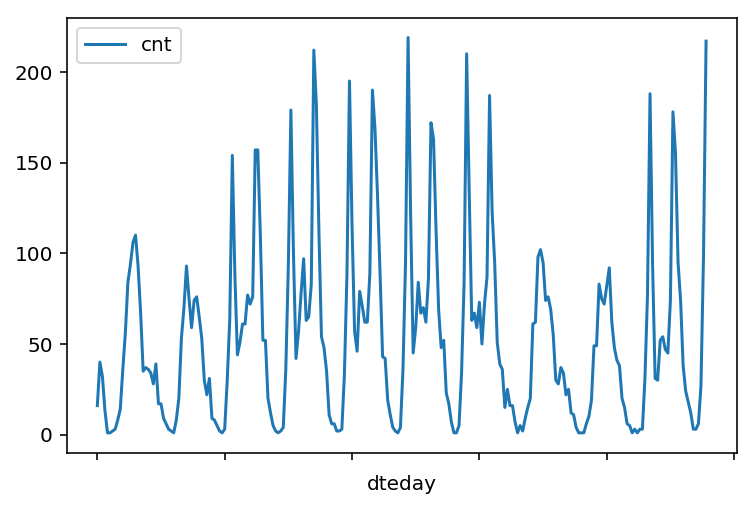

In [26]:
rides[:24*10].plot(x='dteday', y='cnt')


### 虚拟变量（哑变量）

下面是一些分类变量，例如季节、天气、月份。要在我们的模型中包含这些数据，我们需要创建二进制虚拟变量。用 Pandas 库中的 `get_dummies()` 就可以轻松实现。

In [27]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()


,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### 调整目标变量

为了更轻松地训练网络，我们将对每个连续变量标准化，即转换和调整变量，使它们的均值为 0，标准差为 1。

我们会保存换算因子，以便当我们使用网络进行预测时可以还原数据。

In [28]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### 将数据拆分为训练、测试和验证数据集

我们将大约最后 21 天的数据保存为测试数据集，这些数据集会在训练完网络后使用。我们将使用该数据集进行预测，并与实际的骑行人数进行对比。

In [29]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]
# Now remove the test data from the data set 
data = data[:-21*24]
# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

我们将数据拆分为两个数据集，一个用作训练，一个在网络训练完后用来验证网络。因为数据是有时间序列特性的，所以我们用历史数据进行训练，然后尝试预测未来数据（验证数据集）。

In [30]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## 开始构建网络

下面你将构建自己的网络。我们已经构建好结构和反向传递部分。你将实现网络的前向传递部分。还需要设置超参数：学习速率、隐藏单元的数量，以及训练传递数量。

<img src="assets/neural_network.png" width=300px>

该网络有两个层级，一个隐藏层和一个输出层。隐藏层级将使用 S 型函数作为激活函数。输出层只有一个节点，用于递归，节点的输出和节点的输入相同。即激活函数是 $f(x)=x$。这种函数获得输入信号，并生成输出信号，但是会考虑阈值，称为激活函数。我们完成网络的每个层级，并计算每个神经元的输出。一个层级的所有输出变成下一层级神经元的输入。这一流程叫做前向传播（forward propagation）。

我们在神经网络中使用权重将信号从输入层传播到输出层。我们还使用权重将错误从输出层传播回网络，以便更新权重。这叫做反向传播（backpropagation）。

> **提示**：你需要为反向传播实现计算输出激活函数 ($f(x) = x$) 的导数。如果你不熟悉微积分，其实该函数就等同于等式 $y = x$。该等式的斜率是多少？也就是导数 $f(x)$。


你需要完成以下任务：

1. 实现 S 型激活函数。将 `__init__` 中的 `self.activation_function`  设为你的 S 型函数。
2. 在 `train` 方法中实现前向传递。
3. 在 `train` 方法中实现反向传播算法，包括计算输出错误。
4. 在 `run` 方法中实现前向传递。

  

In [31]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5, 
                                       (self.input_nodes, self.hidden_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.output_nodes))
        self.lr = learning_rate
        
        #### TODO: Set self.activation_function to your implemented sigmoid function ####
        #
        # Note: in Python, you can define a function with a lambda expression,
        # as shown below.
        self.activation_function = lambda x : 1/(1+np.exp(-x))  # Replace 0 with your sigmoid calculation.
        self.activation_function_derive = lambda x : x*(1-x)
        ### If the lambda code above is not something you're familiar with,
        # You can uncomment out the following three lines and put your 
        # implementation there instead.
        #
        #def sigmoid(x):
        #    return 0  # Replace 0 with your sigmoid calculation here
        #self.activation_function = sigmoid
                    
    
    def train(self, features, targets):
        ''' Train the network on batch of features and targets. 
        
            Arguments
            ---------
            
            features: 2D array, each row is one data record, each column is a feature
            targets: 1D array of target values
        
        '''
        n_records = features.shape[0]
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        for X, y in zip(features, targets):
            #### Implement the forward pass here ####
            ### Forward pass ###
            
            hidden_inputs = np.dot(X, self.weights_input_to_hidden) # signals into hidden layer 1x3 x 3x2=1x2
            hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer 1x2 

            # TODO: Output layer - Replace these values with your calculations.
            final_inputs = np.dot(hidden_outputs,self.weights_hidden_to_output) # signals into final output layer 1x2 x 2x1=1x1
            final_outputs = final_inputs # signals from final output layer
            
            #### Implement the backward pass here ####
            ### Backward pass ###

            # TODO: Output error - Replace this value with your calculations.
            error = y-final_outputs # Output layer error is the difference between desired target and actual output.1x1
            

            
            # TODO: Backpropagated error terms - Replace these values with your calculations.
            output_error_term =  error  #1x1
            
            # TODO: Calculate the hidden layer's contribution to the error
            hidden_error =np.dot(self.weights_hidden_to_output,output_error_term) #2x1 x 1x1 = 2x1
            
            
            hidden_error_term = hidden_error * self.activation_function_derive(hidden_outputs) #2x1

            # Weight step (hidden to output)
            delta_weights_h_o += output_error_term * hidden_outputs[:,None] #   2*1
            
            # Weight step (input to hidden)
            delta_weights_i_h += hidden_error_term * X[:,None]    #   3*2 
            
        # TODO: Update the weights - Replace these values with your calculations.
        self.weights_hidden_to_output += self.lr * delta_weights_h_o/n_records # update hidden-to-output weights with gradient descent step
        self.weights_input_to_hidden += self.lr * delta_weights_i_h/n_records # update input-to-hidden weights with gradient descent step
 
    def run(self, features):
        ''' Run a forward pass through the network with input features 
        
            Arguments
            ---------
            features: 1D array of feature values
        '''
        
        #### Implement the forward pass here ####
        # TODO: Hidden layer - replace these values with the appropriate calculations.
        hidden_inputs = np.dot(features, self.weights_input_to_hidden) # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer
        
        # TODO: Output layer - Replace these values with the appropriate calculations.
        final_inputs = np.dot(hidden_outputs,self.weights_hidden_to_output) # signals into final output layer
        final_outputs = final_inputs # signals from final output layer 
        print(final_outputs)
        return final_outputs

In [32]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## 单元测试

运行这些单元测试，检查你的网络实现是否正确。这样可以帮助你确保网络已正确实现，然后再开始训练网络。这些测试必须成功才能通过此项目。

In [33]:
import unittest

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path.lower() == 'bike-sharing-dataset/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        print(network.weights_hidden_to_output)
        print(network.weights_input_to_hidden)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....

[[ 0.09998924]]
[[ 0.37275328]
 [-0.03172939]]
[[ 0.10562014 -0.20185996]
 [ 0.39775194  0.50074398]
 [-0.29887597  0.19962801]]



----------------------------------------------------------------------
Ran 5 tests in 0.014s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

## 训练网络

现在你将设置网络的超参数。策略是设置的超参数使训练集上的错误很小但是数据不会过拟合。如果网络训练时间太长，或者有太多的隐藏节点，可能就会过于针对特定训练集，无法泛化到验证数据集。即当训练集的损失降低时，验证集的损失将开始增大。

你还将采用随机梯度下降 (SGD) 方法训练网络。对于每次训练，都获取随机样本数据，而不是整个数据集。与普通梯度下降相比，训练次数要更多，但是每次时间更短。这样的话，网络训练效率更高。稍后你将详细了解 SGD。


### 选择迭代次数

也就是训练网络时从训练数据中抽样的批次数量。迭代次数越多，模型就与数据越拟合。但是，如果迭代次数太多，模型就无法很好地泛化到其他数据，这叫做过拟合。你需要选择一个使训练损失很低并且验证损失保持中等水平的数字。当你开始过拟合时，你会发现训练损失继续下降，但是验证损失开始上升。

### 选择学习速率

速率可以调整权重更新幅度。如果速率太大，权重就会太大，导致网络无法与数据相拟合。建议从 0.1 开始。如果网络在与数据拟合时遇到问题，尝试降低学习速率。注意，学习速率越低，权重更新的步长就越小，神经网络收敛的时间就越长。


### 选择隐藏节点数量

隐藏节点越多，模型的预测结果就越准确。尝试不同的隐藏节点的数量，看看对性能有何影响。你可以查看损失字典，寻找网络性能指标。如果隐藏单元的数量太少，那么模型就没有足够的空间进行学习，如果太多，则学习方向就有太多的选择。选择隐藏单元数量的技巧在于找到合适的平衡点。

In [46]:
import sys

### Set the hyperparameters here ###
iterations = 8000
learning_rate = 0.5
hidden_nodes = 9
output_nodes = 1

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.ix[batch].values, train_targets.ix[batch]['cnt']
                             
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

[[ 0.2798351 ]
 [ 0.29749838]
 [ 0.28259219]
 ..., 
 [ 0.12334139]
 [ 0.16499313]
 [ 0.07076853]]
[[ 0.04616049]
 [ 0.13566116]
 [ 0.12356256]
 ..., 
 [ 0.15693728]
 [ 0.14395685]
 [ 0.16547779]]
Progress: 0.0% ... Training loss: 1.064 ... Validation loss: 1.357[[ 0.26029667]
 [ 0.27721323]
 [ 0.26454769]
 ..., 
 [ 0.13449118]
 [ 0.1791817 ]
 [ 0.09550001]]
[[ 0.081894  ]
 [ 0.19164103]
 [ 0.18894213]
 ..., 
 [ 0.20216797]
 [ 0.16778274]
 [ 0.18396163]]
Progress: 0.0% ... Training loss: 1.041 ... Validation loss: 1.319[[-0.15912699]
 [-0.14002304]
 [-0.15619493]
 ..., 
 [-0.24624067]
 [-0.21647416]
 [-0.26975663]]
[[-0.28665715]
 [-0.17457222]
 [-0.16858014]
 ..., 
 [-0.19750893]
 [-0.21805356]
 [-0.23163872]]
Progress: 0.0% ... Training loss: 1.027 ... Validation loss: 1.583[[ 0.01163004]
 [ 0.02781665]
 [ 0.01423495]
 ..., 
 [-0.07303744]
 [-0.03224723]
 [-0.08762624]]
[[-0.09098334]
 [ 0.04120199]
 [ 0.05255577]
 ..., 
 [ 0.02123531]
 [-0.02573395]
 [-0.03484738]]
Progress: 0.0% ...

Progress: 0.4% ... Training loss: 0.675 ... Validation loss: 1.306[[-0.96128687]
 [-0.97335767]
 [-1.00494482]
 ..., 
 [-0.483721  ]
 [-0.3813011 ]
 [-0.2815266 ]]
[[-0.08951354]
 [ 0.34051525]
 [ 0.46677877]
 ..., 
 [ 0.05275263]
 [-0.29521202]
 [-0.41904842]]
Progress: 0.4% ... Training loss: 0.660 ... Validation loss: 1.199[[-0.97423838]
 [-0.98707376]
 [-1.01891549]
 ..., 
 [-0.49875119]
 [-0.39469162]
 [-0.30189626]]
[[-0.11326892]
 [ 0.30461428]
 [ 0.42862281]
 ..., 
 [ 0.01910979]
 [-0.3237841 ]
 [-0.43700472]]
Progress: 0.4% ... Training loss: 0.660 ... Validation loss: 1.220[[-0.98652141]
 [-0.99807158]
 [-1.03126526]
 ..., 
 [-0.51113605]
 [-0.40671882]
 [-0.31822298]]
[[-0.13078345]
 [ 0.27465188]
 [ 0.39801756]
 ..., 
 [-0.00911292]
 [-0.34993995]
 [-0.45431889]]
Progress: 0.4% ... Training loss: 0.660 ... Validation loss: 1.236[[-0.94370794]
 [-0.9570849 ]
 [-0.99083481]
 ..., 
 [-0.43849138]
 [-0.33038693]
 [-0.25254209]]
[[-0.06186772]
 [ 0.33048375]
 [ 0.44953832]
 ...,

Progress: 0.8% ... Training loss: 0.580 ... Validation loss: 1.004[[-0.97526241]
 [-0.99572317]
 [-1.03292422]
 ..., 
 [-0.16661889]
 [-0.01752176]
 [ 0.08588467]]
[[ 0.36092492]
 [ 0.65675474]
 [ 0.74736923]
 ..., 
 [ 0.38002743]
 [-0.02991706]
 [-0.08772399]]
Progress: 0.8% ... Training loss: 0.579 ... Validation loss: 0.896[[-1.1662975 ]
 [-1.1851118 ]
 [-1.22586347]
 ..., 
 [-0.34561275]
 [-0.20437951]
 [-0.09309971]]
[[ 0.17376286]
 [ 0.45639434]
 [ 0.54622303]
 ..., 
 [ 0.16403686]
 [-0.23238006]
 [-0.29580984]]
Progress: 0.8% ... Training loss: 0.577 ... Validation loss: 0.996[[-1.00802826]
 [-1.02551716]
 [-1.06386943]
 ..., 
 [-0.20918311]
 [-0.05922407]
 [ 0.05458439]]
[[ 0.31957974]
 [ 0.59730313]
 [ 0.68256231]
 ..., 
 [ 0.31495833]
 [-0.08578829]
 [-0.14632577]]
Progress: 0.8% ... Training loss: 0.566 ... Validation loss: 0.911[[-1.08132961]
 [-1.09761287]
 [-1.1380616 ]
 ..., 
 [-0.27041036]
 [-0.12186136]
 [-0.00589615]]
[[ 0.26793243]
 [ 0.55624455]
 [ 0.6412805 ]
 ...,

Progress: 1.2% ... Training loss: 0.486 ... Validation loss: 0.796[[-1.20289176]
 [-1.21930208]
 [-1.2656584 ]
 ..., 
 [-0.09320043]
 [ 0.10487709]
 [ 0.32049962]]
[[ 0.73157034]
 [ 0.87338609]
 [ 0.8925542 ]
 ..., 
 [ 0.61500232]
 [ 0.11920794]
 [ 0.05028212]]
Progress: 1.2% ... Training loss: 0.485 ... Validation loss: 0.761[[-1.25944096]
 [-1.27619205]
 [-1.32267839]
 ..., 
 [-0.13983356]
 [ 0.05663516]
 [ 0.28697555]]
[[ 0.71388364]
 [ 0.86098123]
 [ 0.88012453]
 ..., 
 [ 0.60758976]
 [ 0.10215186]
 [ 0.02011687]]
Progress: 1.2% ... Training loss: 0.480 ... Validation loss: 0.755[[-1.32683749]
 [-1.34434083]
 [-1.39145474]
 ..., 
 [-0.21891263]
 [-0.02405329]
 [ 0.21571356]]
[[ 0.6495668 ]
 [ 0.79594514]
 [ 0.81226601]
 ..., 
 [ 0.53941124]
 [ 0.03469923]
 [-0.06031468]]
Progress: 1.2% ... Training loss: 0.473 ... Validation loss: 0.764[[-1.23775572]
 [-1.25492894]
 [-1.30600735]
 ..., 
 [-0.12984662]
 [ 0.07446105]
 [ 0.3298506 ]]
[[ 0.78272697]
 [ 0.93908487]
 [ 0.95882894]
 ...,

Progress: 1.6% ... Training loss: 0.403 ... Validation loss: 0.655[[-1.44597167]
 [-1.4795246 ]
 [-1.52277474]
 ..., 
 [-0.30061977]
 [-0.05792858]
 [ 0.27787869]]
[[ 0.82062005]
 [ 0.79617603]
 [ 0.7113324 ]
 ..., 
 [ 0.64473344]
 [ 0.08690738]
 [-0.00619054]]
Progress: 1.6% ... Training loss: 0.407 ... Validation loss: 0.658[[-1.32189137]
 [-1.35389085]
 [-1.39884892]
 ..., 
 [-0.15999516]
 [ 0.09186562]
 [ 0.4337068 ]]
[[ 0.98210052]
 [ 0.95868999]
 [ 0.87350865]
 ..., 
 [ 0.8063459 ]
 [ 0.23512339]
 [ 0.14179416]]
Progress: 1.6% ... Training loss: 0.401 ... Validation loss: 0.641[[-1.37811164]
 [-1.40716317]
 [-1.4525973 ]
 ..., 
 [-0.19882956]
 [ 0.0518301 ]
 [ 0.39236591]]
[[ 0.92694012]
 [ 0.87286562]
 [ 0.77800532]
 ..., 
 [ 0.73277321]
 [ 0.17752606]
 [ 0.09100056]]
Progress: 1.6% ... Training loss: 0.397 ... Validation loss: 0.641[[-1.23544853]
 [-1.26345596]
 [-1.30953755]
 ..., 
 [-0.06110541]
 [ 0.19895019]
 [ 0.5359943 ]]
[[ 1.08002204]
 [ 1.00377134]
 [ 0.90357526]
 ...,

Progress: 2.0% ... Training loss: 0.392 ... Validation loss: 0.613[[-1.41179845]
 [-1.46229282]
 [-1.49273201]
 ..., 
 [-0.32529927]
 [-0.03791008]
 [ 0.4501512 ]]
[[ 1.04477262]
 [ 0.7914934 ]
 [ 0.5940161 ]
 ..., 
 [ 0.76838091]
 [ 0.18855072]
 [ 0.07402875]]
Progress: 2.0% ... Training loss: 0.362 ... Validation loss: 0.589[[-1.33366622]
 [-1.38383968]
 [-1.41119426]
 ..., 
 [-0.25625772]
 [ 0.03798826]
 [ 0.52998808]]
[[ 1.13304259]
 [ 0.87454848]
 [ 0.68160781]
 ..., 
 [ 0.85589608]
 [ 0.2753868 ]
 [ 0.15792251]]
Progress: 2.0% ... Training loss: 0.354 ... Validation loss: 0.576[[-1.5317544 ]
 [-1.58471642]
 [-1.61075187]
 ..., 
 [-0.47125534]
 [-0.1883226 ]
 [ 0.31109118]]
[[ 0.92233346]
 [ 0.65267411]
 [ 0.45164226]
 ..., 
 [ 0.62983857]
 [ 0.06789963]
 [-0.05922431]]
Progress: 2.0% ... Training loss: 0.398 ... Validation loss: 0.632[[-1.25009149]
 [-1.30789382]
 [-1.33330532]
 ..., 
 [-0.1992191 ]
 [ 0.09209698]
 [ 0.55704844]]
[[ 1.15336566]
 [ 0.83492267]
 [ 0.60430958]
 ...,

[[ 1.2104256 ]
 [ 0.86804266]
 [ 0.6441843 ]
 ..., 
 [ 0.88649176]
 [ 0.28233318]
 [ 0.09970526]]
Progress: 2.4% ... Training loss: 0.325 ... Validation loss: 0.519[[-1.39746041]
 [-1.47103249]
 [-1.51340897]
 ..., 
 [-0.4446414 ]
 [-0.10902022]
 [ 0.52128828]]
[[ 1.23104572]
 [ 0.87409599]
 [ 0.64923012]
 ..., 
 [ 0.90744506]
 [ 0.30654024]
 [ 0.11190828]]
Progress: 2.4% ... Training loss: 0.324 ... Validation loss: 0.518[[-1.56529276]
 [-1.64158187]
 [-1.68252302]
 ..., 
 [-0.54811053]
 [-0.21528153]
 [ 0.41831833]]
[[ 1.1441948 ]
 [ 0.81535975]
 [ 0.59838013]
 ..., 
 [ 0.83496776]
 [ 0.22192832]
 [ 0.02007158]]
Progress: 2.4% ... Training loss: 0.333 ... Validation loss: 0.529[[-1.35760182]
 [-1.441117  ]
 [-1.47886455]
 ..., 
 [-0.28409499]
 [ 0.0624374 ]
 [ 0.75127389]]
[[ 1.49635358]
 [ 1.19947624]
 [ 0.9897803 ]
 ..., 
 [ 1.2049057 ]
 [ 0.55859957]
 [ 0.2993418 ]]
Progress: 2.4% ... Training loss: 0.378 ... Validation loss: 0.538[[-1.63857952]
 [-1.71718174]
 [-1.75740161]
 ...,

Progress: 2.8% ... Training loss: 0.311 ... Validation loss: 0.493[[-1.34351802]
 [-1.43291056]
 [-1.47401144]
 ..., 
 [-0.38659654]
 [-0.00637952]
 [ 0.60253321]]
[[ 1.40008139]
 [ 0.91890041]
 [ 0.70142444]
 ..., 
 [ 1.02868382]
 [ 0.4081172 ]
 [ 0.17852503]]
Progress: 2.8% ... Training loss: 0.314 ... Validation loss: 0.494[[-1.39430816]
 [-1.4835971 ]
 [-1.53206384]
 ..., 
 [-0.46693814]
 [-0.08738134]
 [ 0.53925802]]
[[ 1.34621829]
 [ 0.84845314]
 [ 0.63283756]
 ..., 
 [ 0.9539659 ]
 [ 0.33310524]
 [ 0.09242163]]
Progress: 2.8% ... Training loss: 0.310 ... Validation loss: 0.490[[-1.33074475]
 [-1.42582761]
 [-1.47025073]
 ..., 
 [-0.39033186]
 [-0.00245495]
 [ 0.63014855]]
[[ 1.4513664 ]
 [ 0.97782158]
 [ 0.77197628]
 ..., 
 [ 1.09024933]
 [ 0.43866842]
 [ 0.19405711]]
Progress: 2.8% ... Training loss: 0.324 ... Validation loss: 0.493[[-1.56123735]
 [-1.65644727]
 [-1.69813886]
 ..., 
 [-0.62279336]
 [-0.25109185]
 [ 0.40371712]]
[[ 1.23432591]
 [ 0.76455663]
 [ 0.56362472]
 ...,

Progress: 3.1% ... Training loss: 0.306 ... Validation loss: 0.481[[-1.5010604 ]
 [-1.58006386]
 [-1.63089805]
 ..., 
 [-0.62448388]
 [-0.25192185]
 [ 0.45133193]]
[[ 1.28443952]
 [ 0.66519282]
 [ 0.39726352]
 ..., 
 [ 0.84032587]
 [ 0.20249187]
 [-0.04761768]]
Progress: 3.1% ... Training loss: 0.328 ... Validation loss: 0.510[[-1.36716025]
 [-1.44671376]
 [-1.49519889]
 ..., 
 [-0.50699171]
 [-0.13224806]
 [ 0.54870877]]
[[ 1.3615721 ]
 [ 0.75325292]
 [ 0.48966182]
 ..., 
 [ 0.92013832]
 [ 0.28928593]
 [ 0.06283659]]
Progress: 3.2% ... Training loss: 0.309 ... Validation loss: 0.489[[-1.33086726]
 [-1.4130707 ]
 [-1.46150567]
 ..., 
 [-0.45026137]
 [-0.07510907]
 [ 0.62474786]]
[[ 1.45402909]
 [ 0.88830487]
 [ 0.63740959]
 ..., 
 [ 1.02301314]
 [ 0.37016979]
 [ 0.11631283]]
Progress: 3.2% ... Training loss: 0.303 ... Validation loss: 0.478[[-1.57231173]
 [-1.65612194]
 [-1.70673873]
 ..., 
 [-0.62640366]
 [-0.25858141]
 [ 0.44963055]]
[[ 1.32125465]
 [ 0.84384381]
 [ 0.61052049]
 ...,

Progress: 3.5% ... Training loss: 0.296 ... Validation loss: 0.472[[-1.3203851 ]
 [-1.39795358]
 [-1.45743772]
 ..., 
 [-0.39748167]
 [-0.03453588]
 [ 0.67998991]]
[[ 1.54439117]
 [ 0.92270307]
 [ 0.64031097]
 ..., 
 [ 1.08539422]
 [ 0.45931085]
 [ 0.22485617]]
Progress: 3.5% ... Training loss: 0.298 ... Validation loss: 0.476[[-1.49912262]
 [-1.57576174]
 [-1.63955246]
 ..., 
 [-0.59255205]
 [-0.24222003]
 [ 0.50963374]]
[[ 1.38631303]
 [ 0.81438034]
 [ 0.55119421]
 ..., 
 [ 0.96362735]
 [ 0.32131217]
 [ 0.04619663]]
Progress: 3.6% ... Training loss: 0.301 ... Validation loss: 0.463[[-1.35422472]
 [-1.4332298 ]
 [-1.49778933]
 ..., 
 [-0.41829426]
 [-0.05787703]
 [ 0.68839118]]
[[ 1.57012084]
 [ 0.97830826]
 [ 0.7176285 ]
 ..., 
 [ 1.14688901]
 [ 0.49490925]
 [ 0.23386835]]
Progress: 3.6% ... Training loss: 0.302 ... Validation loss: 0.469[[-1.35671931]
 [-1.43045889]
 [-1.50080761]
 ..., 
 [-0.44535505]
 [-0.09147737]
 [ 0.66457378]]
[[ 1.52678187]
 [ 0.89480755]
 [ 0.62863883]
 ...,

Progress: 3.9% ... Training loss: 0.308 ... Validation loss: 0.459[[-1.32129152]
 [-1.40368983]
 [-1.47955791]
 ..., 
 [-0.47441644]
 [-0.12112497]
 [ 0.62014882]]
[[ 1.50636639]
 [ 0.99468365]
 [ 0.72812239]
 ..., 
 [ 1.08438547]
 [ 0.45834849]
 [ 0.1553056 ]]
Progress: 4.0% ... Training loss: 0.299 ... Validation loss: 0.453[[-1.33289289]
 [-1.41821995]
 [-1.49329499]
 ..., 
 [-0.50243281]
 [-0.15167925]
 [ 0.58990662]]
[[ 1.45931323]
 [ 0.91773389]
 [ 0.64482075]
 ..., 
 [ 1.02603202]
 [ 0.42200873]
 [ 0.12485811]]
Progress: 4.0% ... Training loss: 0.290 ... Validation loss: 0.453[[-1.29445112]
 [-1.38224003]
 [-1.45762163]
 ..., 
 [-0.46204029]
 [-0.10717215]
 [ 0.65598825]]
[[ 1.53565288]
 [ 0.97208385]
 [ 0.70048532]
 ..., 
 [ 1.07433026]
 [ 0.46973806]
 [ 0.15399356]]
Progress: 4.0% ... Training loss: 0.296 ... Validation loss: 0.451[[-1.37450077]
 [-1.45912737]
 [-1.53481374]
 ..., 
 [-0.57720308]
 [-0.23266383]
 [ 0.55891338]]
[[ 1.45442059]
 [ 0.92833022]
 [ 0.66613305]
 ...,

[[ 1.48797019]
 [ 0.82631606]
 [ 0.55981952]
 ..., 
 [ 1.04846341]
 [ 0.46678309]
 [ 0.21223294]]
Progress: 4.3% ... Training loss: 0.285 ... Validation loss: 0.455[[-1.33150627]
 [-1.4188344 ]
 [-1.49133053]
 ..., 
 [-0.53708563]
 [-0.17937266]
 [ 0.53167402]]
[[ 1.39950191]
 [ 0.70250068]
 [ 0.42150638]
 ..., 
 [ 0.93032457]
 [ 0.37953663]
 [ 0.14745473]]
Progress: 4.3% ... Training loss: 0.305 ... Validation loss: 0.472[[-1.18861655]
 [-1.27871088]
 [-1.35133221]
 ..., 
 [-0.42665343]
 [-0.06845174]
 [ 0.65898743]]
[[ 1.52327458]
 [ 0.86825429]
 [ 0.60510072]
 ..., 
 [ 1.06771437]
 [ 0.49110288]
 [ 0.23950581]]
Progress: 4.4% ... Training loss: 0.284 ... Validation loss: 0.460[[-1.21350335]
 [-1.30429433]
 [-1.38047978]
 ..., 
 [-0.46418592]
 [-0.10459499]
 [ 0.63397475]]
[[ 1.50367328]
 [ 0.82172174]
 [ 0.55505364]
 ..., 
 [ 1.0109747 ]
 [ 0.43121666]
 [ 0.17643258]]
Progress: 4.4% ... Training loss: 0.283 ... Validation loss: 0.456[[-1.3377184 ]
 [-1.42574488]
 [-1.50086184]
 ...,

Progress: 4.7% ... Training loss: 0.283 ... Validation loss: 0.455[[-1.11216859]
 [-1.21588399]
 [-1.30650593]
 ..., 
 [-0.54004489]
 [-0.1963249 ]
 [ 0.57332051]]
[[ 1.4615961 ]
 [ 0.87046677]
 [ 0.62474384]
 ..., 
 [ 1.14543569]
 [ 0.49832281]
 [ 0.18687053]]
Progress: 4.7% ... Training loss: 0.282 ... Validation loss: 0.456[[-1.18929651]
 [-1.2950845 ]
 [-1.38537216]
 ..., 
 [-0.59079999]
 [-0.24964547]
 [ 0.53304064]]
[[ 1.41486461]
 [ 0.84786236]
 [ 0.60227833]
 ..., 
 [ 1.09042425]
 [ 0.4354362 ]
 [ 0.10791823]]
Progress: 4.8% ... Training loss: 0.281 ... Validation loss: 0.449[[-1.22010916]
 [-1.32934443]
 [-1.41985071]
 ..., 
 [-0.63953097]
 [-0.30023876]
 [ 0.45692747]]
[[ 1.31871768]
 [ 0.71710279]
 [ 0.46358786]
 ..., 
 [ 0.97160908]
 [ 0.34706124]
 [ 0.03516452]]
Progress: 4.8% ... Training loss: 0.288 ... Validation loss: 0.459[[-1.09996246]
 [-1.2113975 ]
 [-1.29897149]
 ..., 
 [-0.49999826]
 [-0.15547452]
 [ 0.58328827]]
[[ 1.43596415]
 [ 0.8415431 ]
 [ 0.58886092]
 ...,

Progress: 5.1% ... Training loss: 0.282 ... Validation loss: 0.450[[-1.11145962]
 [-1.21509157]
 [-1.31247664]
 ..., 
 [-0.55873182]
 [-0.25348027]
 [ 0.56192865]]
[[ 1.42701456]
 [ 0.84856417]
 [ 0.59390623]
 ..., 
 [ 1.04383883]
 [ 0.39083795]
 [ 0.04385986]]
Progress: 5.1% ... Training loss: 0.281 ... Validation loss: 0.449[[-1.14419868]
 [-1.24658572]
 [-1.34487664]
 ..., 
 [-0.59940107]
 [-0.2966584 ]
 [ 0.51443252]]
[[ 1.37796552]
 [ 0.7900518 ]
 [ 0.52391149]
 ..., 
 [ 1.01205485]
 [ 0.37643707]
 [ 0.03061953]]
Progress: 5.2% ... Training loss: 0.277 ... Validation loss: 0.453[[-1.05041023]
 [-1.15535206]
 [-1.25398123]
 ..., 
 [-0.47914341]
 [-0.1717753 ]
 [ 0.63764531]]
[[ 1.51807627]
 [ 0.91857297]
 [ 0.64626097]
 ..., 
 [ 1.12911037]
 [ 0.4917334 ]
 [ 0.14684162]]
Progress: 5.2% ... Training loss: 0.293 ... Validation loss: 0.456[[-1.05983172]
 [-1.16092769]
 [-1.26551127]
 ..., 
 [-0.46909128]
 [-0.15465152]
 [ 0.63402568]]
[[ 1.49021215]
 [ 0.82967706]
 [ 0.53328218]
 ...,

Progress: 5.5% ... Training loss: 0.277 ... Validation loss: 0.448[[-1.21994398]
 [-1.31954951]
 [-1.41462664]
 ..., 
 [-0.57781613]
 [-0.25496174]
 [ 0.50564629]]
[[ 1.40347827]
 [ 0.74717297]
 [ 0.48940759]
 ..., 
 [ 0.95105655]
 [ 0.31356819]
 [ 0.02922614]]
Progress: 5.5% ... Training loss: 0.280 ... Validation loss: 0.451[[-1.16519537]
 [-1.26518159]
 [-1.3619473 ]
 ..., 
 [-0.52374407]
 [-0.19850587]
 [ 0.56351972]]
[[ 1.46078681]
 [ 0.79327511]
 [ 0.546511  ]
 ..., 
 [ 0.98484982]
 [ 0.34859208]
 [ 0.06036604]]
Progress: 5.5% ... Training loss: 0.275 ... Validation loss: 0.444[[-1.17758534]
 [-1.27896146]
 [-1.3743846 ]
 ..., 
 [-0.53221117]
 [-0.20995608]
 [ 0.5581455 ]]
[[ 1.44316722]
 [ 0.76988019]
 [ 0.51237308]
 ..., 
 [ 0.97752777]
 [ 0.35459696]
 [ 0.06258602]]
Progress: 5.6% ... Training loss: 0.277 ... Validation loss: 0.450[[-1.1395011 ]
 [-1.24058785]
 [-1.33635744]
 ..., 
 [-0.50085925]
 [-0.18433259]
 [ 0.60953033]]
[[ 1.51732404]
 [ 0.91594121]
 [ 0.6783857 ]
 ...,

[[ 1.5263863 ]
 [ 0.83945836]
 [ 0.57227419]
 ..., 
 [ 1.04294499]
 [ 0.39929272]
 [ 0.12723975]]
Progress: 5.9% ... Training loss: 0.272 ... Validation loss: 0.447[[-1.02768562]
 [-1.12875845]
 [-1.21607536]
 ..., 
 [-0.40818175]
 [-0.08377766]
 [ 0.70921895]]
[[ 1.59320691]
 [ 0.88891194]
 [ 0.61990187]
 ..., 
 [ 1.10140703]
 [ 0.46248309]
 [ 0.1857854 ]]
Progress: 5.9% ... Training loss: 0.273 ... Validation loss: 0.457[[-1.14706238]
 [-1.24607343]
 [-1.32999408]
 ..., 
 [-0.50190359]
 [-0.17690045]
 [ 0.5863995 ]]
[[ 1.46698116]
 [ 0.71037394]
 [ 0.43188586]
 ..., 
 [ 0.95316416]
 [ 0.34958173]
 [ 0.09726991]]
Progress: 6.0% ... Training loss: 0.298 ... Validation loss: 0.465[[-0.95253531]
 [-1.05089206]
 [-1.13837219]
 ..., 
 [-0.33929146]
 [-0.00588017]
 [ 0.79773752]]
[[ 1.71633824]
 [ 1.01434178]
 [ 0.75753023]
 ..., 
 [ 1.21253428]
 [ 0.55831389]
 [ 0.26783594]]
Progress: 6.0% ... Training loss: 0.285 ... Validation loss: 0.484[[-1.07773668]
 [-1.17915612]
 [-1.26322148]
 ...,

Progress: 6.3% ... Training loss: 0.271 ... Validation loss: 0.445[[-1.12339591]
 [-1.23494111]
 [-1.30008187]
 ..., 
 [-0.50620682]
 [-0.18569948]
 [ 0.57417602]]
[[ 1.52018019]
 [ 0.85791733]
 [ 0.59455965]
 ..., 
 [ 1.0262279 ]
 [ 0.39795129]
 [ 0.12238395]]
Progress: 6.3% ... Training loss: 0.270 ... Validation loss: 0.436[[-1.07279986]
 [-1.18618566]
 [-1.25350124]
 ..., 
 [-0.43083154]
 [-0.10633777]
 [ 0.67736365]]
[[ 1.60905774]
 [ 0.96988339]
 [ 0.70967951]
 ..., 
 [ 1.14451648]
 [ 0.49775765]
 [ 0.21263177]]
Progress: 6.3% ... Training loss: 0.285 ... Validation loss: 0.444[[-1.26273875]
 [-1.36732059]
 [-1.43873618]
 ..., 
 [-0.65683918]
 [-0.34119396]
 [ 0.43771001]]
[[  1.36191829e+00]
 [  7.16592938e-01]
 [  4.43373531e-01]
 ..., 
 [  9.08826122e-01]
 [  3.01831280e-01]
 [  2.01970978e-04]]
Progress: 6.3% ... Training loss: 0.291 ... Validation loss: 0.455[[-0.99164964]
 [-1.09683721]
 [-1.17119245]
 ..., 
 [-0.39682329]
 [-0.07314789]
 [ 0.72888416]]
[[ 1.64385743]
 [ 1.

Progress: 6.7% ... Training loss: 0.280 ... Validation loss: 0.470[[-1.10122529]
 [-1.19028859]
 [-1.27461769]
 ..., 
 [-0.59493093]
 [-0.27652062]
 [ 0.48939467]]
[[ 1.3270358 ]
 [ 0.7224984 ]
 [ 0.45794502]
 ..., 
 [ 0.9459254 ]
 [ 0.3337693 ]
 [ 0.05066178]]
Progress: 6.7% ... Training loss: 0.275 ... Validation loss: 0.449[[-1.02376238]
 [-1.11352553]
 [-1.19718252]
 ..., 
 [-0.49572889]
 [-0.17547168]
 [ 0.61185388]]
[[ 1.46703645]
 [ 0.91658977]
 [ 0.66127597]
 ..., 
 [ 1.10963825]
 [ 0.47801776]
 [ 0.16640059]]
Progress: 6.7% ... Training loss: 0.271 ... Validation loss: 0.450[[-0.99803922]
 [-1.08746723]
 [-1.17189947]
 ..., 
 [-0.46469906]
 [-0.13956837]
 [ 0.63181128]]
[[ 1.50012107]
 [ 0.93047379]
 [ 0.66352034]
 ..., 
 [ 1.12619603]
 [ 0.49919131]
 [ 0.20131653]]
Progress: 6.7% ... Training loss: 0.273 ... Validation loss: 0.455[[-1.12333874]
 [-1.21659824]
 [-1.29808334]
 ..., 
 [-0.5578272 ]
 [-0.23245167]
 [ 0.55752735]]
[[ 1.42523841]
 [ 0.82739817]
 [ 0.56561198]
 ...,

Progress: 7.1% ... Training loss: 0.282 ... Validation loss: 0.451[[-0.94860019]
 [-1.03796541]
 [-1.13065297]
 ..., 
 [-0.44185679]
 [-0.11750391]
 [ 0.69574953]]
[[ 1.52961562]
 [ 0.88609773]
 [ 0.61827333]
 ..., 
 [ 1.10111594]
 [ 0.48282683]
 [ 0.17171735]]
Progress: 7.1% ... Training loss: 0.277 ... Validation loss: 0.455[[-1.01182993]
 [-1.10151987]
 [-1.1906287 ]
 ..., 
 [-0.55749536]
 [-0.23949821]
 [ 0.57902851]]
[[ 1.40053349]
 [ 0.75744264]
 [ 0.49202467]
 ..., 
 [ 0.96879189]
 [ 0.36105727]
 [ 0.0432328 ]]
Progress: 7.1% ... Training loss: 0.272 ... Validation loss: 0.447[[-0.94598709]
 [-1.03957663]
 [-1.12546407]
 ..., 
 [-0.46508479]
 [-0.14073551]
 [ 0.6758889 ]]
[[ 1.53148365]
 [ 0.92780607]
 [ 0.67636763]
 ..., 
 [ 1.12340233]
 [ 0.480387  ]
 [ 0.15812178]]
Progress: 7.1% ... Training loss: 0.279 ... Validation loss: 0.455[[-1.12271058]
 [-1.21540116]
 [-1.30041699]
 ..., 
 [-0.63784092]
 [-0.32578711]
 [ 0.47576839]]
[[ 1.33526337]
 [ 0.7299315 ]
 [ 0.48577125]
 ...,

Progress: 7.5% ... Training loss: 0.267 ... Validation loss: 0.447[[-1.02105602]
 [-1.09858678]
 [-1.20335888]
 ..., 
 [-0.53015778]
 [-0.20949883]
 [ 0.56255237]]
[[ 1.42183365]
 [ 0.83809639]
 [ 0.54961636]
 ..., 
 [ 1.09628495]
 [ 0.48079876]
 [ 0.19484087]]
Progress: 7.5% ... Training loss: 0.267 ... Validation loss: 0.447[[-0.92359073]
 [-0.99907272]
 [-1.10570054]
 ..., 
 [-0.44789763]
 [-0.12311098]
 [ 0.66295856]]
[[ 1.54303189]
 [ 0.95333905]
 [ 0.67767884]
 ..., 
 [ 1.20196271]
 [ 0.56404601]
 [ 0.27179216]]
Progress: 7.5% ... Training loss: 0.279 ... Validation loss: 0.461[[-1.19646147]
 [-1.26466256]
 [-1.36853721]
 ..., 
 [-0.71245109]
 [-0.3993676 ]
 [ 0.36507278]]
[[ 1.22384967]
 [ 0.61427991]
 [ 0.33564756]
 ..., 
 [ 0.87600619]
 [ 0.2682433 ]
 [-0.00802283]]
Progress: 7.5% ... Training loss: 0.303 ... Validation loss: 0.475[[-1.01899871]
 [-1.08916601]
 [-1.19270653]
 ..., 
 [-0.50255263]
 [-0.18117208]
 [ 0.60067017]]
[[ 1.48363816]
 [ 0.94238569]
 [ 0.69057328]
 ...,

Progress: 7.9% ... Training loss: 0.272 ... Validation loss: 0.437[[-1.09338647]
 [-1.16457506]
 [-1.25119334]
 ..., 
 [-0.63954303]
 [-0.31285778]
 [ 0.51757613]]
[[ 1.47220322]
 [ 0.72404305]
 [ 0.48479271]
 ..., 
 [ 0.94669803]
 [ 0.31827328]
 [ 0.01822397]]
Progress: 7.9% ... Training loss: 0.268 ... Validation loss: 0.445[[-0.98788414]
 [-1.0608152 ]
 [-1.15252418]
 ..., 
 [-0.51765335]
 [-0.18322408]
 [ 0.64638599]]
[[ 1.599084  ]
 [ 0.8469217 ]
 [ 0.59936894]
 ..., 
 [ 1.06417092]
 [ 0.44256197]
 [ 0.14729052]]
Progress: 7.9% ... Training loss: 0.267 ... Validation loss: 0.447[[-1.03493937]
 [-1.10667162]
 [-1.19824823]
 ..., 
 [-0.56567043]
 [-0.23990263]
 [ 0.58579128]]
[[ 1.55451842]
 [ 0.85362726]
 [ 0.61386514]
 ..., 
 [ 1.07206679]
 [ 0.43401639]
 [ 0.12213957]]
Progress: 7.9% ... Training loss: 0.264 ... Validation loss: 0.441[[-1.09192746]
 [-1.16446582]
 [-1.25821552]
 ..., 
 [-0.60711114]
 [-0.28244491]
 [ 0.55193737]]
[[ 1.53774122]
 [ 0.87434447]
 [ 0.64621405]
 ...,

Progress: 8.3% ... Training loss: 0.266 ... Validation loss: 0.435[[-1.06268922]
 [-1.13283406]
 [-1.22139021]
 ..., 
 [-0.4789355 ]
 [-0.16211758]
 [ 0.71149189]]
[[ 1.61134004]
 [ 0.97782013]
 [ 0.70400209]
 ..., 
 [ 1.16183863]
 [ 0.48742223]
 [ 0.19421887]]
Progress: 8.3% ... Training loss: 0.264 ... Validation loss: 0.436[[-1.15994297]
 [-1.22806823]
 [-1.31695892]
 ..., 
 [-0.6122601 ]
 [-0.30542131]
 [ 0.56476483]]
[[ 1.43987311]
 [ 0.80895207]
 [ 0.53368242]
 ..., 
 [ 0.98479866]
 [ 0.33175596]
 [ 0.02991555]]
Progress: 8.3% ... Training loss: 0.277 ... Validation loss: 0.443[[-0.9848436 ]
 [-1.05583423]
 [-1.1429454 ]
 ..., 
 [-0.42600412]
 [-0.11589134]
 [ 0.77481636]]
[[ 1.68752007]
 [ 1.09614864]
 [ 0.84034063]
 ..., 
 [ 1.23850984]
 [ 0.54515431]
 [ 0.22096614]]
Progress: 8.3% ... Training loss: 0.282 ... Validation loss: 0.459[[-1.01991186]
 [-1.0918906 ]
 [-1.17755465]
 ..., 
 [-0.47064423]
 [-0.15807634]
 [ 0.72222599]]
[[ 1.62653922]
 [ 0.98477962]
 [ 0.71571985]
 ...,

Progress: 8.7% ... Training loss: 0.261 ... Validation loss: 0.442[[-1.051683  ]
 [-1.12749934]
 [-1.20168913]
 ..., 
 [-0.53348117]
 [-0.22442259]
 [ 0.66678921]]
[[ 1.57955937]
 [ 0.93300857]
 [ 0.6729262 ]
 ..., 
 [ 1.11431674]
 [ 0.43706577]
 [ 0.14378287]]
Progress: 8.7% ... Training loss: 0.263 ... Validation loss: 0.433[[-1.0887067 ]
 [-1.1633705 ]
 [-1.24004637]
 ..., 
 [-0.57998414]
 [-0.27315809]
 [ 0.59864966]]
[[ 1.48872445]
 [ 0.80099358]
 [ 0.52695596]
 ..., 
 [ 1.03403066]
 [ 0.39154392]
 [ 0.12058195]]
Progress: 8.7% ... Training loss: 0.264 ... Validation loss: 0.440[[-0.95438239]
 [-1.03151719]
 [-1.10979368]
 ..., 
 [-0.44653306]
 [-0.12915365]
 [ 0.7500342 ]]
[[ 1.63498746]
 [ 0.90991747]
 [ 0.62251691]
 ..., 
 [ 1.15879682]
 [ 0.51723081]
 [ 0.25325076]]
Progress: 8.7% ... Training loss: 0.266 ... Validation loss: 0.447[[-1.01250609]
 [-1.08707656]
 [-1.16518228]
 ..., 
 [-0.50382464]
 [-0.18849964]
 [ 0.68432136]]
[[ 1.56610409]
 [ 0.8337571 ]
 [ 0.55120898]
 ...,

Progress: 9.1% ... Training loss: 0.264 ... Validation loss: 0.437[[-0.99915442]
 [-1.06872367]
 [-1.16119087]
 ..., 
 [-0.49068432]
 [-0.1654072 ]
 [ 0.75237136]]
[[ 1.63342555]
 [ 0.95479963]
 [ 0.73168563]
 ..., 
 [ 1.08310472]
 [ 0.41655066]
 [ 0.11978583]]
Progress: 9.1% ... Training loss: 0.262 ... Validation loss: 0.440[[-1.06531252]
 [-1.13664828]
 [-1.22934924]
 ..., 
 [-0.56656692]
 [-0.24294039]
 [ 0.65637245]]
[[ 1.52503242]
 [ 0.80786911]
 [ 0.56787025]
 ..., 
 [ 0.95510571]
 [ 0.30996967]
 [ 0.03485788]]
Progress: 9.1% ... Training loss: 0.262 ... Validation loss: 0.432[[-1.07393369]
 [-1.14605437]
 [-1.23754173]
 ..., 
 [-0.56618991]
 [-0.24438953]
 [ 0.665375  ]]
[[ 1.54229953]
 [ 0.84532668]
 [ 0.61332743]
 ..., 
 [ 0.96334467]
 [ 0.3116989 ]
 [ 0.02090031]]
Progress: 9.1% ... Training loss: 0.261 ... Validation loss: 0.429[[-1.03754721]
 [-1.1109409 ]
 [-1.20028978]
 ..., 
 [-0.50834547]
 [-0.1840522 ]
 [ 0.70515656]]
[[ 1.57701154]
 [ 0.83888858]
 [ 0.60655977]
 ...,

Progress: 9.5% ... Training loss: 0.274 ... Validation loss: 0.441[[-1.00128451]
 [-1.06467035]
 [-1.16596171]
 ..., 
 [-0.51550138]
 [-0.1566961 ]
 [ 0.77973687]]
[[ 1.76818997]
 [ 0.92021435]
 [ 0.65429124]
 ..., 
 [ 1.04032618]
 [ 0.40260892]
 [ 0.0834106 ]]
Progress: 9.5% ... Training loss: 0.259 ... Validation loss: 0.425[[-1.11740862]
 [-1.17867592]
 [-1.28136646]
 ..., 
 [-0.62985674]
 [-0.27566886]
 [ 0.64107217]]
[[ 1.62096551]
 [ 0.74417653]
 [ 0.46152203]
 ..., 
 [ 0.87359569]
 [ 0.26115439]
 [-0.03948239]]
Progress: 9.5% ... Training loss: 0.291 ... Validation loss: 0.441[[-1.01258175]
 [-1.07261763]
 [-1.17369366]
 ..., 
 [-0.52708534]
 [-0.17489372]
 [ 0.75952809]]
[[ 1.7527661 ]
 [ 0.96600976]
 [ 0.70081688]
 ..., 
 [ 1.07233219]
 [ 0.42054295]
 [ 0.09338838]]
Progress: 9.5% ... Training loss: 0.259 ... Validation loss: 0.427[[-0.9334662 ]
 [-0.99650066]
 [-1.09791722]
 ..., 
 [-0.47753817]
 [-0.1169912 ]
 [ 0.82107927]]
[[ 1.80691278]
 [ 0.97446044]
 [ 0.69830497]
 ...,

Progress: 9.9% ... Training loss: 0.259 ... Validation loss: 0.423[[-1.02127196]
 [-1.07777183]
 [-1.17402574]
 ..., 
 [-0.54059938]
 [-0.21257519]
 [ 0.65570803]]
[[ 1.65541373]
 [ 0.94121788]
 [ 0.72774268]
 ..., 
 [ 1.12498219]
 [ 0.44933349]
 [ 0.16827741]]
Progress: 9.9% ... Training loss: 0.264 ... Validation loss: 0.425[[-1.04530131]
 [-1.10420412]
 [-1.20024571]
 ..., 
 [-0.57835944]
 [-0.24996547]
 [ 0.62561806]]
[[ 1.61715249]
 [ 0.87896812]
 [ 0.65565446]
 ..., 
 [ 1.05070135]
 [ 0.38728458]
 [ 0.10564954]]
Progress: 9.9% ... Training loss: 0.259 ... Validation loss: 0.421[[-1.06015449]
 [-1.11680309]
 [-1.21488031]
 ..., 
 [-0.59046219]
 [-0.26598427]
 [ 0.61489841]]
[[ 1.59763672]
 [ 0.87239544]
 [ 0.64421046]
 ..., 
 [ 1.0447022 ]
 [ 0.39252681]
 [ 0.09880382]]
Progress: 9.9% ... Training loss: 0.259 ... Validation loss: 0.422[[-1.06778086]
 [-1.12394875]
 [-1.221977  ]
 ..., 
 [-0.63215914]
 [-0.3169382 ]
 [ 0.56755902]]
[[ 1.56280914]
 [ 0.85742785]
 [ 0.64341436]
 ...,

Progress: 10.3% ... Training loss: 0.256 ... Validation loss: 0.424[[-0.98474237]
 [-1.05123297]
 [-1.14242221]
 ..., 
 [-0.54156784]
 [-0.20135277]
 [ 0.76992663]]
[[ 1.72442437]
 [ 0.96150227]
 [ 0.72639669]
 ..., 
 [ 1.15232029]
 [ 0.45218175]
 [ 0.16333478]]
Progress: 10.3% ... Training loss: 0.262 ... Validation loss: 0.422[[-1.16771823]
 [-1.22965968]
 [-1.32291836]
 ..., 
 [-0.75566045]
 [-0.42716979]
 [ 0.51447553]]
[[ 1.47290144]
 [ 0.70633591]
 [ 0.47087784]
 ..., 
 [ 0.90230178]
 [ 0.22044057]
 [-0.06829648]]
Progress: 10.3% ... Training loss: 0.279 ... Validation loss: 0.442[[-0.96245872]
 [-1.02770024]
 [-1.12216416]
 ..., 
 [-0.52164901]
 [-0.18264958]
 [ 0.76649994]]
[[ 1.73385625]
 [ 0.96372394]
 [ 0.72333566]
 ..., 
 [ 1.1421257 ]
 [ 0.43824442]
 [ 0.15815097]]
Progress: 10.3% ... Training loss: 0.261 ... Validation loss: 0.423[[-1.16368891]
 [-1.22698647]
 [-1.31948858]
 ..., 
 [-0.74075408]
 [-0.41340711]
 [ 0.51585251]]
[[ 1.46869936]
 [ 0.72723905]
 [ 0.48868477]
 

Progress: 10.7% ... Training loss: 0.262 ... Validation loss: 0.438[[-0.98705219]
 [-1.06693565]
 [-1.15733625]
 ..., 
 [-0.59848257]
 [-0.27181084]
 [ 0.64938821]]
[[ 1.58809318]
 [ 0.85444676]
 [ 0.61311862]
 ..., 
 [ 1.05573918]
 [ 0.36850879]
 [ 0.11783403]]
Progress: 10.7% ... Training loss: 0.253 ... Validation loss: 0.426[[-1.04525456]
 [-1.12814246]
 [-1.21618168]
 ..., 
 [-0.6218091 ]
 [-0.29696912]
 [ 0.63627182]]
[[ 1.57547344]
 [ 0.8542312 ]
 [ 0.61362886]
 ..., 
 [ 1.05474512]
 [ 0.35038958]
 [ 0.0980554 ]]
Progress: 10.7% ... Training loss: 0.253 ... Validation loss: 0.423[[-1.01289875]
 [-1.09838475]
 [-1.18680129]
 ..., 
 [-0.56918589]
 [-0.2399383 ]
 [ 0.68697972]]
[[ 1.62421584]
 [ 0.89333706]
 [ 0.64716842]
 ..., 
 [ 1.09309963]
 [ 0.38479552]
 [ 0.15141811]]
Progress: 10.7% ... Training loss: 0.254 ... Validation loss: 0.420[[-0.89336618]
 [-0.98235278]
 [-1.07389043]
 ..., 
 [-0.48009689]
 [-0.14677388]
 [ 0.82833227]]
[[ 1.74762795]
 [ 0.98830115]
 [ 0.74156107]
 

Progress: 11.1% ... Training loss: 0.263 ... Validation loss: 0.423[[-0.91313134]
 [-0.99096432]
 [-1.08763764]
 ..., 
 [-0.50791351]
 [-0.16061594]
 [ 0.82518106]]
[[ 1.74752831]
 [ 0.9993407 ]
 [ 0.75794295]
 ..., 
 [ 1.20818084]
 [ 0.48722581]
 [ 0.21522932]]
Progress: 11.1% ... Training loss: 0.258 ... Validation loss: 0.428[[-1.0675877 ]
 [-1.13825991]
 [-1.2325734 ]
 ..., 
 [-0.71027097]
 [-0.37787496]
 [ 0.59934475]]
[[  1.50834539e+00]
 [  8.37421830e-01]
 [  6.16295168e-01]
 ..., 
 [  1.01653386e+00]
 [  2.93007009e-01]
 [ -4.44935213e-04]]
Progress: 11.1% ... Training loss: 0.259 ... Validation loss: 0.419[[-0.97175069]
 [-1.04555054]
 [-1.13895137]
 ..., 
 [-0.59565219]
 [-0.25583396]
 [ 0.71688902]]
[[ 1.58978233]
 [ 0.90586312]
 [ 0.67769461]
 ..., 
 [ 1.08498501]
 [ 0.37224523]
 [ 0.1036545 ]]
Progress: 11.1% ... Training loss: 0.252 ... Validation loss: 0.421[[-0.96291207]
 [-1.04066531]
 [-1.13578678]
 ..., 
 [-0.60226945]
 [-0.26094552]
 [ 0.69733656]]
[[ 1.56534238]
 

Progress: 11.4% ... Training loss: 0.265 ... Validation loss: 0.424[[-1.10336791]
 [-1.18444348]
 [-1.26745163]
 ..., 
 [-0.71304487]
 [-0.38358412]
 [ 0.52593447]]
[[ 1.43536314]
 [ 0.78338055]
 [ 0.5298159 ]
 ..., 
 [ 0.99063457]
 [ 0.28204084]
 [ 0.02567854]]
Progress: 11.4% ... Training loss: 0.258 ... Validation loss: 0.430[[-0.94747225]
 [-1.02762124]
 [-1.11164408]
 ..., 
 [-0.55286913]
 [-0.21539709]
 [ 0.69868287]]
[[ 1.64426398]
 [ 1.03672971]
 [ 0.79083739]
 ..., 
 [ 1.23097212]
 [ 0.4866703 ]
 [ 0.21890252]]
Progress: 11.5% ... Training loss: 0.264 ... Validation loss: 0.427[[-1.06656542]
 [-1.14811207]
 [-1.23485595]
 ..., 
 [-0.66039284]
 [-0.32138433]
 [ 0.56720177]]
[[ 1.46705962]
 [ 0.75250072]
 [ 0.4783912 ]
 ..., 
 [ 0.98361082]
 [ 0.30244274]
 [ 0.07618093]]
Progress: 11.5% ... Training loss: 0.262 ... Validation loss: 0.433[[-0.98057706]
 [-1.06077085]
 [-1.14991913]
 ..., 
 [-0.60670106]
 [-0.2674154 ]
 [ 0.64676653]]
[[ 1.55862742]
 [ 0.87949876]
 [ 0.61728817]
 

Progress: 11.8% ... Training loss: 0.251 ... Validation loss: 0.415[[-0.95864716]
 [-1.04561524]
 [-1.12819598]
 ..., 
 [-0.52289838]
 [-0.14937836]
 [ 0.74755495]]
[[ 1.70911293]
 [ 0.95936894]
 [ 0.66520057]
 ..., 
 [ 1.21698981]
 [ 0.51050103]
 [ 0.29793961]]
Progress: 11.8% ... Training loss: 0.251 ... Validation loss: 0.424[[-0.97764107]
 [-1.06483304]
 [-1.14810959]
 ..., 
 [-0.53743875]
 [-0.1628666 ]
 [ 0.74212584]]
[[ 1.69701857]
 [ 0.95060075]
 [ 0.6556663 ]
 ..., 
 [ 1.20647678]
 [ 0.49870017]
 [ 0.28148811]]
Progress: 11.8% ... Training loss: 0.249 ... Validation loss: 0.421[[-1.0200264 ]
 [-1.10542859]
 [-1.19067936]
 ..., 
 [-0.58996576]
 [-0.21892023]
 [ 0.6987429 ]]
[[ 1.65288991]
 [ 0.89879759]
 [ 0.5940864 ]
 ..., 
 [ 1.14285095]
 [ 0.45179687]
 [ 0.22015656]]
Progress: 11.9% ... Training loss: 0.253 ... Validation loss: 0.417[[-0.90675648]
 [-0.98998164]
 [-1.07637099]
 ..., 
 [-0.49064636]
 [-0.10960046]
 [ 0.84084198]]
[[ 1.81058341]
 [ 1.04518289]
 [ 0.74745496]
 

Progress: 12.2% ... Training loss: 0.251 ... Validation loss: 0.414[[-1.05577816]
 [-1.13924081]
 [-1.22678048]
 ..., 
 [-0.72633776]
 [-0.36148454]
 [ 0.52550592]]
[[ 1.50868489]
 [ 0.80782907]
 [ 0.5330497 ]
 ..., 
 [ 1.01197895]
 [ 0.30018991]
 [ 0.05250713]]
Progress: 12.2% ... Training loss: 0.247 ... Validation loss: 0.417[[-0.97236024]
 [-1.05412061]
 [-1.14502218]
 ..., 
 [-0.64875774]
 [-0.27922839]
 [ 0.61586329]]
[[ 1.59457676]
 [ 0.85784156]
 [ 0.56252453]
 ..., 
 [ 1.08939027]
 [ 0.39568864]
 [ 0.14692146]]
Progress: 12.2% ... Training loss: 0.245 ... Validation loss: 0.417[[-1.02903704]
 [-1.11169205]
 [-1.20457442]
 ..., 
 [-0.74178025]
 [-0.37490101]
 [ 0.542353  ]]
[[ 1.50550641]
 [ 0.74383513]
 [ 0.43678774]
 ..., 
 [ 0.97077935]
 [ 0.3019178 ]
 [ 0.03326905]]
Progress: 12.2% ... Training loss: 0.259 ... Validation loss: 0.436[[-0.88062334]
 [-0.96501663]
 [-1.05547063]
 ..., 
 [-0.60647089]
 [-0.23870694]
 [ 0.72025267]]
[[ 1.71588202]
 [ 1.04860472]
 [ 0.77672867]
 

Progress: 12.6% ... Training loss: 0.245 ... Validation loss: 0.425[[-0.9530365 ]
 [-1.03635506]
 [-1.12940358]
 ..., 
 [-0.68048217]
 [-0.32545879]
 [ 0.51266297]]
[[ 1.45565514]
 [ 0.79337734]
 [ 0.49605687]
 ..., 
 [ 0.98092374]
 [ 0.29588068]
 [ 0.11585732]]
Progress: 12.6% ... Training loss: 0.247 ... Validation loss: 0.427[[-0.91520652]
 [-0.99762683]
 [-1.09066929]
 ..., 
 [-0.62574044]
 [-0.26800019]
 [ 0.58883989]]
[[ 1.54837064]
 [ 0.91258808]
 [ 0.62080652]
 ..., 
 [ 1.08019189]
 [ 0.37800576]
 [ 0.17999859]]
Progress: 12.6% ... Training loss: 0.248 ... Validation loss: 0.416[[-0.98688385]
 [-1.06854124]
 [-1.16432505]
 ..., 
 [-0.75259869]
 [-0.40684181]
 [ 0.42929161]]
[[ 1.38009995]
 [ 0.70756345]
 [ 0.40423669]
 ..., 
 [ 0.89133051]
 [ 0.22159528]
 [ 0.03301464]]
Progress: 12.6% ... Training loss: 0.254 ... Validation loss: 0.443[[-0.90724961]
 [-0.98851254]
 [-1.0839305 ]
 ..., 
 [-0.66256429]
 [-0.31138214]
 [ 0.53411965]]
[[ 1.4929924 ]
 [ 0.82865934]
 [ 0.52983064]
 

Progress: 13.0% ... Training loss: 0.249 ... Validation loss: 0.406[[-1.04933728]
 [-1.12829447]
 [-1.22609882]
 ..., 
 [-0.75628778]
 [-0.3801501 ]
 [ 0.54715818]]
[[ 1.46727014]
 [ 0.79349724]
 [ 0.5022203 ]
 ..., 
 [ 0.91018637]
 [ 0.24042264]
 [ 0.03031027]]
Progress: 13.0% ... Training loss: 0.248 ... Validation loss: 0.424[[-1.03066959]
 [-1.10682506]
 [-1.204975  ]
 ..., 
 [-0.73551282]
 [-0.35755118]
 [ 0.58029652]]
[[ 1.49247843]
 [ 0.83776222]
 [ 0.54816301]
 ..., 
 [ 0.95999009]
 [ 0.28510314]
 [ 0.06103589]]
Progress: 13.0% ... Training loss: 0.245 ... Validation loss: 0.418[[-0.91031673]
 [-0.98696915]
 [-1.0853977 ]
 ..., 
 [-0.61272081]
 [-0.2274419 ]
 [ 0.72586672]]
[[ 1.67119505]
 [ 1.00974952]
 [ 0.72308146]
 ..., 
 [ 1.13195253]
 [ 0.43116807]
 [ 0.19137394]]
Progress: 13.0% ... Training loss: 0.254 ... Validation loss: 0.413[[-1.12987435]
 [-1.20778369]
 [-1.30497263]
 ..., 
 [-0.79208022]
 [-0.41127158]
 [ 0.49107118]]
[[ 1.4151277 ]
 [ 0.70995468]
 [ 0.40105441]
 

Progress: 13.4% ... Training loss: 0.244 ... Validation loss: 0.403[[-0.99465259]
 [-1.0735991 ]
 [-1.17082934]
 ..., 
 [-0.57641628]
 [-0.17407416]
 [ 0.74205587]]
[[ 1.68325941]
 [ 0.9742242 ]
 [ 0.63346994]
 ..., 
 [ 1.12900463]
 [ 0.44672585]
 [ 0.27668918]]
Progress: 13.4% ... Training loss: 0.241 ... Validation loss: 0.401[[-0.98312809]
 [-1.06096763]
 [-1.15679784]
 ..., 
 [-0.63673357]
 [-0.24242505]
 [ 0.69192868]]
[[ 1.66145099]
 [ 0.98510424]
 [ 0.65888048]
 ..., 
 [ 1.14184101]
 [ 0.44269425]
 [ 0.24173573]]
Progress: 13.4% ... Training loss: 0.243 ... Validation loss: 0.402[[-1.07465183]
 [-1.15409265]
 [-1.2508522 ]
 ..., 
 [-0.72360382]
 [-0.33134031]
 [ 0.6004805 ]]
[[ 1.53553267]
 [ 0.77321301]
 [ 0.43286184]
 ..., 
 [ 0.9507725 ]
 [ 0.28842338]
 [ 0.10602966]]
Progress: 13.4% ... Training loss: 0.257 ... Validation loss: 0.413[[-0.91335855]
 [-0.99518124]
 [-1.09009727]
 ..., 
 [-0.55075284]
 [-0.14966356]
 [ 0.82611829]]
[[ 1.79740411]
 [ 1.06877665]
 [ 0.73771887]
 

Progress: 13.8% ... Training loss: 0.239 ... Validation loss: 0.404[[-0.95133884]
 [-1.03588644]
 [-1.12264784]
 ..., 
 [-0.64230732]
 [-0.23739663]
 [ 0.74855838]]
[[ 1.63159928]
 [ 0.88735151]
 [ 0.5912343 ]
 ..., 
 [ 1.08504137]
 [ 0.37776005]
 [ 0.19922308]]
Progress: 13.8% ... Training loss: 0.239 ... Validation loss: 0.402[[-1.01505388]
 [-1.09681993]
 [-1.18433645]
 ..., 
 [-0.75604726]
 [-0.36184769]
 [ 0.64617946]]
[[ 1.52516451]
 [ 0.82950849]
 [ 0.55268622]
 ..., 
 [ 0.98423858]
 [ 0.27249292]
 [ 0.06235741]]
Progress: 13.8% ... Training loss: 0.240 ... Validation loss: 0.407[[-0.95208743]
 [-1.0349552 ]
 [-1.12456363]
 ..., 
 [-0.67728419]
 [-0.27341049]
 [ 0.72682009]]
[[ 1.60114631]
 [ 0.85185018]
 [ 0.56527906]
 ..., 
 [ 1.01550544]
 [ 0.3157869 ]
 [ 0.12285952]]
Progress: 13.8% ... Training loss: 0.239 ... Validation loss: 0.406[[-0.92437586]
 [-1.00713389]
 [-1.09559596]
 ..., 
 [-0.68064342]
 [-0.28056325]
 [ 0.7391582 ]]
[[ 1.62226761]
 [ 0.9168203 ]
 [ 0.64653267]
 

Progress: 14.2% ... Training loss: 0.247 ... Validation loss: 0.401[[-0.83740915]
 [-0.92514268]
 [-1.00963876]
 ..., 
 [-0.61185125]
 [-0.20153052]
 [ 0.90036615]]
[[ 1.82518232]
 [ 1.10738183]
 [ 0.8050085 ]
 ..., 
 [ 1.25331229]
 [ 0.51957795]
 [ 0.22443854]]
Progress: 14.2% ... Training loss: 0.244 ... Validation loss: 0.416[[-0.92736772]
 [-1.01567702]
 [-1.09974772]
 ..., 
 [-0.7114217 ]
 [-0.30586459]
 [ 0.77700207]]
[[ 1.67064582]
 [ 0.94315281]
 [ 0.64039466]
 ..., 
 [ 1.09578444]
 [ 0.3826614 ]
 [ 0.10819396]]
Progress: 14.2% ... Training loss: 0.239 ... Validation loss: 0.400[[-0.94324781]
 [-1.03119722]
 [-1.11524   ]
 ..., 
 [-0.70526602]
 [-0.30080927]
 [ 0.78549014]]
[[ 1.67289015]
 [ 0.97178524]
 [ 0.6824517 ]
 ..., 
 [ 1.10009995]
 [ 0.36958026]
 [ 0.09755095]]
Progress: 14.2% ... Training loss: 0.236 ... Validation loss: 0.398[[-1.01590515]
 [-1.10400921]
 [-1.18753716]
 ..., 
 [-0.78547794]
 [-0.38489602]
 [ 0.68928876]]
[[ 1.56732894]
 [ 0.866372  ]
 [ 0.57059207]
 

Progress: 14.5% ... Training loss: 0.259 ... Validation loss: 0.420[[-0.89954115]
 [-0.97444232]
 [-1.06415441]
 ..., 
 [-0.62145316]
 [-0.21064706]
 [ 0.8270157 ]]
[[ 1.7070849 ]
 [ 0.95172228]
 [ 0.67509202]
 ..., 
 [ 1.1184763 ]
 [ 0.4053513 ]
 [ 0.18504514]]
Progress: 14.6% ... Training loss: 0.235 ... Validation loss: 0.401[[-0.93683287]
 [-1.01155721]
 [-1.10080855]
 ..., 
 [-0.65724082]
 [-0.24657713]
 [ 0.79832148]]
[[ 1.68596718]
 [ 0.93469563]
 [ 0.66886319]
 ..., 
 [ 1.08718202]
 [ 0.36350285]
 [ 0.14376665]]
Progress: 14.6% ... Training loss: 0.234 ... Validation loss: 0.398[[-0.91880324]
 [-0.99403056]
 [-1.08099116]
 ..., 
 [-0.64960579]
 [-0.23912112]
 [ 0.81329681]]
[[ 1.72973138]
 [ 1.00840603]
 [ 0.74672945]
 ..., 
 [ 1.16235662]
 [ 0.41493571]
 [ 0.17775578]]
Progress: 14.6% ... Training loss: 0.238 ... Validation loss: 0.398[[-1.01013248]
 [-1.08358984]
 [-1.17100943]
 ..., 
 [-0.78585151]
 [-0.38663344]
 [ 0.67229042]]
[[ 1.58431371]
 [ 0.85941542]
 [ 0.59556314]
 

Progress: 14.9% ... Training loss: 0.239 ... Validation loss: 0.403[[-0.9862733 ]
 [-1.06070332]
 [-1.14595878]
 ..., 
 [-0.7454427 ]
 [-0.34584489]
 [ 0.67130806]]
[[ 1.62865849]
 [ 0.84951376]
 [ 0.57551402]
 ..., 
 [ 1.07872525]
 [ 0.32356008]
 [ 0.12864525]]
Progress: 14.9% ... Training loss: 0.232 ... Validation loss: 0.394[[-0.98189146]
 [-1.05762966]
 [-1.14219225]
 ..., 
 [-0.75581623]
 [-0.35419779]
 [ 0.67276374]]
[[ 1.62759005]
 [ 0.85463935]
 [ 0.5827896 ]
 ..., 
 [ 1.07315796]
 [ 0.30940904]
 [ 0.10485732]]
Progress: 14.9% ... Training loss: 0.231 ... Validation loss: 0.393[[-0.94916497]
 [-1.02639266]
 [-1.10932151]
 ..., 
 [-0.69982697]
 [-0.29209128]
 [ 0.74077508]]
[[ 1.70137301]
 [ 0.90906562]
 [ 0.63065941]
 ..., 
 [ 1.15972137]
 [ 0.38778822]
 [ 0.19098232]]
Progress: 15.0% ... Training loss: 0.231 ... Validation loss: 0.392[[-0.99136268]
 [-1.07125497]
 [-1.15304351]
 ..., 
 [-0.73618454]
 [-0.32369436]
 [ 0.69471941]]
[[ 1.64770343]
 [ 0.80893103]
 [ 0.52031908]
 

Progress: 15.3% ... Training loss: 0.230 ... Validation loss: 0.389[[-1.12248778]
 [-1.19411652]
 [-1.27003976]
 ..., 
 [-0.85719242]
 [-0.44631852]
 [ 0.61883237]]
[[ 1.53664912]
 [ 0.73816596]
 [ 0.46241416]
 ..., 
 [ 1.02418643]
 [ 0.26663488]
 [ 0.07316077]]
Progress: 15.3% ... Training loss: 0.252 ... Validation loss: 0.401[[-0.97299298]
 [-1.04571735]
 [-1.11855756]
 ..., 
 [-0.70502999]
 [-0.28580697]
 [ 0.81211498]]
[[ 1.74757402]
 [ 1.03293392]
 [ 0.7812783 ]
 ..., 
 [ 1.26054773]
 [ 0.44898658]
 [ 0.22165485]]
Progress: 15.3% ... Training loss: 0.236 ... Validation loss: 0.401[[-1.07145651]
 [-1.14471904]
 [-1.21748641]
 ..., 
 [-0.76719694]
 [-0.34490797]
 [ 0.72502783]]
[[ 1.65756073]
 [ 0.89624587]
 [ 0.63167084]
 ..., 
 [ 1.13643647]
 [ 0.35420823]
 [ 0.15518831]]
Progress: 15.3% ... Training loss: 0.230 ... Validation loss: 0.385[[-1.05447734]
 [-1.12712065]
 [-1.20114741]
 ..., 
 [-0.77189473]
 [-0.34732493]
 [ 0.72085958]]
[[ 1.63210461]
 [ 0.85770166]
 [ 0.58660257]
 

Progress: 15.7% ... Training loss: 0.234 ... Validation loss: 0.390[[-1.13485629]
 [-1.2164759 ]
 [-1.28749365]
 ..., 
 [-0.88246518]
 [-0.48215145]
 [ 0.61623049]]
[[ 1.52687654]
 [ 0.76110649]
 [ 0.48837403]
 ..., 
 [ 0.93649172]
 [ 0.19710063]
 [-0.00466307]]
Progress: 15.7% ... Training loss: 0.246 ... Validation loss: 0.399[[-0.99546964]
 [-1.07620111]
 [-1.14632365]
 ..., 
 [-0.74774951]
 [-0.3424963 ]
 [ 0.76162294]]
[[ 1.67707796]
 [ 0.93474597]
 [ 0.66633421]
 ..., 
 [ 1.11462187]
 [ 0.35929263]
 [ 0.13762218]]
Progress: 15.7% ... Training loss: 0.226 ... Validation loss: 0.385[[-0.96525779]
 [-1.04653518]
 [-1.11882366]
 ..., 
 [-0.69999924]
 [-0.28765193]
 [ 0.80454979]]
[[ 1.69535116]
 [ 0.88412795]
 [ 0.59973007]
 ..., 
 [ 1.08740781]
 [ 0.36649134]
 [ 0.17217207]]
Progress: 15.7% ... Training loss: 0.226 ... Validation loss: 0.386[[-0.97731218]
 [-1.05780756]
 [-1.12812311]
 ..., 
 [-0.71156026]
 [-0.29855216]
 [ 0.82835089]]
[[ 1.75100765]
 [ 1.0001291 ]
 [ 0.73793471]
 

Progress: 16.1% ... Training loss: 0.225 ... Validation loss: 0.385[[-1.01151022]
 [-1.09803745]
 [-1.16212414]
 ..., 
 [-0.71155407]
 [-0.28984691]
 [ 0.86178572]]
[[ 1.74458255]
 [ 1.03451157]
 [ 0.76557995]
 ..., 
 [ 1.23419787]
 [ 0.43895456]
 [ 0.19739023]]
Progress: 16.1% ... Training loss: 0.230 ... Validation loss: 0.385[[-1.02634433]
 [-1.11396263]
 [-1.17940763]
 ..., 
 [-0.72633172]
 [-0.29837762]
 [ 0.8696411 ]]
[[ 1.71310004]
 [ 0.98422652]
 [ 0.7126496 ]
 ..., 
 [ 1.1804377 ]
 [ 0.39586549]
 [ 0.15284164]]
Progress: 16.1% ... Training loss: 0.230 ... Validation loss: 0.386[[-1.07688883]
 [-1.16299319]
 [-1.22789928]
 ..., 
 [-0.77220911]
 [-0.34626167]
 [ 0.79142365]]
[[ 1.62505384]
 [ 0.91177238]
 [ 0.64318473]
 ..., 
 [ 1.12168352]
 [ 0.34954875]
 [ 0.12407726]]
Progress: 16.1% ... Training loss: 0.227 ... Validation loss: 0.384[[-1.06746504]
 [-1.15354947]
 [-1.21729518]
 ..., 
 [-0.77876464]
 [-0.35425635]
 [ 0.77770529]]
[[ 1.61575222]
 [ 0.93937254]
 [ 0.68046926]
 

Progress: 16.5% ... Training loss: 0.221 ... Validation loss: 0.381[[-1.06933029]
 [-1.15245187]
 [-1.21915292]
 ..., 
 [-0.82723722]
 [-0.40125063]
 [ 0.74419207]]
[[ 1.59275466]
 [ 0.94376955]
 [ 0.67240172]
 ..., 
 [ 1.14246871]
 [ 0.33423568]
 [ 0.08395818]]
Progress: 16.5% ... Training loss: 0.225 ... Validation loss: 0.382[[-1.00534349]
 [-1.08789408]
 [-1.15503996]
 ..., 
 [-0.78056896]
 [-0.35245085]
 [ 0.79225553]]
[[ 1.64233028]
 [ 1.01816101]
 [ 0.75483132]
 ..., 
 [ 1.20510686]
 [ 0.38328281]
 [ 0.12706943]]
Progress: 16.5% ... Training loss: 0.223 ... Validation loss: 0.385[[-1.01252668]
 [-1.09597324]
 [-1.16468544]
 ..., 
 [-0.77769279]
 [-0.34678476]
 [ 0.80077044]]
[[ 1.64024996]
 [ 0.97632743]
 [ 0.70032802]
 ..., 
 [ 1.18434108]
 [ 0.37949804]
 [ 0.1260801 ]]
Progress: 16.5% ... Training loss: 0.222 ... Validation loss: 0.382[[-1.03320285]
 [-1.11550912]
 [-1.18419439]
 ..., 
 [-0.79703665]
 [-0.37053855]
 [ 0.76331793]]
[[ 1.59669576]
 [ 0.96339906]
 [ 0.69530702]
 

Progress: 16.9% ... Training loss: 0.221 ... Validation loss: 0.377[[-0.95680176]
 [-1.0325367 ]
 [-1.10004968]
 ..., 
 [-0.7085296 ]
 [-0.27437795]
 [ 0.79179808]]
[[ 1.74272526]
 [ 0.99142907]
 [ 0.69200638]
 ..., 
 [ 1.27922972]
 [ 0.49033879]
 [ 0.26562165]]
Progress: 16.9% ... Training loss: 0.222 ... Validation loss: 0.384[[-1.02188357]
 [-1.09496293]
 [-1.16162088]
 ..., 
 [-0.79044694]
 [-0.36096183]
 [ 0.69613123]]
[[ 1.66476921]
 [ 0.91521378]
 [ 0.61336428]
 ..., 
 [ 1.22202036]
 [ 0.43990991]
 [ 0.21008124]]
Progress: 16.9% ... Training loss: 0.219 ... Validation loss: 0.377[[-1.02343823]
 [-1.09677355]
 [-1.1633781 ]
 ..., 
 [-0.78427603]
 [-0.35197877]
 [ 0.72216627]]
[[ 1.69489959]
 [ 0.91943268]
 [ 0.61620292]
 ..., 
 [ 1.226531  ]
 [ 0.44904792]
 [ 0.2085674 ]]
Progress: 16.9% ... Training loss: 0.217 ... Validation loss: 0.373[[-1.01935805]
 [-1.09229903]
 [-1.16037574]
 ..., 
 [-0.80233377]
 [-0.37369738]
 [ 0.70796912]]
[[ 1.67998162]
 [ 0.89376987]
 [ 0.59655384]
 

Progress: 17.2% ... Training loss: 0.215 ... Validation loss: 0.370[[-1.00432239]
 [-1.07709264]
 [-1.14862423]
 ..., 
 [-0.7496029 ]
 [-0.28489166]
 [ 0.87580783]]
[[ 1.81081685]
 [ 0.85675625]
 [ 0.47861067]
 ..., 
 [ 1.13398884]
 [ 0.42280872]
 [ 0.18554709]]
Progress: 17.3% ... Training loss: 0.220 ... Validation loss: 0.378[[-1.02898357]
 [-1.10169089]
 [-1.17209295]
 ..., 
 [-0.77577599]
 [-0.31306219]
 [ 0.86509575]]
[[ 1.81530137]
 [ 0.90987251]
 [ 0.55144885]
 ..., 
 [ 1.13969672]
 [ 0.40703409]
 [ 0.15117539]]
Progress: 17.3% ... Training loss: 0.215 ... Validation loss: 0.372[[-0.94555246]
 [-1.01804198]
 [-1.08899798]
 ..., 
 [-0.69300698]
 [-0.22593936]
 [ 0.99316478]]
[[ 1.93932552]
 [ 1.06466399]
 [ 0.72179878]
 ..., 
 [ 1.26849094]
 [ 0.51328059]
 [ 0.231839  ]]
Progress: 17.3% ... Training loss: 0.224 ... Validation loss: 0.377[[-1.01184224]
 [-1.08341083]
 [-1.15397444]
 ..., 
 [-0.78390075]
 [-0.32415346]
 [ 0.8793432 ]]
[[ 1.84969428]
 [ 0.99405247]
 [ 0.65665487]
 

Progress: 17.6% ... Training loss: 0.212 ... Validation loss: 0.366[[-1.06516593]
 [-1.13817597]
 [-1.20424992]
 ..., 
 [-0.83404031]
 [-0.37623636]
 [ 0.74402225]]
[[ 1.69431979]
 [ 0.87305538]
 [ 0.51682336]
 ..., 
 [ 1.12717187]
 [ 0.35499498]
 [ 0.12319897]]
Progress: 17.6% ... Training loss: 0.213 ... Validation loss: 0.372[[-0.99244646]
 [-1.0660203 ]
 [-1.13047005]
 ..., 
 [-0.79747587]
 [-0.34008602]
 [ 0.79417436]]
[[ 1.76970256]
 [ 1.00424725]
 [ 0.65816936]
 ..., 
 [ 1.23856715]
 [ 0.4455753 ]
 [ 0.18701504]]
Progress: 17.7% ... Training loss: 0.213 ... Validation loss: 0.366[[-1.05132361]
 [-1.12391725]
 [-1.18849282]
 ..., 
 [-0.8533608 ]
 [-0.39743435]
 [ 0.69279903]]
[[ 1.64345594]
 [ 0.86623899]
 [ 0.51236643]
 ..., 
 [ 1.10637893]
 [ 0.33143903]
 [ 0.11249828]]
Progress: 17.7% ... Training loss: 0.213 ... Validation loss: 0.371[[-1.02159738]
 [-1.09430361]
 [-1.15910846]
 ..., 
 [-0.82510104]
 [-0.37009559]
 [ 0.70085327]]
[[ 1.64784867]
 [ 0.84629578]
 [ 0.48122344]
 

Progress: 18.0% ... Training loss: 0.211 ... Validation loss: 0.371[[-1.05536815]
 [-1.12970522]
 [-1.19608075]
 ..., 
 [-0.78958385]
 [-0.32477179]
 [ 0.82107371]]
[[ 1.80520026]
 [ 0.96330705]
 [ 0.58544338]
 ..., 
 [ 1.19144683]
 [ 0.42736312]
 [ 0.17889349]]
Progress: 18.0% ... Training loss: 0.209 ... Validation loss: 0.361[[-1.08508399]
 [-1.16004112]
 [-1.22579227]
 ..., 
 [-0.80062906]
 [-0.33482051]
 [ 0.7917762 ]]
[[ 1.77220379]
 [ 0.92015759]
 [ 0.54142987]
 ..., 
 [ 1.14152096]
 [ 0.39477383]
 [ 0.16248447]]
Progress: 18.1% ... Training loss: 0.211 ... Validation loss: 0.363[[-1.0716309 ]
 [-1.14609394]
 [-1.21127456]
 ..., 
 [-0.83301187]
 [-0.37410208]
 [ 0.77011993]]
[[ 1.75997292]
 [ 0.92956679]
 [ 0.56196248]
 ..., 
 [ 1.12949142]
 [ 0.37969181]
 [ 0.11880794]]
Progress: 18.1% ... Training loss: 0.210 ... Validation loss: 0.364[[-1.09011871]
 [-1.16424764]
 [-1.22940776]
 ..., 
 [-0.80657549]
 [-0.34850808]
 [ 0.77732363]]
[[ 1.76954318]
 [ 0.93472457]
 [ 0.5631883 ]
 

Progress: 18.4% ... Training loss: 0.207 ... Validation loss: 0.354[[-1.0403573 ]
 [-1.11240872]
 [-1.17749656]
 ..., 
 [-0.75851273]
 [-0.29562427]
 [ 0.88833369]]
[[ 1.94475716]
 [ 1.10400963]
 [ 0.75615986]
 ..., 
 [ 1.28496377]
 [ 0.50050607]
 [ 0.20753569]]
Progress: 18.4% ... Training loss: 0.206 ... Validation loss: 0.356[[-1.00673811]
 [-1.07793266]
 [-1.14272981]
 ..., 
 [-0.76000349]
 [-0.30031251]
 [ 0.8910736 ]]
[[ 1.94198752]
 [ 1.1435191 ]
 [ 0.8109664 ]
 ..., 
 [ 1.30467378]
 [ 0.51060058]
 [ 0.19822008]]
Progress: 18.4% ... Training loss: 0.211 ... Validation loss: 0.362[[-1.05087487]
 [-1.12220145]
 [-1.1877543 ]
 ..., 
 [-0.81517717]
 [-0.35755338]
 [ 0.827594  ]]
[[ 1.87697624]
 [ 1.05438205]
 [ 0.71901472]
 ..., 
 [ 1.23708232]
 [ 0.45478286]
 [ 0.14657404]]
Progress: 18.4% ... Training loss: 0.206 ... Validation loss: 0.355[[-1.10104921]
 [-1.17223254]
 [-1.23800965]
 ..., 
 [-0.89754488]
 [-0.45099168]
 [ 0.70264903]]
[[ 1.74531276]
 [ 0.88599305]
 [ 0.53998441]
 

Progress: 18.8% ... Training loss: 0.202 ... Validation loss: 0.350[[-1.00226205]
 [-1.07338551]
 [-1.13805021]
 ..., 
 [-0.70808819]
 [-0.23702157]
 [ 0.85311353]]
[[ 1.88035127]
 [ 0.94435719]
 [ 0.61881213]
 ..., 
 [ 1.18529076]
 [ 0.44515839]
 [ 0.25659467]]
Progress: 18.8% ... Training loss: 0.202 ... Validation loss: 0.351[[-1.04539334]
 [-1.11691738]
 [-1.18019602]
 ..., 
 [-0.74554063]
 [-0.27302196]
 [ 0.83824237]]
[[ 1.87317854]
 [ 0.94859667]
 [ 0.62940072]
 ..., 
 [ 1.1830587 ]
 [ 0.42362227]
 [ 0.22513019]]
Progress: 18.8% ... Training loss: 0.202 ... Validation loss: 0.347[[-1.04046638]
 [-1.11043393]
 [-1.17404576]
 ..., 
 [-0.74498119]
 [-0.27024786]
 [ 0.8336508 ]]
[[ 1.87835795]
 [ 0.95675929]
 [ 0.63150809]
 ..., 
 [ 1.18249969]
 [ 0.42772195]
 [ 0.23333377]]
Progress: 18.8% ... Training loss: 0.201 ... Validation loss: 0.348[[-1.07239126]
 [-1.14298651]
 [-1.20626914]
 ..., 
 [-0.77058916]
 [-0.29853515]
 [ 0.8316212 ]]
[[ 1.88478945]
 [ 0.96973974]
 [ 0.64954103]
 

Progress: 19.2% ... Training loss: 0.210 ... Validation loss: 0.351[[-0.98300834]
 [-1.04979467]
 [-1.1102533 ]
 ..., 
 [-0.72726054]
 [-0.24501984]
 [ 0.94474976]]
[[ 1.9912047 ]
 [ 1.10978834]
 [ 0.77311603]
 ..., 
 [ 1.2889725 ]
 [ 0.53389787]
 [ 0.28393707]]
Progress: 19.2% ... Training loss: 0.218 ... Validation loss: 0.359[[-1.080796  ]
 [-1.14569435]
 [-1.20745357]
 ..., 
 [-0.83737472]
 [-0.35648548]
 [ 0.83540044]]
[[ 1.85646917]
 [ 0.92313158]
 [ 0.55694931]
 ..., 
 [ 1.17399851]
 [ 0.45623539]
 [ 0.20414406]]
Progress: 19.2% ... Training loss: 0.199 ... Validation loss: 0.341[[-0.99486379]
 [-1.06061156]
 [-1.1225215 ]
 ..., 
 [-0.73999408]
 [-0.25253537]
 [ 0.94063445]]
[[ 1.9440566 ]
 [ 0.97393989]
 [ 0.59436693]
 ..., 
 [ 1.24189388]
 [ 0.53429144]
 [ 0.29833508]]
Progress: 19.2% ... Training loss: 0.200 ... Validation loss: 0.347[[-0.99886579]
 [-1.06456957]
 [-1.12598951]
 ..., 
 [-0.7564784 ]
 [-0.27014738]
 [ 0.90954546]]
[[ 1.93297965]
 [ 0.97656956]
 [ 0.61122465]
 

Progress: 19.6% ... Training loss: 0.199 ... Validation loss: 0.345[[-1.06938158]
 [-1.13016219]
 [-1.19073893]
 ..., 
 [-0.83005197]
 [-0.34163023]
 [ 0.85131974]]
[[ 1.88622664]
 [ 0.92335466]
 [ 0.54856501]
 ..., 
 [ 1.20902825]
 [ 0.46399203]
 [ 0.20755499]]
Progress: 19.6% ... Training loss: 0.196 ... Validation loss: 0.341[[-0.98546127]
 [-1.04668119]
 [-1.10753966]
 ..., 
 [-0.74405258]
 [-0.25035273]
 [ 0.96493834]]
[[ 2.01608274]
 [ 1.06757563]
 [ 0.69726078]
 ..., 
 [ 1.32697072]
 [ 0.56133729]
 [ 0.28801474]]
Progress: 19.6% ... Training loss: 0.205 ... Validation loss: 0.356[[-1.13020983]
 [-1.19131439]
 [-1.25077564]
 ..., 
 [-0.90931242]
 [-0.42442654]
 [ 0.77565345]]
[[ 1.82971483]
 [ 0.87890301]
 [ 0.50792922]
 ..., 
 [ 1.13953166]
 [ 0.39197656]
 [ 0.12518848]]
Progress: 19.6% ... Training loss: 0.198 ... Validation loss: 0.342[[-1.0353746 ]
 [-1.09702516]
 [-1.15710698]
 ..., 
 [-0.7742142 ]
 [-0.2806063 ]
 [ 0.93959208]]
[[ 2.00844664]
 [ 1.05944008]
 [ 0.69490586]
 

Progress: 20.0% ... Training loss: 0.195 ... Validation loss: 0.341[[-0.99675847]
 [-1.05575796]
 [-1.11433588]
 ..., 
 [-0.7224578 ]
 [-0.24135684]
 [ 0.89507157]]
[[ 1.91518405]
 [ 1.06481748]
 [ 0.67663889]
 ..., 
 [ 1.29416109]
 [ 0.53405273]
 [ 0.29154564]]
Progress: 20.0% ... Training loss: 0.197 ... Validation loss: 0.347[[-1.06141774]
 [-1.12096304]
 [-1.17955411]
 ..., 
 [-0.807931  ]
 [-0.32981891]
 [ 0.82286485]]
[[ 1.8153396 ]
 [ 0.92323428]
 [ 0.52706681]
 ..., 
 [ 1.18261043]
 [ 0.43819785]
 [ 0.19944103]]
Progress: 20.0% ... Training loss: 0.193 ... Validation loss: 0.341[[-0.99414916]
 [-1.05457451]
 [-1.11329137]
 ..., 
 [-0.77355544]
 [-0.29655473]
 [ 0.86801115]]
[[ 1.85035456]
 [ 0.96842131]
 [ 0.57238206]
 ..., 
 [ 1.23518285]
 [ 0.4836713 ]
 [ 0.23493432]]
Progress: 20.0% ... Training loss: 0.193 ... Validation loss: 0.344[[-0.93061444]
 [-0.99058606]
 [-1.0484964 ]
 ..., 
 [-0.72876685]
 [-0.24932925]
 [ 0.95986901]]
[[ 1.97522908]
 [ 1.12127695]
 [ 0.73498745]
 

Progress: 20.4% ... Training loss: 0.192 ... Validation loss: 0.341[[-1.01487318]
 [-1.07351692]
 [-1.12864729]
 ..., 
 [-0.83727031]
 [-0.35847927]
 [ 0.89550095]]
[[ 1.89814486]
 [ 0.99793513]
 [ 0.62956637]
 ..., 
 [ 1.18851844]
 [ 0.40880002]
 [ 0.12354018]]
Progress: 20.4% ... Training loss: 0.192 ... Validation loss: 0.343[[-1.08983139]
 [-1.14884428]
 [-1.20222646]
 ..., 
 [-0.87235775]
 [-0.3940688 ]
 [ 0.83689547]]
[[ 1.85366244]
 [ 0.9888673 ]
 [ 0.62496199]
 ..., 
 [ 1.17120252]
 [ 0.37315751]
 [ 0.09944643]]
Progress: 20.4% ... Training loss: 0.191 ... Validation loss: 0.337[[-1.16326652]
 [-1.22162205]
 [-1.2756371 ]
 ..., 
 [-0.93624466]
 [-0.46162047]
 [ 0.75427204]]
[[ 1.73703094]
 [ 0.83460112]
 [ 0.47112192]
 ..., 
 [ 1.01709425]
 [ 0.24774565]
 [-0.00528185]]
Progress: 20.4% ... Training loss: 0.201 ... Validation loss: 0.354[[-1.01709794]
 [-1.07698987]
 [-1.13206631]
 ..., 
 [-0.77816189]
 [-0.29458638]
 [ 0.96691846]]
[[ 1.92591527]
 [ 0.99860013]
 [ 0.6253866 ]
 

Progress: 20.7% ... Training loss: 0.188 ... Validation loss: 0.334[[-1.02458294]
 [-1.07732361]
 [-1.1358125 ]
 ..., 
 [-0.77815458]
 [-0.28288603]
 [ 0.95957819]]
[[ 2.00319194]
 [ 1.05845422]
 [ 0.69991642]
 ..., 
 [ 1.2886554 ]
 [ 0.49125353]
 [ 0.20419567]]
Progress: 20.8% ... Training loss: 0.190 ... Validation loss: 0.339[[-1.03600045]
 [-1.08950113]
 [-1.14772386]
 ..., 
 [-0.80754898]
 [-0.31518242]
 [ 0.95886984]]
[[ 2.00105037]
 [ 1.07382708]
 [ 0.71730389]
 ..., 
 [ 1.29083927]
 [ 0.48754063]
 [ 0.17167639]]
Progress: 20.8% ... Training loss: 0.189 ... Validation loss: 0.341[[-1.11484698]
 [-1.16884574]
 [-1.22859074]
 ..., 
 [-0.88047769]
 [-0.39075691]
 [ 0.84667721]]
[[ 1.84525742]
 [ 0.83281975]
 [ 0.45568205]
 ..., 
 [ 1.11056655]
 [ 0.35483654]
 [ 0.09015145]]
Progress: 20.8% ... Training loss: 0.198 ... Validation loss: 0.340[[-1.01314919]
 [-1.06674616]
 [-1.12690932]
 ..., 
 [-0.78821001]
 [-0.29736982]
 [ 0.94125149]]
[[ 1.94530391]
 [ 0.93481793]
 [ 0.5614382 ]
 

Progress: 21.1% ... Training loss: 0.215 ... Validation loss: 0.392[[-1.00080774]
 [-1.04814479]
 [-1.10616997]
 ..., 
 [-0.85382603]
 [-0.36902995]
 [ 0.7948922 ]]
[[ 1.80274474]
 [ 0.90175185]
 [ 0.52055006]
 ..., 
 [ 1.22234753]
 [ 0.45389821]
 [ 0.20031652]]
Progress: 21.1% ... Training loss: 0.186 ... Validation loss: 0.334[[-1.03968476]
 [-1.08703754]
 [-1.14517123]
 ..., 
 [-0.90603767]
 [-0.42586635]
 [ 0.77064223]]
[[ 1.76784061]
 [ 0.87424515]
 [ 0.48486226]
 ..., 
 [ 1.1852868 ]
 [ 0.42022347]
 [ 0.13930952]]
Progress: 21.1% ... Training loss: 0.185 ... Validation loss: 0.337[[-0.98753333]
 [-1.03525255]
 [-1.09396383]
 ..., 
 [-0.85342702]
 [-0.37096626]
 [ 0.8396597 ]]
[[ 1.80756905]
 [ 0.91330543]
 [ 0.52207802]
 ..., 
 [ 1.20513432]
 [ 0.44841474]
 [ 0.1666553 ]]
Progress: 21.2% ... Training loss: 0.186 ... Validation loss: 0.335[[-0.98268346]
 [-1.03205592]
 [-1.09112704]
 ..., 
 [-0.84067832]
 [-0.35281311]
 [ 0.90660322]]
[[ 1.88079803]
 [ 0.98453778]
 [ 0.5936758 ]
 

Progress: 21.5% ... Training loss: 0.184 ... Validation loss: 0.323[[-1.13083784]
 [-1.17919327]
 [-1.2371723 ]
 ..., 
 [-0.86909838]
 [-0.37004647]
 [ 0.84007259]]
[[ 1.92098836]
 [ 0.98098924]
 [ 0.55453439]
 ..., 
 [ 1.18123582]
 [ 0.43531611]
 [ 0.15289399]]
Progress: 21.5% ... Training loss: 0.184 ... Validation loss: 0.323[[-1.05676411]
 [-1.1046846 ]
 [-1.16116313]
 ..., 
 [-0.79223536]
 [-0.29635173]
 [ 0.93785462]]
[[ 2.05630841]
 [ 1.17550879]
 [ 0.76482128]
 ..., 
 [ 1.35372306]
 [ 0.57702164]
 [ 0.25750415]]
Progress: 21.5% ... Training loss: 0.188 ... Validation loss: 0.323[[-1.03767045]
 [-1.08644329]
 [-1.14391009]
 ..., 
 [-0.77163485]
 [-0.27076839]
 [ 0.98210096]]
[[ 2.0816373 ]
 [ 1.1635411 ]
 [ 0.74880151]
 ..., 
 [ 1.34725695]
 [ 0.57965999]
 [ 0.25838362]]
Progress: 21.6% ... Training loss: 0.187 ... Validation loss: 0.325[[-1.06285997]
 [-1.11138196]
 [-1.16973955]
 ..., 
 [-0.80594425]
 [-0.30376943]
 [ 0.97601058]]
[[ 2.0602474 ]
 [ 1.10954433]
 [ 0.6926287 ]
 

Progress: 21.9% ... Training loss: 0.178 ... Validation loss: 0.324[[-1.15864115]
 [-1.20367103]
 [-1.26054974]
 ..., 
 [-0.912664  ]
 [-0.39413312]
 [ 0.84931716]]
[[ 1.87735136]
 [ 0.85973366]
 [ 0.42814415]
 ..., 
 [ 1.12457579]
 [ 0.39447203]
 [ 0.08163791]]
Progress: 21.9% ... Training loss: 0.194 ... Validation loss: 0.330[[-1.0191284 ]
 [-1.06430496]
 [-1.12085272]
 ..., 
 [-0.80739068]
 [-0.28823442]
 [ 1.02655773]]
[[ 2.06887922]
 [ 1.12252243]
 [ 0.71527077]
 ..., 
 [ 1.34321992]
 [ 0.56623418]
 [ 0.19103337]]
Progress: 21.9% ... Training loss: 0.184 ... Validation loss: 0.335[[-1.05529116]
 [-1.10124733]
 [-1.15610395]
 ..., 
 [-0.86020027]
 [-0.34356735]
 [ 0.98093187]]
[[ 2.03172259]
 [ 1.10324319]
 [ 0.69432926]
 ..., 
 [ 1.3239974 ]
 [ 0.5391943 ]
 [ 0.14777391]]
Progress: 21.9% ... Training loss: 0.181 ... Validation loss: 0.324[[-1.07010952]
 [-1.11598963]
 [-1.17072835]
 ..., 
 [-0.85539442]
 [-0.33495055]
 [ 0.98551861]]
[[ 2.04648396]
 [ 1.09766953]
 [ 0.67903184]
 

Progress: 22.3% ... Training loss: 0.175 ... Validation loss: 0.312[[-1.14064874]
 [-1.18233714]
 [-1.23637087]
 ..., 
 [-0.86339744]
 [-0.32574809]
 [ 0.94932078]]
[[ 2.03715555]
 [ 0.98870715]
 [ 0.54902167]
 ..., 
 [ 1.27670309]
 [ 0.51439426]
 [ 0.19360172]]
Progress: 22.3% ... Training loss: 0.176 ... Validation loss: 0.311[[-1.16444155]
 [-1.20519795]
 [-1.2594344 ]
 ..., 
 [-0.9068884 ]
 [-0.37803184]
 [ 0.88919021]]
[[ 1.9713587 ]
 [ 0.93520523]
 [ 0.49340956]
 ..., 
 [ 1.2227465 ]
 [ 0.47057153]
 [ 0.14402787]]
Progress: 22.3% ... Training loss: 0.183 ... Validation loss: 0.314[[-1.11738171]
 [-1.158216  ]
 [-1.20998509]
 ..., 
 [-0.85868758]
 [-0.33296792]
 [ 0.97008743]]
[[ 2.06506943]
 [ 1.1030095 ]
 [ 0.68680018]
 ..., 
 [ 1.34607125]
 [ 0.55914607]
 [ 0.19818015]]
Progress: 22.3% ... Training loss: 0.175 ... Validation loss: 0.317[[-1.08380694]
 [-1.12629457]
 [-1.17899607]
 ..., 
 [-0.81320875]
 [-0.27961553]
 [ 1.01004671]]
[[ 2.08058013]
 [ 1.05511369]
 [ 0.62023958]
 

Progress: 22.7% ... Training loss: 0.175 ... Validation loss: 0.324[[-1.13430783]
 [-1.17419927]
 [-1.22537706]
 ..., 
 [-0.93277258]
 [-0.39602217]
 [ 0.86692679]]
[[ 1.86815388]
 [ 0.80050181]
 [ 0.36459253]
 ..., 
 [ 1.03451095]
 [ 0.34715624]
 [ 0.06987322]]
Progress: 22.7% ... Training loss: 0.183 ... Validation loss: 0.322[[-1.04064042]
 [-1.08093498]
 [-1.1319324 ]
 ..., 
 [-0.84225315]
 [-0.30373069]
 [ 1.00125001]]
[[ 2.00881297]
 [ 0.97707769]
 [ 0.56136745]
 ..., 
 [ 1.1850919 ]
 [ 0.46485958]
 [ 0.1586385 ]]
Progress: 22.7% ... Training loss: 0.175 ... Validation loss: 0.320[[-1.12666272]
 [-1.16735174]
 [-1.21808469]
 ..., 
 [-0.95301678]
 [-0.42210629]
 [ 0.86964293]]
[[ 1.87778616]
 [ 0.83565889]
 [ 0.4315334 ]
 ..., 
 [ 1.05089224]
 [ 0.34204688]
 [ 0.04319894]]
Progress: 22.7% ... Training loss: 0.174 ... Validation loss: 0.318[[-1.02615011]
 [-1.06566552]
 [-1.11636975]
 ..., 
 [-0.86123753]
 [-0.32823547]
 [ 0.98296705]]
[[ 2.00675715]
 [ 0.97936325]
 [ 0.57656197]
 

Progress: 23.1% ... Training loss: 0.172 ... Validation loss: 0.312[[-0.97222043]
 [-1.01172973]
 [-1.0633957 ]
 ..., 
 [-0.76255096]
 [-0.22925381]
 [ 1.04889772]]
[[ 2.10696318]
 [ 0.9941089 ]
 [ 0.55685563]
 ..., 
 [ 1.3235628 ]
 [ 0.56565011]
 [ 0.28876164]]
Progress: 23.1% ... Training loss: 0.181 ... Validation loss: 0.320[[-1.05218657]
 [-1.09112255]
 [-1.14165027]
 ..., 
 [-0.88394602]
 [-0.35445716]
 [ 0.90373139]]
[[ 1.97519795]
 [ 0.87402139]
 [ 0.43359618]
 ..., 
 [ 1.21140781]
 [ 0.45114562]
 [ 0.18097718]]
Progress: 23.1% ... Training loss: 0.169 ... Validation loss: 0.308[[-1.06450772]
 [-1.10346191]
 [-1.1541751 ]
 ..., 
 [-0.89036998]
 [-0.35867674]
 [ 0.88066601]]
[[ 1.94632521]
 [ 0.83225206]
 [ 0.38209127]
 ..., 
 [ 1.19595013]
 [ 0.44325205]
 [ 0.18962189]]
Progress: 23.1% ... Training loss: 0.169 ... Validation loss: 0.307[[-1.02185551]
 [-1.06089818]
 [-1.11216558]
 ..., 
 [-0.8392376 ]
 [-0.29953181]
 [ 0.94039796]]
[[ 2.01065838]
 [ 0.88696521]
 [ 0.43656341]
 

Progress: 23.4% ... Training loss: 0.168 ... Validation loss: 0.301[[-0.9921441 ]
 [-1.03545555]
 [-1.08805956]
 ..., 
 [-0.78541706]
 [-0.24265987]
 [ 1.06372692]]
[[ 2.16419468]
 [ 0.99961139]
 [ 0.51538376]
 ..., 
 [ 1.3798879 ]
 [ 0.61843758]
 [ 0.31147529]]
Progress: 23.5% ... Training loss: 0.168 ... Validation loss: 0.307[[-1.04348322]
 [-1.08733056]
 [-1.13904078]
 ..., 
 [-0.86276549]
 [-0.32280147]
 [ 0.98546011]]
[[ 2.07813869]
 [ 0.91963309]
 [ 0.44459063]
 ..., 
 [ 1.2846809 ]
 [ 0.52651224]
 [ 0.21321491]]
Progress: 23.5% ... Training loss: 0.166 ... Validation loss: 0.305[[-1.06572727]
 [-1.11060732]
 [-1.1621441 ]
 ..., 
 [-0.88993589]
 [-0.34736524]
 [ 0.94096951]]
[[ 2.02413004]
 [ 0.83754652]
 [ 0.35893674]
 ..., 
 [ 1.22627864]
 [ 0.48168216]
 [ 0.19058707]]
Progress: 23.5% ... Training loss: 0.170 ... Validation loss: 0.305[[-0.97042501]
 [-1.01458492]
 [-1.06651811]
 ..., 
 [-0.80751394]
 [-0.25948232]
 [ 1.06692597]]
[[ 2.16806975]
 [ 1.02816625]
 [ 0.57090247]
 

Progress: 23.8% ... Training loss: 0.163 ... Validation loss: 0.296[[-1.07148294]
 [-1.11012931]
 [-1.15903749]
 ..., 
 [-0.90475604]
 [-0.35829139]
 [ 0.93021786]]
[[ 2.04414767]
 [ 0.89554108]
 [ 0.39499238]
 ..., 
 [ 1.2790673 ]
 [ 0.51807221]
 [ 0.20585713]]
Progress: 23.9% ... Training loss: 0.164 ... Validation loss: 0.295[[-0.99753295]
 [-1.03627088]
 [-1.08632672]
 ..., 
 [-0.8148357 ]
 [-0.2602716 ]
 [ 1.00732301]]
[[ 2.11042879]
 [ 0.91464008]
 [ 0.40077719]
 ..., 
 [ 1.33288445]
 [ 0.5934222 ]
 [ 0.30941222]]
Progress: 23.9% ... Training loss: 0.167 ... Validation loss: 0.301[[-1.04812983]
 [-1.08614178]
 [-1.1358031 ]
 ..., 
 [-0.90630501]
 [-0.35677917]
 [ 0.93805191]]
[[ 2.04182129]
 [ 0.86682476]
 [ 0.36001355]
 ..., 
 [ 1.25648181]
 [ 0.51113171]
 [ 0.20372901]]
Progress: 23.9% ... Training loss: 0.165 ... Validation loss: 0.298[[-1.02036976]
 [-1.05805557]
 [-1.10823832]
 ..., 
 [-0.89741136]
 [-0.34852415]
 [ 0.97382846]]
[[ 2.08846193]
 [ 0.93436847]
 [ 0.44182611]
 

Progress: 24.2% ... Training loss: 0.161 ... Validation loss: 0.300[[-1.04716371]
 [-1.08132304]
 [-1.13194747]
 ..., 
 [-0.82797075]
 [-0.26540877]
 [ 1.06114435]]
[[ 2.18606053]
 [ 1.09420304]
 [ 0.62731622]
 ..., 
 [ 1.41436931]
 [ 0.59235317]
 [ 0.2670426 ]]
Progress: 24.2% ... Training loss: 0.165 ... Validation loss: 0.309[[-1.02420935]
 [-1.05764816]
 [-1.10804401]
 ..., 
 [-0.85498137]
 [-0.29635346]
 [ 1.05879424]]
[[ 2.19810286]
 [ 1.1127701 ]
 [ 0.65109283]
 ..., 
 [ 1.43497224]
 [ 0.61120115]
 [ 0.24939172]]
Progress: 24.2% ... Training loss: 0.167 ... Validation loss: 0.321[[-1.15772261]
 [-1.19228548]
 [-1.2416064 ]
 ..., 
 [-0.99689649]
 [-0.44293932]
 [ 0.8824965 ]]
[[ 2.02831041]
 [ 0.91658741]
 [ 0.44531969]
 ..., 
 [ 1.26006911]
 [ 0.45684233]
 [ 0.10862101]]
Progress: 24.3% ... Training loss: 0.166 ... Validation loss: 0.293[[-1.1036402 ]
 [-1.13820849]
 [-1.1877695 ]
 ..., 
 [-0.92135873]
 [-0.36413613]
 [ 0.95097585]]
[[ 2.09793778]
 [ 0.9797007 ]
 [ 0.50720004]
 

Progress: 24.6% ... Training loss: 0.162 ... Validation loss: 0.287[[-1.0486056 ]
 [-1.08717015]
 [-1.13721302]
 ..., 
 [-0.9249838 ]
 [-0.34512844]
 [ 1.05387251]]
[[ 2.20684638]
 [ 0.97254553]
 [ 0.4500119 ]
 ..., 
 [ 1.44569408]
 [ 0.62686212]
 [ 0.23963127]]
Progress: 24.6% ... Training loss: 0.158 ... Validation loss: 0.289[[-1.10039247]
 [-1.1392667 ]
 [-1.18897066]
 ..., 
 [-0.92703606]
 [-0.34699997]
 [ 1.02609445]]
[[ 2.16331303]
 [ 0.92088766]
 [ 0.39122091]
 ..., 
 [ 1.39251052]
 [ 0.58459826]
 [ 0.2187052 ]]
Progress: 24.6% ... Training loss: 0.160 ... Validation loss: 0.287[[-1.07005699]
 [-1.10803144]
 [-1.15717813]
 ..., 
 [-0.91612036]
 [-0.33784018]
 [ 1.0421867 ]]
[[ 2.19230454]
 [ 0.97802204]
 [ 0.45416792]
 ..., 
 [ 1.44885614]
 [ 0.62813255]
 [ 0.24732262]]
Progress: 24.6% ... Training loss: 0.158 ... Validation loss: 0.287[[-1.04293345]
 [-1.08121616]
 [-1.13035637]
 ..., 
 [-0.89500216]
 [-0.31402291]
 [ 1.08032125]]
[[ 2.21749941]
 [ 0.99911572]
 [ 0.47775055]
 

Progress: 25.0% ... Training loss: 0.157 ... Validation loss: 0.294[[-1.12777767]
 [-1.16840755]
 [-1.21113528]
 ..., 
 [-1.04148473]
 [-0.496224  ]
 [ 0.86205092]]
[[ 1.88447566]
 [ 0.83111662]
 [ 0.38185384]
 ..., 
 [ 1.1939781 ]
 [ 0.38056037]
 [ 0.02793486]]
Progress: 25.0% ... Training loss: 0.163 ... Validation loss: 0.298[[-0.99749876]
 [-1.03944341]
 [-1.08309187]
 ..., 
 [-0.86659721]
 [-0.31179667]
 [ 1.06035852]]
[[ 2.09281599]
 [ 1.02266684]
 [ 0.5596959 ]
 ..., 
 [ 1.38459249]
 [ 0.55862796]
 [ 0.20185469]]
Progress: 25.0% ... Training loss: 0.160 ... Validation loss: 0.296[[-1.09247002]
 [-1.13333993]
 [-1.17640687]
 ..., 
 [-0.94171116]
 [-0.38630406]
 [ 0.95803581]]
[[ 1.97923607]
 [ 0.88916849]
 [ 0.42619392]
 ..., 
 [ 1.28494291]
 [ 0.47180432]
 [ 0.14530685]]
Progress: 25.0% ... Training loss: 0.156 ... Validation loss: 0.290[[-1.0547654 ]
 [-1.09550389]
 [-1.13861312]
 ..., 
 [-0.91582164]
 [-0.35911208]
 [ 0.9858469 ]]
[[ 1.99444543]
 [ 0.91796128]
 [ 0.4560201 ]
 

Progress: 25.4% ... Training loss: 0.156 ... Validation loss: 0.295[[-1.10344195]
 [-1.14304381]
 [-1.18429053]
 ..., 
 [-0.96560436]
 [-0.40136765]
 [ 0.98947369]]
[[ 1.95641704]
 [ 0.81025263]
 [ 0.33407374]
 ..., 
 [ 1.25999885]
 [ 0.4943401 ]
 [ 0.18936924]]
Progress: 25.4% ... Training loss: 0.156 ... Validation loss: 0.287[[-1.0543488 ]
 [-1.09287895]
 [-1.13373224]
 ..., 
 [-0.927809  ]
 [-0.362795  ]
 [ 1.02462421]]
[[ 1.99443643]
 [ 0.88693368]
 [ 0.41970087]
 ..., 
 [ 1.32340942]
 [ 0.54798919]
 [ 0.24142089]]
Progress: 25.4% ... Training loss: 0.153 ... Validation loss: 0.286[[-1.17292327]
 [-1.21252485]
 [-1.25307829]
 ..., 
 [-1.0401098 ]
 [-0.48195984]
 [ 0.85658321]]
[[ 1.82207686]
 [ 0.6705942 ]
 [ 0.19648142]
 ..., 
 [ 1.14161835]
 [ 0.39524365]
 [ 0.12988486]]
Progress: 25.4% ... Training loss: 0.175 ... Validation loss: 0.304[[-0.99139271]
 [-1.02971781]
 [-1.06970262]
 ..., 
 [-0.86410646]
 [-0.30205662]
 [ 1.07941551]]
[[ 2.07827275]
 [ 1.0040419 ]
 [ 0.54791887]
 

Progress: 25.8% ... Training loss: 0.150 ... Validation loss: 0.275[[-1.01653383]
 [-1.05584957]
 [-1.09698321]
 ..., 
 [-0.84988612]
 [-0.26775183]
 [ 1.16260112]]
[[ 2.18980146]
 [ 1.09711827]
 [ 0.66865029]
 ..., 
 [ 1.46765661]
 [ 0.6655848 ]
 [ 0.30425195]]
Progress: 25.8% ... Training loss: 0.157 ... Validation loss: 0.290[[-1.04995217]
 [-1.09014456]
 [-1.13173519]
 ..., 
 [-0.86506994]
 [-0.27329705]
 [ 1.15434156]]
[[ 2.17349504]
 [ 1.02303117]
 [ 0.574805  ]
 ..., 
 [ 1.41315844]
 [ 0.63568334]
 [ 0.28969604]]
Progress: 25.8% ... Training loss: 0.150 ... Validation loss: 0.282[[-1.07233347]
 [-1.11332115]
 [-1.15366393]
 ..., 
 [-0.88342961]
 [-0.28907855]
 [ 1.14497212]]
[[ 2.19486397]
 [ 1.07461315]
 [ 0.63730469]
 ..., 
 [ 1.45998146]
 [ 0.65980693]
 [ 0.29720534]]
Progress: 25.8% ... Training loss: 0.151 ... Validation loss: 0.282[[-1.06677643]
 [-1.10796709]
 [-1.14887035]
 ..., 
 [-0.85800024]
 [-0.25676371]
 [ 1.16826427]]
[[ 2.21225992]
 [ 1.04613637]
 [ 0.59780207]
 

Progress: 26.2% ... Training loss: 0.149 ... Validation loss: 0.276[[-1.13759364]
 [-1.17470948]
 [-1.21549316]
 ..., 
 [-0.95067208]
 [-0.37931723]
 [ 0.97677114]]
[[ 2.06850809]
 [ 0.88159523]
 [ 0.40072704]
 ..., 
 [ 1.28704269]
 [ 0.5503418 ]
 [ 0.20787206]]
Progress: 26.2% ... Training loss: 0.154 ... Validation loss: 0.274[[-1.08167862]
 [-1.11905348]
 [-1.15987675]
 ..., 
 [-0.90848294]
 [-0.33543414]
 [ 1.01370452]]
[[ 2.09900419]
 [ 0.89210892]
 [ 0.41171438]
 ..., 
 [ 1.33566501]
 [ 0.60014767]
 [ 0.26389718]]
Progress: 26.2% ... Training loss: 0.149 ... Validation loss: 0.271[[-1.03937715]
 [-1.07798461]
 [-1.11900448]
 ..., 
 [-0.86419839]
 [-0.28535936]
 [ 1.07016028]]
[[ 2.15867736]
 [ 0.93709943]
 [ 0.459787  ]
 ..., 
 [ 1.38439999]
 [ 0.6434317 ]
 [ 0.29513219]]
Progress: 26.2% ... Training loss: 0.148 ... Validation loss: 0.272[[-1.10497806]
 [-1.14416157]
 [-1.18466519]
 ..., 
 [-0.91384204]
 [-0.33116262]
 [ 1.02680417]]
[[ 2.11629774]
 [ 0.86160718]
 [ 0.37712624]
 

Progress: 26.6% ... Training loss: 0.146 ... Validation loss: 0.273[[-0.99926023]
 [-1.03621739]
 [-1.07616085]
 ..., 
 [-0.90415998]
 [-0.31519736]
 [ 1.1835853 ]]
[[ 2.28978094]
 [ 1.01522343]
 [ 0.53256015]
 ..., 
 [ 1.44186856]
 [ 0.69086276]
 [ 0.25740471]]
Progress: 26.6% ... Training loss: 0.148 ... Validation loss: 0.281[[-1.08508461]
 [-1.12164089]
 [-1.16099896]
 ..., 
 [-0.9680955 ]
 [-0.38510622]
 [ 1.08600037]]
[[ 2.20549943]
 [ 0.92539122]
 [ 0.43645482]
 ..., 
 [ 1.36164506]
 [ 0.61109385]
 [ 0.19635089]]
Progress: 26.6% ... Training loss: 0.145 ... Validation loss: 0.262[[-1.01938674]
 [-1.05500381]
 [-1.09416368]
 ..., 
 [-0.92990326]
 [-0.34762154]
 [ 1.16114689]]
[[ 2.29571843]
 [ 1.05272898]
 [ 0.57938649]
 ..., 
 [ 1.47920091]
 [ 0.69857319]
 [ 0.24501736]]
Progress: 26.6% ... Training loss: 0.150 ... Validation loss: 0.272[[-1.07841867]
 [-1.11493594]
 [-1.15418696]
 ..., 
 [-0.9857538 ]
 [-0.40328574]
 [ 1.08084053]]
[[ 2.22075403]
 [ 0.91138797]
 [ 0.42797401]
 

Progress: 26.9% ... Training loss: 0.142 ... Validation loss: 0.260[[-1.05529266]
 [-1.08877646]
 [-1.13100432]
 ..., 
 [-0.8886891 ]
 [-0.29449348]
 [ 1.13869635]]
[[ 2.28742584]
 [ 0.99338274]
 [ 0.49154338]
 ..., 
 [ 1.40622739]
 [ 0.66613725]
 [ 0.28174782]]
Progress: 26.9% ... Training loss: 0.142 ... Validation loss: 0.264[[-1.06617322]
 [-1.09956316]
 [-1.14167228]
 ..., 
 [-0.9087397 ]
 [-0.31653086]
 [ 1.11667445]]
[[ 2.25614722]
 [ 0.96328294]
 [ 0.45461658]
 ..., 
 [ 1.38780663]
 [ 0.65360539]
 [ 0.27353989]]
Progress: 27.0% ... Training loss: 0.141 ... Validation loss: 0.260[[-1.12689094]
 [-1.16091725]
 [-1.20389239]
 ..., 
 [-0.95331525]
 [-0.35807958]
 [ 1.06415835]]
[[ 2.18992368]
 [ 0.8416871 ]
 [ 0.32366545]
 ..., 
 [ 1.28655467]
 [ 0.57525011]
 [ 0.21990204]]
Progress: 27.0% ... Training loss: 0.150 ... Validation loss: 0.262[[-0.98097793]
 [-1.0136151 ]
 [-1.05585166]
 ..., 
 [-0.84713522]
 [-0.25266876]
 [ 1.22366409]]
[[ 2.37532826]
 [ 1.14880369]
 [ 0.66267355]
 

Progress: 27.3% ... Training loss: 0.140 ... Validation loss: 0.253[[-1.02781603]
 [-1.06006842]
 [-1.09953192]
 ..., 
 [-0.8404468 ]
 [-0.22752557]
 [ 1.16165852]]
[[ 2.33048023]
 [ 0.99991434]
 [ 0.53727195]
 ..., 
 [ 1.40488373]
 [ 0.65445765]
 [ 0.33623026]]
Progress: 27.3% ... Training loss: 0.141 ... Validation loss: 0.265[[-1.06117172]
 [-1.09280618]
 [-1.13248825]
 ..., 
 [-0.84121335]
 [-0.22673606]
 [ 1.15859719]]
[[ 2.3163047 ]
 [ 0.98814511]
 [ 0.51077032]
 ..., 
 [ 1.38378913]
 [ 0.64596087]
 [ 0.33839124]]
Progress: 27.4% ... Training loss: 0.140 ... Validation loss: 0.261[[-1.01798159]
 [-1.04934806]
 [-1.08916939]
 ..., 
 [-0.84424722]
 [-0.23084982]
 [ 1.22255967]]
[[ 2.38567742]
 [ 1.08769676]
 [ 0.64660603]
 ..., 
 [ 1.4442007 ]
 [ 0.66292437]
 [ 0.29694401]]
Progress: 27.4% ... Training loss: 0.148 ... Validation loss: 0.281[[-1.10842413]
 [-1.13975018]
 [-1.17983004]
 ..., 
 [-0.94857758]
 [-0.33576387]
 [ 1.06904666]]
[[ 2.22082259]
 [ 0.87281313]
 [ 0.41022246]
 

Progress: 27.7% ... Training loss: 0.137 ... Validation loss: 0.253[[-1.04716733]
 [-1.07750561]
 [-1.11954661]
 ..., 
 [-0.9873713 ]
 [-0.37105479]
 [ 1.14794832]]
[[ 2.29747787]
 [ 0.99592429]
 [ 0.54357337]
 ..., 
 [ 1.4054025 ]
 [ 0.61097462]
 [ 0.18445509]]
Progress: 27.7% ... Training loss: 0.138 ... Validation loss: 0.262[[-1.12197424]
 [-1.15301696]
 [-1.19530601]
 ..., 
 [-1.05935306]
 [-0.44632755]
 [ 1.05269651]]
[[ 2.18954249]
 [ 0.83849684]
 [ 0.37238515]
 ..., 
 [ 1.25877461]
 [ 0.48945055]
 [ 0.08812994]]
Progress: 27.7% ... Training loss: 0.142 ... Validation loss: 0.256[[-1.02875001]
 [-1.05751959]
 [-1.09737264]
 ..., 
 [-1.03611626]
 [-0.43413418]
 [ 1.07698249]]
[[ 2.27480024]
 [ 1.06353069]
 [ 0.64494923]
 ..., 
 [ 1.41444494]
 [ 0.58011409]
 [ 0.1299116 ]]
Progress: 27.8% ... Training loss: 0.151 ... Validation loss: 0.278[[-1.13833265]
 [-1.16921703]
 [-1.2101609 ]
 ..., 
 [-1.07341959]
 [-0.46534062]
 [ 1.01319561]]
[[ 2.19972767]
 [ 0.89129735]
 [ 0.44231142]
 

Progress: 28.1% ... Training loss: 0.143 ... Validation loss: 0.265[[-1.10606091]
 [-1.13751293]
 [-1.18055445]
 ..., 
 [-0.96833247]
 [-0.34943786]
 [ 1.11131955]]
[[ 2.27996239]
 [ 0.79619937]
 [ 0.2827954 ]
 ..., 
 [ 1.26898476]
 [ 0.53561438]
 [ 0.13937257]]
Progress: 28.1% ... Training loss: 0.144 ... Validation loss: 0.254[[-0.99139628]
 [-1.02178653]
 [-1.06406074]
 ..., 
 [-0.84515409]
 [-0.22445414]
 [ 1.2875102 ]]
[[ 2.47335545]
 [ 1.1123439 ]
 [ 0.61513856]
 ..., 
 [ 1.49628643]
 [ 0.71350502]
 [ 0.26249292]]
Progress: 28.1% ... Training loss: 0.147 ... Validation loss: 0.277[[-1.11775375]
 [-1.14828935]
 [-1.19143442]
 ..., 
 [-0.98077262]
 [-0.36804266]
 [ 1.10708284]]
[[ 2.27851368]
 [ 0.84852019]
 [ 0.31980909]
 ..., 
 [ 1.32355305]
 [ 0.57899101]
 [ 0.17006502]]
Progress: 28.1% ... Training loss: 0.140 ... Validation loss: 0.249[[-1.05154769]
 [-1.08170405]
 [-1.12426642]
 ..., 
 [-0.89520355]
 [-0.27840223]
 [ 1.20167867]]
[[ 2.39883573]
 [ 1.05176275]
 [ 0.55354708]
 

Progress: 28.5% ... Training loss: 0.135 ... Validation loss: 0.257[[-1.08105772]
 [-1.10907485]
 [-1.15742986]
 ..., 
 [-1.01471602]
 [-0.41432537]
 [ 1.07449585]]
[[ 2.26407836]
 [ 0.92438361]
 [ 0.43487793]
 ..., 
 [ 1.29600948]
 [ 0.5225449 ]
 [ 0.09061961]]
Progress: 28.5% ... Training loss: 0.134 ... Validation loss: 0.246[[-1.06669146]
 [-1.09459931]
 [-1.14383219]
 ..., 
 [-0.97813824]
 [-0.37513793]
 [ 1.12057357]]
[[ 2.30161209]
 [ 0.95724982]
 [ 0.46006056]
 ..., 
 [ 1.33003908]
 [ 0.5655037 ]
 [ 0.12833809]]
Progress: 28.5% ... Training loss: 0.132 ... Validation loss: 0.247[[-1.10385957]
 [-1.13380691]
 [-1.1838335 ]
 ..., 
 [-0.98834889]
 [-0.37873404]
 [ 1.0727831 ]]
[[ 2.23674318]
 [ 0.81210891]
 [ 0.29062452]
 ..., 
 [ 1.24141724]
 [ 0.52439292]
 [ 0.12836019]]
Progress: 28.5% ... Training loss: 0.143 ... Validation loss: 0.250[[-1.06104281]
 [-1.09034752]
 [-1.13949498]
 ..., 
 [-0.95147259]
 [-0.34797943]
 [ 1.09363798]]
[[ 2.27187257]
 [ 0.91866406]
 [ 0.40776986]
 

Progress: 28.9% ... Training loss: 0.131 ... Validation loss: 0.245[[-1.03987631]
 [-1.06535877]
 [-1.11055826]
 ..., 
 [-0.9685618 ]
 [-0.36290535]
 [ 1.12562705]]
[[ 2.30779152]
 [ 0.98845888]
 [ 0.46702419]
 ..., 
 [ 1.40218926]
 [ 0.65053515]
 [ 0.21019881]]
Progress: 28.9% ... Training loss: 0.130 ... Validation loss: 0.247[[-1.074962  ]
 [-1.10069868]
 [-1.145059  ]
 ..., 
 [-1.02863553]
 [-0.42604968]
 [ 1.07068885]]
[[ 2.24588561]
 [ 0.946219  ]
 [ 0.43563674]
 ..., 
 [ 1.35684202]
 [ 0.59374098]
 [ 0.15021012]]
Progress: 28.9% ... Training loss: 0.130 ... Validation loss: 0.244[[-1.05204429]
 [-1.0784699 ]
 [-1.123136  ]
 ..., 
 [-0.94375958]
 [-0.33308437]
 [ 1.13972218]]
[[ 2.30399603]
 [ 0.97246456]
 [ 0.44910428]
 ..., 
 [ 1.37552541]
 [ 0.63324153]
 [ 0.22251593]]
Progress: 28.9% ... Training loss: 0.130 ... Validation loss: 0.245[[-1.08252311]
 [-1.10962817]
 [-1.1536232 ]
 ..., 
 [-0.93644006]
 [-0.32722919]
 [ 1.14754817]]
[[ 2.32071308]
 [ 0.98009604]
 [ 0.45225824]
 

Progress: 29.3% ... Training loss: 0.130 ... Validation loss: 0.249[[-1.07842285]
 [-1.10338025]
 [-1.1438006 ]
 ..., 
 [-0.96915329]
 [-0.34986698]
 [ 1.16698546]]
[[ 2.35022912]
 [ 0.93061666]
 [ 0.40965671]
 ..., 
 [ 1.46894251]
 [ 0.73619902]
 [ 0.31045294]]
Progress: 29.3% ... Training loss: 0.129 ... Validation loss: 0.240[[-1.06944298]
 [-1.09493791]
 [-1.13507325]
 ..., 
 [-0.97026889]
 [-0.35229384]
 [ 1.19918945]]
[[ 2.39297705]
 [ 0.99848876]
 [ 0.48360619]
 ..., 
 [ 1.5286098 ]
 [ 0.78061985]
 [ 0.31580162]]
Progress: 29.3% ... Training loss: 0.130 ... Validation loss: 0.241[[-1.09558226]
 [-1.12150202]
 [-1.1621269 ]
 ..., 
 [-0.94665264]
 [-0.32134448]
 [ 1.19191254]]
[[ 2.36739652]
 [ 0.92801299]
 [ 0.40424294]
 ..., 
 [ 1.47334654]
 [ 0.74176308]
 [ 0.32279844]]
Progress: 29.3% ... Training loss: 0.129 ... Validation loss: 0.238[[-1.0532411 ]
 [-1.0788611 ]
 [-1.12007255]
 ..., 
 [-0.92700734]
 [-0.29953407]
 [ 1.23723059]]
[[ 2.40855262]
 [ 0.98937827]
 [ 0.46559296]
 

Progress: 29.6% ... Training loss: 0.137 ... Validation loss: 0.240[[-1.14599492]
 [-1.17268836]
 [-1.21548669]
 ..., 
 [-1.07453409]
 [-0.43769452]
 [ 1.12019662]]
[[ 2.25663652]
 [ 0.90145964]
 [ 0.39356179]
 ..., 
 [ 1.41155427]
 [ 0.64553451]
 [ 0.1805697 ]]
Progress: 29.7% ... Training loss: 0.128 ... Validation loss: 0.236[[-1.11046533]
 [-1.13683675]
 [-1.17969036]
 ..., 
 [-1.05298649]
 [-0.42100634]
 [ 1.11390328]]
[[ 2.24464004]
 [ 0.8909141 ]
 [ 0.38500116]
 ..., 
 [ 1.39390997]
 [ 0.64034211]
 [ 0.1904746 ]]
Progress: 29.7% ... Training loss: 0.128 ... Validation loss: 0.237[[-1.00850157]
 [-1.03456893]
 [-1.07796481]
 ..., 
 [-0.9592373 ]
 [-0.32072992]
 [ 1.24907838]]
[[ 2.39441842]
 [ 1.04463086]
 [ 0.54820139]
 ..., 
 [ 1.5336163 ]
 [ 0.76316748]
 [ 0.29386452]]
Progress: 29.7% ... Training loss: 0.133 ... Validation loss: 0.255[[-1.08985247]
 [-1.11663146]
 [-1.16018476]
 ..., 
 [-1.05252377]
 [-0.41159211]
 [ 1.14838337]]
[[ 2.29229475]
 [ 0.88998603]
 [ 0.37987473]
 

Progress: 30.0% ... Training loss: 0.124 ... Validation loss: 0.238[[-1.13479369]
 [-1.15794811]
 [-1.20092279]
 ..., 
 [-1.03573775]
 [-0.41455097]
 [ 1.07392477]]
[[ 2.25280828]
 [ 0.81515423]
 [ 0.30916238]
 ..., 
 [ 1.30346137]
 [ 0.59682935]
 [ 0.15896487]]
Progress: 30.1% ... Training loss: 0.132 ... Validation loss: 0.237[[-1.07451549]
 [-1.09697756]
 [-1.14057767]
 ..., 
 [-0.93265086]
 [-0.3107632 ]
 [ 1.15937235]]
[[ 2.34118503]
 [ 0.91800699]
 [ 0.42036035]
 ..., 
 [ 1.38252823]
 [ 0.6698723 ]
 [ 0.24563543]]
Progress: 30.1% ... Training loss: 0.125 ... Validation loss: 0.249[[-1.17364003]
 [-1.19608682]
 [-1.23887715]
 ..., 
 [-1.09055633]
 [-0.47596929]
 [ 1.00247017]]
[[ 2.17713578]
 [ 0.79553241]
 [ 0.32300469]
 ..., 
 [ 1.22997196]
 [ 0.49765714]
 [ 0.06908365]]
Progress: 30.1% ... Training loss: 0.133 ... Validation loss: 0.238[[-1.06584667]
 [-1.0883245 ]
 [-1.13207695]
 ..., 
 [-0.93734109]
 [-0.31282844]
 [ 1.14230783]]
[[ 2.30907966]
 [ 0.90557228]
 [ 0.4151958 ]
 

Progress: 30.4% ... Training loss: 0.123 ... Validation loss: 0.232[[-1.06513038]
 [-1.08692867]
 [-1.13179193]
 ..., 
 [-1.07484803]
 [-0.449678  ]
 [ 1.08110783]]
[[ 2.24503432]
 [ 0.86572664]
 [ 0.37343473]
 ..., 
 [ 1.3187317 ]
 [ 0.59707267]
 [ 0.11836491]]
Progress: 30.4% ... Training loss: 0.121 ... Validation loss: 0.233[[-1.08996109]
 [-1.11291574]
 [-1.15665401]
 ..., 
 [-1.08866689]
 [-0.46717158]
 [ 1.07009769]]
[[ 2.24495869]
 [ 0.89726958]
 [ 0.40181225]
 ..., 
 [ 1.31223735]
 [ 0.58696195]
 [ 0.09002666]]
Progress: 30.4% ... Training loss: 0.122 ... Validation loss: 0.230[[-1.07488761]
 [-1.09680045]
 [-1.14019184]
 ..., 
 [-1.06640132]
 [-0.44185324]
 [ 1.09462804]]
[[ 2.27676342]
 [ 0.94095731]
 [ 0.44778444]
 ..., 
 [ 1.34589097]
 [ 0.61350992]
 [ 0.1142306 ]]
Progress: 30.5% ... Training loss: 0.122 ... Validation loss: 0.230[[-1.06817594]
 [-1.08932252]
 [-1.13384605]
 ..., 
 [-1.02248381]
 [-0.39591321]
 [ 1.07822136]]
[[ 2.24647801]
 [ 0.8933315 ]
 [ 0.39113094]
 

Progress: 30.8% ... Training loss: 0.124 ... Validation loss: 0.254[[-1.04661397]
 [-1.06637076]
 [-1.10843112]
 ..., 
 [-0.95913943]
 [-0.32600409]
 [ 1.16213049]]
[[ 2.31639937]
 [ 0.97195929]
 [ 0.46934383]
 ..., 
 [ 1.38883408]
 [ 0.65836707]
 [ 0.18105281]]
Progress: 30.8% ... Training loss: 0.119 ... Validation loss: 0.235[[-1.0923609 ]
 [-1.11193353]
 [-1.15377116]
 ..., 
 [-0.98492446]
 [-0.35713529]
 [ 1.10154162]]
[[ 2.25038079]
 [ 0.91670819]
 [ 0.41844239]
 ..., 
 [ 1.32532455]
 [ 0.59342663]
 [ 0.13897924]]
Progress: 30.8% ... Training loss: 0.122 ... Validation loss: 0.230[[-1.02708763]
 [-1.04536858]
 [-1.08799098]
 ..., 
 [-0.89325374]
 [-0.25954002]
 [ 1.22865852]]
[[ 2.37594475]
 [ 1.06770176]
 [ 0.5722014 ]
 ..., 
 [ 1.45247432]
 [ 0.71840102]
 [ 0.23195542]]
Progress: 30.9% ... Training loss: 0.121 ... Validation loss: 0.251[[-1.05639553]
 [-1.07509365]
 [-1.11769891]
 ..., 
 [-0.91641875]
 [-0.27990883]
 [ 1.20957139]]
[[ 2.35976251]
 [ 1.01259014]
 [ 0.51060038]
 

Progress: 31.2% ... Training loss: 0.125 ... Validation loss: 0.223[[-1.00861684]
 [-1.02734192]
 [-1.07238016]
 ..., 
 [-0.924251  ]
 [-0.27526265]
 [ 1.25241381]]
[[ 2.42514194]
 [ 1.03793392]
 [ 0.54718285]
 ..., 
 [ 1.51064043]
 [ 0.74511756]
 [ 0.23101867]]
Progress: 31.2% ... Training loss: 0.123 ... Validation loss: 0.240[[-1.09977123]
 [-1.11982786]
 [-1.16425301]
 ..., 
 [-1.01664262]
 [-0.37271065]
 [ 1.17198368]]
[[ 2.36306633]
 [ 0.97424122]
 [ 0.49023071]
 ..., 
 [ 1.38496928]
 [ 0.61943058]
 [ 0.07680161]]
Progress: 31.2% ... Training loss: 0.118 ... Validation loss: 0.223[[-1.06700655]
 [-1.08687736]
 [-1.13266122]
 ..., 
 [-0.88003492]
 [-0.22363885]
 [ 1.2516362 ]]
[[ 2.42167672]
 [ 0.95219736]
 [ 0.43768822]
 ..., 
 [ 1.41716895]
 [ 0.69817152]
 [ 0.23171193]]
Progress: 31.2% ... Training loss: 0.118 ... Validation loss: 0.225[[-1.11201216]
 [-1.13064201]
 [-1.17481275]
 ..., 
 [-1.03611724]
 [-0.39305227]
 [ 1.07459113]]
[[ 2.27444048]
 [ 0.89845565]
 [ 0.4159606 ]
 

Progress: 31.6% ... Training loss: 0.121 ... Validation loss: 0.236[[-1.07450311]
 [-1.09530371]
 [-1.14021314]
 ..., 
 [-0.98403001]
 [-0.32871836]
 [ 1.18797459]]
[[ 2.45513697]
 [ 0.99208226]
 [ 0.4597967 ]
 ..., 
 [ 1.45356685]
 [ 0.69165584]
 [ 0.17256056]]
Progress: 31.6% ... Training loss: 0.115 ... Validation loss: 0.222[[-1.04931102]
 [-1.07075785]
 [-1.11592401]
 ..., 
 [-0.90510372]
 [-0.24580249]
 [ 1.27012453]]
[[ 2.51260514]
 [ 1.01114152]
 [ 0.46798689]
 ..., 
 [ 1.48760397]
 [ 0.74385484]
 [ 0.24485991]]
Progress: 31.6% ... Training loss: 0.116 ... Validation loss: 0.228[[-1.11315767]
 [-1.13493049]
 [-1.1802969 ]
 ..., 
 [-0.96499632]
 [-0.30469224]
 [ 1.22448856]]
[[ 2.4627084 ]
 [ 0.95783778]
 [ 0.41518753]
 ..., 
 [ 1.43412777]
 [ 0.69514877]
 [ 0.18682768]]
Progress: 31.6% ... Training loss: 0.117 ... Validation loss: 0.218[[-1.06436739]
 [-1.08392413]
 [-1.1287872 ]
 ..., 
 [-0.94398582]
 [-0.28580805]
 [ 1.2828093 ]]
[[ 2.55182738]
 [ 1.13961497]
 [ 0.62289782]
 

Progress: 32.0% ... Training loss: 0.115 ... Validation loss: 0.228[[-1.05055747]
 [-1.06895555]
 [-1.11405122]
 ..., 
 [-0.98145474]
 [-0.33702987]
 [ 1.22631081]]
[[ 2.43976391]
 [ 0.99641116]
 [ 0.47190646]
 ..., 
 [ 1.44036255]
 [ 0.67416798]
 [ 0.16176119]]
Progress: 32.0% ... Training loss: 0.115 ... Validation loss: 0.226[[-0.94855194]
 [-0.96625988]
 [-1.01247224]
 ..., 
 [-0.87211874]
 [-0.22398618]
 [ 1.34495475]]
[[ 2.54604496]
 [ 1.07871126]
 [ 0.55860357]
 ..., 
 [ 1.52955199]
 [ 0.76114657]
 [ 0.26359481]]
Progress: 32.0% ... Training loss: 0.131 ... Validation loss: 0.259[[-1.12800527]
 [-1.14778861]
 [-1.19130285]
 ..., 
 [-1.13743202]
 [-0.49361598]
 [ 1.08147581]]
[[  2.30819878e+00]
 [  8.16248955e-01]
 [  3.24472629e-01]
 ..., 
 [  1.27409934e+00]
 [  5.09523045e-01]
 [ -7.71682207e-04]]
Progress: 32.0% ... Training loss: 0.119 ... Validation loss: 0.220[[-1.10452503]
 [-1.12395285]
 [-1.16870779]
 ..., 
 [-1.11991962]
 [-0.47299269]
 [ 1.08327192]]
[[ 2.30931493]
 

Progress: 32.4% ... Training loss: 0.113 ... Validation loss: 0.211[[-1.05925926]
 [-1.07551471]
 [-1.12224757]
 ..., 
 [-0.97444253]
 [-0.31595012]
 [ 1.21439485]]
[[ 2.37323075]
 [ 0.94645151]
 [ 0.39627521]
 ..., 
 [ 1.433558  ]
 [ 0.66176296]
 [ 0.17746253]]
Progress: 32.4% ... Training loss: 0.112 ... Validation loss: 0.214[[-1.11139065]
 [-1.12882152]
 [-1.17614879]
 ..., 
 [-1.09224441]
 [-0.44130948]
 [ 1.10041519]]
[[ 2.26078235]
 [ 0.79836734]
 [ 0.23594857]
 ..., 
 [ 1.29794625]
 [ 0.55286386]
 [ 0.05047989]]
Progress: 32.4% ... Training loss: 0.120 ... Validation loss: 0.222[[-0.99226966]
 [-1.00865549]
 [-1.05586002]
 ..., 
 [-0.96645276]
 [-0.312742  ]
 [ 1.27757114]]
[[ 2.43599847]
 [ 1.03843642]
 [ 0.4931626 ]
 ..., 
 [ 1.48694654]
 [ 0.71312996]
 [ 0.18064129]]
Progress: 32.4% ... Training loss: 0.122 ... Validation loss: 0.229[[-1.05193197]
 [-1.0685455 ]
 [-1.11619118]
 ..., 
 [-1.01534007]
 [-0.35941912]
 [ 1.21261367]]
[[ 2.35999659]
 [ 0.91259231]
 [ 0.36042164]
 

Progress: 32.8% ... Training loss: 0.111 ... Validation loss: 0.213[[-1.07009685]
 [-1.08694763]
 [-1.13495499]
 ..., 
 [-0.96361159]
 [-0.30891303]
 [ 1.24890067]]
[[ 2.36706386]
 [ 0.94374983]
 [ 0.42808302]
 ..., 
 [ 1.42551151]
 [ 0.64818019]
 [ 0.17083545]]
Progress: 32.8% ... Training loss: 0.111 ... Validation loss: 0.211[[-0.99509307]
 [-1.01006653]
 [-1.05801014]
 ..., 
 [-0.92826169]
 [-0.27658827]
 [ 1.29391024]]
[[ 2.42771424]
 [ 1.09258619]
 [ 0.59404665]
 ..., 
 [ 1.55036464]
 [ 0.74110725]
 [ 0.23409067]]
Progress: 32.8% ... Training loss: 0.115 ... Validation loss: 0.231[[-1.11499635]
 [-1.13090401]
 [-1.17902798]
 ..., 
 [-1.07700355]
 [-0.43081335]
 [ 1.12257702]]
[[ 2.22550236]
 [ 0.82790485]
 [ 0.31549698]
 ..., 
 [ 1.33897482]
 [ 0.56964139]
 [ 0.08378643]]
Progress: 32.8% ... Training loss: 0.122 ... Validation loss: 0.216[[-0.99899803]
 [-1.01419122]
 [-1.0627146 ]
 ..., 
 [-0.95848049]
 [-0.3067304 ]
 [ 1.29048328]]
[[ 2.40897437]
 [ 1.0979074 ]
 [ 0.62476093]
 

Progress: 33.1% ... Training loss: 0.110 ... Validation loss: 0.211[[-1.00605676]
 [-1.02301652]
 [-1.07159424]
 ..., 
 [-0.90558256]
 [-0.24963815]
 [ 1.31132104]]
[[ 2.43066461]
 [ 1.01006942]
 [ 0.50775227]
 ..., 
 [ 1.52198407]
 [ 0.75309922]
 [ 0.23323667]]
Progress: 33.1% ... Training loss: 0.111 ... Validation loss: 0.217[[-1.03876238]
 [-1.05518881]
 [-1.10305463]
 ..., 
 [-0.94621888]
 [-0.289934  ]
 [ 1.2390849 ]]
[[ 2.37252873]
 [ 0.94230204]
 [ 0.44148518]
 ..., 
 [ 1.48958656]
 [ 0.72216793]
 [ 0.22463064]]
Progress: 33.2% ... Training loss: 0.108 ... Validation loss: 0.210[[-1.02553148]
 [-1.04111374]
 [-1.08946512]
 ..., 
 [-0.95938985]
 [-0.30287418]
 [ 1.21308019]]
[[ 2.34802023]
 [ 0.91504291]
 [ 0.4066893 ]
 ..., 
 [ 1.4806071 ]
 [ 0.72767702]
 [ 0.23699082]]
Progress: 33.2% ... Training loss: 0.110 ... Validation loss: 0.212[[-1.03773369]
 [-1.05406566]
 [-1.1020369 ]
 ..., 
 [-0.99979094]
 [-0.3434855 ]
 [ 1.18721922]]
[[ 2.31996558]
 [ 0.91255224]
 [ 0.41614351]
 

Progress: 33.5% ... Training loss: 0.107 ... Validation loss: 0.215[[-1.01843778]
 [-1.03156769]
 [-1.08104864]
 ..., 
 [-0.89543016]
 [-0.2286648 ]
 [ 1.242689  ]]
[[ 2.38504015]
 [ 1.02621667]
 [ 0.47068773]
 ..., 
 [ 1.51688819]
 [ 0.74066706]
 [ 0.27924727]]
Progress: 33.5% ... Training loss: 0.109 ... Validation loss: 0.227[[-1.03966665]
 [-1.0537726 ]
 [-1.10252164]
 ..., 
 [-0.98365296]
 [-0.31945982]
 [ 1.18382856]]
[[ 2.31787064]
 [ 0.94935867]
 [ 0.40499483]
 ..., 
 [ 1.42127523]
 [ 0.63406859]
 [ 0.1525577 ]]
Progress: 33.5% ... Training loss: 0.108 ... Validation loss: 0.218[[-1.02247426]
 [-1.0368294 ]
 [-1.08605089]
 ..., 
 [-0.92127211]
 [-0.25496821]
 [ 1.23522942]]
[[ 2.35834875]
 [ 0.97927928]
 [ 0.40989752]
 ..., 
 [ 1.45989038]
 [ 0.6788452 ]
 [ 0.21322946]]
Progress: 33.6% ... Training loss: 0.107 ... Validation loss: 0.221[[-1.07426562]
 [-1.08840265]
 [-1.13729673]
 ..., 
 [-0.95577585]
 [-0.28791275]
 [ 1.1866378 ]]
[[ 2.31338029]
 [ 0.90852038]
 [ 0.33120185]
 

Progress: 33.9% ... Training loss: 0.110 ... Validation loss: 0.218[[-1.15655548]
 [-1.17186665]
 [-1.21887262]
 ..., 
 [-1.13160384]
 [-0.4817134 ]
 [ 1.08704188]]
[[ 2.20837604]
 [ 0.79897822]
 [ 0.26454182]
 ..., 
 [ 1.36587518]
 [ 0.55796396]
 [ 0.07501122]]
Progress: 33.9% ... Training loss: 0.118 ... Validation loss: 0.211[[-1.03430146]
 [-1.04772691]
 [-1.09528961]
 ..., 
 [-1.00754569]
 [-0.35155858]
 [ 1.23523018]]
[[ 2.36691415]
 [ 1.02436522]
 [ 0.50631563]
 ..., 
 [ 1.53639703]
 [ 0.71008343]
 [ 0.18413894]]
Progress: 33.9% ... Training loss: 0.107 ... Validation loss: 0.217[[-1.08902644]
 [-1.10329405]
 [-1.15066441]
 ..., 
 [-1.02966258]
 [-0.37226695]
 [ 1.20083964]]
[[ 2.32666806]
 [ 0.97168468]
 [ 0.44850281]
 ..., 
 [ 1.50586004]
 [ 0.67654593]
 [ 0.16966756]]
Progress: 34.0% ... Training loss: 0.106 ... Validation loss: 0.206[[-1.07150343]
 [-1.08474655]
 [-1.13270024]
 ..., 
 [-1.01700382]
 [-0.36192792]
 [ 1.1871479 ]]
[[ 2.30330489]
 [ 0.92627405]
 [ 0.38111895]
 

Progress: 34.3% ... Training loss: 0.106 ... Validation loss: 0.204[[-0.9982428 ]
 [-1.01049556]
 [-1.05970528]
 ..., 
 [-0.92022098]
 [-0.26571393]
 [ 1.34718128]]
[[ 2.45468537]
 [ 1.1080632 ]
 [ 0.53123333]
 ..., 
 [ 1.56724724]
 [ 0.76561424]
 [ 0.25245391]]
Progress: 34.3% ... Training loss: 0.111 ... Validation loss: 0.224[[-1.09129092]
 [-1.10516756]
 [-1.15465957]
 ..., 
 [-1.0120511 ]
 [-0.35554201]
 [ 1.21216953]]
[[ 2.3127006 ]
 [ 0.85205182]
 [ 0.24098954]
 ..., 
 [ 1.39340954]
 [ 0.63887354]
 [ 0.17138245]]
Progress: 34.3% ... Training loss: 0.112 ... Validation loss: 0.204[[-1.03850559]
 [-1.05251792]
 [-1.10161107]
 ..., 
 [-0.96213273]
 [-0.3042252 ]
 [ 1.29747707]]
[[ 2.41071123]
 [ 1.01053171]
 [ 0.41482605]
 ..., 
 [ 1.52454268]
 [ 0.73354557]
 [ 0.22645889]]
Progress: 34.3% ... Training loss: 0.106 ... Validation loss: 0.205[[-1.09560924]
 [-1.10997875]
 [-1.15878241]
 ..., 
 [-1.11640447]
 [-0.46358253]
 [ 1.14758866]]
[[ 2.27327588]
 [ 0.84691711]
 [ 0.2556507 ]
 

Progress: 34.7% ... Training loss: 0.105 ... Validation loss: 0.203[[-1.05708961]
 [-1.07147034]
 [-1.1211701 ]
 ..., 
 [-1.0217124 ]
 [-0.3612092 ]
 [ 1.23143142]]
[[ 2.41014087]
 [ 1.00707384]
 [ 0.45540267]
 ..., 
 [ 1.49051619]
 [ 0.66236892]
 [ 0.12170286]]
Progress: 34.7% ... Training loss: 0.104 ... Validation loss: 0.212[[-1.12760804]
 [-1.1435055 ]
 [-1.19368829]
 ..., 
 [-1.04205411]
 [-0.38626883]
 [ 1.17471803]]
[[ 2.33187551]
 [ 0.89064233]
 [ 0.32324703]
 ..., 
 [ 1.35978968]
 [ 0.55281406]
 [ 0.0543524 ]]
Progress: 34.7% ... Training loss: 0.109 ... Validation loss: 0.204[[-1.00038073]
 [-1.01409086]
 [-1.06538724]
 ..., 
 [-0.93277811]
 [-0.27686294]
 [ 1.31665621]]
[[ 2.48170774]
 [ 1.08190417]
 [ 0.5226505 ]
 ..., 
 [ 1.53329428]
 [ 0.71744705]
 [ 0.17798995]]
Progress: 34.7% ... Training loss: 0.106 ... Validation loss: 0.227[[-1.09781804]
 [-1.11282198]
 [-1.16401173]
 ..., 
 [-0.99513137]
 [-0.34190499]
 [ 1.21975299]]
[[ 2.38179449]
 [ 0.92033014]
 [ 0.35308797]
 

Progress: 35.1% ... Training loss: 0.107 ... Validation loss: 0.210[[-1.05690803]
 [-1.07405322]
 [-1.12492887]
 ..., 
 [-0.99962377]
 [-0.3217356 ]
 [ 1.22837034]]
[[ 2.41071275]
 [ 0.86007939]
 [ 0.27535549]
 ..., 
 [ 1.37856934]
 [ 0.56493332]
 [ 0.07586253]]
Progress: 35.1% ... Training loss: 0.107 ... Validation loss: 0.198[[-1.00535475]
 [-1.02210496]
 [-1.07300051]
 ..., 
 [-0.91128688]
 [-0.23551842]
 [ 1.33801084]]
[[ 2.52200485]
 [ 1.04465856]
 [ 0.47613989]
 ..., 
 [ 1.52632375]
 [ 0.68372724]
 [ 0.16385243]]
Progress: 35.1% ... Training loss: 0.103 ... Validation loss: 0.203[[-1.09025243]
 [-1.10841044]
 [-1.1596795 ]
 ..., 
 [-0.98727435]
 [-0.31218119]
 [ 1.24775125]]
[[ 2.42013157]
 [ 0.88463364]
 [ 0.30483165]
 ..., 
 [ 1.39007518]
 [ 0.57518066]
 [ 0.07329205]]
Progress: 35.1% ... Training loss: 0.107 ... Validation loss: 0.196[[-1.0202115 ]
 [-1.03772466]
 [-1.08876011]
 ..., 
 [-1.02054971]
 [-0.34613854]
 [ 1.27940078]]
[[ 2.47914263]
 [ 1.02253635]
 [ 0.48382911]
 

Progress: 35.5% ... Training loss: 0.100 ... Validation loss: 0.203[[-1.09694641]
 [-1.11513249]
 [-1.16746531]
 ..., 
 [-1.12810409]
 [-0.43757585]
 [ 1.15876264]]
[[ 2.38091396]
 [ 0.81573908]
 [ 0.22237932]
 ..., 
 [ 1.36616512]
 [ 0.57956157]
 [ 0.04409928]]
Progress: 35.5% ... Training loss: 0.114 ... Validation loss: 0.200[[-0.9762998 ]
 [-0.99457488]
 [-1.04809162]
 ..., 
 [-0.94036736]
 [-0.24709259]
 [ 1.40215246]]
[[ 2.6000182 ]
 [ 1.096614  ]
 [ 0.51215808]
 ..., 
 [ 1.58011266]
 [ 0.77468123]
 [ 0.19632371]]
Progress: 35.5% ... Training loss: 0.104 ... Validation loss: 0.212[[-1.013233  ]
 [-1.0312378 ]
 [-1.08481688]
 ..., 
 [-0.98487107]
 [-0.2894557 ]
 [ 1.35834082]]
[[ 2.55655778]
 [ 1.02849929]
 [ 0.44237023]
 ..., 
 [ 1.53928687]
 [ 0.73096505]
 [ 0.1560681 ]]
Progress: 35.5% ... Training loss: 0.100 ... Validation loss: 0.200[[-1.00792881]
 [-1.0260407 ]
 [-1.07941658]
 ..., 
 [-1.00097524]
 [-0.30432441]
 [ 1.34493171]]
[[ 2.54907983]
 [ 1.02562993]
 [ 0.44782593]
 

Progress: 35.9% ... Training loss: 0.108 ... Validation loss: 0.230[[-1.03331341]
 [-1.04884307]
 [-1.10404667]
 ..., 
 [-1.00082175]
 [-0.29880216]
 [ 1.25137064]]
[[ 2.46315433]
 [ 0.81436441]
 [ 0.23864902]
 ..., 
 [ 1.3820253 ]
 [ 0.6259802 ]
 [ 0.1361691 ]]
Progress: 35.9% ... Training loss: 0.110 ... Validation loss: 0.199[[-0.99599178]
 [-1.01264758]
 [-1.06727837]
 ..., 
 [-0.96434765]
 [-0.26713473]
 [ 1.31662574]]
[[ 2.53101085]
 [ 0.94126213]
 [ 0.37297918]
 ..., 
 [ 1.46637893]
 [ 0.69379472]
 [ 0.15996319]]
Progress: 35.9% ... Training loss: 0.098 ... Validation loss: 0.201[[-1.03425975]
 [-1.05027321]
 [-1.10433272]
 ..., 
 [-1.0083193 ]
 [-0.31179556]
 [ 1.25033818]]
[[ 2.47230193]
 [ 0.90293209]
 [ 0.33853704]
 ..., 
 [ 1.43039367]
 [ 0.65741903]
 [ 0.13812129]]
Progress: 35.9% ... Training loss: 0.101 ... Validation loss: 0.195[[-0.95802721]
 [-0.97298333]
 [-1.02717757]
 ..., 
 [-0.89392489]
 [-0.19636856]
 [ 1.40508024]]
[[ 2.6374318 ]
 [ 1.14834632]
 [ 0.60015811]
 

Progress: 36.2% ... Training loss: 0.099 ... Validation loss: 0.207[[-1.04561179]
 [-1.05954036]
 [-1.11432441]
 ..., 
 [-0.98829426]
 [-0.28224253]
 [ 1.31625097]]
[[ 2.54250808]
 [ 0.91906336]
 [ 0.37227687]
 ..., 
 [ 1.47234253]
 [ 0.72867207]
 [ 0.17958311]]
Progress: 36.2% ... Training loss: 0.098 ... Validation loss: 0.190[[-1.0344431 ]
 [-1.0478412 ]
 [-1.10121603]
 ..., 
 [-1.09363623]
 [-0.39589568]
 [ 1.23262352]]
[[ 2.48021245]
 [ 0.94981687]
 [ 0.43161379]
 ..., 
 [ 1.48235425]
 [ 0.70683771]
 [ 0.11526073]]
Progress: 36.3% ... Training loss: 0.098 ... Validation loss: 0.193[[-1.04484621]
 [-1.05751855]
 [-1.11276364]
 ..., 
 [-1.04514137]
 [-0.34749214]
 [ 1.21288864]]
[[ 2.43737916]
 [ 0.84114556]
 [ 0.28441108]
 ..., 
 [ 1.41639937]
 [ 0.69161308]
 [ 0.15441689]]
Progress: 36.3% ... Training loss: 0.104 ... Validation loss: 0.195[[-1.03714932]
 [-1.04919637]
 [-1.10427598]
 ..., 
 [-1.03081851]
 [-0.33590122]
 [ 1.2352213 ]]
[[ 2.47492513]
 [ 0.91956957]
 [ 0.37116892]
 

Progress: 36.6% ... Training loss: 0.098 ... Validation loss: 0.208[[-1.06330015]
 [-1.07441838]
 [-1.13142114]
 ..., 
 [-0.96994774]
 [-0.2904575 ]
 [ 1.29442201]]
[[ 2.49076545]
 [ 0.95440989]
 [ 0.42098072]
 ..., 
 [ 1.54436489]
 [ 0.77034296]
 [ 0.22877824]]
Progress: 36.6% ... Training loss: 0.097 ... Validation loss: 0.186[[-1.04294691]
 [-1.05442534]
 [-1.11200657]
 ..., 
 [-0.94493501]
 [-0.26696655]
 [ 1.29643879]]
[[ 2.47519267]
 [ 0.89077315]
 [ 0.34600245]
 ..., 
 [ 1.50679472]
 [ 0.75511403]
 [ 0.23799298]]
Progress: 36.6% ... Training loss: 0.098 ... Validation loss: 0.190[[-1.0036488 ]
 [-1.01397342]
 [-1.07139746]
 ..., 
 [-0.92967644]
 [-0.25212199]
 [ 1.33167786]]
[[ 2.52643878]
 [ 0.97599772]
 [ 0.44571827]
 ..., 
 [ 1.56989908]
 [ 0.79631898]
 [ 0.26327556]]
Progress: 36.7% ... Training loss: 0.096 ... Validation loss: 0.197[[-1.04945574]
 [-1.05977045]
 [-1.1177073 ]
 ..., 
 [-0.95523752]
 [-0.27747462]
 [ 1.28075434]]
[[ 2.46921493]
 [ 0.868412  ]
 [ 0.3343536 ]
 

Progress: 37.0% ... Training loss: 0.098 ... Validation loss: 0.201[[-1.07269607]
 [-1.08221969]
 [-1.14019298]
 ..., 
 [-1.02793632]
 [-0.3640012 ]
 [ 1.27203374]]
[[ 2.46195969]
 [ 0.91258929]
 [ 0.37548963]
 ..., 
 [ 1.39792855]
 [ 0.62717504]
 [ 0.04467201]]
Progress: 37.0% ... Training loss: 0.099 ... Validation loss: 0.188[[-1.03166913]
 [-1.03964843]
 [-1.09689279]
 ..., 
 [-1.01307884]
 [-0.35605189]
 [ 1.29930095]]
[[ 2.51201373]
 [ 1.06072247]
 [ 0.53708394]
 ..., 
 [ 1.51080414]
 [ 0.707918  ]
 [ 0.0799224 ]]
Progress: 37.0% ... Training loss: 0.096 ... Validation loss: 0.195[[-1.06562788]
 [-1.07463292]
 [-1.13283042]
 ..., 
 [-0.96744325]
 [-0.30619263]
 [ 1.3149344 ]]
[[ 2.50283203]
 [ 0.99707198]
 [ 0.44646059]
 ..., 
 [ 1.48556472]
 [ 0.71303956]
 [ 0.12277545]]
Progress: 37.0% ... Training loss: 0.096 ... Validation loss: 0.186[[-1.06359906]
 [-1.07220429]
 [-1.13132655]
 ..., 
 [-0.9384054 ]
 [-0.27679713]
 [ 1.29426741]]
[[ 2.45320982]
 [ 0.92877572]
 [ 0.36277303]
 

Progress: 37.4% ... Training loss: 0.094 ... Validation loss: 0.189[[-1.06818039]
 [-1.07684245]
 [-1.13268374]
 ..., 
 [-0.99310063]
 [-0.330621  ]
 [ 1.234138  ]]
[[ 2.35656366]
 [ 0.87831084]
 [ 0.33178095]
 ..., 
 [ 1.42741407]
 [ 0.63881345]
 [ 0.12918896]]
Progress: 37.4% ... Training loss: 0.097 ... Validation loss: 0.189[[-1.07496281]
 [-1.08432527]
 [-1.14086597]
 ..., 
 [-0.98542849]
 [-0.32450019]
 [ 1.23039543]]
[[ 2.34219383]
 [ 0.82460257]
 [ 0.2735768 ]
 ..., 
 [ 1.38295706]
 [ 0.60062129]
 [ 0.1077841 ]]
Progress: 37.4% ... Training loss: 0.101 ... Validation loss: 0.189[[-0.96878802]
 [-0.97636018]
 [-1.03368132]
 ..., 
 [-0.85518215]
 [-0.19210512]
 [ 1.40176405]]
[[ 2.51425089]
 [ 1.07281095]
 [ 0.52088047]
 ..., 
 [ 1.59306359]
 [ 0.78996041]
 [ 0.25907283]]
Progress: 37.4% ... Training loss: 0.100 ... Validation loss: 0.218[[-1.05011848]
 [-1.05841634]
 [-1.11463096]
 ..., 
 [-1.00951535]
 [-0.34822958]
 [ 1.23279443]]
[[ 2.34602334]
 [ 0.88449683]
 [ 0.34179774]
 

Progress: 37.8% ... Training loss: 0.093 ... Validation loss: 0.198[[-1.1104363 ]
 [-1.11731098]
 [-1.1718332 ]
 ..., 
 [-1.08221354]
 [-0.40836892]
 [ 1.21456171]]
[[ 2.35265438]
 [ 0.8109104 ]
 [ 0.23263878]
 ..., 
 [ 1.42121725]
 [ 0.59204284]
 [ 0.08821627]]
Progress: 37.8% ... Training loss: 0.102 ... Validation loss: 0.186[[-1.03026671]
 [-1.03598831]
 [-1.09076114]
 ..., 
 [-0.97452224]
 [-0.30687523]
 [ 1.3149403 ]]
[[ 2.4582846 ]
 [ 0.98446212]
 [ 0.41994799]
 ..., 
 [ 1.5495802 ]
 [ 0.714146  ]
 [ 0.19606979]]
Progress: 37.8% ... Training loss: 0.092 ... Validation loss: 0.192[[-1.01028082]
 [-1.01677602]
 [-1.07215551]
 ..., 
 [-0.92396052]
 [-0.25339903]
 [ 1.36829418]]
[[ 2.49121277]
 [ 0.9875265 ]
 [ 0.41094465]
 ..., 
 [ 1.54774478]
 [ 0.73202962]
 [ 0.22095117]]
Progress: 37.8% ... Training loss: 0.093 ... Validation loss: 0.194[[-1.07580778]
 [-1.07982749]
 [-1.13334508]
 ..., 
 [-1.0502863 ]
 [-0.38870866]
 [ 1.22876175]]
[[ 2.39623285]
 [ 0.98590625]
 [ 0.43647693]
 

Progress: 38.2% ... Training loss: 0.091 ... Validation loss: 0.194[[-0.95209752]
 [-0.95780002]
 [-1.01487653]
 ..., 
 [-0.96305184]
 [-0.272208  ]
 [ 1.33391841]]
[[ 2.50439861]
 [ 0.98660504]
 [ 0.42311902]
 ..., 
 [ 1.5681278 ]
 [ 0.77406467]
 [ 0.22459167]]
Progress: 38.2% ... Training loss: 0.093 ... Validation loss: 0.200[[-0.98095906]
 [-0.98759056]
 [-1.04490697]
 ..., 
 [-1.00533813]
 [-0.31587529]
 [ 1.2901008 ]]
[[ 2.45816604]
 [ 0.88969747]
 [ 0.32058225]
 ..., 
 [ 1.50629095]
 [ 0.72177211]
 [ 0.17859911]]
Progress: 38.2% ... Training loss: 0.092 ... Validation loss: 0.190[[-1.03019934]
 [-1.03761517]
 [-1.09372531]
 ..., 
 [-1.04928224]
 [-0.36308619]
 [ 1.24576123]]
[[ 2.42488321]
 [ 0.88224946]
 [ 0.32223228]
 ..., 
 [ 1.5025261 ]
 [ 0.71130403]
 [ 0.1541861 ]]
Progress: 38.2% ... Training loss: 0.092 ... Validation loss: 0.182[[-0.96534924]
 [-0.97161887]
 [-1.02860219]
 ..., 
 [-0.93172854]
 [-0.24144075]
 [ 1.35837268]]
[[ 2.5344142 ]
 [ 1.00833925]
 [ 0.4405404 ]
 

Progress: 38.6% ... Training loss: 0.091 ... Validation loss: 0.180[[-1.0473738 ]
 [-1.05080739]
 [-1.10554028]
 ..., 
 [-1.03875657]
 [-0.38277883]
 [ 1.21210087]]
[[ 2.42275982]
 [ 0.91710935]
 [ 0.40918322]
 ..., 
 [ 1.48359856]
 [ 0.66321228]
 [ 0.08017559]]
Progress: 38.6% ... Training loss: 0.091 ... Validation loss: 0.181[[-1.0173657 ]
 [-1.02119493]
 [-1.07556489]
 ..., 
 [-0.97492619]
 [-0.31497347]
 [ 1.29020356]]
[[ 2.51441624]
 [ 0.99961403]
 [ 0.50010831]
 ..., 
 [ 1.5795944 ]
 [ 0.74897631]
 [ 0.1661322 ]]
Progress: 38.6% ... Training loss: 0.094 ... Validation loss: 0.187[[-1.08097601]
 [-1.0856929 ]
 [-1.14100619]
 ..., 
 [-0.99593732]
 [-0.33811692]
 [ 1.2342455 ]]
[[ 2.41911545]
 [ 0.85080828]
 [ 0.31433494]
 ..., 
 [ 1.48752677]
 [ 0.69917719]
 [ 0.14964697]]
Progress: 38.6% ... Training loss: 0.096 ... Validation loss: 0.177[[-0.99108188]
 [-0.99477504]
 [-1.04954477]
 ..., 
 [-0.92403927]
 [-0.26486242]
 [ 1.37259906]]
[[ 2.5651429 ]
 [ 1.11060866]
 [ 0.58232968]
 

Progress: 39.0% ... Training loss: 0.095 ... Validation loss: 0.195[[-0.99493923]
 [-0.99681717]
 [-1.05170749]
 ..., 
 [-0.9158887 ]
 [-0.26246571]
 [ 1.33432389]]
[[ 2.53439882]
 [ 1.04987634]
 [ 0.52709222]
 ..., 
 [ 1.61522731]
 [ 0.82918297]
 [ 0.24937008]]
Progress: 39.0% ... Training loss: 0.092 ... Validation loss: 0.197[[-1.03059785]
 [-1.03443695]
 [-1.09015951]
 ..., 
 [-0.9610784 ]
 [-0.30859846]
 [ 1.27078559]]
[[ 2.45534834]
 [ 0.89187422]
 [ 0.37539784]
 ..., 
 [ 1.48641865]
 [ 0.71746901]
 [ 0.17659513]]
Progress: 39.0% ... Training loss: 0.090 ... Validation loss: 0.180[[-1.0380914 ]
 [-1.04160624]
 [-1.09751595]
 ..., 
 [-0.94743322]
 [-0.29468677]
 [ 1.26281532]]
[[ 2.43627169]
 [ 0.8581146 ]
 [ 0.33443686]
 ..., 
 [ 1.48258363]
 [ 0.73460104]
 [ 0.21286655]]
Progress: 39.0% ... Training loss: 0.093 ... Validation loss: 0.180[[-0.9721584 ]
 [-0.97521464]
 [-1.0311375 ]
 ..., 
 [-0.85490344]
 [-0.19743286]
 [ 1.37069318]]
[[ 2.5533445 ]
 [ 1.01786096]
 [ 0.49348631]
 

Progress: 39.3% ... Training loss: 0.088 ... Validation loss: 0.182[[-1.01601705]
 [-1.02092328]
 [-1.07857813]
 ..., 
 [-0.87984582]
 [-0.21233358]
 [ 1.40143377]]
[[ 2.63118049]
 [ 1.10471222]
 [ 0.59207948]
 ..., 
 [ 1.60524755]
 [ 0.81072934]
 [ 0.22612075]]
Progress: 39.4% ... Training loss: 0.089 ... Validation loss: 0.192[[-1.00005443]
 [-1.00420482]
 [-1.06177406]
 ..., 
 [-0.8900362 ]
 [-0.22072471]
 [ 1.41564057]]
[[ 2.65685107]
 [ 1.12020926]
 [ 0.60027754]
 ..., 
 [ 1.63004906]
 [ 0.83648372]
 [ 0.23852576]]
Progress: 39.4% ... Training loss: 0.090 ... Validation loss: 0.198[[-1.02634896]
 [-1.03159846]
 [-1.08913006]
 ..., 
 [-0.87311232]
 [-0.20246845]
 [ 1.42301915]]
[[ 2.65641143]
 [ 1.07457163]
 [ 0.55132733]
 ..., 
 [ 1.59477348]
 [ 0.79424751]
 [ 0.22703658]]
Progress: 39.4% ... Training loss: 0.089 ... Validation loss: 0.187[[-1.02941559]
 [-1.03439719]
 [-1.09176225]
 ..., 
 [-0.89045265]
 [-0.21644726]
 [ 1.37184646]]
[[ 2.59738476]
 [ 0.97062921]
 [ 0.44085731]
 

Progress: 39.7% ... Training loss: 0.099 ... Validation loss: 0.176[[-0.94578034]
 [-0.95088244]
 [-1.01108143]
 ..., 
 [-0.84909587]
 [-0.15548757]
 [ 1.47777929]]
[[ 2.72621087]
 [ 1.09209156]
 [ 0.56609268]
 ..., 
 [ 1.62158726]
 [ 0.83593144]
 [ 0.30874349]]
Progress: 39.7% ... Training loss: 0.092 ... Validation loss: 0.209[[-1.02901851]
 [-1.03523755]
 [-1.09459546]
 ..., 
 [-0.91477615]
 [-0.21998413]
 [ 1.39439314]]
[[ 2.64121265]
 [ 0.96769502]
 [ 0.4505283 ]
 ..., 
 [ 1.52288089]
 [ 0.73850579]
 [ 0.24133534]]
Progress: 39.8% ... Training loss: 0.089 ... Validation loss: 0.180[[-1.00449666]
 [-1.0105749 ]
 [-1.07010167]
 ..., 
 [-0.89698114]
 [-0.20214942]
 [ 1.43387659]]
[[ 2.69982054]
 [ 1.05735806]
 [ 0.53660811]
 ..., 
 [ 1.60943403]
 [ 0.80847319]
 [ 0.28252088]]
Progress: 39.8% ... Training loss: 0.090 ... Validation loss: 0.188[[-1.06655607]
 [-1.07077772]
 [-1.1305658 ]
 ..., 
 [-0.98316183]
 [-0.29409894]
 [ 1.31125705]]
[[ 2.58504897]
 [ 0.98366726]
 [ 0.45921732]
 

Progress: 40.1% ... Training loss: 0.091 ... Validation loss: 0.172[[-0.96241653]
 [-0.96700077]
 [-1.02631762]
 ..., 
 [-0.94897854]
 [-0.26850203]
 [ 1.3695679 ]]
[[ 2.65673296]
 [ 1.08643024]
 [ 0.57201113]
 ..., 
 [ 1.65116043]
 [ 0.83732159]
 [ 0.25639547]]
Progress: 40.1% ... Training loss: 0.093 ... Validation loss: 0.189[[-1.04345   ]
 [-1.04799592]
 [-1.10709281]
 ..., 
 [-1.06391751]
 [-0.38633391]
 [ 1.23319165]]
[[ 2.51705596]
 [ 0.94017883]
 [ 0.4316073 ]
 ..., 
 [ 1.49312802]
 [ 0.6887858 ]
 [ 0.12399531]]
Progress: 40.1% ... Training loss: 0.090 ... Validation loss: 0.173[[-1.01248253]
 [-1.01762788]
 [-1.07801752]
 ..., 
 [-0.94999152]
 [-0.27047702]
 [ 1.3296043 ]]
[[ 2.57193757]
 [ 0.93446767]
 [ 0.40234438]
 ..., 
 [ 1.51001121]
 [ 0.72953576]
 [ 0.20692281]]
Progress: 40.1% ... Training loss: 0.089 ... Validation loss: 0.175[[-0.9851011 ]
 [-0.98960702]
 [-1.04932927]
 ..., 
 [-0.93945222]
 [-0.26535496]
 [ 1.38067734]]
[[ 2.63278345]
 [ 1.08013816]
 [ 0.55351114]
 

Progress: 40.5% ... Training loss: 0.089 ... Validation loss: 0.181[[-0.93935603]
 [-0.94101925]
 [-1.00057889]
 ..., 
 [-0.95458175]
 [-0.27172313]
 [ 1.34527228]]
[[ 2.56755994]
 [ 1.07049635]
 [ 0.57284998]
 ..., 
 [ 1.58632443]
 [ 0.76847799]
 [ 0.17932962]]
Progress: 40.5% ... Training loss: 0.096 ... Validation loss: 0.194[[-1.00446211]
 [-1.00634776]
 [-1.06622465]
 ..., 
 [-1.00209568]
 [-0.31909356]
 [ 1.26643458]]
[[ 2.47843103]
 [ 0.94251254]
 [ 0.42254986]
 ..., 
 [ 1.51602333]
 [ 0.71378159]
 [ 0.16519472]]
Progress: 40.5% ... Training loss: 0.086 ... Validation loss: 0.174[[-0.96819054]
 [-0.96940089]
 [-1.02893591]
 ..., 
 [-0.98612537]
 [-0.29966588]
 [ 1.29512728]]
[[ 2.49257664]
 [ 0.95462397]
 [ 0.44465342]
 ..., 
 [ 1.50397351]
 [ 0.70943311]
 [ 0.15741127]]
Progress: 40.5% ... Training loss: 0.086 ... Validation loss: 0.183[[-0.96094338]
 [-0.96229994]
 [-1.02305089]
 ..., 
 [-0.9667896 ]
 [-0.27851303]
 [ 1.30229562]]
[[ 2.4852471 ]
 [ 0.92235809]
 [ 0.40616035]
 

Progress: 40.9% ... Training loss: 0.088 ... Validation loss: 0.202[[-0.9360221 ]
 [-0.93890731]
 [-0.99539589]
 ..., 
 [-0.81165332]
 [-0.126432  ]
 [ 1.47120862]]
[[ 2.73460634]
 [ 1.22576141]
 [ 0.66686672]
 ..., 
 [ 1.67324523]
 [ 0.83865096]
 [ 0.26790453]]
Progress: 40.9% ... Training loss: 0.097 ... Validation loss: 0.216[[-1.02852199]
 [-1.03266248]
 [-1.08877422]
 ..., 
 [-0.95098605]
 [-0.2671373 ]
 [ 1.33032706]]
[[ 2.58184799]
 [ 0.98847062]
 [ 0.43018923]
 ..., 
 [ 1.48365083]
 [ 0.66802581]
 [ 0.11389476]]
Progress: 40.9% ... Training loss: 0.088 ... Validation loss: 0.178[[-0.96977785]
 [-0.97419975]
 [-1.03052576]
 ..., 
 [-0.87312358]
 [-0.18595503]
 [ 1.44124523]]
[[ 2.69215411]
 [ 1.1337275 ]
 [ 0.58146593]
 ..., 
 [ 1.60195986]
 [ 0.76904143]
 [ 0.17744791]]
Progress: 40.9% ... Training loss: 0.089 ... Validation loss: 0.196[[-1.02235058]
 [-1.02654609]
 [-1.08294141]
 ..., 
 [-0.95338405]
 [-0.26606148]
 [ 1.33269991]]
[[ 2.60015909]
 [ 1.00911456]
 [ 0.44521344]
 

Progress: 41.3% ... Training loss: 0.087 ... Validation loss: 0.169[[-0.95834843]
 [-0.96156518]
 [-1.02071219]
 ..., 
 [-0.94298034]
 [-0.24862336]
 [ 1.36533131]]
[[ 2.63935991]
 [ 0.94908343]
 [ 0.42107281]
 ..., 
 [ 1.57100267]
 [ 0.72550478]
 [ 0.1754979 ]]
Progress: 41.3% ... Training loss: 0.086 ... Validation loss: 0.177[[-0.98227459]
 [-0.98573803]
 [-1.04580985]
 ..., 
 [-0.98024543]
 [-0.28701058]
 [ 1.32254125]]
[[ 2.5739492 ]
 [ 0.85274319]
 [ 0.30424977]
 ..., 
 [ 1.49732807]
 [ 0.68705426]
 [ 0.14245484]]
Progress: 41.3% ... Training loss: 0.089 ... Validation loss: 0.173[[-0.964895  ]
 [-0.96852508]
 [-1.02817483]
 ..., 
 [-0.95107143]
 [-0.25966943]
 [ 1.33948053]]
[[ 2.59865426]
 [ 0.9006869 ]
 [ 0.36164576]
 ..., 
 [ 1.53863942]
 [ 0.71197173]
 [ 0.17877344]]
Progress: 41.3% ... Training loss: 0.085 ... Validation loss: 0.174[[-0.98379003]
 [-0.98586416]
 [-1.04563237]
 ..., 
 [-0.98331849]
 [-0.29343976]
 [ 1.30571828]]
[[ 2.56158794]
 [ 0.88023331]
 [ 0.34288402]
 

Progress: 41.7% ... Training loss: 0.085 ... Validation loss: 0.182[[-0.94711048]
 [-0.94447895]
 [-1.00370345]
 ..., 
 [-0.98902169]
 [-0.30919024]
 [ 1.38966102]]
[[ 2.66455223]
 [ 1.03887755]
 [ 0.54303512]
 ..., 
 [ 1.60665357]
 [ 0.73220811]
 [ 0.11449778]]
Progress: 41.7% ... Training loss: 0.087 ... Validation loss: 0.194[[-1.00518178]
 [-1.00246329]
 [-1.06138837]
 ..., 
 [-1.05236754]
 [-0.37739813]
 [ 1.29496558]]
[[ 2.55635863]
 [ 0.9191849 ]
 [ 0.42388823]
 ..., 
 [ 1.50672212]
 [ 0.64916616]
 [ 0.05472482]]
Progress: 41.7% ... Training loss: 0.086 ... Validation loss: 0.175[[-0.96909631]
 [-0.96607435]
 [-1.02441044]
 ..., 
 [-0.91680717]
 [-0.24290651]
 [ 1.41985793]]
[[ 2.68339299]
 [ 1.09738377]
 [ 0.5891811 ]
 ..., 
 [ 1.61133616]
 [ 0.75698995]
 [ 0.1590474 ]]
Progress: 41.7% ... Training loss: 0.088 ... Validation loss: 0.187[[-0.98336127]
 [-0.98224157]
 [-1.04160633]
 ..., 
 [-0.93295746]
 [-0.256187  ]
 [ 1.40108648]]
[[ 2.64048793]
 [ 0.95449869]
 [ 0.42169076]
 

Progress: 42.0% ... Training loss: 0.085 ... Validation loss: 0.170[[-0.98716974]
 [-0.98905273]
 [-1.04377702]
 ..., 
 [-0.9380267 ]
 [-0.27206624]
 [ 1.40361575]]
[[ 2.62501497]
 [ 1.04151869]
 [ 0.45642427]
 ..., 
 [ 1.63066043]
 [ 0.80896981]
 [ 0.22501727]]
Progress: 42.1% ... Training loss: 0.084 ... Validation loss: 0.181[[-1.00118966]
 [-1.00476931]
 [-1.05900889]
 ..., 
 [-0.92419859]
 [-0.25798869]
 [ 1.42042512]]
[[ 2.63367117]
 [ 1.02303538]
 [ 0.44922168]
 ..., 
 [ 1.62557968]
 [ 0.81066998]
 [ 0.22747943]]
Progress: 42.1% ... Training loss: 0.084 ... Validation loss: 0.174[[-0.99928288]
 [-1.00206657]
 [-1.05719557]
 ..., 
 [-0.93283445]
 [-0.26394493]
 [ 1.41967781]]
[[ 2.62416141]
 [ 1.01075914]
 [ 0.43705419]
 ..., 
 [ 1.61588804]
 [ 0.81124356]
 [ 0.21727417]]
Progress: 42.1% ... Training loss: 0.085 ... Validation loss: 0.175[[-0.95321559]
 [-0.95397504]
 [-1.00876863]
 ..., 
 [-0.90986919]
 [-0.2400544 ]
 [ 1.47081028]]
[[ 2.69528415]
 [ 1.17194633]
 [ 0.62380058]
 

Progress: 42.4% ... Training loss: 0.083 ... Validation loss: 0.170[[-1.01879957]
 [-1.02544348]
 [-1.08426304]
 ..., 
 [-0.95236199]
 [-0.27282726]
 [ 1.32950904]]
[[ 2.58260405]
 [ 0.93110421]
 [ 0.33705742]
 ..., 
 [ 1.47081991]
 [ 0.66918967]
 [ 0.10977065]]
Progress: 42.5% ... Training loss: 0.089 ... Validation loss: 0.165[[-0.95021002]
 [-0.95438217]
 [-1.01337195]
 ..., 
 [-0.87949552]
 [-0.19542558]
 [ 1.41390739]]
[[ 2.67862883]
 [ 1.0886244 ]
 [ 0.50329741]
 ..., 
 [ 1.61974705]
 [ 0.79818936]
 [ 0.2203817 ]]
Progress: 42.5% ... Training loss: 0.083 ... Validation loss: 0.184[[-0.98885579]
 [-0.99197781]
 [-1.05073533]
 ..., 
 [-0.95419057]
 [-0.27053403]
 [ 1.35335371]]
[[ 2.6265699 ]
 [ 1.04010166]
 [ 0.45708296]
 ..., 
 [ 1.57003369]
 [ 0.74742027]
 [ 0.15744576]]
Progress: 42.5% ... Training loss: 0.083 ... Validation loss: 0.175[[-1.00254336]
 [-1.00507928]
 [-1.06325747]
 ..., 
 [-0.99978257]
 [-0.31888968]
 [ 1.26830657]]
[[ 2.56248857]
 [ 0.98794761]
 [ 0.42192652]
 

Progress: 42.8% ... Training loss: 0.082 ... Validation loss: 0.178[[-0.94742099]
 [-0.95472527]
 [-1.01261268]
 ..., 
 [-0.90858387]
 [-0.20687551]
 [ 1.39877288]]
[[ 2.67949403]
 [ 1.07437623]
 [ 0.49737774]
 ..., 
 [ 1.61892225]
 [ 0.80743902]
 [ 0.24164935]]
Progress: 42.8% ... Training loss: 0.083 ... Validation loss: 0.181[[-0.93071654]
 [-0.93679971]
 [-0.99556825]
 ..., 
 [-0.87143396]
 [-0.17003263]
 [ 1.43746814]]
[[ 2.71694086]
 [ 1.08983411]
 [ 0.50076343]
 ..., 
 [ 1.65276702]
 [ 0.86037031]
 [ 0.28924877]]
Progress: 42.9% ... Training loss: 0.083 ... Validation loss: 0.191[[-0.9821919 ]
 [-0.98829355]
 [-1.04589275]
 ..., 
 [-0.95639646]
 [-0.25544677]
 [ 1.376992  ]]
[[ 2.67071276]
 [ 1.10349525]
 [ 0.52925682]
 ..., 
 [ 1.65926373]
 [ 0.84278815]
 [ 0.22507317]]
Progress: 42.9% ... Training loss: 0.083 ... Validation loss: 0.175[[-0.94523331]
 [-0.95251077]
 [-1.01019033]
 ..., 
 [-0.90307035]
 [-0.19769967]
 [ 1.43634042]]
[[ 2.71036137]
 [ 1.11918113]
 [ 0.53933237]
 

Progress: 43.2% ... Training loss: 0.083 ... Validation loss: 0.178[[-0.95115623]
 [-0.95853561]
 [-1.01518266]
 ..., 
 [-0.94390267]
 [-0.2675761 ]
 [ 1.31148519]]
[[ 2.58445939]
 [ 0.95541619]
 [ 0.39700884]
 ..., 
 [ 1.57742625]
 [ 0.80767902]
 [ 0.20688278]]
Progress: 43.2% ... Training loss: 0.082 ... Validation loss: 0.170[[-0.93710227]
 [-0.94330919]
 [-1.00015059]
 ..., 
 [-0.96769993]
 [-0.29494555]
 [ 1.30773317]]
[[ 2.59316847]
 [ 1.03477205]
 [ 0.48824565]
 ..., 
 [ 1.57196243]
 [ 0.7841238 ]
 [ 0.1421438 ]]
Progress: 43.2% ... Training loss: 0.083 ... Validation loss: 0.176[[-1.02916512]
 [-1.03744239]
 [-1.09341626]
 ..., 
 [-1.03346212]
 [-0.36583354]
 [ 1.20247931]]
[[ 2.48695484]
 [ 0.85295212]
 [ 0.2972788 ]
 ..., 
 [ 1.43536342]
 [ 0.66132219]
 [ 0.05903743]]
Progress: 43.2% ... Training loss: 0.089 ... Validation loss: 0.165[[-0.9746743 ]
 [-0.98271007]
 [-1.03979311]
 ..., 
 [-0.97038866]
 [-0.30139276]
 [ 1.25439855]]
[[ 2.51872   ]
 [ 0.85752538]
 [ 0.291651  ]
 

Progress: 43.6% ... Training loss: 0.082 ... Validation loss: 0.189[[-0.94409146]
 [-0.95239913]
 [-1.0102446 ]
 ..., 
 [-0.92285391]
 [-0.21888264]
 [ 1.41971339]]
[[ 2.68281167]
 [ 0.95489275]
 [ 0.3877226 ]
 ..., 
 [ 1.59046106]
 [ 0.84219088]
 [ 0.21490879]]
Progress: 43.6% ... Training loss: 0.082 ... Validation loss: 0.178[[-0.99858824]
 [-1.00630106]
 [-1.06244068]
 ..., 
 [-1.08707127]
 [-0.38917659]
 [ 1.31376039]]
[[ 2.60748979]
 [ 0.9561536 ]
 [ 0.43005683]
 ..., 
 [ 1.54404466]
 [ 0.73369352]
 [ 0.04786099]]
Progress: 43.6% ... Training loss: 0.083 ... Validation loss: 0.169[[-0.98494631]
 [-0.99292494]
 [-1.04849203]
 ..., 
 [-1.04345907]
 [-0.34397081]
 [ 1.32809116]]
[[ 2.6047283 ]
 [ 0.94090472]
 [ 0.41350517]
 ..., 
 [ 1.51435064]
 [ 0.71345305]
 [ 0.05821663]]
Progress: 43.6% ... Training loss: 0.082 ... Validation loss: 0.169[[-0.99168405]
 [-0.99894462]
 [-1.05446632]
 ..., 
 [-1.10321239]
 [-0.41077931]
 [ 1.24490632]]
[[ 2.53837864]
 [ 0.8842848 ]
 [ 0.34994373]
 

Progress: 44.0% ... Training loss: 0.082 ... Validation loss: 0.183[[-0.95271712]
 [-0.96091433]
 [-1.01839123]
 ..., 
 [-0.87870378]
 [-0.19145652]
 [ 1.41995964]]
[[ 2.66563263]
 [ 1.06483555]
 [ 0.53499599]
 ..., 
 [ 1.69238223]
 [ 0.80704508]
 [ 0.21189895]]
Progress: 44.0% ... Training loss: 0.081 ... Validation loss: 0.185[[-1.00020386]
 [-1.01021146]
 [-1.06751256]
 ..., 
 [-0.94145049]
 [-0.25586402]
 [ 1.3689314 ]]
[[ 2.61887886]
 [ 0.97797098]
 [ 0.43178998]
 ..., 
 [ 1.62569575]
 [ 0.75099573]
 [ 0.15316795]]
Progress: 44.0% ... Training loss: 0.083 ... Validation loss: 0.167[[-0.91771736]
 [-0.92730287]
 [-0.98527865]
 ..., 
 [-0.80449022]
 [-0.11806214]
 [ 1.51702036]]
[[ 2.7584864 ]
 [ 1.13906627]
 [ 0.59238018]
 ..., 
 [ 1.75271729]
 [ 0.87091315]
 [ 0.26281318]]
Progress: 44.0% ... Training loss: 0.087 ... Validation loss: 0.198[[-1.00011048]
 [-1.00903218]
 [-1.06694749]
 ..., 
 [-0.92784492]
 [-0.24261713]
 [ 1.35786452]]
[[ 2.58756397]
 [ 0.98778807]
 [ 0.44012323]
 

Progress: 44.4% ... Training loss: 0.093 ... Validation loss: 0.205[[-1.01515024]
 [-1.02321575]
 [-1.08028202]
 ..., 
 [-1.02582617]
 [-0.34734619]
 [ 1.36943896]]
[[ 2.62608691]
 [ 0.94712728]
 [ 0.4130108 ]
 ..., 
 [ 1.57695257]
 [ 0.75534516]
 [ 0.07884917]]
Progress: 44.4% ... Training loss: 0.082 ... Validation loss: 0.164[[-0.96941949]
 [-0.97654022]
 [-1.03306998]
 ..., 
 [-0.94755441]
 [-0.27017134]
 [ 1.43826114]]
[[ 2.69840737]
 [ 1.06765222]
 [ 0.52869346]
 ..., 
 [ 1.68609317]
 [ 0.86527745]
 [ 0.18929452]]
Progress: 44.4% ... Training loss: 0.081 ... Validation loss: 0.174[[-1.00324366]
 [-1.01020391]
 [-1.06751232]
 ..., 
 [-0.95672872]
 [-0.27523165]
 [ 1.38687078]]
[[ 2.61229759]
 [ 0.89990829]
 [ 0.34446955]
 ..., 
 [ 1.57514   ]
 [ 0.79343378]
 [ 0.1772789 ]]
Progress: 44.4% ... Training loss: 0.088 ... Validation loss: 0.165[[-0.887394  ]
 [-0.89210651]
 [-0.94806413]
 ..., 
 [-0.8520931 ]
 [-0.1751464 ]
 [ 1.53437688]]
[[ 2.79608635]
 [ 1.24286818]
 [ 0.72542863]
 

Progress: 44.8% ... Training loss: 0.081 ... Validation loss: 0.188[[-0.98984767]
 [-0.99678401]
 [-1.05462289]
 ..., 
 [-0.9782993 ]
 [-0.29158337]
 [ 1.36667442]]
[[ 2.54941799]
 [ 0.87937753]
 [ 0.34290787]
 ..., 
 [ 1.60199818]
 [ 0.80604271]
 [ 0.19557124]]
Progress: 44.8% ... Training loss: 0.082 ... Validation loss: 0.177[[-0.9354772 ]
 [-0.94258371]
 [-0.99940697]
 ..., 
 [-0.9220209 ]
 [-0.23804675]
 [ 1.45419925]]
[[ 2.65552001]
 [ 1.02644784]
 [ 0.50718932]
 ..., 
 [ 1.69044412]
 [ 0.86935323]
 [ 0.21963413]]
Progress: 44.8% ... Training loss: 0.082 ... Validation loss: 0.203[[-0.98764272]
 [-0.99606475]
 [-1.05301695]
 ..., 
 [-0.98030765]
 [-0.29347466]
 [ 1.38472404]]
[[ 2.57958872]
 [ 0.8891535 ]
 [ 0.34470526]
 ..., 
 [ 1.59957914]
 [ 0.79348432]
 [ 0.1680413 ]]
Progress: 44.8% ... Training loss: 0.081 ... Validation loss: 0.173[[-0.98177416]
 [-0.99035853]
 [-1.0472008 ]
 ..., 
 [-0.92123372]
 [-0.2393844 ]
 [ 1.41367479]]
[[ 2.59324654]
 [ 0.92576963]
 [ 0.38322477]
 

Progress: 45.1% ... Training loss: 0.082 ... Validation loss: 0.174[[-0.96011281]
 [-0.96673434]
 [-1.01965105]
 ..., 
 [-0.91795265]
 [-0.23673779]
 [ 1.41860383]]
[[ 2.62823708]
 [ 1.03633989]
 [ 0.54212371]
 ..., 
 [ 1.73543009]
 [ 0.83404976]
 [ 0.23082606]]
Progress: 45.2% ... Training loss: 0.082 ... Validation loss: 0.196[[-0.96919287]
 [-0.97783431]
 [-1.03264149]
 ..., 
 [-0.86658626]
 [-0.18227252]
 [ 1.42499395]]
[[ 2.57897505]
 [ 0.84632636]
 [ 0.30921   ]
 ..., 
 [ 1.59443428]
 [ 0.75299712]
 [ 0.23134657]]
Progress: 45.2% ... Training loss: 0.084 ... Validation loss: 0.183[[-0.87618001]
 [-0.88405267]
 [-0.93917303]
 ..., 
 [-0.73327493]
 [-0.04387684]
 [ 1.5935787 ]]
[[ 2.75322926]
 [ 1.04614289]
 [ 0.50357267]
 ..., 
 [ 1.77252568]
 [ 0.92332953]
 [ 0.37935561]]
Progress: 45.2% ... Training loss: 0.091 ... Validation loss: 0.226[[-0.98845344]
 [-0.9945557 ]
 [-1.04857917]
 ..., 
 [-0.93227904]
 [-0.24645005]
 [ 1.40326896]]
[[ 2.59260253]
 [ 0.89195152]
 [ 0.34667947]
 

Progress: 45.5% ... Training loss: 0.079 ... Validation loss: 0.173[[-0.95727789]
 [-0.9622571 ]
 [-1.01464987]
 ..., 
 [-1.01361473]
 [-0.33917569]
 [ 1.32093987]]
[[ 2.60490027]
 [ 0.91330979]
 [ 0.39630053]
 ..., 
 [ 1.62206214]
 [ 0.76134029]
 [ 0.13715903]]
Progress: 45.5% ... Training loss: 0.079 ... Validation loss: 0.178[[-0.99965752]
 [-1.00458601]
 [-1.05642907]
 ..., 
 [-1.08413965]
 [-0.41135545]
 [ 1.24392416]]
[[ 2.54128788]
 [ 0.85598761]
 [ 0.33717896]
 ..., 
 [ 1.5582387 ]
 [ 0.69754499]
 [ 0.0771242 ]]
Progress: 45.6% ... Training loss: 0.081 ... Validation loss: 0.172[[-0.95743699]
 [-0.9630937 ]
 [-1.01567873]
 ..., 
 [-1.00780231]
 [-0.33927885]
 [ 1.31086724]]
[[ 2.60715375]
 [ 0.8986884 ]
 [ 0.37498667]
 ..., 
 [ 1.60144372]
 [ 0.74642194]
 [ 0.12941878]]
Progress: 45.6% ... Training loss: 0.079 ... Validation loss: 0.174[[-0.97160443]
 [-0.97850034]
 [-1.03071587]
 ..., 
 [-1.0009762 ]
 [-0.33049235]
 [ 1.33086563]]
[[ 2.63238605]
 [ 0.91645978]
 [ 0.39697402]
 

Progress: 45.9% ... Training loss: 0.079 ... Validation loss: 0.185[[-0.95179345]
 [-0.95961008]
 [-1.01040566]
 ..., 
 [-0.94022891]
 [-0.27063611]
 [ 1.32627122]]
[[ 2.62902665]
 [ 1.02202848]
 [ 0.45198208]
 ..., 
 [ 1.64441575]
 [ 0.79994043]
 [ 0.19039299]]
Progress: 45.9% ... Training loss: 0.079 ... Validation loss: 0.181[[-0.96997293]
 [-0.97902147]
 [-1.03090777]
 ..., 
 [-0.92324563]
 [-0.25972738]
 [ 1.31834867]]
[[ 2.61362964]
 [ 0.97448987]
 [ 0.39785218]
 ..., 
 [ 1.58555114]
 [ 0.75147361]
 [ 0.16098921]]
Progress: 46.0% ... Training loss: 0.080 ... Validation loss: 0.176[[-0.93926692]
 [-0.9484452 ]
 [-1.00089178]
 ..., 
 [-0.86439456]
 [-0.19876973]
 [ 1.37266449]]
[[ 2.64911274]
 [ 1.01298478]
 [ 0.44011652]
 ..., 
 [ 1.64258577]
 [ 0.8280886 ]
 [ 0.24653588]]
Progress: 46.0% ... Training loss: 0.079 ... Validation loss: 0.187[[-0.95251755]
 [-0.96014605]
 [-1.01110559]
 ..., 
 [-0.93782152]
 [-0.27618051]
 [ 1.32181823]]
[[ 2.63055   ]
 [ 1.08275019]
 [ 0.52729832]
 

Progress: 46.3% ... Training loss: 0.099 ... Validation loss: 0.228[[-0.98403765]
 [-0.99673242]
 [-1.05132597]
 ..., 
 [-1.01091678]
 [-0.32873659]
 [ 1.335168  ]]
[[ 2.64793669]
 [ 0.88032169]
 [ 0.31872198]
 ..., 
 [ 1.49511136]
 [ 0.6868535 ]
 [ 0.07799098]]
Progress: 46.3% ... Training loss: 0.086 ... Validation loss: 0.166[[-0.852857  ]
 [-0.8639932 ]
 [-0.91923569]
 ..., 
 [-0.82827439]
 [-0.14233747]
 [ 1.54897814]]
[[ 2.84909242]
 [ 1.11462487]
 [ 0.55621137]
 ..., 
 [ 1.71602628]
 [ 0.89836887]
 [ 0.25936129]]
Progress: 46.3% ... Training loss: 0.087 ... Validation loss: 0.211[[-1.00133919]
 [-1.01226745]
 [-1.06625143]
 ..., 
 [-1.13161273]
 [-0.45132617]
 [ 1.24541184]]
[[ 2.56455184]
 [ 0.82981654]
 [ 0.29681605]
 ..., 
 [ 1.41802965]
 [ 0.58121755]
 [-0.04672315]]
Progress: 46.4% ... Training loss: 0.087 ... Validation loss: 0.167[[-0.95236828]
 [-0.962155  ]
 [-1.01638599]
 ..., 
 [-1.06236202]
 [-0.38521509]
 [ 1.33634436]]
[[ 2.65817594]
 [ 1.01894123]
 [ 0.50297076]
 

Progress: 46.7% ... Training loss: 0.079 ... Validation loss: 0.170[[-0.94638661]
 [-0.95377018]
 [-1.00904741]
 ..., 
 [-0.89555607]
 [-0.22079851]
 [ 1.49712035]]
[[ 2.70206034]
 [ 1.02831631]
 [ 0.5072506 ]
 ..., 
 [ 1.67648026]
 [ 0.88424754]
 [ 0.23541657]]
Progress: 46.7% ... Training loss: 0.079 ... Validation loss: 0.186[[-1.02985992]
 [-1.04085814]
 [-1.09567106]
 ..., 
 [-1.05299867]
 [-0.37624146]
 [ 1.34674812]]
[[ 2.55989318]
 [ 0.80822082]
 [ 0.28831932]
 ..., 
 [ 1.49459068]
 [ 0.7276515 ]
 [ 0.08051397]]
Progress: 46.7% ... Training loss: 0.087 ... Validation loss: 0.162[[-0.88861661]
 [-0.8969075 ]
 [-0.95157064]
 ..., 
 [-0.92723945]
 [-0.24866497]
 [ 1.52148646]]
[[ 2.74792133]
 [ 1.09618208]
 [ 0.5872432 ]
 ..., 
 [ 1.74740681]
 [ 0.95592075]
 [ 0.25262996]]
Progress: 46.7% ... Training loss: 0.085 ... Validation loss: 0.216[[-0.99366498]
 [-1.00275109]
 [-1.05743644]
 ..., 
 [-1.08436462]
 [-0.40652061]
 [ 1.37999791]]
[[ 2.61323966]
 [ 0.93240056]
 [ 0.41931354]
 

Progress: 47.1% ... Training loss: 0.077 ... Validation loss: 0.171[[-0.95353469]
 [-0.96513242]
 [-1.02216423]
 ..., 
 [-1.00124687]
 [-0.30306755]
 [ 1.4682667 ]]
[[ 2.67206261]
 [ 0.81946469]
 [ 0.26674496]
 ..., 
 [ 1.54109131]
 [ 0.79394081]
 [ 0.13322118]]
Progress: 47.1% ... Training loss: 0.081 ... Validation loss: 0.169[[-0.88542066]
 [-0.89626831]
 [-0.95352518]
 ..., 
 [-0.92771403]
 [-0.22969808]
 [ 1.56978125]]
[[ 2.77910821]
 [ 0.95483102]
 [ 0.40219381]
 ..., 
 [ 1.66120965]
 [ 0.90198606]
 [ 0.20613585]]
Progress: 47.1% ... Training loss: 0.079 ... Validation loss: 0.186[[-0.94917724]
 [-0.9594769 ]
 [-1.01570688]
 ..., 
 [-1.01598377]
 [-0.31870844]
 [ 1.49227427]]
[[ 2.70965022]
 [ 0.87393467]
 [ 0.33748322]
 ..., 
 [ 1.5650033 ]
 [ 0.80208627]
 [ 0.10293485]]
Progress: 47.1% ... Training loss: 0.078 ... Validation loss: 0.171[[-0.9196273 ]
 [-0.92834252]
 [-0.98441316]
 ..., 
 [-0.9695741 ]
 [-0.27414053]
 [ 1.51869632]]
[[ 2.76703075]
 [ 0.95938582]
 [ 0.4283267 ]
 

Progress: 47.5% ... Training loss: 0.082 ... Validation loss: 0.158[[-0.91984532]
 [-0.92715902]
 [-0.98138326]
 ..., 
 [-0.8094679 ]
 [-0.10712177]
 [ 1.60419329]]
[[ 2.87703962]
 [ 1.16298023]
 [ 0.6094793 ]
 ..., 
 [ 1.73616676]
 [ 0.91106837]
 [ 0.27011938]]
Progress: 47.5% ... Training loss: 0.084 ... Validation loss: 0.195[[-1.00557731]
 [-1.01481758]
 [-1.06864362]
 ..., 
 [-0.96746575]
 [-0.26096222]
 [ 1.44100338]]
[[ 2.70226476]
 [ 0.92248013]
 [ 0.36784873]
 ..., 
 [ 1.52567006]
 [ 0.72272709]
 [ 0.09661752]]
Progress: 47.5% ... Training loss: 0.083 ... Validation loss: 0.159[[-0.90028152]
 [-0.90747607]
 [-0.96077355]
 ..., 
 [-0.8304924 ]
 [-0.12745516]
 [ 1.59114908]]
[[ 2.85170139]
 [ 1.16123454]
 [ 0.61072439]
 ..., 
 [ 1.72312649]
 [ 0.90854997]
 [ 0.24666892]]
Progress: 47.5% ... Training loss: 0.082 ... Validation loss: 0.199[[-0.94585747]
 [-0.95321655]
 [-1.00703023]
 ..., 
 [-0.87794841]
 [-0.17585345]
 [ 1.54740152]]
[[ 2.81797903]
 [ 1.09752325]
 [ 0.5320277 ]
 

Progress: 47.9% ... Training loss: 0.079 ... Validation loss: 0.197[[-0.93628319]
 [-0.94524658]
 [-0.9989626 ]
 ..., 
 [-0.91783644]
 [-0.22392543]
 [ 1.48595593]]
[[ 2.74673113]
 [ 1.01703071]
 [ 0.44987344]
 ..., 
 [ 1.62519891]
 [ 0.83354308]
 [ 0.2114982 ]]
Progress: 47.9% ... Training loss: 0.076 ... Validation loss: 0.176[[-0.96790991]
 [-0.97670441]
 [-1.03025437]
 ..., 
 [-0.92984546]
 [-0.23745685]
 [ 1.43648716]]
[[ 2.69482841]
 [ 0.95030225]
 [ 0.37572248]
 ..., 
 [ 1.57184547]
 [ 0.80157263]
 [ 0.20212526]]
Progress: 47.9% ... Training loss: 0.080 ... Validation loss: 0.165[[-0.97650537]
 [-0.98321824]
 [-1.03596237]
 ..., 
 [-1.02114242]
 [-0.33646979]
 [ 1.34496639]]
[[ 2.62783416]
 [ 0.98055932]
 [ 0.43234913]
 ..., 
 [ 1.54146577]
 [ 0.73986631]
 [ 0.09925339]]
Progress: 47.9% ... Training loss: 0.079 ... Validation loss: 0.168[[-0.93245988]
 [-0.93797485]
 [-0.99065607]
 ..., 
 [-0.92914758]
 [-0.24776735]
 [ 1.41921298]]
[[ 2.69398701]
 [ 1.10821157]
 [ 0.56522646]
 

Progress: 48.2% ... Training loss: 0.086 ... Validation loss: 0.200[[-1.00624015]
 [-1.01825531]
 [-1.07212351]
 ..., 
 [-1.01990855]
 [-0.33167297]
 [ 1.30713986]]
[[ 2.56970299]
 [ 0.80802089]
 [ 0.24220655]
 ..., 
 [ 1.41511407]
 [ 0.60758503]
 [ 0.0503909 ]]
Progress: 48.3% ... Training loss: 0.087 ... Validation loss: 0.161[[-0.86649153]
 [-0.87488367]
 [-0.92995274]
 ..., 
 [-0.82839669]
 [-0.13662947]
 [ 1.52184491]]
[[ 2.79457465]
 [ 1.10921531]
 [ 0.53691177]
 ..., 
 [ 1.67405175]
 [ 0.85181187]
 [ 0.26121753]]
Progress: 48.3% ... Training loss: 0.084 ... Validation loss: 0.195[[-0.96723645]
 [-0.97779776]
 [-1.03268678]
 ..., 
 [-0.94923282]
 [-0.25649703]
 [ 1.38906305]]
[[ 2.66975842]
 [ 0.90670896]
 [ 0.3133389 ]
 ..., 
 [ 1.54237506]
 [ 0.73465676]
 [ 0.16840729]]
Progress: 48.3% ... Training loss: 0.078 ... Validation loss: 0.159[[-0.91590061]
 [-0.92562943]
 [-0.97992746]
 ..., 
 [-0.9261268 ]
 [-0.2347254 ]
 [ 1.42420416]]
[[ 2.72198759]
 [ 0.99952509]
 [ 0.42228918]
 

Progress: 48.6% ... Training loss: 0.078 ... Validation loss: 0.166[[-0.88122685]
 [-0.89085781]
 [-0.94558824]
 ..., 
 [-0.85568975]
 [-0.17343892]
 [ 1.52821534]]
[[ 2.83130696]
 [ 1.07417909]
 [ 0.55211915]
 ..., 
 [ 1.65566469]
 [ 0.81555596]
 [ 0.20439121]]
Progress: 48.6% ... Training loss: 0.082 ... Validation loss: 0.197[[-1.0257483 ]
 [-1.03652376]
 [-1.09099121]
 ..., 
 [-1.05525328]
 [-0.37315677]
 [ 1.29805098]]
[[ 2.60863858]
 [ 0.78447013]
 [ 0.26192095]
 ..., 
 [ 1.4145947 ]
 [ 0.58902801]
 [ 0.01248902]]
Progress: 48.7% ... Training loss: 0.088 ... Validation loss: 0.160[[-0.86743913]
 [-0.87557428]
 [-0.92915205]
 ..., 
 [-0.88974216]
 [-0.21595341]
 [ 1.50339852]]
[[ 2.82517447]
 [ 1.09888329]
 [ 0.58713041]
 ..., 
 [ 1.69316459]
 [ 0.84592263]
 [ 0.19477239]]
Progress: 48.7% ... Training loss: 0.086 ... Validation loss: 0.202[[-0.94417262]
 [-0.95347505]
 [-1.00849025]
 ..., 
 [-0.88182407]
 [-0.20645058]
 [ 1.44837447]]
[[ 2.71539986]
 [ 0.84958668]
 [ 0.3089594 ]
 

Progress: 49.0% ... Training loss: 0.076 ... Validation loss: 0.169[[-0.96396963]
 [-0.97120144]
 [-1.02425069]
 ..., 
 [-0.89976624]
 [-0.21907398]
 [ 1.43049907]]
[[ 2.73771509]
 [ 0.9306865 ]
 [ 0.42398133]
 ..., 
 [ 1.55533279]
 [ 0.72515262]
 [ 0.15279287]]
Progress: 49.0% ... Training loss: 0.076 ... Validation loss: 0.165[[-0.94807316]
 [-0.95282928]
 [-1.00482686]
 ..., 
 [-0.9535097 ]
 [-0.27440623]
 [ 1.42146502]]
[[ 2.75515261]
 [ 1.09993773]
 [ 0.61682474]
 ..., 
 [ 1.62222428]
 [ 0.74831674]
 [ 0.10632641]]
Progress: 49.0% ... Training loss: 0.080 ... Validation loss: 0.181[[-0.94697138]
 [-0.95421657]
 [-1.00663185]
 ..., 
 [-0.8777105 ]
 [-0.19817658]
 [ 1.45103973]]
[[ 2.77583554]
 [ 1.03705086]
 [ 0.52424106]
 ..., 
 [ 1.60986327]
 [ 0.76776345]
 [ 0.1732734 ]]
Progress: 49.1% ... Training loss: 0.076 ... Validation loss: 0.172[[-0.98583903]
 [-0.99255368]
 [-1.04473378]
 ..., 
 [-0.92541565]
 [-0.24851207]
 [ 1.40244527]]
[[ 2.72656309]
 [ 1.00476159]
 [ 0.49641009]
 

Progress: 49.4% ... Training loss: 0.075 ... Validation loss: 0.163[[-0.94537343]
 [-0.95476681]
 [-1.00519243]
 ..., 
 [-0.90655244]
 [-0.23622517]
 [ 1.37134805]]
[[ 2.67081987]
 [ 0.98259313]
 [ 0.43336339]
 ..., 
 [ 1.60818844]
 [ 0.78395027]
 [ 0.19522821]]
Progress: 49.4% ... Training loss: 0.076 ... Validation loss: 0.171[[-0.93520246]
 [-0.9449966 ]
 [-0.99447574]
 ..., 
 [-0.9195515 ]
 [-0.2482759 ]
 [ 1.40420739]]
[[ 2.72650142]
 [ 1.12205267]
 [ 0.60222952]
 ..., 
 [ 1.68445311]
 [ 0.82412618]
 [ 0.18060344]]
Progress: 49.4% ... Training loss: 0.082 ... Validation loss: 0.183[[-0.99617539]
 [-1.00628643]
 [-1.05777008]
 ..., 
 [-0.96891166]
 [-0.29839079]
 [ 1.32890917]]
[[ 2.62123023]
 [ 0.89890314]
 [ 0.35216227]
 ..., 
 [ 1.51927328]
 [ 0.70088768]
 [ 0.09636099]]
Progress: 49.5% ... Training loss: 0.080 ... Validation loss: 0.162[[-0.92949023]
 [-0.9377464 ]
 [-0.98891434]
 ..., 
 [-0.91146913]
 [-0.23784476]
 [ 1.40793519]]
[[ 2.71570009]
 [ 1.05317737]
 [ 0.51972017]
 

Progress: 49.8% ... Training loss: 0.081 ... Validation loss: 0.192[[-1.00855073]
 [-1.02104622]
 [-1.07495578]
 ..., 
 [-0.9821363 ]
 [-0.29209039]
 [ 1.41580825]]
[[ 2.67689049]
 [ 0.8765713 ]
 [ 0.31205887]
 ..., 
 [ 1.46209769]
 [ 0.69695381]
 [ 0.07914829]]
Progress: 49.8% ... Training loss: 0.085 ... Validation loss: 0.155[[-0.89810753]
 [-0.90819478]
 [-0.96201004]
 ..., 
 [-0.88770649]
 [-0.20080146]
 [ 1.53506475]]
[[ 2.78908855]
 [ 1.08223675]
 [ 0.5255714 ]
 ..., 
 [ 1.65610317]
 [ 0.8820848 ]
 [ 0.21230524]]
Progress: 49.8% ... Training loss: 0.076 ... Validation loss: 0.187[[-0.9780216 ]
 [-0.98842835]
 [-1.04232777]
 ..., 
 [-1.01165382]
 [-0.33083924]
 [ 1.38670105]]
[[ 2.64048799]
 [ 0.93230167]
 [ 0.38577394]
 ..., 
 [ 1.4980664 ]
 [ 0.73131099]
 [ 0.06595129]]
Progress: 49.8% ... Training loss: 0.079 ... Validation loss: 0.164[[-0.91288085]
 [-0.92323712]
 [-0.9784011 ]
 ..., 
 [-0.89633597]
 [-0.22132131]
 [ 1.47546582]]
[[ 2.70253569]
 [ 0.97868574]
 [ 0.43087767]
 

Progress: 50.2% ... Training loss: 0.074 ... Validation loss: 0.175[[-0.95346257]
 [-0.9664893 ]
 [-1.0190486 ]
 ..., 
 [-1.01205417]
 [-0.32879385]
 [ 1.37473753]]
[[ 2.5874051 ]
 [ 0.80477611]
 [ 0.270042  ]
 ..., 
 [ 1.45385775]
 [ 0.63335343]
 [ 0.05677096]]
Progress: 50.2% ... Training loss: 0.077 ... Validation loss: 0.160[[-0.89409297]
 [-0.90602804]
 [-0.95769946]
 ..., 
 [-0.94254284]
 [-0.26256117]
 [ 1.45218073]]
[[ 2.68918271]
 [ 0.97793797]
 [ 0.44922792]
 ..., 
 [ 1.59377678]
 [ 0.75607536]
 [ 0.14355187]]
Progress: 50.2% ... Training loss: 0.076 ... Validation loss: 0.175[[-0.9389896 ]
 [-0.95058481]
 [-1.00177758]
 ..., 
 [-0.99217911]
 [-0.30733541]
 [ 1.41297002]]
[[ 2.65460081]
 [ 0.90299896]
 [ 0.3542245 ]
 ..., 
 [ 1.55262498]
 [ 0.71903544]
 [ 0.11044406]]
Progress: 50.2% ... Training loss: 0.074 ... Validation loss: 0.163[[-0.94431711]
 [-0.95621838]
 [-1.00765819]
 ..., 
 [-1.0115148 ]
 [-0.32701526]
 [ 1.40648237]]
[[ 2.63788506]
 [ 0.88738192]
 [ 0.33354095]
 

Progress: 50.6% ... Training loss: 0.083 ... Validation loss: 0.194[[-0.95497064]
 [-0.96802749]
 [-1.02149264]
 ..., 
 [-0.9384913 ]
 [-0.25034689]
 [ 1.41894657]]
[[ 2.65171593]
 [ 0.89855885]
 [ 0.32796827]
 ..., 
 [ 1.49619997]
 [ 0.71156163]
 [ 0.14796442]]
Progress: 50.6% ... Training loss: 0.079 ... Validation loss: 0.159[[-0.84611431]
 [-0.85870986]
 [-0.91232443]
 ..., 
 [-0.78544275]
 [-0.09248117]
 [ 1.6172074 ]]
[[ 2.86909689]
 [ 1.14127654]
 [ 0.57548479]
 ..., 
 [ 1.71300884]
 [ 0.91692479]
 [ 0.29770019]]
Progress: 50.6% ... Training loss: 0.086 ... Validation loss: 0.201[[-1.00749483]
 [-1.02102168]
 [-1.07304728]
 ..., 
 [-0.98522474]
 [-0.29619963]
 [ 1.35373363]]
[[ 2.62278038]
 [ 0.87143584]
 [ 0.30868635]
 ..., 
 [ 1.47871396]
 [ 0.69232122]
 [ 0.12476062]]
Progress: 50.6% ... Training loss: 0.084 ... Validation loss: 0.153[[-0.87044385]
 [-0.88489736]
 [-0.93764397]
 ..., 
 [-0.80572153]
 [-0.11938658]
 [ 1.55831354]]
[[ 2.80957412]
 [ 1.09968678]
 [ 0.53956847]
 

Progress: 51.0% ... Training loss: 0.075 ... Validation loss: 0.172[[-0.92802907]
 [-0.94698344]
 [-1.00063945]
 ..., 
 [-0.95085718]
 [-0.23889307]
 [ 1.46281737]]
[[ 2.73593865]
 [ 0.99129774]
 [ 0.45068536]
 ..., 
 [ 1.62754834]
 [ 0.81656031]
 [ 0.18028555]]
Progress: 51.0% ... Training loss: 0.075 ... Validation loss: 0.176[[-0.91448002]
 [-0.93298102]
 [-0.98648558]
 ..., 
 [-0.92741517]
 [-0.21642623]
 [ 1.46946683]]
[[ 2.74023744]
 [ 0.98237422]
 [ 0.43449823]
 ..., 
 [ 1.64890026]
 [ 0.85104432]
 [ 0.22192663]]
Progress: 51.0% ... Training loss: 0.075 ... Validation loss: 0.175[[-0.90783501]
 [-0.92427261]
 [-0.97594106]
 ..., 
 [-0.98303935]
 [-0.27962013]
 [ 1.42586073]]
[[ 2.72101481]
 [ 1.0375308 ]
 [ 0.52252043]
 ..., 
 [ 1.68408623]
 [ 0.83260657]
 [ 0.16756073]]
Progress: 51.0% ... Training loss: 0.078 ... Validation loss: 0.182[[-0.96594513]
 [-0.98236849]
 [-1.03381877]
 ..., 
 [-0.98485925]
 [-0.28466961]
 [ 1.363946  ]]
[[ 2.66267737]
 [ 0.96434064]
 [ 0.43909105]
 

Progress: 51.4% ... Training loss: 0.075 ... Validation loss: 0.188[[-0.91383212]
 [-0.93153783]
 [-0.9858822 ]
 ..., 
 [-1.01202188]
 [-0.30544046]
 [ 1.39170092]]
[[ 2.66335113]
 [ 0.85925014]
 [ 0.30919197]
 ..., 
 [ 1.55911125]
 [ 0.73707725]
 [ 0.10491379]]
Progress: 51.4% ... Training loss: 0.076 ... Validation loss: 0.167[[-0.89988134]
 [-0.91833891]
 [-0.97281244]
 ..., 
 [-0.9684939 ]
 [-0.26234918]
 [ 1.42233427]]
[[ 2.68336703]
 [ 0.86697414]
 [ 0.3228118 ]
 ..., 
 [ 1.57872768]
 [ 0.76184552]
 [ 0.14300608]]
Progress: 51.4% ... Training loss: 0.074 ... Validation loss: 0.170[[-0.85813006]
 [-0.87505001]
 [-0.92801394]
 ..., 
 [-0.90554239]
 [-0.19812849]
 [ 1.50185352]]
[[ 2.77124622]
 [ 1.02784641]
 [ 0.49006905]
 ..., 
 [ 1.71018672]
 [ 0.8710602 ]
 [ 0.2306951 ]]
Progress: 51.4% ... Training loss: 0.079 ... Validation loss: 0.188[[-0.90588783]
 [-0.92344264]
 [-0.9766427 ]
 ..., 
 [-0.95073938]
 [-0.2423216 ]
 [ 1.42529211]]
[[ 2.68030139]
 [ 0.85043928]
 [ 0.29493177]
 

Progress: 51.7% ... Training loss: 0.084 ... Validation loss: 0.158[[-0.90609521]
 [-0.92345062]
 [-0.97646351]
 ..., 
 [-0.95259102]
 [-0.23958254]
 [ 1.4740844 ]]
[[ 2.71737041]
 [ 0.97504447]
 [ 0.42839994]
 ..., 
 [ 1.58756   ]
 [ 0.79372312]
 [ 0.17044388]]
Progress: 51.8% ... Training loss: 0.074 ... Validation loss: 0.168[[-0.96952811]
 [-0.98838239]
 [-1.04237611]
 ..., 
 [-0.97035628]
 [-0.26378637]
 [ 1.35673325]]
[[ 2.56322263]
 [ 0.72115041]
 [ 0.15088438]
 ..., 
 [ 1.36540177]
 [ 0.62490462]
 [ 0.10674653]]
Progress: 51.8% ... Training loss: 0.093 ... Validation loss: 0.162[[-0.83858042]
 [-0.8554023 ]
 [-0.90809072]
 ..., 
 [-0.85826478]
 [-0.15028048]
 [ 1.52744704]]
[[ 2.762523  ]
 [ 1.06113575]
 [ 0.50769184]
 ..., 
 [ 1.64123051]
 [ 0.85457178]
 [ 0.25819052]]
Progress: 51.8% ... Training loss: 0.079 ... Validation loss: 0.200[[-0.94257714]
 [-0.95978906]
 [-1.01210195]
 ..., 
 [-0.99907414]
 [-0.28318642]
 [ 1.39266439]]
[[ 2.63908546]
 [ 0.89512021]
 [ 0.33651561]
 

Progress: 52.1% ... Training loss: 0.074 ... Validation loss: 0.184[[-0.89939354]
 [-0.91476364]
 [-0.96662173]
 ..., 
 [-0.95147422]
 [-0.23900699]
 [ 1.52550656]]
[[ 2.75222017]
 [ 1.03800527]
 [ 0.50936636]
 ..., 
 [ 1.57859826]
 [ 0.79366638]
 [ 0.14961871]]
Progress: 52.1% ... Training loss: 0.075 ... Validation loss: 0.180[[-0.94879181]
 [-0.96537703]
 [-1.01723493]
 ..., 
 [-0.99292762]
 [-0.28071433]
 [ 1.43943163]]
[[ 2.67267102]
 [ 0.92656109]
 [ 0.37586848]
 ..., 
 [ 1.50977568]
 [ 0.74788928]
 [ 0.13636852]]
Progress: 52.1% ... Training loss: 0.078 ... Validation loss: 0.161[[-0.83006052]
 [-0.84489262]
 [-0.89710135]
 ..., 
 [-0.85305897]
 [-0.14161231]
 [ 1.60700717]]
[[ 2.84351069]
 [ 1.20282693]
 [ 0.65112417]
 ..., 
 [ 1.74894685]
 [ 0.97480033]
 [ 0.3117439 ]]
Progress: 52.2% ... Training loss: 0.086 ... Validation loss: 0.229[[-0.99085502]
 [-1.01094279]
 [-1.06357709]
 ..., 
 [-1.02858771]
 [-0.31388676]
 [ 1.38726246]]
[[ 2.59305098]
 [ 0.76428629]
 [ 0.18775558]
 

Progress: 52.5% ... Training loss: 0.076 ... Validation loss: 0.192[[-0.95643349]
 [-0.97337453]
 [-1.02385198]
 ..., 
 [-1.01356678]
 [-0.32172954]
 [ 1.33873933]]
[[ 2.61010475]
 [ 0.97392012]
 [ 0.40053722]
 ..., 
 [ 1.5654608 ]
 [ 0.72113156]
 [ 0.16647423]]
Progress: 52.5% ... Training loss: 0.075 ... Validation loss: 0.165[[-0.95343417]
 [-0.97076185]
 [-1.02151152]
 ..., 
 [-1.00224126]
 [-0.31437781]
 [ 1.34611928]]
[[ 2.60151521]
 [ 1.00036602]
 [ 0.43188309]
 ..., 
 [ 1.56630575]
 [ 0.72771626]
 [ 0.15441314]]
Progress: 52.5% ... Training loss: 0.075 ... Validation loss: 0.167[[-0.89139722]
 [-0.90906711]
 [-0.96109542]
 ..., 
 [-0.88688165]
 [-0.19874499]
 [ 1.47463993]]
[[ 2.7234707 ]
 [ 1.10957441]
 [ 0.52194318]
 ..., 
 [ 1.68047675]
 [ 0.86330324]
 [ 0.27536011]]
Progress: 52.5% ... Training loss: 0.075 ... Validation loss: 0.186[[-0.95595277]
 [-0.97487115]
 [-1.02664626]
 ..., 
 [-0.91143465]
 [-0.22143703]
 [ 1.41898782]]
[[ 2.66232189]
 [ 0.97631328]
 [ 0.37667213]
 

Progress: 52.9% ... Training loss: 0.079 ... Validation loss: 0.160[[-0.9200065 ]
 [-0.93746039]
 [-0.98744703]
 ..., 
 [-0.91474217]
 [-0.22541957]
 [ 1.46254762]]
[[ 2.68917514]
 [ 1.00761853]
 [ 0.45484782]
 ..., 
 [ 1.61420486]
 [ 0.77061223]
 [ 0.19568767]]
Progress: 52.9% ... Training loss: 0.073 ... Validation loss: 0.178[[-0.91366022]
 [-0.93221176]
 [-0.98142093]
 ..., 
 [-0.90520716]
 [-0.2119277 ]
 [ 1.50358945]]
[[ 2.73037306]
 [ 1.05308292]
 [ 0.50396566]
 ..., 
 [ 1.62715739]
 [ 0.76758723]
 [ 0.18461477]]
Progress: 52.9% ... Training loss: 0.077 ... Validation loss: 0.182[[-0.9674963 ]
 [-0.98561063]
 [-1.03431489]
 ..., 
 [-0.95861773]
 [-0.26266834]
 [ 1.43274707]]
[[ 2.6650179 ]
 [ 0.9667911 ]
 [ 0.4127738 ]
 ..., 
 [ 1.55951922]
 [ 0.70071115]
 [ 0.15323534]]
Progress: 52.9% ... Training loss: 0.073 ... Validation loss: 0.160[[-0.91137214]
 [-0.92923127]
 [-0.97749545]
 ..., 
 [-0.89234555]
 [-0.19632035]
 [ 1.540981  ]]
[[ 2.78489788]
 [ 1.13401935]
 [ 0.58878377]
 

Progress: 53.3% ... Training loss: 0.071 ... Validation loss: 0.170[[-0.95482261]
 [-0.97136282]
 [-1.0222285 ]
 ..., 
 [-0.99798397]
 [-0.29950757]
 [ 1.41960079]]
[[ 2.66040548]
 [ 0.94139444]
 [ 0.40104319]
 ..., 
 [ 1.58826318]
 [ 0.73385197]
 [ 0.13230776]]
Progress: 53.3% ... Training loss: 0.073 ... Validation loss: 0.160[[-0.90392746]
 [-0.91921316]
 [-0.97014088]
 ..., 
 [-0.9305122 ]
 [-0.23661559]
 [ 1.51839682]]
[[ 2.76555895]
 [ 1.09537478]
 [ 0.55787228]
 ..., 
 [ 1.74933367]
 [ 0.88061378]
 [ 0.22402415]]
Progress: 53.3% ... Training loss: 0.076 ... Validation loss: 0.183[[-0.97054356]
 [-0.98624409]
 [-1.0383077 ]
 ..., 
 [-0.97379999]
 [-0.27985607]
 [ 1.39359957]]
[[ 2.61904671]
 [ 0.82003945]
 [ 0.26020346]
 ..., 
 [ 1.57644601]
 [ 0.75364505]
 [ 0.19586755]]
Progress: 53.3% ... Training loss: 0.082 ... Validation loss: 0.158[[-0.85595821]
 [-0.87049019]
 [-0.92228435]
 ..., 
 [-0.83889682]
 [-0.14842444]
 [ 1.58461454]]
[[ 2.8236794 ]
 [ 1.16209792]
 [ 0.63982031]
 

Progress: 53.7% ... Training loss: 0.072 ... Validation loss: 0.169[[-0.90773795]
 [-0.92770147]
 [-0.97746143]
 ..., 
 [-0.95044566]
 [-0.25608759]
 [ 1.5237823 ]]
[[ 2.72775405]
 [ 0.93921411]
 [ 0.39995703]
 ..., 
 [ 1.57377148]
 [ 0.71819561]
 [ 0.08038663]]
Progress: 53.7% ... Training loss: 0.072 ... Validation loss: 0.165[[-0.84171468]
 [-0.86075969]
 [-0.9105033 ]
 ..., 
 [-0.81858143]
 [-0.12102058]
 [ 1.66475134]]
[[ 2.8644577 ]
 [ 1.12012021]
 [ 0.56820762]
 ..., 
 [ 1.75039844]
 [ 0.88469738]
 [ 0.24498435]]
Progress: 53.7% ... Training loss: 0.080 ... Validation loss: 0.198[[-0.93560795]
 [-0.95530494]
 [-1.00387944]
 ..., 
 [-0.91323798]
 [-0.21369988]
 [ 1.53737925]]
[[ 2.74142302]
 [ 0.95934586]
 [ 0.39669513]
 ..., 
 [ 1.61380275]
 [ 0.76079591]
 [ 0.16323212]]
Progress: 53.7% ... Training loss: 0.073 ... Validation loss: 0.160[[-0.88173438]
 [-0.9011147 ]
 [-0.94975377]
 ..., 
 [-0.80996119]
 [-0.11338636]
 [ 1.6500904 ]]
[[ 2.85097917]
 [ 1.12610717]
 [ 0.55923291]
 

Progress: 54.1% ... Training loss: 0.073 ... Validation loss: 0.159[[-0.93017874]
 [-0.94863588]
 [-0.99263022]
 ..., 
 [-0.95341709]
 [-0.26939999]
 [ 1.47055431]]
[[ 2.71650521]
 [ 1.05823836]
 [ 0.51811335]
 ..., 
 [ 1.61032429]
 [ 0.76407731]
 [ 0.12477657]]
Progress: 54.1% ... Training loss: 0.073 ... Validation loss: 0.179[[-0.95900788]
 [-0.97875166]
 [-1.02323144]
 ..., 
 [-0.92807386]
 [-0.24144252]
 [ 1.48516217]]
[[ 2.70618453]
 [ 0.95346466]
 [ 0.39039109]
 ..., 
 [ 1.54652073]
 [ 0.72314014]
 [ 0.13155   ]]
Progress: 54.1% ... Training loss: 0.072 ... Validation loss: 0.163[[-0.91169271]
 [-0.93157284]
 [-0.97602541]
 ..., 
 [-0.87867652]
 [-0.19514508]
 [ 1.53706887]]
[[ 2.74581345]
 [ 1.01000871]
 [ 0.44451098]
 ..., 
 [ 1.60995761]
 [ 0.78673347]
 [ 0.18225344]]
Progress: 54.1% ... Training loss: 0.072 ... Validation loss: 0.171[[-0.97435717]
 [-0.99600871]
 [-1.04057517]
 ..., 
 [-0.93682047]
 [-0.2528413 ]
 [ 1.46032233]]
[[ 2.65819311]
 [ 0.88192892]
 [ 0.30518955]
 

Progress: 54.5% ... Training loss: 0.071 ... Validation loss: 0.177[[-0.88977343]
 [-0.90829995]
 [-0.95782629]
 ..., 
 [-0.77918384]
 [-0.09498559]
 [ 1.62190607]]
[[ 2.78724807]
 [ 1.0781677 ]
 [ 0.49860379]
 ..., 
 [ 1.69251466]
 [ 0.86146891]
 [ 0.30339432]]
Progress: 54.5% ... Training loss: 0.073 ... Validation loss: 0.183[[-0.92829612]
 [-0.94717727]
 [-0.99593733]
 ..., 
 [-0.80888545]
 [-0.12208999]
 [ 1.58206194]]
[[ 2.75329505]
 [ 1.031236  ]
 [ 0.4463266 ]
 ..., 
 [ 1.65953304]
 [ 0.83121193]
 [ 0.28181553]]
Progress: 54.5% ... Training loss: 0.072 ... Validation loss: 0.170[[-1.03127962]
 [-1.04811354]
 [-1.0957278 ]
 ..., 
 [-1.01806581]
 [-0.33319482]
 [ 1.37641917]]
[[ 2.59720548]
 [ 0.96081174]
 [ 0.4021758 ]
 ..., 
 [ 1.545438  ]
 [ 0.69234225]
 [ 0.10092237]]
Progress: 54.5% ... Training loss: 0.081 ... Validation loss: 0.151[[-0.87099931]
 [-0.88768971]
 [-0.93608919]
 ..., 
 [-0.7552523 ]
 [-0.07337289]
 [ 1.63856591]]
[[ 2.82492134]
 [ 1.21450289]
 [ 0.63269456]
 

Progress: 54.8% ... Training loss: 0.077 ... Validation loss: 0.206[[-0.97088614]
 [-0.99087151]
 [-1.04205327]
 ..., 
 [-0.89131374]
 [-0.18832704]
 [ 1.51520963]]
[[ 2.70519871]
 [ 0.95305324]
 [ 0.35045205]
 ..., 
 [ 1.59907805]
 [ 0.79531358]
 [ 0.18851397]]
Progress: 54.9% ... Training loss: 0.076 ... Validation loss: 0.156[[-0.93135212]
 [-0.94893649]
 [-0.99917558]
 ..., 
 [-0.91483296]
 [-0.22194543]
 [ 1.48868992]]
[[ 2.68217858]
 [ 1.02119377]
 [ 0.4400042 ]
 ..., 
 [ 1.63677254]
 [ 0.8039237 ]
 [ 0.17372513]]
Progress: 54.9% ... Training loss: 0.071 ... Validation loss: 0.169[[-0.89546932]
 [-0.91442263]
 [-0.96444933]
 ..., 
 [-0.84982122]
 [-0.15207409]
 [ 1.57410194]]
[[ 2.7667013 ]
 [ 1.06717859]
 [ 0.47988916]
 ..., 
 [ 1.69894425]
 [ 0.8856255 ]
 [ 0.24624991]]
Progress: 54.9% ... Training loss: 0.072 ... Validation loss: 0.182[[-0.9491565 ]
 [-0.96908602]
 [-1.01920722]
 ..., 
 [-0.97064311]
 [-0.27566432]
 [ 1.46557967]]
[[ 2.66887983]
 [ 0.96404199]
 [ 0.39215568]
 

Progress: 55.2% ... Training loss: 0.079 ... Validation loss: 0.192[[-0.89861459]
 [-0.9233375 ]
 [-0.97253524]
 ..., 
 [-0.88249733]
 [-0.17730049]
 [ 1.58644134]]
[[ 2.78588693]
 [ 0.92658572]
 [ 0.30357525]
 ..., 
 [ 1.63257515]
 [ 0.87693993]
 [ 0.28953854]]
Progress: 55.2% ... Training loss: 0.074 ... Validation loss: 0.160[[-0.88005046]
 [-0.90461897]
 [-0.95308171]
 ..., 
 [-0.94972124]
 [-0.24306598]
 [ 1.56927249]]
[[ 2.79323299]
 [ 0.99328672]
 [ 0.39639634]
 ..., 
 [ 1.67531042]
 [ 0.89093374]
 [ 0.24232765]]
Progress: 55.2% ... Training loss: 0.072 ... Validation loss: 0.168[[-0.93408917]
 [-0.95834185]
 [-1.00692421]
 ..., 
 [-0.99548576]
 [-0.29369569]
 [ 1.45366527]]
[[ 2.68232277]
 [ 0.84934051]
 [ 0.2456526 ]
 ..., 
 [ 1.55388482]
 [ 0.7933985 ]
 [ 0.19869635]]
Progress: 55.3% ... Training loss: 0.078 ... Validation loss: 0.153[[-0.84592215]
 [-0.86835147]
 [-0.91535948]
 ..., 
 [-0.95714983]
 [-0.25870513]
 [ 1.53795843]]
[[ 2.80563465]
 [ 1.13165721]
 [ 0.5573387 ]
 

Progress: 55.6% ... Training loss: 0.071 ... Validation loss: 0.161[[-0.8939215 ]
 [-0.91423904]
 [-0.9630866 ]
 ..., 
 [-0.87406641]
 [-0.18875278]
 [ 1.53766468]]
[[ 2.70377324]
 [ 1.01321388]
 [ 0.41912455]
 ..., 
 [ 1.61338457]
 [ 0.7862585 ]
 [ 0.23412628]]
Progress: 55.6% ... Training loss: 0.070 ... Validation loss: 0.172[[-0.89970965]
 [-0.92004601]
 [-0.96955134]
 ..., 
 [-0.90770213]
 [-0.21675494]
 [ 1.53817712]]
[[ 2.70956384]
 [ 0.99610272]
 [ 0.40455805]
 ..., 
 [ 1.61994907]
 [ 0.78776419]
 [ 0.21860076]]
Progress: 55.6% ... Training loss: 0.071 ... Validation loss: 0.170[[-0.91094339]
 [-0.93204345]
 [-0.98231349]
 ..., 
 [-0.89356815]
 [-0.20175255]
 [ 1.51785538]]
[[ 2.68504083]
 [ 0.91945578]
 [ 0.28923252]
 ..., 
 [ 1.58506337]
 [ 0.77614311]
 [ 0.24782605]]
Progress: 55.6% ... Training loss: 0.073 ... Validation loss: 0.162[[-0.91191067]
 [-0.93177898]
 [-0.98076291]
 ..., 
 [-0.94375833]
 [-0.25858026]
 [ 1.50585412]]
[[ 2.70049695]
 [ 1.0657665 ]
 [ 0.46730961]
 

Progress: 56.0% ... Training loss: 0.073 ... Validation loss: 0.165[[-0.89459014]
 [-0.91984198]
 [-0.96720097]
 ..., 
 [-0.87320957]
 [-0.17615059]
 [ 1.60922768]]
[[ 2.80544167]
 [ 0.99668725]
 [ 0.3937086 ]
 ..., 
 [ 1.67367316]
 [ 0.83014796]
 [ 0.25590872]]
Progress: 56.0% ... Training loss: 0.071 ... Validation loss: 0.174[[-0.98940938]
 [-1.01440747]
 [-1.06186825]
 ..., 
 [-0.99410745]
 [-0.30003591]
 [ 1.44845305]]
[[ 2.65135713]
 [ 0.83578878]
 [ 0.23612891]
 ..., 
 [ 1.52079759]
 [ 0.69356441]
 [ 0.14732618]]
Progress: 56.0% ... Training loss: 0.080 ... Validation loss: 0.155[[-0.85920089]
 [-0.88244539]
 [-0.93007086]
 ..., 
 [-0.82898088]
 [-0.13865314]
 [ 1.63905777]]
[[ 2.84610124]
 [ 1.13602773]
 [ 0.53926134]
 ..., 
 [ 1.7510007 ]
 [ 0.88904726]
 [ 0.29549244]]
Progress: 56.0% ... Training loss: 0.080 ... Validation loss: 0.199[[-0.98015197]
 [-1.0035758 ]
 [-1.0513807 ]
 ..., 
 [-0.94588207]
 [-0.2511131 ]
 [ 1.49950058]]
[[ 2.69880268]
 [ 0.89338983]
 [ 0.27598267]
 

Progress: 56.4% ... Training loss: 0.072 ... Validation loss: 0.181[[-0.88191178]
 [-0.90460612]
 [-0.95492169]
 ..., 
 [-0.86867711]
 [-0.16037792]
 [ 1.69482533]]
[[ 2.90833422]
 [ 1.08988644]
 [ 0.49486167]
 ..., 
 [ 1.7135199 ]
 [ 0.86390899]
 [ 0.28608832]]
Progress: 56.4% ... Training loss: 0.072 ... Validation loss: 0.180[[-0.91572035]
 [-0.93842548]
 [-0.98881632]
 ..., 
 [-0.88425054]
 [-0.17516827]
 [ 1.68585548]]
[[ 2.89256721]
 [ 1.04054826]
 [ 0.43664755]
 ..., 
 [ 1.67308525]
 [ 0.83242068]
 [ 0.25474004]]
Progress: 56.4% ... Training loss: 0.070 ... Validation loss: 0.170[[-0.89524113]
 [-0.92003161]
 [-0.97148745]
 ..., 
 [-0.86604819]
 [-0.15545891]
 [ 1.72152867]]
[[ 2.91433715]
 [ 1.00689403]
 [ 0.40653744]
 ..., 
 [ 1.68801756]
 [ 0.86167355]
 [ 0.2815802 ]]
Progress: 56.4% ... Training loss: 0.071 ... Validation loss: 0.175[[-0.94460057]
 [-0.96926794]
 [-1.02097154]
 ..., 
 [-0.93357848]
 [-0.22118456]
 [ 1.65605879]]
[[ 2.84417532]
 [ 0.92864034]
 [ 0.33595586]
 

Progress: 56.8% ... Training loss: 0.074 ... Validation loss: 0.187[[-0.93136054]
 [-0.95694865]
 [-1.00785878]
 ..., 
 [-0.92204426]
 [-0.21579642]
 [ 1.59819107]]
[[ 2.76710177]
 [ 0.93416843]
 [ 0.35983562]
 ..., 
 [ 1.6350548 ]
 [ 0.83413978]
 [ 0.23100961]]
Progress: 56.8% ... Training loss: 0.073 ... Validation loss: 0.162[[-0.8409633 ]
 [-0.86591936]
 [-0.91615588]
 ..., 
 [-0.85925066]
 [-0.15005215]
 [ 1.70920955]]
[[ 2.88696411]
 [ 1.13497905]
 [ 0.57693509]
 ..., 
 [ 1.77629928]
 [ 0.94365224]
 [ 0.27502474]]
Progress: 56.8% ... Training loss: 0.076 ... Validation loss: 0.198[[-0.95318564]
 [-0.98007327]
 [-1.03045389]
 ..., 
 [-1.01931743]
 [-0.3086645 ]
 [ 1.5220943 ]]
[[ 2.70755888]
 [ 0.8915298 ]
 [ 0.32317725]
 ..., 
 [ 1.5867514 ]
 [ 0.75297833]
 [ 0.1351954 ]]
Progress: 56.8% ... Training loss: 0.075 ... Validation loss: 0.157[[-0.87778804]
 [-0.90467254]
 [-0.95507481]
 ..., 
 [-0.89931732]
 [-0.19532825]
 [ 1.64325805]]
[[ 2.82926205]
 [ 1.07405898]
 [ 0.51367558]
 

Progress: 57.2% ... Training loss: 0.071 ... Validation loss: 0.181[[-0.87253643]
 [-0.89624891]
 [-0.94749663]
 ..., 
 [-0.87742688]
 [-0.16804746]
 [ 1.53466479]]
[[ 2.76325915]
 [ 0.93470114]
 [ 0.37331855]
 ..., 
 [ 1.59695518]
 [ 0.81122219]
 [ 0.22475524]]
Progress: 57.2% ... Training loss: 0.073 ... Validation loss: 0.173[[-0.8965766 ]
 [-0.9208    ]
 [-0.97205046]
 ..., 
 [-0.93059549]
 [-0.22003395]
 [ 1.50232221]]
[[ 2.74071289]
 [ 0.93306418]
 [ 0.38025866]
 ..., 
 [ 1.57855692]
 [ 0.77699074]
 [ 0.16076038]]
Progress: 57.2% ... Training loss: 0.070 ... Validation loss: 0.166[[-0.84493557]
 [-0.8695692 ]
 [-0.92096451]
 ..., 
 [-0.84672722]
 [-0.13626715]
 [ 1.58633108]]
[[ 2.83390593]
 [ 1.03829526]
 [ 0.48334019]
 ..., 
 [ 1.6828972 ]
 [ 0.88614347]
 [ 0.25517048]]
Progress: 57.2% ... Training loss: 0.071 ... Validation loss: 0.181[[-0.88545202]
 [-0.91116151]
 [-0.96161506]
 ..., 
 [-0.89814269]
 [-0.18723887]
 [ 1.53827645]]
[[ 2.79409593]
 [ 0.98216662]
 [ 0.43471643]
 

Progress: 57.5% ... Training loss: 0.072 ... Validation loss: 0.179[[-0.90874249]
 [-0.93413852]
 [-0.98040673]
 ..., 
 [-1.02251108]
 [-0.30593272]
 [ 1.45370868]]
[[ 2.70748617]
 [ 0.87654955]
 [ 0.29337526]
 ..., 
 [ 1.54809674]
 [ 0.73510165]
 [ 0.10292309]]
Progress: 57.6% ... Training loss: 0.071 ... Validation loss: 0.160[[-0.86104876]
 [-0.88442451]
 [-0.9304169 ]
 ..., 
 [-0.97017135]
 [-0.25543052]
 [ 1.51142331]]
[[ 2.76451552]
 [ 0.96985876]
 [ 0.3945749 ]
 ..., 
 [ 1.61255688]
 [ 0.79720848]
 [ 0.14784468]]
Progress: 57.6% ... Training loss: 0.070 ... Validation loss: 0.177[[-0.89444438]
 [-0.917898  ]
 [-0.96353823]
 ..., 
 [-0.94598277]
 [-0.23414185]
 [ 1.5117587 ]]
[[ 2.76829616]
 [ 0.98349481]
 [ 0.40837782]
 ..., 
 [ 1.60505377]
 [ 0.78857124]
 [ 0.16187644]]
Progress: 57.6% ... Training loss: 0.069 ... Validation loss: 0.171[[-0.84266637]
 [-0.86527889]
 [-0.91094369]
 ..., 
 [-0.88639227]
 [-0.17474118]
 [ 1.60924955]]
[[ 2.87067061]
 [ 1.11880124]
 [ 0.55008397]
 

Progress: 57.9% ... Training loss: 0.071 ... Validation loss: 0.190[[-0.89746238]
 [-0.92504441]
 [-0.96747362]
 ..., 
 [-0.97644005]
 [-0.25546974]
 [ 1.51856747]]
[[ 2.77770234]
 [ 0.87205561]
 [ 0.29733085]
 ..., 
 [ 1.61746142]
 [ 0.74583501]
 [ 0.16497463]]
Progress: 58.0% ... Training loss: 0.070 ... Validation loss: 0.171[[-0.84795889]
 [-0.87560832]
 [-0.91820672]
 ..., 
 [-0.91483371]
 [-0.19290115]
 [ 1.60686997]]
[[ 2.85912106]
 [ 1.00757039]
 [ 0.42837959]
 ..., 
 [ 1.6978205 ]
 [ 0.81340249]
 [ 0.20297545]]
Progress: 58.0% ... Training loss: 0.072 ... Validation loss: 0.188[[-0.88549778]
 [-0.9133977 ]
 [-0.95729262]
 ..., 
 [-0.93283227]
 [-0.20984496]
 [ 1.55641298]]
[[ 2.79521216]
 [ 0.90542501]
 [ 0.30344078]
 ..., 
 [ 1.65729309]
 [ 0.7891827 ]
 [ 0.22603515]]
Progress: 58.0% ... Training loss: 0.070 ... Validation loss: 0.168[[-0.94485633]
 [-0.97293441]
 [-1.01582156]
 ..., 
 [-1.0753296 ]
 [-0.35706981]
 [ 1.44431644]]
[[ 2.69662988]
 [ 0.88884608]
 [ 0.31328642]
 

Progress: 58.3% ... Training loss: 0.072 ... Validation loss: 0.196[[-0.92369872]
 [-0.9504453 ]
 [-0.99564758]
 ..., 
 [-0.9696401 ]
 [-0.26052348]
 [ 1.45034036]]
[[ 2.69242595]
 [ 0.90750136]
 [ 0.33067945]
 ..., 
 [ 1.52665875]
 [ 0.7187381 ]
 [ 0.16559937]]
Progress: 58.3% ... Training loss: 0.072 ... Validation loss: 0.168[[-0.87544   ]
 [-0.90210513]
 [-0.94832698]
 ..., 
 [-0.89660199]
 [-0.18819792]
 [ 1.54814668]]
[[ 2.76427287]
 [ 0.98080006]
 [ 0.40954951]
 ..., 
 [ 1.58901744]
 [ 0.77997389]
 [ 0.21208592]]
Progress: 58.4% ... Training loss: 0.070 ... Validation loss: 0.186[[-0.89829788]
 [-0.92588739]
 [-0.9720785 ]
 ..., 
 [-0.8869067 ]
 [-0.17629653]
 [ 1.55918707]]
[[ 2.75515755]
 [ 0.97448478]
 [ 0.39866091]
 ..., 
 [ 1.55380853]
 [ 0.74989224]
 [ 0.18605109]]
Progress: 58.4% ... Training loss: 0.070 ... Validation loss: 0.181[[-0.85683633]
 [-0.88253003]
 [-0.92838894]
 ..., 
 [-0.91558986]
 [-0.20035267]
 [ 1.58057598]]
[[ 2.79363263]
 [ 1.09252255]
 [ 0.53928688]
 

Progress: 58.7% ... Training loss: 0.074 ... Validation loss: 0.162[[-0.91108721]
 [-0.93391379]
 [-0.97838882]
 ..., 
 [-0.89442638]
 [-0.19903844]
 [ 1.50276045]]
[[ 2.7411783 ]
 [ 1.09512787]
 [ 0.55701435]
 ..., 
 [ 1.64552144]
 [ 0.78792588]
 [ 0.18970158]]
Progress: 58.7% ... Training loss: 0.070 ... Validation loss: 0.168[[-0.90044968]
 [-0.92386051]
 [-0.96887794]
 ..., 
 [-0.89483642]
 [-0.19686963]
 [ 1.53024496]]
[[ 2.7761063 ]
 [ 1.1271842 ]
 [ 0.5910767 ]
 ..., 
 [ 1.6728789 ]
 [ 0.79910573]
 [ 0.18657266]]
Progress: 58.7% ... Training loss: 0.072 ... Validation loss: 0.182[[-0.97329671]
 [-0.99756768]
 [-1.04254856]
 ..., 
 [-0.98359453]
 [-0.28437781]
 [ 1.4420999 ]]
[[ 2.68185708]
 [ 1.01510979]
 [ 0.47795838]
 ..., 
 [ 1.56532812]
 [ 0.69887707]
 [ 0.0849058 ]]
Progress: 58.8% ... Training loss: 0.072 ... Validation loss: 0.155[[-0.95534503]
 [-0.98080102]
 [-1.02677733]
 ..., 
 [-0.92616147]
 [-0.22902661]
 [ 1.4792468 ]]
[[ 2.70082353]
 [ 0.99368446]
 [ 0.45790444]
 

Progress: 59.1% ... Training loss: 0.069 ... Validation loss: 0.185[[-0.87926749]
 [-0.90468997]
 [-0.9508494 ]
 ..., 
 [-0.89697818]
 [-0.18754638]
 [ 1.52288372]]
[[ 2.79645951]
 [ 1.10737169]
 [ 0.54806185]
 ..., 
 [ 1.67495558]
 [ 0.79808046]
 [ 0.17724875]]
Progress: 59.1% ... Training loss: 0.069 ... Validation loss: 0.187[[-0.93204817]
 [-0.95827844]
 [-1.00454641]
 ..., 
 [-0.96760022]
 [-0.25480735]
 [ 1.42846607]]
[[ 2.70272077]
 [ 0.96669921]
 [ 0.39289019]
 ..., 
 [ 1.57336462]
 [ 0.71179528]
 [ 0.12337106]]
Progress: 59.1% ... Training loss: 0.072 ... Validation loss: 0.165[[-0.79088411]
 [-0.81698476]
 [-0.86357548]
 ..., 
 [-0.77852857]
 [-0.06077923]
 [ 1.65430651]]
[[ 2.92737716]
 [ 1.22370429]
 [ 0.65979481]
 ..., 
 [ 1.77989821]
 [ 0.9066893 ]
 [ 0.29786641]]
Progress: 59.1% ... Training loss: 0.091 ... Validation loss: 0.240[[-1.00425711]
 [-1.03125789]
 [-1.07801407]
 ..., 
 [-1.03423063]
 [-0.31427808]
 [ 1.33446655]]
[[ 2.61247468]
 [ 0.74056573]
 [ 0.13830769]
 

Progress: 59.5% ... Training loss: 0.078 ... Validation loss: 0.156[[-0.87819321]
 [-0.90296736]
 [-0.94610359]
 ..., 
 [-0.89962071]
 [-0.16956972]
 [ 1.5442143 ]]
[[ 2.80184409]
 [ 1.1153607 ]
 [ 0.6017676 ]
 ..., 
 [ 1.71358317]
 [ 0.8089201 ]
 [ 0.18657166]]
Progress: 59.5% ... Training loss: 0.075 ... Validation loss: 0.193[[-0.93894813]
 [-0.96567744]
 [-1.00845841]
 ..., 
 [-0.91496806]
 [-0.18624568]
 [ 1.48147037]]
[[ 2.72133735]
 [ 0.94729311]
 [ 0.4103711 ]
 ..., 
 [ 1.57863171]
 [ 0.71343893]
 [ 0.14508984]]
Progress: 59.5% ... Training loss: 0.071 ... Validation loss: 0.167[[-0.88615561]
 [-0.91189467]
 [-0.95535334]
 ..., 
 [-0.8650852 ]
 [-0.13289667]
 [ 1.52624284]]
[[ 2.76604058]
 [ 0.98943   ]
 [ 0.43293028]
 ..., 
 [ 1.65512938]
 [ 0.80072525]
 [ 0.23956469]]
Progress: 59.5% ... Training loss: 0.068 ... Validation loss: 0.172[[-0.88536425]
 [-0.91003332]
 [-0.95307709]
 ..., 
 [-0.89549048]
 [-0.16572111]
 [ 1.52055255]]
[[ 2.77431412]
 [ 1.08403999]
 [ 0.53729765]
 

Progress: 59.9% ... Training loss: 0.068 ... Validation loss: 0.176[[-0.85298487]
 [-0.87794063]
 [-0.92046223]
 ..., 
 [-0.77768578]
 [-0.04511203]
 [ 1.64269349]]
[[ 2.86120611]
 [ 1.02795202]
 [ 0.41474902]
 ..., 
 [ 1.71064862]
 [ 0.92825932]
 [ 0.36957638]]
Progress: 59.9% ... Training loss: 0.070 ... Validation loss: 0.181[[-0.86773422]
 [-0.89317053]
 [-0.93496136]
 ..., 
 [-0.79390669]
 [-0.0635778 ]
 [ 1.62733348]]
[[ 2.85631663]
 [ 1.03669315]
 [ 0.43122306]
 ..., 
 [ 1.70671293]
 [ 0.91009706]
 [ 0.35019614]]
Progress: 59.9% ... Training loss: 0.070 ... Validation loss: 0.180[[-0.90822413]
 [-0.93613646]
 [-0.97688351]
 ..., 
 [-0.85943314]
 [-0.128724  ]
 [ 1.56554324]]
[[ 2.80048718]
 [ 0.98866444]
 [ 0.38654191]
 ..., 
 [ 1.64084658]
 [ 0.83766567]
 [ 0.27564645]]
Progress: 59.9% ... Training loss: 0.069 ... Validation loss: 0.163[[-0.96329796]
 [-0.99109818]
 [-1.03101517]
 ..., 
 [-0.98474993]
 [-0.26275361]
 [ 1.4273923 ]]
[[ 2.649563  ]
 [ 0.85058521]
 [ 0.25755477]
 

Progress: 60.3% ... Training loss: 0.073 ... Validation loss: 0.213[[-0.94329524]
 [-0.96683943]
 [-1.00743341]
 ..., 
 [-0.94524161]
 [-0.22355399]
 [ 1.44063116]]
[[ 2.65284598]
 [ 0.86258567]
 [ 0.30127549]
 ..., 
 [ 1.55093586]
 [ 0.77695275]
 [ 0.21450087]]
Progress: 60.3% ... Training loss: 0.071 ... Validation loss: 0.161[[-0.87674573]
 [-0.8976991 ]
 [-0.93747655]
 ..., 
 [-0.934278  ]
 [-0.21679845]
 [ 1.4820623 ]]
[[ 2.71383738]
 [ 1.0444663 ]
 [ 0.50858413]
 ..., 
 [ 1.64046028]
 [ 0.8358131 ]
 [ 0.21124281]]
Progress: 60.3% ... Training loss: 0.072 ... Validation loss: 0.199[[-0.97831552]
 [-1.00229379]
 [-1.04185112]
 ..., 
 [-1.02700202]
 [-0.31332815]
 [ 1.34973979]]
[[ 2.57836177]
 [ 0.82813019]
 [ 0.2643512 ]
 ..., 
 [ 1.46218622]
 [ 0.67006893]
 [ 0.09724575]]
Progress: 60.3% ... Training loss: 0.076 ... Validation loss: 0.157[[-0.84931737]
 [-0.87175405]
 [-0.91253681]
 ..., 
 [-0.81670901]
 [-0.11448895]
 [ 1.53337678]]
[[ 2.74347424]
 [ 1.02706843]
 [ 0.4745066 ]
 

Progress: 60.6% ... Training loss: 0.072 ... Validation loss: 0.185[[-0.92603785]
 [-0.9536748 ]
 [-0.99864943]
 ..., 
 [-0.83955585]
 [-0.11915103]
 [ 1.5686487 ]]
[[ 2.76460058]
 [ 0.95674367]
 [ 0.2969798 ]
 ..., 
 [ 1.53363697]
 [ 0.80102177]
 [ 0.18799233]]
Progress: 60.7% ... Training loss: 0.079 ... Validation loss: 0.159[[-0.90935286]
 [-0.9347386 ]
 [-0.97924206]
 ..., 
 [-0.90861536]
 [-0.18653389]
 [ 1.53844749]]
[[ 2.75845033]
 [ 1.03208508]
 [ 0.40444999]
 ..., 
 [ 1.5608223 ]
 [ 0.80247314]
 [ 0.14450854]]
Progress: 60.7% ... Training loss: 0.071 ... Validation loss: 0.162[[-0.84477944]
 [-0.86884006]
 [-0.91272222]
 ..., 
 [-0.84640293]
 [-0.12633301]
 [ 1.6391584 ]]
[[ 2.87606386]
 [ 1.26770854]
 [ 0.66147603]
 ..., 
 [ 1.74883665]
 [ 0.93925539]
 [ 0.22537709]]
Progress: 60.7% ... Training loss: 0.080 ... Validation loss: 0.199[[-0.98372499]
 [-1.0090801 ]
 [-1.05182685]
 ..., 
 [-1.02500893]
 [-0.30706717]
 [ 1.41244636]]
[[ 2.64462949]
 [ 0.93602973]
 [ 0.32896579]
 

Progress: 61.0% ... Training loss: 0.069 ... Validation loss: 0.161[[-0.8353268 ]
 [-0.86222313]
 [-0.90273434]
 ..., 
 [-0.84637528]
 [-0.14589957]
 [ 1.6077276 ]]
[[ 2.82605721]
 [ 1.09281004]
 [ 0.48238974]
 ..., 
 [ 1.6367379 ]
 [ 0.83948781]
 [ 0.21953055]]
Progress: 61.0% ... Training loss: 0.069 ... Validation loss: 0.191[[-0.87959229]
 [-0.90858735]
 [-0.94924452]
 ..., 
 [-0.88542851]
 [-0.18066966]
 [ 1.56777856]]
[[ 2.78438357]
 [ 0.99423883]
 [ 0.38583779]
 ..., 
 [ 1.5651028 ]
 [ 0.77583883]
 [ 0.16994861]]
Progress: 61.1% ... Training loss: 0.068 ... Validation loss: 0.168[[-0.87748784]
 [-0.90462049]
 [-0.94450902]
 ..., 
 [-0.91030336]
 [-0.21413856]
 [ 1.54918522]]
[[ 2.77340584]
 [ 1.06749901]
 [ 0.4771067 ]
 ..., 
 [ 1.61471099]
 [ 0.82146507]
 [ 0.17058886]]
Progress: 61.1% ... Training loss: 0.068 ... Validation loss: 0.175[[-0.87044147]
 [-0.89808029]
 [-0.93780912]
 ..., 
 [-0.89602932]
 [-0.19767256]
 [ 1.58258461]]
[[ 2.81483952]
 [ 1.07823185]
 [ 0.48267523]
 

Progress: 61.4% ... Training loss: 0.077 ... Validation loss: 0.201[[-0.92997368]
 [-0.95524074]
 [-0.99532313]
 ..., 
 [-0.97010705]
 [-0.25673062]
 [ 1.47014849]]
[[ 2.72855146]
 [ 0.90384028]
 [ 0.26314982]
 ..., 
 [ 1.53960125]
 [ 0.7850938 ]
 [ 0.19956871]]
Progress: 61.4% ... Training loss: 0.076 ... Validation loss: 0.154[[-0.82309491]
 [-0.84575608]
 [-0.88514222]
 ..., 
 [-0.81810225]
 [-0.11092315]
 [ 1.64179471]]
[[ 2.9174009 ]
 [ 1.25025354]
 [ 0.65628207]
 ..., 
 [ 1.77020103]
 [ 0.94439169]
 [ 0.32092307]]
Progress: 61.5% ... Training loss: 0.087 ... Validation loss: 0.211[[-0.98881544]
 [-1.01332414]
 [-1.05322148]
 ..., 
 [-1.00942054]
 [-0.29966398]
 [ 1.40813204]]
[[ 2.67291963]
 [ 0.85670675]
 [ 0.23407531]
 ..., 
 [ 1.46098187]
 [ 0.67963403]
 [ 0.1208553 ]]
Progress: 61.5% ... Training loss: 0.087 ... Validation loss: 0.150[[-0.81914458]
 [-0.84197011]
 [-0.88181066]
 ..., 
 [-0.77089148]
 [-0.06611398]
 [ 1.65216793]]
[[ 2.92928912]
 [ 1.20950358]
 [ 0.60198874]
 

Progress: 61.8% ... Training loss: 0.070 ... Validation loss: 0.185[[-0.90060979]
 [-0.92506691]
 [-0.96647933]
 ..., 
 [-0.90337848]
 [-0.21164919]
 [ 1.57829405]]
[[ 2.85211492]
 [ 1.126406  ]
 [ 0.47578436]
 ..., 
 [ 1.64392082]
 [ 0.83367287]
 [ 0.20252298]]
Progress: 61.8% ... Training loss: 0.067 ... Validation loss: 0.172[[-0.91903712]
 [-0.94363049]
 [-0.98485348]
 ..., 
 [-0.98429978]
 [-0.29168637]
 [ 1.49733899]]
[[ 2.7709113 ]
 [ 1.01265168]
 [ 0.36732198]
 ..., 
 [ 1.5889618 ]
 [ 0.77402237]
 [ 0.14521017]]
Progress: 61.8% ... Training loss: 0.069 ... Validation loss: 0.163[[-0.84681755]
 [-0.87182887]
 [-0.9138497 ]
 ..., 
 [-0.86594976]
 [-0.17604849]
 [ 1.62819009]]
[[ 2.88190412]
 [ 1.07649585]
 [ 0.41557451]
 ..., 
 [ 1.66266621]
 [ 0.87248194]
 [ 0.23958174]]
Progress: 61.9% ... Training loss: 0.068 ... Validation loss: 0.185[[-0.90396194]
 [-0.92992941]
 [-0.97141478]
 ..., 
 [-0.90052098]
 [-0.21018957]
 [ 1.57738455]]
[[ 2.8240226 ]
 [ 1.02084846]
 [ 0.35675501]
 

Progress: 62.2% ... Training loss: 0.080 ... Validation loss: 0.208[[-0.92267348]
 [-0.9498213 ]
 [-0.98620531]
 ..., 
 [-0.96424649]
 [-0.2683742 ]
 [ 1.51673379]]
[[ 2.79510652]
 [ 1.02760958]
 [ 0.40737217]
 ..., 
 [ 1.65448532]
 [ 0.79128137]
 [ 0.18067791]]
Progress: 62.2% ... Training loss: 0.068 ... Validation loss: 0.157[[-0.90800817]
 [-0.93468012]
 [-0.97054805]
 ..., 
 [-0.94996367]
 [-0.25742896]
 [ 1.52479414]]
[[ 2.8134226 ]
 [ 1.09311507]
 [ 0.49058625]
 ..., 
 [ 1.6936173 ]
 [ 0.8272926 ]
 [ 0.21155959]]
Progress: 62.2% ... Training loss: 0.069 ... Validation loss: 0.162[[-0.87520772]
 [-0.90219703]
 [-0.93842342]
 ..., 
 [-0.93771875]
 [-0.24406498]
 [ 1.55608796]]
[[ 2.8299881 ]
 [ 1.08205606]
 [ 0.49007107]
 ..., 
 [ 1.67336758]
 [ 0.81530906]
 [ 0.18661835]]
Progress: 62.2% ... Training loss: 0.068 ... Validation loss: 0.174[[-0.83195076]
 [-0.86017857]
 [-0.8973878 ]
 ..., 
 [-0.77191751]
 [-0.08671835]
 [ 1.68438993]]
[[ 2.93890778]
 [ 1.15993211]
 [ 0.53831635]
 

Progress: 62.6% ... Training loss: 0.068 ... Validation loss: 0.176[[-0.92194097]
 [-0.95192499]
 [-0.99112772]
 ..., 
 [-0.89196369]
 [-0.20976954]
 [ 1.53326605]]
[[ 2.80517788]
 [ 0.95074852]
 [ 0.3481208 ]
 ..., 
 [ 1.65445346]
 [ 0.8291343 ]
 [ 0.24879899]]
Progress: 62.6% ... Training loss: 0.070 ... Validation loss: 0.156[[-0.86875097]
 [-0.89724197]
 [-0.93637927]
 ..., 
 [-0.86159322]
 [-0.17508948]
 [ 1.6042545 ]]
[[ 2.89447789]
 [ 1.10307535]
 [ 0.51707844]
 ..., 
 [ 1.75090275]
 [ 0.89346923]
 [ 0.28116757]]
Progress: 62.6% ... Training loss: 0.068 ... Validation loss: 0.183[[-0.89038759]
 [-0.91992245]
 [-0.96025309]
 ..., 
 [-0.85493808]
 [-0.1657821 ]
 [ 1.56391081]]
[[ 2.83652141]
 [ 0.94777373]
 [ 0.32233789]
 ..., 
 [ 1.66251945]
 [ 0.85477366]
 [ 0.29627951]]
Progress: 62.6% ... Training loss: 0.073 ... Validation loss: 0.163[[-0.86406108]
 [-0.89189783]
 [-0.93093903]
 ..., 
 [-0.93109893]
 [-0.23936365]
 [ 1.55689062]]
[[ 2.86549731]
 [ 1.09748891]
 [ 0.52002034]
 

Progress: 63.0% ... Training loss: 0.089 ... Validation loss: 0.152[[-0.81922821]
 [-0.84405468]
 [-0.88256003]
 ..., 
 [-0.78742536]
 [-0.1181784 ]
 [ 1.6103356 ]]
[[ 2.86816183]
 [ 1.21782862]
 [ 0.6052086 ]
 ..., 
 [ 1.75820522]
 [ 0.9092248 ]
 [ 0.26510906]]
Progress: 63.0% ... Training loss: 0.079 ... Validation loss: 0.197[[-0.93708904]
 [-0.96396137]
 [-1.00336412]
 ..., 
 [-0.87405364]
 [-0.20703331]
 [ 1.47071644]]
[[ 2.70209486]
 [ 0.87791235]
 [ 0.22821515]
 ..., 
 [ 1.5152774 ]
 [ 0.71249181]
 [ 0.15440951]]
Progress: 63.0% ... Training loss: 0.078 ... Validation loss: 0.149[[-0.85531619]
 [-0.88055639]
 [-0.92010196]
 ..., 
 [-0.81513925]
 [-0.15155089]
 [ 1.57011436]]
[[ 2.80503206]
 [ 1.10790436]
 [ 0.4914604 ]
 ..., 
 [ 1.63829234]
 [ 0.79936716]
 [ 0.17588803]]
Progress: 63.0% ... Training loss: 0.068 ... Validation loss: 0.180[[-0.8717206 ]
 [-0.89625839]
 [-0.93608646]
 ..., 
 [-0.82494567]
 [-0.15933649]
 [ 1.54756759]]
[[ 2.7856938 ]
 [ 1.05922101]
 [ 0.44639489]
 

Progress: 63.4% ... Training loss: 0.071 ... Validation loss: 0.149[[-0.8759555 ]
 [-0.90056568]
 [-0.94191654]
 ..., 
 [-0.78972007]
 [-0.10919272]
 [ 1.62660585]]
[[ 2.90231934]
 [ 1.13222776]
 [ 0.51903789]
 ..., 
 [ 1.6798191 ]
 [ 0.85452494]
 [ 0.2067909 ]]
Progress: 63.4% ... Training loss: 0.068 ... Validation loss: 0.174[[-0.90027969]
 [-0.92477632]
 [-0.96552962]
 ..., 
 [-0.86795583]
 [-0.18558468]
 [ 1.57025018]]
[[ 2.85368558]
 [ 1.08943213]
 [ 0.49938767]
 ..., 
 [ 1.6474916 ]
 [ 0.79955437]
 [ 0.13846063]]
Progress: 63.4% ... Training loss: 0.067 ... Validation loss: 0.168[[-0.87507623]
 [-0.89997762]
 [-0.94188757]
 ..., 
 [-0.80967096]
 [-0.12232905]
 [ 1.61182657]]
[[ 2.86071532]
 [ 1.05622142]
 [ 0.45449159]
 ..., 
 [ 1.63626417]
 [ 0.81168386]
 [ 0.18530464]]
Progress: 63.4% ... Training loss: 0.067 ... Validation loss: 0.170[[-0.88577645]
 [-0.90904915]
 [-0.95012758]
 ..., 
 [-0.82429645]
 [-0.1334207 ]
 [ 1.58653144]]
[[ 2.85946642]
 [ 1.07503459]
 [ 0.48221537]
 

Progress: 63.8% ... Training loss: 0.067 ... Validation loss: 0.178[[-0.83948701]
 [-0.86257542]
 [-0.90241617]
 ..., 
 [-0.79033329]
 [-0.06277568]
 [ 1.66237062]]
[[ 2.95444483]
 [ 1.12107324]
 [ 0.53659825]
 ..., 
 [ 1.67962749]
 [ 0.82520167]
 [ 0.25061781]]
Progress: 63.8% ... Training loss: 0.071 ... Validation loss: 0.198[[-0.94367985]
 [-0.96684908]
 [-1.00679467]
 ..., 
 [-0.87182284]
 [-0.15335892]
 [ 1.5356855 ]]
[[ 2.80934602]
 [ 0.90679629]
 [ 0.31493068]
 ..., 
 [ 1.50741515]
 [ 0.68786403]
 [ 0.15939887]]
Progress: 63.8% ... Training loss: 0.073 ... Validation loss: 0.158[[-0.89169234]
 [-0.91342271]
 [-0.95306222]
 ..., 
 [-0.78871818]
 [-0.07348355]
 [ 1.62695671]]
[[ 2.90329777]
 [ 1.07212447]
 [ 0.49985215]
 ..., 
 [ 1.62632168]
 [ 0.79031981]
 [ 0.23976493]]
Progress: 63.8% ... Training loss: 0.068 ... Validation loss: 0.179[[-0.92388446]
 [-0.94415968]
 [-0.98362188]
 ..., 
 [-0.85135775]
 [-0.13309151]
 [ 1.55019952]]
[[ 2.84353215]
 [ 0.97865262]
 [ 0.3989344 ]
 

Progress: 64.1% ... Training loss: 0.071 ... Validation loss: 0.194[[-0.95373627]
 [-0.97588201]
 [-1.01327764]
 ..., 
 [-0.93098609]
 [-0.24145714]
 [ 1.47221087]]
[[ 2.70658613]
 [ 0.85001624]
 [ 0.26657304]
 ..., 
 [ 1.47208954]
 [ 0.67552386]
 [ 0.11071769]]
Progress: 64.2% ... Training loss: 0.076 ... Validation loss: 0.157[[-0.86285786]
 [-0.88306875]
 [-0.92058913]
 ..., 
 [-0.83547921]
 [-0.15169108]
 [ 1.58012452]]
[[ 2.82030596]
 [ 1.02082868]
 [ 0.43619642]
 ..., 
 [ 1.62650171]
 [ 0.82766769]
 [ 0.22503088]]
Progress: 64.2% ... Training loss: 0.067 ... Validation loss: 0.181[[-0.91414964]
 [-0.93508905]
 [-0.9718641 ]
 ..., 
 [-0.90943089]
 [-0.22548832]
 [ 1.51793473]]
[[ 2.77673871]
 [ 1.02982418]
 [ 0.46415506]
 ..., 
 [ 1.59398214]
 [ 0.77171467]
 [ 0.15392438]]
Progress: 64.2% ... Training loss: 0.067 ... Validation loss: 0.170[[-0.90993761]
 [-0.93126309]
 [-0.96747354]
 ..., 
 [-0.90669074]
 [-0.22122004]
 [ 1.51057082]]
[[ 2.78809202]
 [ 1.01220946]
 [ 0.44082498]
 

Progress: 64.5% ... Training loss: 0.068 ... Validation loss: 0.173[[-0.83218106]
 [-0.85711043]
 [-0.8928103 ]
 ..., 
 [-0.83471515]
 [-0.12960988]
 [ 1.63825884]]
[[ 2.86559689]
 [ 1.01562786]
 [ 0.42652226]
 ..., 
 [ 1.67016177]
 [ 0.86830183]
 [ 0.25569505]]
Progress: 64.5% ... Training loss: 0.068 ... Validation loss: 0.195[[-0.86526577]
 [-0.89098502]
 [-0.92616241]
 ..., 
 [-0.86255299]
 [-0.15575561]
 [ 1.61393604]]
[[ 2.85383256]
 [ 1.00676573]
 [ 0.41416756]
 ..., 
 [ 1.67255366]
 [ 0.85777412]
 [ 0.24508048]]
Progress: 64.5% ... Training loss: 0.066 ... Validation loss: 0.176[[-0.9422088 ]
 [-0.9680249 ]
 [-1.00257784]
 ..., 
 [-0.97989684]
 [-0.27452838]
 [ 1.50098263]]
[[ 2.757938  ]
 [ 0.94538443]
 [ 0.37290567]
 ..., 
 [ 1.57901111]
 [ 0.75161047]
 [ 0.1372687 ]]
Progress: 64.6% ... Training loss: 0.069 ... Validation loss: 0.157[[-0.86930457]
 [-0.89516357]
 [-0.93025734]
 ..., 
 [-0.86275704]
 [-0.15996421]
 [ 1.62148575]]
[[ 2.86368957]
 [ 1.0678557 ]
 [ 0.49960226]
 

Progress: 64.9% ... Training loss: 0.066 ... Validation loss: 0.171[[-0.85485771]
 [-0.87983555]
 [-0.91566465]
 ..., 
 [-0.87200129]
 [-0.15078688]
 [ 1.60354984]]
[[ 2.82469495]
 [ 0.99249217]
 [ 0.3928299 ]
 ..., 
 [ 1.65419898]
 [ 0.85070613]
 [ 0.2423885 ]]
Progress: 64.9% ... Training loss: 0.067 ... Validation loss: 0.176[[-0.87228818]
 [-0.89645117]
 [-0.93276253]
 ..., 
 [-0.85941629]
 [-0.13817213]
 [ 1.60115993]]
[[ 2.82557366]
 [ 0.96040249]
 [ 0.35802736]
 ..., 
 [ 1.65018727]
 [ 0.8417326 ]
 [ 0.26168829]]
Progress: 64.9% ... Training loss: 0.067 ... Validation loss: 0.174[[-0.98018685]
 [-1.00515681]
 [-1.04073399]
 ..., 
 [-1.04982962]
 [-0.32639664]
 [ 1.42288226]]
[[ 2.6524461 ]
 [ 0.80872471]
 [ 0.22041076]
 ..., 
 [ 1.50514419]
 [ 0.68916175]
 [ 0.09540132]]
Progress: 65.0% ... Training loss: 0.082 ... Validation loss: 0.154[[-0.79625823]
 [-0.82165135]
 [-0.85737775]
 ..., 
 [-0.78313056]
 [-0.06169216]
 [ 1.73651893]]
[[ 2.94676011]
 [ 1.17121722]
 [ 0.60025869]
 

Progress: 65.3% ... Training loss: 0.069 ... Validation loss: 0.184[[-0.9128531 ]
 [-0.93867047]
 [-0.97466316]
 ..., 
 [-0.85852089]
 [-0.12148745]
 [ 1.65322629]]
[[ 2.85722939]
 [ 0.98714623]
 [ 0.39938266]
 ..., 
 [ 1.60125043]
 [ 0.78703662]
 [ 0.18663745]]
Progress: 65.3% ... Training loss: 0.067 ... Validation loss: 0.170[[-0.83939988]
 [-0.86328934]
 [-0.89909946]
 ..., 
 [-0.78235659]
 [-0.04666233]
 [ 1.73454964]]
[[ 2.9465588 ]
 [ 1.14436827]
 [ 0.55917366]
 ..., 
 [ 1.73747616]
 [ 0.90897376]
 [ 0.29013337]]
Progress: 65.3% ... Training loss: 0.071 ... Validation loss: 0.210[[-0.97851416]
 [-1.00381485]
 [-1.03954529]
 ..., 
 [-0.97491657]
 [-0.2410675 ]
 [ 1.53784468]]
[[ 2.75357284]
 [ 0.87936966]
 [ 0.3038229 ]
 ..., 
 [ 1.49629492]
 [ 0.66644722]
 [ 0.07909504]]
Progress: 65.3% ... Training loss: 0.074 ... Validation loss: 0.155[[-0.85349232]
 [-0.87773155]
 [-0.91351964]
 ..., 
 [-0.82595879]
 [-0.09079891]
 [ 1.73205448]]
[[ 2.95375272]
 [ 1.15936221]
 [ 0.58669655]
 

Progress: 65.7% ... Training loss: 0.066 ... Validation loss: 0.188[[-0.90556428]
 [-0.93238045]
 [-0.96799478]
 ..., 
 [-0.95280621]
 [-0.21729942]
 [ 1.5436049 ]]
[[ 2.78426219]
 [ 0.97627058]
 [ 0.40565543]
 ..., 
 [ 1.58574822]
 [ 0.69947469]
 [ 0.0919625 ]]
Progress: 65.7% ... Training loss: 0.066 ... Validation loss: 0.168[[-0.903107  ]
 [-0.93000075]
 [-0.96630616]
 ..., 
 [-0.95392511]
 [-0.21580342]
 [ 1.55261965]]
[[ 2.8002846 ]
 [ 1.00104844]
 [ 0.44792443]
 ..., 
 [ 1.57627667]
 [ 0.67465963]
 [ 0.05626076]]
Progress: 65.7% ... Training loss: 0.067 ... Validation loss: 0.175[[-0.91356334]
 [-0.94093911]
 [-0.97790205]
 ..., 
 [-0.98564617]
 [-0.24861957]
 [ 1.51571607]]
[[ 2.76020952]
 [ 0.93956692]
 [ 0.37632184]
 ..., 
 [ 1.52053147]
 [ 0.63458053]
 [ 0.02007872]]
Progress: 65.7% ... Training loss: 0.068 ... Validation loss: 0.168[[-0.86400939]
 [-0.88960396]
 [-0.92657212]
 ..., 
 [-0.90712805]
 [-0.16860551]
 [ 1.58435554]]
[[ 2.82864556]
 [ 1.03891085]
 [ 0.47296238]
 

Progress: 66.1% ... Training loss: 0.067 ... Validation loss: 0.176[[-0.86040874]
 [-0.88832773]
 [-0.92504745]
 ..., 
 [-0.87806535]
 [-0.1340366 ]
 [ 1.68611479]]
[[ 2.92649773]
 [ 1.0472888 ]
 [ 0.42546344]
 ..., 
 [ 1.67179568]
 [ 0.79728099]
 [ 0.1755733 ]]
Progress: 66.1% ... Training loss: 0.066 ... Validation loss: 0.181[[-0.87947688]
 [-0.90697529]
 [-0.94295736]
 ..., 
 [-0.87584446]
 [-0.13637189]
 [ 1.67302454]]
[[ 2.92618299]
 [ 1.07053013]
 [ 0.46336543]
 ..., 
 [ 1.67468832]
 [ 0.79140888]
 [ 0.17637025]]
Progress: 66.1% ... Training loss: 0.066 ... Validation loss: 0.181[[-0.9164352 ]
 [-0.94363137]
 [-0.97909581]
 ..., 
 [-0.94579283]
 [-0.206248  ]
 [ 1.60464973]]
[[ 2.86248005]
 [ 0.99517104]
 [ 0.37704104]
 ..., 
 [ 1.63187326]
 [ 0.75988893]
 [ 0.13941948]]
Progress: 66.1% ... Training loss: 0.068 ... Validation loss: 0.168[[-0.88322511]
 [-0.90937421]
 [-0.94484042]
 ..., 
 [-0.91033303]
 [-0.17379454]
 [ 1.66783301]]
[[ 2.91932619]
 [ 1.14527826]
 [ 0.53920827]
 

Progress: 66.5% ... Training loss: 0.071 ... Validation loss: 0.191[[-0.91815345]
 [-0.94587815]
 [-0.9836246 ]
 ..., 
 [-0.87243767]
 [-0.15725525]
 [ 1.59691885]]
[[ 2.83896292]
 [ 1.03047894]
 [ 0.41670601]
 ..., 
 [ 1.6557734 ]
 [ 0.76437837]
 [ 0.18713377]]
Progress: 66.5% ... Training loss: 0.067 ... Validation loss: 0.157[[-0.90276061]
 [-0.92897745]
 [-0.9655223 ]
 ..., 
 [-0.93131449]
 [-0.21684098]
 [ 1.54565136]]
[[ 2.80712217]
 [ 1.02526561]
 [ 0.41878113]
 ..., 
 [ 1.65970903]
 [ 0.76691341]
 [ 0.15492259]]
Progress: 66.5% ... Training loss: 0.067 ... Validation loss: 0.162[[-0.90729836]
 [-0.93320543]
 [-0.96917765]
 ..., 
 [-0.97068858]
 [-0.25590354]
 [ 1.51310237]]
[[ 2.76916213]
 [ 0.992114  ]
 [ 0.39615444]
 ..., 
 [ 1.63663674]
 [ 0.74903269]
 [ 0.13076599]]
Progress: 66.5% ... Training loss: 0.067 ... Validation loss: 0.163[[-0.87780705]
 [-0.90440871]
 [-0.9420619 ]
 ..., 
 [-0.88002895]
 [-0.16326964]
 [ 1.60116214]]
[[ 2.80633773]
 [ 0.94489063]
 [ 0.32375509]
 

Progress: 66.8% ... Training loss: 0.066 ... Validation loss: 0.167[[-0.88681902]
 [-0.9126447 ]
 [-0.94937394]
 ..., 
 [-0.85328082]
 [-0.13424974]
 [ 1.58317224]]
[[ 2.84083131]
 [ 1.05399187]
 [ 0.41873275]
 ..., 
 [ 1.60360492]
 [ 0.76988824]
 [ 0.19289989]]
Progress: 66.9% ... Training loss: 0.066 ... Validation loss: 0.162[[-0.8876929 ]
 [-0.91406623]
 [-0.95044065]
 ..., 
 [-0.84115311]
 [-0.12059488]
 [ 1.61433645]]
[[ 2.87617199]
 [ 1.10094614]
 [ 0.47705824]
 ..., 
 [ 1.6344207 ]
 [ 0.78129412]
 [ 0.1986258 ]]
Progress: 66.9% ... Training loss: 0.066 ... Validation loss: 0.167[[-0.88842422]
 [-0.91533046]
 [-0.95153085]
 ..., 
 [-0.84949964]
 [-0.12803616]
 [ 1.59879679]]
[[ 2.85492264]
 [ 1.03889461]
 [ 0.40379845]
 ..., 
 [ 1.5970943 ]
 [ 0.74881194]
 [ 0.18477691]]
Progress: 66.9% ... Training loss: 0.066 ... Validation loss: 0.163[[-0.88644864]
 [-0.91331604]
 [-0.94954318]
 ..., 
 [-0.82044348]
 [-0.09941367]
 [ 1.63853853]]
[[ 2.88483835]
 [ 1.1145971 ]
 [ 0.46383001]
 

Progress: 67.2% ... Training loss: 0.068 ... Validation loss: 0.171[[-0.90843736]
 [-0.9344509 ]
 [-0.96845784]
 ..., 
 [-0.95591406]
 [-0.22631485]
 [ 1.57213085]]
[[ 2.80246005]
 [ 1.07005438]
 [ 0.48596989]
 ..., 
 [ 1.57588168]
 [ 0.69829052]
 [ 0.11522154]]
Progress: 67.2% ... Training loss: 0.067 ... Validation loss: 0.161[[-0.91519567]
 [-0.940996  ]
 [-0.97528105]
 ..., 
 [-0.94421743]
 [-0.22027776]
 [ 1.56122882]]
[[ 2.79805431]
 [ 1.09562641]
 [ 0.50439022]
 ..., 
 [ 1.61057169]
 [ 0.73351253]
 [ 0.15347443]]
Progress: 67.3% ... Training loss: 0.067 ... Validation loss: 0.161[[-0.85311765]
 [-0.87866855]
 [-0.91273956]
 ..., 
 [-0.79273887]
 [-0.07470066]
 [ 1.68829214]]
[[ 2.91799186]
 [ 1.22354511]
 [ 0.6390226 ]
 ..., 
 [ 1.72793454]
 [ 0.84497841]
 [ 0.28296073]]
Progress: 67.3% ... Training loss: 0.071 ... Validation loss: 0.186[[-0.95391937]
 [-0.9800115 ]
 [-1.01399365]
 ..., 
 [-0.91919465]
 [-0.19920518]
 [ 1.51153167]]
[[ 2.73037003]
 [ 0.92611901]
 [ 0.30514119]
 

Progress: 67.6% ... Training loss: 0.066 ... Validation loss: 0.164[[-0.90283992]
 [-0.92726146]
 [-0.96325348]
 ..., 
 [-0.94098055]
 [-0.21502552]
 [ 1.56765439]]
[[ 2.80165669]
 [ 0.9484557 ]
 [ 0.30154573]
 ..., 
 [ 1.53756814]
 [ 0.67473129]
 [ 0.10455281]]
Progress: 67.6% ... Training loss: 0.067 ... Validation loss: 0.153[[-0.85891549]
 [-0.88298006]
 [-0.91920548]
 ..., 
 [-0.86111602]
 [-0.13572015]
 [ 1.64969402]]
[[ 2.87664099]
 [ 1.03792742]
 [ 0.3943376 ]
 ..., 
 [ 1.61167221]
 [ 0.7513531 ]
 [ 0.17938921]]
Progress: 67.7% ... Training loss: 0.067 ... Validation loss: 0.166[[-0.82381644]
 [-0.84606413]
 [-0.8822452 ]
 ..., 
 [-0.86790455]
 [-0.14118208]
 [ 1.64746194]]
[[ 2.880902  ]
 [ 1.05077455]
 [ 0.41526173]
 ..., 
 [ 1.67082179]
 [ 0.80837987]
 [ 0.21986702]]
Progress: 67.7% ... Training loss: 0.067 ... Validation loss: 0.178[[-0.87489774]
 [-0.8967372 ]
 [-0.93315733]
 ..., 
 [-0.93051778]
 [-0.20764561]
 [ 1.56535147]]
[[ 2.79942142]
 [ 0.9475807 ]
 [ 0.30580872]
 

Progress: 68.0% ... Training loss: 0.066 ... Validation loss: 0.172[[-0.86487779]
 [-0.89059739]
 [-0.92698873]
 ..., 
 [-0.83876322]
 [-0.12414985]
 [ 1.60394451]]
[[ 2.83657243]
 [ 1.02609171]
 [ 0.37881227]
 ..., 
 [ 1.61761899]
 [ 0.81851983]
 [ 0.25759487]]
Progress: 68.0% ... Training loss: 0.068 ... Validation loss: 0.166[[-0.84679355]
 [-0.87184499]
 [-0.90821947]
 ..., 
 [-0.80822559]
 [-0.09444299]
 [ 1.64662068]]
[[ 2.89399254]
 [ 1.12913979]
 [ 0.49466652]
 ..., 
 [ 1.69024529]
 [ 0.88038013]
 [ 0.29861872]]
Progress: 68.0% ... Training loss: 0.066 ... Validation loss: 0.179[[-0.90645399]
 [-0.93259076]
 [-0.9686651 ]
 ..., 
 [-0.80937685]
 [-0.09260725]
 [ 1.63789923]]
[[ 2.88672223]
 [ 1.08477024]
 [ 0.42921196]
 ..., 
 [ 1.65102501]
 [ 0.85177081]
 [ 0.28877143]]
Progress: 68.0% ... Training loss: 0.066 ... Validation loss: 0.156[[-0.85873755]
 [-0.88334937]
 [-0.91883962]
 ..., 
 [-0.79527049]
 [-0.07845771]
 [ 1.65183857]]
[[ 2.91580213]
 [ 1.14195934]
 [ 0.49304134]
 

Progress: 68.4% ... Training loss: 0.070 ... Validation loss: 0.156[[-0.86411708]
 [-0.88595791]
 [-0.92230565]
 ..., 
 [-0.84411568]
 [-0.13218914]
 [ 1.63092666]]
[[ 2.90074994]
 [ 1.12682001]
 [ 0.50991666]
 ..., 
 [ 1.74430385]
 [ 0.88684993]
 [ 0.30325597]]
Progress: 68.4% ... Training loss: 0.067 ... Validation loss: 0.192[[-0.93619525]
 [-0.95885737]
 [-0.99538254]
 ..., 
 [-0.94617357]
 [-0.23347506]
 [ 1.51872965]]
[[ 2.79152125]
 [ 0.95500464]
 [ 0.3349871 ]
 ..., 
 [ 1.59846709]
 [ 0.74910672]
 [ 0.18716433]]
Progress: 68.4% ... Training loss: 0.068 ... Validation loss: 0.156[[-0.90279474]
 [-0.92570167]
 [-0.96189927]
 ..., 
 [-0.84487844]
 [-0.1407979 ]
 [ 1.60328923]]
[[ 2.8774922 ]
 [ 1.07477113]
 [ 0.46348478]
 ..., 
 [ 1.66947385]
 [ 0.81213039]
 [ 0.25390443]]
Progress: 68.4% ... Training loss: 0.066 ... Validation loss: 0.170[[-0.93289079]
 [-0.95628898]
 [-0.99252397]
 ..., 
 [-0.90940406]
 [-0.20495525]
 [ 1.53035494]]
[[ 2.79251961]
 [ 0.95577319]
 [ 0.33409884]
 

Progress: 68.8% ... Training loss: 0.066 ... Validation loss: 0.161[[-0.91437264]
 [-0.93749067]
 [-0.97614311]
 ..., 
 [-0.84643878]
 [-0.15673293]
 [ 1.60286103]]
[[ 2.85002804]
 [ 1.07605917]
 [ 0.45056679]
 ..., 
 [ 1.59114312]
 [ 0.75789069]
 [ 0.1392805 ]]
Progress: 68.8% ... Training loss: 0.066 ... Validation loss: 0.159[[-0.91647259]
 [-0.93928895]
 [-0.97890326]
 ..., 
 [-0.81399907]
 [-0.12226007]
 [ 1.59891359]]
[[ 2.8191199 ]
 [ 0.96989808]
 [ 0.32389071]
 ..., 
 [ 1.53815487]
 [ 0.73313101]
 [ 0.16683367]]
Progress: 68.8% ... Training loss: 0.067 ... Validation loss: 0.158[[-0.84601737]
 [-0.86731408]
 [-0.90616457]
 ..., 
 [-0.75770925]
 [-0.06619539]
 [ 1.6562578 ]]
[[ 2.89481687]
 [ 1.10549033]
 [ 0.46935986]
 ..., 
 [ 1.64902973]
 [ 0.83614756]
 [ 0.2400338 ]]
Progress: 68.8% ... Training loss: 0.067 ... Validation loss: 0.185[[-0.88900019]
 [-0.91135541]
 [-0.94991826]
 ..., 
 [-0.78894344]
 [-0.09681324]
 [ 1.6533018 ]]
[[ 2.89721608]
 [ 1.13351211]
 [ 0.49479729]
 

Progress: 69.2% ... Training loss: 0.066 ... Validation loss: 0.154[[-0.89332743]
 [-0.91616064]
 [-0.95329687]
 ..., 
 [-0.85312926]
 [-0.11848036]
 [ 1.63850842]]
[[ 2.90590523]
 [ 1.03977956]
 [ 0.41267598]
 ..., 
 [ 1.61417701]
 [ 0.83887779]
 [ 0.20556479]]
Progress: 69.2% ... Training loss: 0.065 ... Validation loss: 0.160[[-0.84461996]
 [-0.86692725]
 [-0.90411501]
 ..., 
 [-0.84160241]
 [-0.10839758]
 [ 1.68992182]]
[[ 2.96866463]
 [ 1.14021675]
 [ 0.51687157]
 ..., 
 [ 1.71291046]
 [ 0.92230358]
 [ 0.24077139]]
Progress: 69.2% ... Training loss: 0.068 ... Validation loss: 0.184[[-0.91383749]
 [-0.93820957]
 [-0.97526776]
 ..., 
 [-0.88091736]
 [-0.14876768]
 [ 1.64080543]]
[[ 2.90312147]
 [ 0.99608832]
 [ 0.35124668]
 ..., 
 [ 1.60633653]
 [ 0.83369435]
 [ 0.18135541]]
Progress: 69.2% ... Training loss: 0.067 ... Validation loss: 0.156[[-0.85775203]
 [-0.88279387]
 [-0.920392  ]
 ..., 
 [-0.80151189]
 [-0.06684377]
 [ 1.74130837]]
[[ 2.98406497]
 [ 1.07490031]
 [ 0.43175006]
 

Progress: 69.6% ... Training loss: 0.066 ... Validation loss: 0.185[[-0.90406495]
 [-0.92511198]
 [-0.96220436]
 ..., 
 [-0.89097588]
 [-0.16455662]
 [ 1.61548591]]
[[ 2.85141949]
 [ 1.07569387]
 [ 0.47055787]
 ..., 
 [ 1.62992247]
 [ 0.80672298]
 [ 0.16681494]]
Progress: 69.6% ... Training loss: 0.065 ... Validation loss: 0.172[[-0.87788141]
 [-0.89993895]
 [-0.93731346]
 ..., 
 [-0.85211077]
 [-0.12755018]
 [ 1.64469909]]
[[ 2.86447021]
 [ 1.06156187]
 [ 0.46258216]
 ..., 
 [ 1.58679863]
 [ 0.7809555 ]
 [ 0.15070242]]
Progress: 69.6% ... Training loss: 0.065 ... Validation loss: 0.179[[-0.89541872]
 [-0.91931867]
 [-0.95705776]
 ..., 
 [-0.80308101]
 [-0.08066573]
 [ 1.65214742]]
[[ 2.84600746]
 [ 1.00159923]
 [ 0.38435132]
 ..., 
 [ 1.56920252]
 [ 0.80185864]
 [ 0.20840297]]
Progress: 69.6% ... Training loss: 0.066 ... Validation loss: 0.168[[-0.86711638]
 [-0.89085839]
 [-0.92862937]
 ..., 
 [-0.78668489]
 [-0.06545588]
 [ 1.70069377]]
[[ 2.89849064]
 [ 1.09170565]
 [ 0.47365368]
 

Progress: 70.0% ... Training loss: 0.065 ... Validation loss: 0.171[[-0.86033441]
 [-0.8869293 ]
 [-0.92241185]
 ..., 
 [-0.85771084]
 [-0.12268603]
 [ 1.71756607]]
[[ 2.93446909]
 [ 1.04861563]
 [ 0.42491726]
 ..., 
 [ 1.64692304]
 [ 0.87360282]
 [ 0.17347149]]
Progress: 70.0% ... Training loss: 0.065 ... Validation loss: 0.190[[-0.94958942]
 [-0.97686609]
 [-1.01261784]
 ..., 
 [-0.96514192]
 [-0.23825733]
 [ 1.55775849]]
[[ 2.78949203]
 [ 0.90185743]
 [ 0.27679293]
 ..., 
 [ 1.53387063]
 [ 0.7611878 ]
 [ 0.09476592]]
Progress: 70.0% ... Training loss: 0.069 ... Validation loss: 0.152[[-0.86914157]
 [-0.89515326]
 [-0.93132889]
 ..., 
 [-0.82524108]
 [-0.1043113 ]
 [ 1.65512022]]
[[ 2.88729683]
 [ 1.01951918]
 [ 0.39273062]
 ..., 
 [ 1.62883701]
 [ 0.84828198]
 [ 0.21285767]]
Progress: 70.0% ... Training loss: 0.065 ... Validation loss: 0.175[[-0.93369453]
 [-0.95993101]
 [-0.99499857]
 ..., 
 [-0.96489439]
 [-0.2428164 ]
 [ 1.54313961]]
[[ 2.77929045]
 [ 0.98643837]
 [ 0.39052511]
 

Progress: 70.3% ... Training loss: 0.074 ... Validation loss: 0.159[[-0.90930602]
 [-0.93697432]
 [-0.97189136]
 ..., 
 [-0.84537044]
 [-0.12773739]
 [ 1.66863129]]
[[ 2.8842686 ]
 [ 0.98895368]
 [ 0.34564142]
 ..., 
 [ 1.60999516]
 [ 0.84436184]
 [ 0.22328899]]
Progress: 70.3% ... Training loss: 0.066 ... Validation loss: 0.166[[-0.90459925]
 [-0.93102925]
 [-0.96443206]
 ..., 
 [-0.84276871]
 [-0.13082163]
 [ 1.68593466]]
[[ 2.92580309]
 [ 1.16722158]
 [ 0.55121009]
 ..., 
 [ 1.67722616]
 [ 0.86954186]
 [ 0.19767303]]
Progress: 70.4% ... Training loss: 0.067 ... Validation loss: 0.182[[-0.91569962]
 [-0.94276581]
 [-0.97756235]
 ..., 
 [-0.87147345]
 [-0.1628098 ]
 [ 1.63491624]]
[[ 2.850012  ]
 [ 1.03644077]
 [ 0.40146136]
 ..., 
 [ 1.60038706]
 [ 0.81904679]
 [ 0.16890953]]
Progress: 70.4% ... Training loss: 0.066 ... Validation loss: 0.164[[-0.88600313]
 [-0.91347162]
 [-0.94800124]
 ..., 
 [-0.83232242]
 [-0.12045908]
 [ 1.68239431]]
[[ 2.89342391]
 [ 1.0902417 ]
 [ 0.45635294]
 

Progress: 70.7% ... Training loss: 0.068 ... Validation loss: 0.158[[-0.86942407]
 [-0.89614871]
 [-0.93109342]
 ..., 
 [-0.86950233]
 [-0.14915424]
 [ 1.64522519]]
[[ 2.86628138]
 [ 1.06584689]
 [ 0.45510663]
 ..., 
 [ 1.61784601]
 [ 0.7658638 ]
 [ 0.14201288]]
Progress: 70.7% ... Training loss: 0.065 ... Validation loss: 0.177[[-0.87977258]
 [-0.90711672]
 [-0.94232841]
 ..., 
 [-0.89452802]
 [-0.17540995]
 [ 1.62669052]]
[[ 2.8522093 ]
 [ 1.08087602]
 [ 0.47877012]
 ..., 
 [ 1.60489749]
 [ 0.74223781]
 [ 0.10975584]]
Progress: 70.8% ... Training loss: 0.066 ... Validation loss: 0.179[[-0.88235025]
 [-0.90989277]
 [-0.94527076]
 ..., 
 [-0.93016929]
 [-0.21042245]
 [ 1.58990925]]
[[ 2.80880626]
 [ 0.9989436 ]
 [ 0.39196821]
 ..., 
 [ 1.56893039]
 [ 0.7273459 ]
 [ 0.09404116]]
Progress: 70.8% ... Training loss: 0.065 ... Validation loss: 0.169[[-0.87323185]
 [-0.89997602]
 [-0.93454847]
 ..., 
 [-0.86685045]
 [-0.14905559]
 [ 1.62598391]]
[[ 2.84039141]
 [ 1.02629058]
 [ 0.40807367]
 

Progress: 71.1% ... Training loss: 0.065 ... Validation loss: 0.177[[-0.95325417]
 [-0.98261882]
 [-1.01532111]
 ..., 
 [-0.97424195]
 [-0.22438607]
 [ 1.55079866]]
[[ 2.76164013]
 [ 0.8622909 ]
 [ 0.25052634]
 ..., 
 [ 1.49868006]
 [ 0.67469294]
 [ 0.10042573]]
Progress: 71.1% ... Training loss: 0.070 ... Validation loss: 0.147[[-0.89728608]
 [-0.9260075 ]
 [-0.9586078 ]
 ..., 
 [-0.92976531]
 [-0.18234992]
 [ 1.61505703]]
[[ 2.83528447]
 [ 0.96641104]
 [ 0.36950102]
 ..., 
 [ 1.5484962 ]
 [ 0.71402961]
 [ 0.11635101]]
Progress: 71.1% ... Training loss: 0.066 ... Validation loss: 0.164[[-0.92454346]
 [-0.95281895]
 [-0.98557825]
 ..., 
 [-0.93594903]
 [-0.18871186]
 [ 1.57231921]]
[[ 2.78892413]
 [ 0.88934637]
 [ 0.27601396]
 ..., 
 [ 1.51746706]
 [ 0.70826728]
 [ 0.13454189]]
Progress: 71.2% ... Training loss: 0.066 ... Validation loss: 0.150[[-0.87352164]
 [-0.90136148]
 [-0.93376317]
 ..., 
 [-0.88532111]
 [-0.14037087]
 [ 1.62682364]]
[[ 2.84646307]
 [ 0.96119196]
 [ 0.35595546]
 

Progress: 71.5% ... Training loss: 0.071 ... Validation loss: 0.148[[-0.85270852]
 [-0.87777954]
 [-0.91192149]
 ..., 
 [-0.83790192]
 [-0.10522232]
 [ 1.67502955]]
[[ 2.87106641]
 [ 1.06785255]
 [ 0.43841055]
 ..., 
 [ 1.66744905]
 [ 0.85445009]
 [ 0.25935665]]
Progress: 71.5% ... Training loss: 0.067 ... Validation loss: 0.184[[-0.93223869]
 [-0.95776337]
 [-0.99195486]
 ..., 
 [-0.97895711]
 [-0.25091784]
 [ 1.53080437]]
[[ 2.7240928 ]
 [ 0.9010499 ]
 [ 0.26941842]
 ..., 
 [ 1.52191889]
 [ 0.72620186]
 [ 0.12761429]]
Progress: 71.5% ... Training loss: 0.070 ... Validation loss: 0.151[[-0.8677487 ]
 [-0.89364309]
 [-0.92759544]
 ..., 
 [-0.94076183]
 [-0.21593759]
 [ 1.58477177]]
[[ 2.77762632]
 [ 1.01314513]
 [ 0.39169232]
 ..., 
 [ 1.62703084]
 [ 0.81454838]
 [ 0.17383677]]
Progress: 71.5% ... Training loss: 0.065 ... Validation loss: 0.170[[-0.92211298]
 [-0.94858208]
 [-0.98239242]
 ..., 
 [-0.95988478]
 [-0.23847225]
 [ 1.53883164]]
[[ 2.72382453]
 [ 0.93405645]
 [ 0.30266529]
 

Progress: 71.9% ... Training loss: 0.064 ... Validation loss: 0.169[[-0.9059311 ]
 [-0.9323622 ]
 [-0.96488867]
 ..., 
 [-0.87099282]
 [-0.1636323 ]
 [ 1.59801088]]
[[ 2.76320123]
 [ 0.96538533]
 [ 0.31946685]
 ..., 
 [ 1.53857873]
 [ 0.74727031]
 [ 0.17529541]]
Progress: 71.9% ... Training loss: 0.065 ... Validation loss: 0.163[[-0.88205454]
 [-0.90938028]
 [-0.94052971]
 ..., 
 [-0.89569669]
 [-0.18750779]
 [ 1.62942   ]]
[[ 2.80615697]
 [ 1.07934018]
 [ 0.45558199]
 ..., 
 [ 1.59082782]
 [ 0.76168428]
 [ 0.13023099]]
Progress: 71.9% ... Training loss: 0.068 ... Validation loss: 0.174[[-0.91603551]
 [-0.94422549]
 [-0.97582567]
 ..., 
 [-1.00327231]
 [-0.28760611]
 [ 1.51413269]]
[[ 2.68035584]
 [ 0.8468419 ]
 [ 0.21116907]
 ..., 
 [ 1.44635975]
 [ 0.65632679]
 [ 0.05138356]]
Progress: 71.9% ... Training loss: 0.069 ... Validation loss: 0.160[[-0.87442163]
 [-0.90194991]
 [-0.93361787]
 ..., 
 [-0.91817191]
 [-0.20478809]
 [ 1.61433396]]
[[ 2.77588328]
 [ 0.9894319 ]
 [ 0.34592893]
 

Progress: 72.3% ... Training loss: 0.067 ... Validation loss: 0.193[[-0.95503175]
 [-0.97504297]
 [-1.00533282]
 ..., 
 [-0.88226711]
 [-0.16320964]
 [ 1.61008161]]
[[ 2.75418199]
 [ 1.01390234]
 [ 0.32971671]
 ..., 
 [ 1.58048504]
 [ 0.79824122]
 [ 0.2200815 ]]
Progress: 72.3% ... Training loss: 0.066 ... Validation loss: 0.159[[-0.84422322]
 [-0.86233075]
 [-0.89271161]
 ..., 
 [-0.75354234]
 [-0.0352322 ]
 [ 1.75014599]]
[[ 2.91269701]
 [ 1.2285959 ]
 [ 0.54933923]
 ..., 
 [ 1.74744468]
 [ 0.94925098]
 [ 0.33984131]]
Progress: 72.3% ... Training loss: 0.074 ... Validation loss: 0.221[[-0.9115218 ]
 [-0.93189159]
 [-0.96318076]
 ..., 
 [-0.79611144]
 [-0.08021504]
 [ 1.66211327]]
[[ 2.79802906]
 [ 0.9724019 ]
 [ 0.28137247]
 ..., 
 [ 1.5790456 ]
 [ 0.82094238]
 [ 0.28085615]]
Progress: 72.3% ... Training loss: 0.067 ... Validation loss: 0.174[[-0.90938811]
 [-0.92961333]
 [-0.96041794]
 ..., 
 [-0.84139474]
 [-0.12420683]
 [ 1.65167212]]
[[ 2.8058472 ]
 [ 1.06609974]
 [ 0.40037028]
 

Progress: 72.7% ... Training loss: 0.065 ... Validation loss: 0.202[[-1.00779423]
 [-1.0287597 ]
 [-1.05764254]
 ..., 
 [-0.95641715]
 [-0.23142126]
 [ 1.56773391]]
[[ 2.7509458 ]
 [ 0.93217376]
 [ 0.30029612]
 ..., 
 [ 1.49765177]
 [ 0.66437537]
 [ 0.09279248]]
Progress: 72.7% ... Training loss: 0.073 ... Validation loss: 0.153[[-0.89224882]
 [-0.91171587]
 [-0.94199007]
 ..., 
 [-0.80336846]
 [-0.08413913]
 [ 1.7103333 ]]
[[ 2.90087239]
 [ 1.15654055]
 [ 0.52142011]
 ..., 
 [ 1.68277902]
 [ 0.8482557 ]
 [ 0.25428807]]
Progress: 72.7% ... Training loss: 0.066 ... Validation loss: 0.188[[-0.93256344]
 [-0.95298066]
 [-0.9831818 ]
 ..., 
 [-0.87006467]
 [-0.1563961 ]
 [ 1.64510811]]
[[ 2.8310408 ]
 [ 1.03970417]
 [ 0.40057621]
 ..., 
 [ 1.58223789]
 [ 0.75712572]
 [ 0.16434563]]
Progress: 72.7% ... Training loss: 0.064 ... Validation loss: 0.167[[-0.92170264]
 [-0.9419017 ]
 [-0.97220357]
 ..., 
 [-0.8855048 ]
 [-0.17289966]
 [ 1.63204394]]
[[ 2.81333103]
 [ 1.06256319]
 [ 0.44408409]
 

Progress: 73.0% ... Training loss: 0.063 ... Validation loss: 0.178[[-0.8344981 ]
 [-0.85339711]
 [-0.8873005 ]
 ..., 
 [-0.7633397 ]
 [-0.02942439]
 [ 1.7630838 ]]
[[ 2.90750317]
 [ 1.10075589]
 [ 0.46060399]
 ..., 
 [ 1.71984968]
 [ 0.91966384]
 [ 0.302687  ]]
Progress: 73.1% ... Training loss: 0.069 ... Validation loss: 0.205[[-0.91363343]
 [-0.93294045]
 [-0.96551544]
 ..., 
 [-0.90041336]
 [-0.1617481 ]
 [ 1.63955506]]
[[ 2.799826  ]
 [ 1.01229678]
 [ 0.39283486]
 ..., 
 [ 1.61649153]
 [ 0.79108783]
 [ 0.17510204]]
Progress: 73.1% ... Training loss: 0.063 ... Validation loss: 0.171[[-0.8583992 ]
 [-0.87488421]
 [-0.90857166]
 ..., 
 [-0.8191962 ]
 [-0.08096875]
 [ 1.71568803]]
[[ 2.87814196]
 [ 1.11022993]
 [ 0.46283845]
 ..., 
 [ 1.71625847]
 [ 0.899692  ]
 [ 0.28201188]]
Progress: 73.1% ... Training loss: 0.067 ... Validation loss: 0.195[[-0.90941187]
 [-0.9275162 ]
 [-0.96105759]
 ..., 
 [-0.87582877]
 [-0.13949435]
 [ 1.64501328]]
[[ 2.81363721]
 [ 1.00466404]
 [ 0.34626539]
 

Progress: 73.4% ... Training loss: 0.066 ... Validation loss: 0.175[[-0.94395069]
 [-0.96333235]
 [-0.99743708]
 ..., 
 [-0.86807284]
 [-0.14469814]
 [ 1.58831856]]
[[ 2.78383168]
 [ 0.94959619]
 [ 0.29953926]
 ..., 
 [ 1.5075947 ]
 [ 0.70225697]
 [ 0.17916137]]
Progress: 73.5% ... Training loss: 0.067 ... Validation loss: 0.151[[-0.85167446]
 [-0.87077251]
 [-0.90589925]
 ..., 
 [-0.72477847]
 [-0.0049229 ]
 [ 1.73752823]]
[[ 2.91100439]
 [ 1.07953378]
 [ 0.43127039]
 ..., 
 [ 1.62139554]
 [ 0.81926707]
 [ 0.28738967]]
Progress: 73.5% ... Training loss: 0.066 ... Validation loss: 0.189[[-0.90210505]
 [-0.92052513]
 [-0.95489205]
 ..., 
 [-0.8192916 ]
 [-0.09583927]
 [ 1.65283563]]
[[ 2.85029928]
 [ 1.04107569]
 [ 0.40265689]
 ..., 
 [ 1.59183071]
 [ 0.76603309]
 [ 0.21949598]]
Progress: 73.5% ... Training loss: 0.063 ... Validation loss: 0.166[[-0.87836602]
 [-0.89794711]
 [-0.93234128]
 ..., 
 [-0.78348248]
 [-0.06207803]
 [ 1.6939996 ]]
[[ 2.89252531]
 [ 1.08087105]
 [ 0.44196235]
 

Progress: 73.8% ... Training loss: 0.069 ... Validation loss: 0.196[[-0.90088449]
 [-0.92203666]
 [-0.95404658]
 ..., 
 [-0.85635626]
 [-0.12525165]
 [ 1.64650131]]
[[ 2.85861552]
 [ 1.00651706]
 [ 0.36391776]
 ..., 
 [ 1.60619628]
 [ 0.78536381]
 [ 0.21822345]]
Progress: 73.8% ... Training loss: 0.063 ... Validation loss: 0.169[[-0.88258198]
 [-0.90319235]
 [-0.93475158]
 ..., 
 [-0.81360105]
 [-0.08493353]
 [ 1.70877158]]
[[ 2.92910395]
 [ 1.12829921]
 [ 0.48792574]
 ..., 
 [ 1.68151979]
 [ 0.8514865 ]
 [ 0.25389145]]
Progress: 73.8% ... Training loss: 0.064 ... Validation loss: 0.180[[-0.90242095]
 [-0.92131272]
 [-0.95302501]
 ..., 
 [-0.8604579 ]
 [-0.13079368]
 [ 1.64721928]]
[[ 2.86630654]
 [ 1.07694164]
 [ 0.44700767]
 ..., 
 [ 1.6322378 ]
 [ 0.80138491]
 [ 0.21121291]]
Progress: 73.9% ... Training loss: 0.063 ... Validation loss: 0.168[[-0.91158226]
 [-0.93000963]
 [-0.96162911]
 ..., 
 [-0.91163987]
 [-0.18047284]
 [ 1.61194539]]
[[ 2.83255683]
 [ 1.02774972]
 [ 0.41401832]
 

Progress: 74.2% ... Training loss: 0.064 ... Validation loss: 0.187[[-0.91440749]
 [-0.93733989]
 [-0.96937167]
 ..., 
 [-0.83684597]
 [-0.09701219]
 [ 1.62825727]]
[[ 2.8436684 ]
 [ 1.10215217]
 [ 0.49831204]
 ..., 
 [ 1.6092989 ]
 [ 0.78425954]
 [ 0.23614517]]
Progress: 74.2% ... Training loss: 0.064 ... Validation loss: 0.168[[-0.86650422]
 [-0.89063127]
 [-0.92294077]
 ..., 
 [-0.74549787]
 [-0.00557894]
 [ 1.71944073]]
[[ 2.92990482]
 [ 1.15893791]
 [ 0.54372822]
 ..., 
 [ 1.69081672]
 [ 0.86040655]
 [ 0.32120579]]
Progress: 74.2% ... Training loss: 0.065 ... Validation loss: 0.188[[-0.92455523]
 [-0.94878777]
 [-0.98102158]
 ..., 
 [-0.85315511]
 [-0.10487097]
 [ 1.62804863]]
[[ 2.84540715]
 [ 1.02905413]
 [ 0.40924295]
 ..., 
 [ 1.5990554 ]
 [ 0.77540204]
 [ 0.23619818]]
Progress: 74.2% ... Training loss: 0.065 ... Validation loss: 0.157[[-0.83414387]
 [-0.85788905]
 [-0.88979038]
 ..., 
 [-0.77595356]
 [-0.02709207]
 [ 1.72764095]]
[[ 2.9540534 ]
 [ 1.14119843]
 [ 0.53378136]
 

Progress: 74.6% ... Training loss: 0.064 ... Validation loss: 0.164[[-0.90569672]
 [-0.9285393 ]
 [-0.96076814]
 ..., 
 [-0.91885839]
 [-0.18657509]
 [ 1.5413754 ]]
[[ 2.77430029]
 [ 1.00119755]
 [ 0.42283187]
 ..., 
 [ 1.57350316]
 [ 0.75079002]
 [ 0.11749339]]
Progress: 74.6% ... Training loss: 0.064 ... Validation loss: 0.162[[-0.90235177]
 [-0.92581385]
 [-0.95769136]
 ..., 
 [-0.87999812]
 [-0.15350829]
 [ 1.56523987]]
[[ 2.78769875]
 [ 1.05459097]
 [ 0.4721301 ]
 ..., 
 [ 1.61889227]
 [ 0.79526522]
 [ 0.15874862]]
Progress: 74.6% ... Training loss: 0.063 ... Validation loss: 0.167[[-0.90531088]
 [-0.93155783]
 [-0.96467086]
 ..., 
 [-0.82330756]
 [-0.09819   ]
 [ 1.57672414]]
[[ 2.77082737]
 [ 0.93165609]
 [ 0.32439945]
 ..., 
 [ 1.56619046]
 [ 0.76903683]
 [ 0.20247426]]
Progress: 74.6% ... Training loss: 0.065 ... Validation loss: 0.156[[-0.87559243]
 [-0.90251561]
 [-0.93545697]
 ..., 
 [-0.78998742]
 [-0.06799624]
 [ 1.62080668]]
[[ 2.8117377 ]
 [ 1.00352086]
 [ 0.41183107]
 

Progress: 75.0% ... Training loss: 0.068 ... Validation loss: 0.194[[-0.95190725]
 [-0.97878471]
 [-1.00727397]
 ..., 
 [-0.92820333]
 [-0.18624694]
 [ 1.55678684]]
[[ 2.77852101]
 [ 0.87547531]
 [ 0.24920935]
 ..., 
 [ 1.47606304]
 [ 0.69604699]
 [ 0.12669482]]
Progress: 75.0% ... Training loss: 0.073 ... Validation loss: 0.148[[-0.87175186]
 [-0.89920976]
 [-0.92801443]
 ..., 
 [-0.77770475]
 [-0.04048612]
 [ 1.72159759]]
[[ 2.93328559]
 [ 1.05008717]
 [ 0.42235731]
 ..., 
 [ 1.60908957]
 [ 0.82813961]
 [ 0.23616667]]
Progress: 75.0% ... Training loss: 0.064 ... Validation loss: 0.171[[-0.85237346]
 [-0.87919094]
 [-0.90768708]
 ..., 
 [-0.75549025]
 [-0.02165189]
 [ 1.72337954]]
[[ 2.9388113 ]
 [ 1.05171519]
 [ 0.41329034]
 ..., 
 [ 1.63439037]
 [ 0.85571945]
 [ 0.27533335]]
Progress: 75.0% ... Training loss: 0.063 ... Validation loss: 0.173[[-0.86478815]
 [-0.89214296]
 [-0.92077997]
 ..., 
 [-0.81118391]
 [-0.07289132]
 [ 1.71366395]]
[[ 2.93008174]
 [ 1.01664008]
 [ 0.39397591]
 

Progress: 75.4% ... Training loss: 0.064 ... Validation loss: 0.180[[-0.88846678]
 [-0.91338228]
 [-0.94522664]
 ..., 
 [-0.88623467]
 [-0.15813011]
 [ 1.6817396 ]]
[[ 2.90037949]
 [ 1.03684422]
 [ 0.42469143]
 ..., 
 [ 1.60108738]
 [ 0.76666232]
 [ 0.16998316]]
Progress: 75.4% ... Training loss: 0.063 ... Validation loss: 0.166[[-0.92425863]
 [-0.95048804]
 [-0.98317594]
 ..., 
 [-0.92530173]
 [-0.20278423]
 [ 1.61279627]]
[[ 2.81010245]
 [ 0.8638284 ]
 [ 0.25207916]
 ..., 
 [ 1.47330452]
 [ 0.65500905]
 [ 0.09796719]]
Progress: 75.4% ... Training loss: 0.070 ... Validation loss: 0.154[[-0.82869402]
 [-0.85475589]
 [-0.88615714]
 ..., 
 [-0.79803256]
 [-0.07839847]
 [ 1.76851809]]
[[ 2.96893442]
 [ 1.15951576]
 [ 0.56658867]
 ..., 
 [ 1.70497987]
 [ 0.85489694]
 [ 0.24270403]]
Progress: 75.4% ... Training loss: 0.073 ... Validation loss: 0.196[[-0.92206816]
 [-0.94786034]
 [-0.97922665]
 ..., 
 [-0.90474837]
 [-0.18793182]
 [ 1.60994731]]
[[ 2.80457313]
 [ 0.94869821]
 [ 0.34183234]
 

Progress: 75.8% ... Training loss: 0.065 ... Validation loss: 0.169[[-0.78511579]
 [-0.8077085 ]
 [-0.83750707]
 ..., 
 [-0.69899663]
 [ 0.01415826]
 [ 1.82205029]]
[[ 3.02175295]
 [ 1.26506401]
 [ 0.6411777 ]
 ..., 
 [ 1.83321376]
 [ 0.96748882]
 [ 0.36578582]]
Progress: 75.8% ... Training loss: 0.078 ... Validation loss: 0.233[[-0.98169312]
 [-1.00535224]
 [-1.03465796]
 ..., 
 [-0.99425582]
 [-0.27278215]
 [ 1.5648644 ]]
[[ 2.76874854]
 [ 0.96118279]
 [ 0.37043757]
 ..., 
 [ 1.52712269]
 [ 0.64226128]
 [ 0.0286312 ]]
Progress: 75.8% ... Training loss: 0.070 ... Validation loss: 0.146[[-0.92976946]
 [-0.95252519]
 [-0.98241671]
 ..., 
 [-0.908059  ]
 [-0.19709906]
 [ 1.62024018]]
[[ 2.82867963]
 [ 1.02465836]
 [ 0.40968858]
 ..., 
 [ 1.60490659]
 [ 0.74028429]
 [ 0.12982454]]
Progress: 75.8% ... Training loss: 0.064 ... Validation loss: 0.152[[-0.88295408]
 [-0.90581314]
 [-0.93575874]
 ..., 
 [-0.83286938]
 [-0.1237684 ]
 [ 1.68103077]]
[[ 2.88180345]
 [ 1.08228414]
 [ 0.47143313]
 

Progress: 76.2% ... Training loss: 0.064 ... Validation loss: 0.166[[-0.83719705]
 [-0.85900014]
 [-0.89207547]
 ..., 
 [-0.88377404]
 [-0.16821126]
 [ 1.68465176]]
[[ 2.91428762]
 [ 1.12220326]
 [ 0.50908018]
 ..., 
 [ 1.67407964]
 [ 0.81354925]
 [ 0.14323172]]
Progress: 76.2% ... Training loss: 0.067 ... Validation loss: 0.181[[-0.88623122]
 [-0.90933578]
 [-0.94225798]
 ..., 
 [-0.89783819]
 [-0.18075704]
 [ 1.64630297]]
[[ 2.86980762]
 [ 1.04418754]
 [ 0.40440958]
 ..., 
 [ 1.61590055]
 [ 0.76617601]
 [ 0.12788272]]
Progress: 76.2% ... Training loss: 0.063 ... Validation loss: 0.156[[-0.85330418]
 [-0.8756938 ]
 [-0.90849107]
 ..., 
 [-0.9090927 ]
 [-0.1958028 ]
 [ 1.65029585]]
[[ 2.88052024]
 [ 1.05724429]
 [ 0.42902765]
 ..., 
 [ 1.62768174]
 [ 0.77443323]
 [ 0.10999823]]
Progress: 76.2% ... Training loss: 0.064 ... Validation loss: 0.169[[-0.85135984]
 [-0.87596054]
 [-0.90962588]
 ..., 
 [-0.84186961]
 [-0.12770678]
 [ 1.68309329]]
[[ 2.88478274]
 [ 0.94294351]
 [ 0.28654731]
 

Progress: 76.5% ... Training loss: 0.071 ... Validation loss: 0.198[[-0.98607811]
 [-1.00432659]
 [-1.03626249]
 ..., 
 [-0.96391543]
 [-0.25627665]
 [ 1.4993503 ]]
[[ 2.76185262]
 [ 0.87319215]
 [ 0.24620459]
 ..., 
 [ 1.50318229]
 [ 0.73515482]
 [ 0.14227329]]
Progress: 76.5% ... Training loss: 0.076 ... Validation loss: 0.152[[-0.83922485]
 [-0.85666826]
 [-0.88832103]
 ..., 
 [-0.76667861]
 [-0.0681127 ]
 [ 1.71948052]]
[[ 2.98763557]
 [ 1.21250799]
 [ 0.60277347]
 ..., 
 [ 1.76519427]
 [ 0.97001489]
 [ 0.3188073 ]]
Progress: 76.6% ... Training loss: 0.075 ... Validation loss: 0.224[[-0.95045848]
 [-0.968614  ]
 [-1.00038629]
 ..., 
 [-0.95434851]
 [-0.24945221]
 [ 1.55390529]]
[[ 2.83218366]
 [ 1.0080259 ]
 [ 0.41172496]
 ..., 
 [ 1.58812344]
 [ 0.78948287]
 [ 0.13224112]]
Progress: 76.6% ... Training loss: 0.066 ... Validation loss: 0.166[[-0.91278783]
 [-0.93099202]
 [-0.96329587]
 ..., 
 [-0.92390549]
 [-0.22461617]
 [ 1.5966339 ]]
[[ 2.86349159]
 [ 1.02089819]
 [ 0.42268038]
 

Progress: 76.9% ... Training loss: 0.063 ... Validation loss: 0.187[[-0.94168348]
 [-0.96000188]
 [-0.99548604]
 ..., 
 [-0.8057749 ]
 [-0.10466403]
 [ 1.66770524]]
[[ 2.84732684]
 [ 1.03420503]
 [ 0.35293976]
 ..., 
 [ 1.59212947]
 [ 0.81902629]
 [ 0.22619221]]
Progress: 76.9% ... Training loss: 0.064 ... Validation loss: 0.163[[-0.92860934]
 [-0.94552639]
 [-0.98084916]
 ..., 
 [-0.83986162]
 [-0.13694981]
 [ 1.65633486]]
[[ 2.84343865]
 [ 1.03758589]
 [ 0.36665208]
 ..., 
 [ 1.60883841]
 [ 0.82670504]
 [ 0.20993869]]
Progress: 77.0% ... Training loss: 0.064 ... Validation loss: 0.166[[-0.87366465]
 [-0.89182305]
 [-0.92738812]
 ..., 
 [-0.75136656]
 [-0.05222716]
 [ 1.75579787]]
[[ 2.94112313]
 [ 1.14416075]
 [ 0.48211998]
 ..., 
 [ 1.67304589]
 [ 0.87055666]
 [ 0.24597164]]
Progress: 77.0% ... Training loss: 0.065 ... Validation loss: 0.195[[-0.92421732]
 [-0.94202795]
 [-0.97745784]
 ..., 
 [-0.80776588]
 [-0.10562795]
 [ 1.69018158]]
[[ 2.88966269]
 [ 1.07813002]
 [ 0.41404515]
 

Progress: 77.3% ... Training loss: 0.064 ... Validation loss: 0.161[[-0.8434869 ]
 [-0.86168312]
 [-0.89620944]
 ..., 
 [-0.89365091]
 [-0.19059383]
 [ 1.58923522]]
[[ 2.785363  ]
 [ 1.02011081]
 [ 0.38918851]
 ..., 
 [ 1.61165578]
 [ 0.81776003]
 [ 0.16547458]]
Progress: 77.3% ... Training loss: 0.066 ... Validation loss: 0.174[[-0.89940815]
 [-0.91849588]
 [-0.95335656]
 ..., 
 [-0.93797222]
 [-0.2358278 ]
 [ 1.53949926]]
[[ 2.71469861]
 [ 0.89604681]
 [ 0.24107687]
 ..., 
 [ 1.5310024 ]
 [ 0.76077549]
 [ 0.11936851]]
Progress: 77.3% ... Training loss: 0.067 ... Validation loss: 0.158[[-0.81889371]
 [-0.83712236]
 [-0.87171594]
 ..., 
 [-0.84009482]
 [-0.13996913]
 [ 1.66875559]]
[[ 2.85333889]
 [ 1.05327124]
 [ 0.41127051]
 ..., 
 [ 1.67387633]
 [ 0.88955776]
 [ 0.21552282]]
Progress: 77.3% ... Training loss: 0.067 ... Validation loss: 0.186[[-0.9486519 ]
 [-0.96788406]
 [-1.00200238]
 ..., 
 [-0.98403854]
 [-0.28095034]
 [ 1.50870744]]
[[ 2.69953601]
 [ 0.87661534]
 [ 0.23149829]
 

Progress: 77.7% ... Training loss: 0.063 ... Validation loss: 0.159[[-0.8967165 ]
 [-0.91718292]
 [-0.94969893]
 ..., 
 [-0.78200597]
 [-0.08713856]
 [ 1.70036876]]
[[ 2.93733174]
 [ 1.06361247]
 [ 0.39596814]
 ..., 
 [ 1.72277252]
 [ 0.89399231]
 [ 0.28496714]]
Progress: 77.7% ... Training loss: 0.062 ... Validation loss: 0.173[[-0.89305588]
 [-0.91308335]
 [-0.94540028]
 ..., 
 [-0.767204  ]
 [-0.06775851]
 [ 1.72228487]]
[[ 2.97787996]
 [ 1.12417121]
 [ 0.45920007]
 ..., 
 [ 1.76605523]
 [ 0.93019664]
 [ 0.3179213 ]]
Progress: 77.7% ... Training loss: 0.064 ... Validation loss: 0.174[[-0.92010882]
 [-0.93980353]
 [-0.97265208]
 ..., 
 [-0.78812004]
 [-0.09192903]
 [ 1.67584774]]
[[ 2.94092713]
 [ 1.03919331]
 [ 0.36678455]
 ..., 
 [ 1.7241327 ]
 [ 0.91373837]
 [ 0.3150811 ]]
Progress: 77.7% ... Training loss: 0.064 ... Validation loss: 0.161[[-0.91460663]
 [-0.93363418]
 [-0.96650665]
 ..., 
 [-0.82813201]
 [-0.12745859]
 [ 1.64212169]]
[[ 2.92489155]
 [ 1.03422838]
 [ 0.36866763]
 

Progress: 78.1% ... Training loss: 0.062 ... Validation loss: 0.159[[-0.84701173]
 [-0.86815002]
 [-0.90206319]
 ..., 
 [-0.75228151]
 [-0.05027465]
 [ 1.7575925 ]]
[[ 3.01489965]
 [ 1.10974661]
 [ 0.46915788]
 ..., 
 [ 1.68602764]
 [ 0.85579978]
 [ 0.25220421]]
Progress: 78.1% ... Training loss: 0.063 ... Validation loss: 0.180[[-0.86944446]
 [-0.89255385]
 [-0.9266694 ]
 ..., 
 [-0.76442205]
 [-0.06260777]
 [ 1.7213481 ]]
[[ 2.95729343]
 [ 0.97365378]
 [ 0.32830537]
 ..., 
 [ 1.5802688 ]
 [ 0.77509934]
 [ 0.21442151]]
Progress: 78.1% ... Training loss: 0.065 ... Validation loss: 0.170[[-0.83989077]
 [-0.86189884]
 [-0.89521851]
 ..., 
 [-0.80935212]
 [-0.10034854]
 [ 1.73094224]]
[[ 2.9733956 ]
 [ 1.08995792]
 [ 0.47306503]
 ..., 
 [ 1.64590403]
 [ 0.8117806 ]
 [ 0.19121983]]
Progress: 78.1% ... Training loss: 0.063 ... Validation loss: 0.187[[-0.86676803]
 [-0.88843175]
 [-0.92188782]
 ..., 
 [-0.79771655]
 [-0.08967369]
 [ 1.71567167]]
[[ 2.95991454]
 [ 1.02531796]
 [ 0.40260761]
 

Progress: 78.5% ... Training loss: 0.064 ... Validation loss: 0.177[[-0.91659661]
 [-0.94150237]
 [-0.97399697]
 ..., 
 [-0.84694598]
 [-0.15998365]
 [ 1.6186561 ]]
[[ 2.85332113]
 [ 0.90791426]
 [ 0.3162169 ]
 ..., 
 [ 1.54922831]
 [ 0.74651509]
 [ 0.16533989]]
Progress: 78.5% ... Training loss: 0.066 ... Validation loss: 0.154[[-0.83137297]
 [-0.85684095]
 [-0.88930402]
 ..., 
 [-0.74477893]
 [-0.05372356]
 [ 1.74678673]]
[[ 2.97132025]
 [ 1.0474788 ]
 [ 0.45248337]
 ..., 
 [ 1.66422847]
 [ 0.86883761]
 [ 0.26338175]]
Progress: 78.5% ... Training loss: 0.064 ... Validation loss: 0.187[[-0.91226694]
 [-0.93732873]
 [-0.96920391]
 ..., 
 [-0.87388016]
 [-0.18161857]
 [ 1.62202258]]
[[ 2.87084071]
 [ 0.96125896]
 [ 0.37800378]
 ..., 
 [ 1.57538803]
 [ 0.75641488]
 [ 0.15465737]]
Progress: 78.5% ... Training loss: 0.065 ... Validation loss: 0.158[[-0.88143941]
 [-0.90720851]
 [-0.93944365]
 ..., 
 [-0.76852391]
 [-0.07720559]
 [ 1.71090782]]
[[ 2.94958876]
 [ 1.02585833]
 [ 0.42339297]
 

Progress: 78.9% ... Training loss: 0.072 ... Validation loss: 0.151[[-0.81260716]
 [-0.84272769]
 [-0.87050267]
 ..., 
 [-0.70651205]
 [-0.00970474]
 [ 1.88191877]]
[[ 3.15109091]
 [ 1.26755627]
 [ 0.63231974]
 ..., 
 [ 1.79762791]
 [ 0.97887377]
 [ 0.31779893]]
Progress: 78.9% ... Training loss: 0.072 ... Validation loss: 0.206[[-0.94700057]
 [-0.97783913]
 [-1.00532896]
 ..., 
 [-0.89780969]
 [-0.19551195]
 [ 1.68554204]]
[[ 2.95935033]
 [ 1.04105289]
 [ 0.41835907]
 ..., 
 [ 1.58384383]
 [ 0.7573641 ]
 [ 0.12350179]]
Progress: 78.9% ... Training loss: 0.067 ... Validation loss: 0.151[[-0.86465245]
 [-0.89372967]
 [-0.91992877]
 ..., 
 [-0.80622982]
 [-0.103255  ]
 [ 1.7996037 ]]
[[ 3.08599721]
 [ 1.23747367]
 [ 0.62187467]
 ..., 
 [ 1.7650857 ]
 [ 0.9333302 ]
 [ 0.25501421]]
Progress: 78.9% ... Training loss: 0.066 ... Validation loss: 0.182[[-0.90399942]
 [-0.93396049]
 [-0.96059426]
 ..., 
 [-0.91860082]
 [-0.21448558]
 [ 1.7115715 ]]
[[ 2.99598659]
 [ 1.11476091]
 [ 0.50817177]
 

Progress: 79.2% ... Training loss: 0.066 ... Validation loss: 0.166[[-0.84842458]
 [-0.87708061]
 [-0.90231284]
 ..., 
 [-0.82102058]
 [-0.11732601]
 [ 1.75766852]]
[[ 2.98504994]
 [ 1.14352035]
 [ 0.48095714]
 ..., 
 [ 1.63672887]
 [ 0.85749995]
 [ 0.21244922]]
Progress: 79.3% ... Training loss: 0.064 ... Validation loss: 0.192[[-0.93161105]
 [-0.96053047]
 [-0.98491506]
 ..., 
 [-0.91912405]
 [-0.21128051]
 [ 1.6456808 ]]
[[ 2.87839164]
 [ 1.03225927]
 [ 0.37658432]
 ..., 
 [ 1.52236862]
 [ 0.74658848]
 [ 0.11619624]]
Progress: 79.3% ... Training loss: 0.066 ... Validation loss: 0.160[[-0.88879151]
 [-0.91850442]
 [-0.94257003]
 ..., 
 [-0.80779251]
 [-0.10646934]
 [ 1.73419189]]
[[ 2.96599908]
 [ 1.15782267]
 [ 0.51713815]
 ..., 
 [ 1.59480483]
 [ 0.80997227]
 [ 0.19128108]]
Progress: 79.3% ... Training loss: 0.063 ... Validation loss: 0.182[[-0.9186792 ]
 [-0.94691799]
 [-0.97122749]
 ..., 
 [-0.88221334]
 [-0.17762677]
 [ 1.63528551]]
[[ 2.88665273]
 [ 1.06115112]
 [ 0.42255652]
 

Progress: 79.6% ... Training loss: 0.062 ... Validation loss: 0.179[[-0.91144628]
 [-0.93567779]
 [-0.96506243]
 ..., 
 [-0.85723825]
 [-0.1460616 ]
 [ 1.66713962]]
[[ 2.88647241]
 [ 1.03751465]
 [ 0.3997637 ]
 ..., 
 [ 1.51529854]
 [ 0.7671663 ]
 [ 0.13232774]]
Progress: 79.7% ... Training loss: 0.064 ... Validation loss: 0.165[[-0.85284115]
 [-0.87654181]
 [-0.90580225]
 ..., 
 [-0.76416104]
 [-0.05319435]
 [ 1.7725662 ]]
[[ 2.9868359 ]
 [ 1.16559929]
 [ 0.533215  ]
 ..., 
 [ 1.63292648]
 [ 0.87690377]
 [ 0.23228076]]
Progress: 79.7% ... Training loss: 0.064 ... Validation loss: 0.192[[-0.92294499]
 [-0.94716394]
 [-0.97636803]
 ..., 
 [-0.91244808]
 [-0.19961883]
 [ 1.61203986]]
[[ 2.81671316]
 [ 0.94338689]
 [ 0.32552404]
 ..., 
 [ 1.4787513 ]
 [ 0.73174111]
 [ 0.11041021]]
Progress: 79.7% ... Training loss: 0.067 ... Validation loss: 0.156[[-0.85516078]
 [-0.87849265]
 [-0.90803759]
 ..., 
 [-0.80602365]
 [-0.09431009]
 [ 1.71755787]]
[[ 2.92987086]
 [ 1.08908126]
 [ 0.46861591]
 

Progress: 80.0% ... Training loss: 0.072 ... Validation loss: 0.156[[-0.87217767]
 [-0.89364008]
 [-0.92227657]
 ..., 
 [-0.75745581]
 [-0.04623212]
 [ 1.75241743]]
[[ 2.94433296]
 [ 1.15836825]
 [ 0.54804527]
 ..., 
 [ 1.70376329]
 [ 0.92697821]
 [ 0.28060908]]
Progress: 80.0% ... Training loss: 0.065 ... Validation loss: 0.195[[-0.91193745]
 [-0.93379128]
 [-0.96352609]
 ..., 
 [-0.79377342]
 [-0.07992486]
 [ 1.71278333]]
[[ 2.887243  ]
 [ 1.04313225]
 [ 0.42566129]
 ..., 
 [ 1.61054229]
 [ 0.85510233]
 [ 0.23043243]]
Progress: 80.0% ... Training loss: 0.062 ... Validation loss: 0.175[[-0.86696319]
 [-0.88904294]
 [-0.91801276]
 ..., 
 [-0.77705836]
 [-0.05743334]
 [ 1.75843505]]
[[ 2.95068673]
 [ 1.14293739]
 [ 0.54578146]
 ..., 
 [ 1.69080177]
 [ 0.90802238]
 [ 0.26284238]]
Progress: 80.1% ... Training loss: 0.066 ... Validation loss: 0.200[[-0.86967204]
 [-0.89108869]
 [-0.92030811]
 ..., 
 [-0.84920393]
 [-0.12005202]
 [ 1.73813836]]
[[ 2.95537898]
 [ 1.13313501]
 [ 0.54672476]
 

Progress: 80.4% ... Training loss: 0.061 ... Validation loss: 0.176[[-0.85081765]
 [-0.87224114]
 [-0.90324966]
 ..., 
 [-0.74198332]
 [-0.04036449]
 [ 1.81262411]]
[[ 3.02183226]
 [ 1.1700542 ]
 [ 0.56902263]
 ..., 
 [ 1.7533093 ]
 [ 0.96610409]
 [ 0.30916938]]
Progress: 80.4% ... Training loss: 0.065 ... Validation loss: 0.216[[-0.91976333]
 [-0.94304049]
 [-0.97348458]
 ..., 
 [-0.83004086]
 [-0.12268456]
 [ 1.7509218 ]]
[[ 2.96689061]
 [ 1.08935075]
 [ 0.50136072]
 ..., 
 [ 1.67550263]
 [ 0.87575463]
 [ 0.20778641]]
Progress: 80.4% ... Training loss: 0.062 ... Validation loss: 0.184[[-0.94988689]
 [-0.97369246]
 [-1.0048132 ]
 ..., 
 [-0.87070341]
 [-0.16390957]
 [ 1.69402416]]
[[ 2.91007552]
 [ 1.00808922]
 [ 0.42464332]
 ..., 
 [ 1.59603621]
 [ 0.80410971]
 [ 0.15426077]]
Progress: 80.5% ... Training loss: 0.063 ... Validation loss: 0.167[[-0.92706922]
 [-0.9504766 ]
 [-0.98102336]
 ..., 
 [-0.8607336 ]
 [-0.15506467]
 [ 1.72759476]]
[[ 2.95495286]
 [ 1.11469057]
 [ 0.54404475]
 

Progress: 80.8% ... Training loss: 0.064 ... Validation loss: 0.207[[-0.91625512]
 [-0.94340668]
 [-0.97404737]
 ..., 
 [-0.86187324]
 [-0.13944483]
 [ 1.7073243 ]]
[[ 2.87351028]
 [ 0.95055483]
 [ 0.33524237]
 ..., 
 [ 1.63302427]
 [ 0.82054324]
 [ 0.177751  ]]
Progress: 80.8% ... Training loss: 0.065 ... Validation loss: 0.168[[-0.83607257]
 [-0.86350596]
 [-0.89349038]
 ..., 
 [-0.72549203]
 [-0.00447398]
 [ 1.85425691]]
[[ 3.02754605]
 [ 1.1892041 ]
 [ 0.57691587]
 ..., 
 [ 1.81392896]
 [ 0.98361867]
 [ 0.31468571]]
Progress: 80.8% ... Training loss: 0.069 ... Validation loss: 0.223[[-0.95262796]
 [-0.97988175]
 [-1.00917712]
 ..., 
 [-0.92417775]
 [-0.19871096]
 [ 1.6421224 ]]
[[ 2.81284128]
 [ 0.89565957]
 [ 0.29097153]
 ..., 
 [ 1.58269018]
 [ 0.75699072]
 [ 0.12771324]]
Progress: 80.8% ... Training loss: 0.072 ... Validation loss: 0.163[[-0.89769822]
 [-0.92547729]
 [-0.95525045]
 ..., 
 [-0.79565186]
 [-0.07882131]
 [ 1.75716158]]
[[ 2.91741028]
 [ 1.06123178]
 [ 0.46054185]
 

Progress: 81.2% ... Training loss: 0.062 ... Validation loss: 0.189[[-0.90757425]
 [-0.93254583]
 [-0.96562062]
 ..., 
 [-0.8238278 ]
 [-0.108215  ]
 [ 1.66948575]]
[[ 2.91711976]
 [ 1.0022453 ]
 [ 0.4206497 ]
 ..., 
 [ 1.67595598]
 [ 0.8330619 ]
 [ 0.21408184]]
Progress: 81.2% ... Training loss: 0.062 ... Validation loss: 0.172[[-0.92799083]
 [-0.95159556]
 [-0.98427285]
 ..., 
 [-0.88471027]
 [-0.16687394]
 [ 1.63250632]]
[[ 2.89916355]
 [ 1.01688374]
 [ 0.45471122]
 ..., 
 [ 1.65083462]
 [ 0.78628688]
 [ 0.14820653]]
Progress: 81.2% ... Training loss: 0.062 ... Validation loss: 0.170[[-0.885446  ]
 [-0.90826909]
 [-0.94199788]
 ..., 
 [-0.78610132]
 [-0.07427822]
 [ 1.71790128]]
[[ 2.96979768]
 [ 1.08637137]
 [ 0.50562299]
 ..., 
 [ 1.73156344]
 [ 0.88278806]
 [ 0.25185599]]
Progress: 81.2% ... Training loss: 0.063 ... Validation loss: 0.188[[-0.92051255]
 [-0.94437152]
 [-0.97809498]
 ..., 
 [-0.82768336]
 [-0.11023037]
 [ 1.69725799]]
[[ 2.93403579]
 [ 0.99300877]
 [ 0.40740206]
 

Progress: 81.6% ... Training loss: 0.068 ... Validation loss: 0.157[[-0.82536382]
 [-0.84828751]
 [-0.88066763]
 ..., 
 [-0.69992856]
 [ 0.00533241]
 [ 1.80839048]]
[[ 3.02451437]
 [ 1.16459763]
 [ 0.55807531]
 ..., 
 [ 1.77597421]
 [ 0.92590107]
 [ 0.3302977 ]]
Progress: 81.6% ... Training loss: 0.073 ... Validation loss: 0.199[[-0.96244579]
 [-0.98515142]
 [-1.01722472]
 ..., 
 [-0.87310406]
 [-0.16310582]
 [ 1.63198665]]
[[ 2.86194022]
 [ 0.95068231]
 [ 0.34213324]
 ..., 
 [ 1.60906893]
 [ 0.75649448]
 [ 0.18279038]]
Progress: 81.6% ... Training loss: 0.066 ... Validation loss: 0.146[[-0.82871123]
 [-0.84987222]
 [-0.88258235]
 ..., 
 [-0.6962259 ]
 [ 0.01200432]
 [ 1.82759381]]
[[ 3.0446904 ]
 [ 1.21472418]
 [ 0.60301685]
 ..., 
 [ 1.79736849]
 [ 0.93567258]
 [ 0.32708516]]
Progress: 81.6% ... Training loss: 0.069 ... Validation loss: 0.209[[-0.93385546]
 [-0.95649731]
 [-0.98976878]
 ..., 
 [-0.83478792]
 [-0.12249946]
 [ 1.68020195]]
[[ 2.88804997]
 [ 1.00833114]
 [ 0.38173103]
 

Progress: 82.0% ... Training loss: 0.063 ... Validation loss: 0.174[[-0.9200937 ]
 [-0.94350875]
 [-0.97380705]
 ..., 
 [-0.83348766]
 [-0.12851275]
 [ 1.68797895]]
[[ 2.89756417]
 [ 1.01603662]
 [ 0.39812374]
 ..., 
 [ 1.68875579]
 [ 0.86550411]
 [ 0.25029176]]
Progress: 82.0% ... Training loss: 0.061 ... Validation loss: 0.159[[-0.85006464]
 [-0.87292258]
 [-0.90316654]
 ..., 
 [-0.75438316]
 [-0.04549496]
 [ 1.7900865 ]]
[[ 3.00953955]
 [ 1.14532682]
 [ 0.5215671 ]
 ..., 
 [ 1.81458657]
 [ 0.98020455]
 [ 0.3404083 ]]
Progress: 82.0% ... Training loss: 0.066 ... Validation loss: 0.192[[-0.91741145]
 [-0.9406465 ]
 [-0.97012776]
 ..., 
 [-0.86321211]
 [-0.15662859]
 [ 1.64358358]]
[[ 2.87108479]
 [ 1.00255026]
 [ 0.38296869]
 ..., 
 [ 1.7012131 ]
 [ 0.8709334 ]
 [ 0.24817265]]
Progress: 82.0% ... Training loss: 0.062 ... Validation loss: 0.156[[-0.83129385]
 [-0.85251077]
 [-0.88227936]
 ..., 
 [-0.71124712]
 [-0.00876548]
 [ 1.79902786]]
[[ 3.03239794]
 [ 1.2562589 ]
 [ 0.64896769]
 

Progress: 82.3% ... Training loss: 0.069 ... Validation loss: 0.212[[-0.92925547]
 [-0.95358474]
 [-0.98504339]
 ..., 
 [-0.94711899]
 [-0.21516533]
 [ 1.67953959]]
[[ 2.89406428]
 [ 1.03926818]
 [ 0.40530059]
 ..., 
 [ 1.64034353]
 [ 0.77711231]
 [ 0.1103508 ]]
Progress: 82.4% ... Training loss: 0.062 ... Validation loss: 0.155[[-0.87416774]
 [-0.89766023]
 [-0.92981117]
 ..., 
 [-0.85156263]
 [-0.11700484]
 [ 1.76796849]]
[[ 2.9759613 ]
 [ 1.10054945]
 [ 0.46988723]
 ..., 
 [ 1.68072309]
 [ 0.82758197]
 [ 0.18355048]]
Progress: 82.4% ... Training loss: 0.062 ... Validation loss: 0.178[[-0.9173133 ]
 [-0.94135355]
 [-0.97393062]
 ..., 
 [-0.88323532]
 [-0.150176  ]
 [ 1.72510682]]
[[ 2.93109443]
 [ 1.05170937]
 [ 0.41746452]
 ..., 
 [ 1.6340139 ]
 [ 0.78429392]
 [ 0.15643386]]
Progress: 82.4% ... Training loss: 0.061 ... Validation loss: 0.166[[-0.90530912]
 [-0.92898764]
 [-0.96165775]
 ..., 
 [-0.89727986]
 [-0.16513883]
 [ 1.72909183]]
[[ 2.93122498]
 [ 1.08756127]
 [ 0.45954074]
 

Progress: 82.7% ... Training loss: 0.062 ... Validation loss: 0.165[[-0.90992638]
 [-0.932361  ]
 [-0.9632108 ]
 ..., 
 [-0.86762022]
 [-0.15291739]
 [ 1.63267048]]
[[ 2.85935418]
 [ 1.0741355 ]
 [ 0.45484332]
 ..., 
 [ 1.60919409]
 [ 0.75092243]
 [ 0.16557642]]
Progress: 82.8% ... Training loss: 0.063 ... Validation loss: 0.161[[-0.87014779]
 [-0.89264847]
 [-0.92267005]
 ..., 
 [-0.82931244]
 [-0.11976282]
 [ 1.69021165]]
[[ 2.91353065]
 [ 1.15750153]
 [ 0.54102032]
 ..., 
 [ 1.66591843]
 [ 0.80655137]
 [ 0.18493468]]
Progress: 82.8% ... Training loss: 0.067 ... Validation loss: 0.178[[-0.93839019]
 [-0.96180575]
 [-0.99258844]
 ..., 
 [-0.88485936]
 [-0.17174519]
 [ 1.59008147]]
[[ 2.7923095 ]
 [ 0.94099968]
 [ 0.30771134]
 ..., 
 [ 1.53414304]
 [ 0.71158137]
 [ 0.14063372]]
Progress: 82.8% ... Training loss: 0.067 ... Validation loss: 0.148[[-0.88828102]
 [-0.91239041]
 [-0.94266905]
 ..., 
 [-0.80992082]
 [-0.10145715]
 [ 1.69362675]]
[[ 2.899241  ]
 [ 1.09425682]
 [ 0.45838967]
 

Progress: 83.1% ... Training loss: 0.062 ... Validation loss: 0.160[[-0.93933248]
 [-0.96328829]
 [-0.99163648]
 ..., 
 [-0.99072928]
 [-0.285064  ]
 [ 1.52746797]]
[[ 2.74909393]
 [ 0.9212592 ]
 [ 0.29403164]
 ..., 
 [ 1.54567571]
 [ 0.68684291]
 [ 0.06089701]]
Progress: 83.1% ... Training loss: 0.064 ... Validation loss: 0.153[[-0.82588226]
 [-0.84979505]
 [-0.87821838]
 ..., 
 [-0.788517  ]
 [-0.08640836]
 [ 1.71986961]]
[[ 2.92299198]
 [ 1.12658088]
 [ 0.48630536]
 ..., 
 [ 1.72122079]
 [ 0.87279148]
 [ 0.24657042]]
Progress: 83.2% ... Training loss: 0.067 ... Validation loss: 0.192[[-0.98310455]
 [-1.00852962]
 [-1.03745265]
 ..., 
 [-0.94891786]
 [-0.2496126 ]
 [ 1.5024298 ]]
[[ 2.68093253]
 [ 0.83582515]
 [ 0.1977221 ]
 ..., 
 [ 1.4651275 ]
 [ 0.63374027]
 [ 0.07966344]]
Progress: 83.2% ... Training loss: 0.080 ... Validation loss: 0.150[[-0.76573345]
 [-0.79037471]
 [-0.82002258]
 ..., 
 [-0.63320174]
 [ 0.06198862]
 [ 1.84895382]]
[[ 3.02880722]
 [ 1.27505056]
 [ 0.63792884]
 

Progress: 83.5% ... Training loss: 0.066 ... Validation loss: 0.223[[-0.91342137]
 [-0.93900332]
 [-0.96859423]
 ..., 
 [-0.8293007 ]
 [-0.13292406]
 [ 1.64580154]]
[[ 2.87262097]
 [ 1.05942359]
 [ 0.40102501]
 ..., 
 [ 1.59227604]
 [ 0.77719012]
 [ 0.1570067 ]]
Progress: 83.5% ... Training loss: 0.061 ... Validation loss: 0.179[[-0.92521851]
 [-0.95124053]
 [-0.98108377]
 ..., 
 [-0.82610487]
 [-0.13033343]
 [ 1.63947806]]
[[ 2.86063668]
 [ 1.05431739]
 [ 0.40188548]
 ..., 
 [ 1.5904714 ]
 [ 0.77679279]
 [ 0.16721593]]
Progress: 83.5% ... Training loss: 0.061 ... Validation loss: 0.176[[-0.89986145]
 [-0.92568687]
 [-0.95559728]
 ..., 
 [-0.81070863]
 [-0.11511014]
 [ 1.67145294]]
[[ 2.90078665]
 [ 1.10404449]
 [ 0.46603998]
 ..., 
 [ 1.64227593]
 [ 0.81710769]
 [ 0.18876843]]
Progress: 83.5% ... Training loss: 0.062 ... Validation loss: 0.185[[-0.88205408]
 [-0.90681163]
 [-0.9369887 ]
 ..., 
 [-0.76642838]
 [-0.06794468]
 [ 1.68499631]]
[[ 2.90110588]
 [ 1.06101894]
 [ 0.39314155]
 

Progress: 83.9% ... Training loss: 0.063 ... Validation loss: 0.191[[-0.94485807]
 [-0.96973639]
 [-0.99945336]
 ..., 
 [-0.84845842]
 [-0.14622452]
 [ 1.6366028 ]]
[[ 2.87651421]
 [ 1.01611641]
 [ 0.35050711]
 ..., 
 [ 1.53210808]
 [ 0.77062981]
 [ 0.12014113]]
Progress: 83.9% ... Training loss: 0.067 ... Validation loss: 0.156[[-0.82386007]
 [-0.84622272]
 [-0.87672722]
 ..., 
 [-0.71984244]
 [-0.01710866]
 [ 1.78544416]]
[[ 3.02159865]
 [ 1.19679441]
 [ 0.52479392]
 ..., 
 [ 1.70208108]
 [ 0.940209  ]
 [ 0.26059394]]
Progress: 83.9% ... Training loss: 0.065 ... Validation loss: 0.214[[-0.92679342]
 [-0.94960833]
 [-0.97995791]
 ..., 
 [-0.86680106]
 [-0.16707102]
 [ 1.60480109]]
[[ 2.81731426]
 [ 0.95910154]
 [ 0.29353003]
 ..., 
 [ 1.52517745]
 [ 0.77223187]
 [ 0.1351183 ]]
Progress: 83.9% ... Training loss: 0.071 ... Validation loss: 0.158[[-0.85073332]
 [-0.87284379]
 [-0.90206173]
 ..., 
 [-0.75177506]
 [-0.05761424]
 [ 1.72110433]]
[[ 2.95260198]
 [ 1.20637091]
 [ 0.57292587]
 

Progress: 84.3% ... Training loss: 0.071 ... Validation loss: 0.144[[-0.86560951]
 [-0.88885566]
 [-0.91664758]
 ..., 
 [-0.72961716]
 [-0.02865399]
 [ 1.73137849]]
[[ 2.90622068]
 [ 1.0612447 ]
 [ 0.42735493]
 ..., 
 [ 1.60190611]
 [ 0.84647717]
 [ 0.25756732]]
Progress: 84.3% ... Training loss: 0.062 ... Validation loss: 0.178[[-0.88264354]
 [-0.90623696]
 [-0.93348627]
 ..., 
 [-0.77980992]
 [-0.0725912 ]
 [ 1.71996761]]
[[ 2.92230739]
 [ 1.12857928]
 [ 0.51477926]
 ..., 
 [ 1.61990427]
 [ 0.82804727]
 [ 0.20765274]]
Progress: 84.3% ... Training loss: 0.065 ... Validation loss: 0.174[[-0.94435651]
 [-0.96881651]
 [-0.99659798]
 ..., 
 [-0.83029222]
 [-0.12599501]
 [ 1.65619078]]
[[ 2.8495008 ]
 [ 0.99757687]
 [ 0.37763437]
 ..., 
 [ 1.51766325]
 [ 0.74254988]
 [ 0.14340341]]
Progress: 84.3% ... Training loss: 0.063 ... Validation loss: 0.154[[-0.90375519]
 [-0.92701046]
 [-0.95536121]
 ..., 
 [-0.79381226]
 [-0.09249817]
 [ 1.66869861]]
[[ 2.8604791 ]
 [ 1.01530752]
 [ 0.39633556]
 

Progress: 84.7% ... Training loss: 0.062 ... Validation loss: 0.169[[-0.89482328]
 [-0.91782967]
 [-0.94619218]
 ..., 
 [-0.81994183]
 [-0.09407902]
 [ 1.71274154]]
[[ 2.95019793]
 [ 1.07694989]
 [ 0.50808482]
 ..., 
 [ 1.59159093]
 [ 0.80008417]
 [ 0.17529365]]
Progress: 84.7% ... Training loss: 0.061 ... Validation loss: 0.176[[-0.91320912]
 [-0.93774069]
 [-0.96717275]
 ..., 
 [-0.78770001]
 [-0.06415569]
 [ 1.71924284]]
[[ 2.94843166]
 [ 1.03095337]
 [ 0.44279921]
 ..., 
 [ 1.55940098]
 [ 0.79406535]
 [ 0.19438803]]
Progress: 84.7% ... Training loss: 0.061 ... Validation loss: 0.166[[-0.88967526]
 [-0.91405097]
 [-0.94327591]
 ..., 
 [-0.74117533]
 [-0.02747694]
 [ 1.75503007]]
[[ 2.98770903]
 [ 1.10236843]
 [ 0.50328825]
 ..., 
 [ 1.62851632]
 [ 0.86487051]
 [ 0.25820563]]
Progress: 84.7% ... Training loss: 0.061 ... Validation loss: 0.175[[-0.90942192]
 [-0.9337075 ]
 [-0.96343239]
 ..., 
 [-0.80015373]
 [-0.08604817]
 [ 1.70871121]]
[[ 2.92639195]
 [ 1.011464  ]
 [ 0.40103058]
 

Progress: 85.1% ... Training loss: 0.061 ... Validation loss: 0.188[[-0.88462962]
 [-0.91185783]
 [-0.94048318]
 ..., 
 [-0.77040462]
 [-0.06051761]
 [ 1.72507604]]
[[ 3.00486474]
 [ 1.13803854]
 [ 0.51209387]
 ..., 
 [ 1.65973911]
 [ 0.86195806]
 [ 0.21851788]]
Progress: 85.1% ... Training loss: 0.061 ... Validation loss: 0.175[[-0.93011516]
 [-0.95563515]
 [-0.98469859]
 ..., 
 [-0.84151246]
 [-0.13196394]
 [ 1.63782293]]
[[ 2.91914318]
 [ 1.04477007]
 [ 0.42303345]
 ..., 
 [ 1.57846745]
 [ 0.79099578]
 [ 0.16150046]]
Progress: 85.1% ... Training loss: 0.063 ... Validation loss: 0.157[[-0.83799856]
 [-0.86402967]
 [-0.89331669]
 ..., 
 [-0.67873203]
 [ 0.02626768]
 [ 1.76980545]]
[[ 3.02731436]
 [ 1.14524465]
 [ 0.50334302]
 ..., 
 [ 1.67944124]
 [ 0.90700904]
 [ 0.31137788]]
Progress: 85.1% ... Training loss: 0.063 ... Validation loss: 0.201[[-0.88065274]
 [-0.90625884]
 [-0.9343486 ]
 ..., 
 [-0.80334644]
 [-0.09404073]
 [ 1.68362195]]
[[ 2.95519081]
 [ 1.12001223]
 [ 0.50949499]
 

Progress: 85.5% ... Training loss: 0.062 ... Validation loss: 0.166[[-0.92782525]
 [-0.95096623]
 [-0.97971199]
 ..., 
 [-0.86012992]
 [-0.14921118]
 [ 1.62571625]]
[[ 2.8805019 ]
 [ 1.00655733]
 [ 0.35831428]
 ..., 
 [ 1.55472165]
 [ 0.74967816]
 [ 0.17581561]]
Progress: 85.5% ... Training loss: 0.062 ... Validation loss: 0.165[[-0.8783343 ]
 [-0.90072154]
 [-0.93001032]
 ..., 
 [-0.81896561]
 [-0.10298498]
 [ 1.70110377]]
[[ 2.95510367]
 [ 1.12601055]
 [ 0.48407153]
 ..., 
 [ 1.62819674]
 [ 0.80598637]
 [ 0.20646638]]
Progress: 85.5% ... Training loss: 0.064 ... Validation loss: 0.192[[-0.9630559 ]
 [-0.98706934]
 [-1.01622921]
 ..., 
 [-0.90667393]
 [-0.18771458]
 [ 1.58201145]]
[[ 2.82089766]
 [ 0.86574274]
 [ 0.20504334]
 ..., 
 [ 1.45775256]
 [ 0.67080426]
 [ 0.12676888]]
Progress: 85.5% ... Training loss: 0.071 ... Validation loss: 0.148[[-0.81762083]
 [-0.83884615]
 [-0.8677463 ]
 ..., 
 [-0.72463211]
 [-0.00906171]
 [ 1.7877065 ]]
[[ 3.04264978]
 [ 1.24787326]
 [ 0.60435457]
 

Progress: 85.8% ... Training loss: 0.060 ... Validation loss: 0.174[[-0.88206321]
 [-0.90320601]
 [-0.9292615 ]
 ..., 
 [-0.80773835]
 [-0.09795285]
 [ 1.71931055]]
[[ 2.98410427]
 [ 1.09184431]
 [ 0.4644519 ]
 ..., 
 [ 1.6695535 ]
 [ 0.88538585]
 [ 0.26142333]]
Progress: 85.8% ... Training loss: 0.062 ... Validation loss: 0.178[[-0.92916139]
 [-0.95000452]
 [-0.97608387]
 ..., 
 [-0.89722146]
 [-0.18528347]
 [ 1.65052807]]
[[ 2.91860996]
 [ 1.05656431]
 [ 0.45945805]
 ..., 
 [ 1.59383044]
 [ 0.79356834]
 [ 0.15507656]]
Progress: 85.9% ... Training loss: 0.061 ... Validation loss: 0.164[[-0.96039875]
 [-0.98262198]
 [-1.00854478]
 ..., 
 [-0.96101319]
 [-0.25196953]
 [ 1.58445577]]
[[ 2.84877896]
 [ 0.98180031]
 [ 0.37288066]
 ..., 
 [ 1.55140167]
 [ 0.7509527 ]
 [ 0.11520402]]
Progress: 85.9% ... Training loss: 0.063 ... Validation loss: 0.150[[-0.86101845]
 [-0.88153953]
 [-0.90747982]
 ..., 
 [-0.80743481]
 [-0.09737129]
 [ 1.71569464]]
[[ 2.97907837]
 [ 1.15790215]
 [ 0.53867448]
 

Progress: 86.2% ... Training loss: 0.065 ... Validation loss: 0.182[[-0.92736859]
 [-0.9497655 ]
 [-0.97704929]
 ..., 
 [-0.89581863]
 [-0.19255581]
 [ 1.59833229]]
[[ 2.88489282]
 [ 1.01377876]
 [ 0.40032409]
 ..., 
 [ 1.57735064]
 [ 0.76186593]
 [ 0.15915133]]
Progress: 86.2% ... Training loss: 0.062 ... Validation loss: 0.155[[-0.94109727]
 [-0.96346169]
 [-0.99054638]
 ..., 
 [-0.90345378]
 [-0.20453469]
 [ 1.58307917]]
[[ 2.86158483]
 [ 0.97966471]
 [ 0.35462472]
 ..., 
 [ 1.53975343]
 [ 0.74450696]
 [ 0.13858464]]
Progress: 86.2% ... Training loss: 0.065 ... Validation loss: 0.149[[-0.83669212]
 [-0.85840996]
 [-0.88509751]
 ..., 
 [-0.70951653]
 [-0.01283986]
 [ 1.79335107]]
[[ 3.0738701 ]
 [ 1.24597499]
 [ 0.61716287]
 ..., 
 [ 1.76881904]
 [ 0.96118458]
 [ 0.33865587]]
Progress: 86.3% ... Training loss: 0.069 ... Validation loss: 0.208[[-0.98677461]
 [-1.0097826 ]
 [-1.03589976]
 ..., 
 [-0.93206903]
 [-0.22627298]
 [ 1.56323127]]
[[ 2.85687593]
 [ 0.97653492]
 [ 0.37158511]
 

Progress: 86.6% ... Training loss: 0.073 ... Validation loss: 0.208[[-0.96082779]
 [-0.98669982]
 [-1.01394963]
 ..., 
 [-0.96488742]
 [-0.25434127]
 [ 1.57548425]]
[[ 2.81652036]
 [ 0.91766983]
 [ 0.23706852]
 ..., 
 [ 1.47876482]
 [ 0.69820534]
 [ 0.11330055]]
Progress: 86.6% ... Training loss: 0.074 ... Validation loss: 0.147[[-0.82698248]
 [-0.85247747]
 [-0.87994281]
 ..., 
 [-0.73437373]
 [-0.03611318]
 [ 1.80228643]]
[[ 3.03280753]
 [ 1.19198188]
 [ 0.49098307]
 ..., 
 [ 1.68189419]
 [ 0.90556398]
 [ 0.29996546]]
Progress: 86.6% ... Training loss: 0.064 ... Validation loss: 0.195[[-0.94644931]
 [-0.97351399]
 [-1.00082864]
 ..., 
 [-0.87072667]
 [-0.16609473]
 [ 1.66781613]]
[[ 2.89923419]
 [ 1.04180402]
 [ 0.35429817]
 ..., 
 [ 1.53077248]
 [ 0.74221976]
 [ 0.15873078]]
Progress: 86.7% ... Training loss: 0.064 ... Validation loss: 0.150[[-0.91855998]
 [-0.94395287]
 [-0.97140675]
 ..., 
 [-0.88737195]
 [-0.18493541]
 [ 1.65873691]]
[[ 2.90378996]
 [ 1.08508894]
 [ 0.39846704]
 

Progress: 87.0% ... Training loss: 0.068 ... Validation loss: 0.143[[-0.84111475]
 [-0.86667757]
 [-0.89325831]
 ..., 
 [-0.73696526]
 [-0.03198393]
 [ 1.80628273]]
[[ 3.082419  ]
 [ 1.22036241]
 [ 0.54057882]
 ..., 
 [ 1.70477801]
 [ 0.89851034]
 [ 0.27803636]]
Progress: 87.0% ... Training loss: 0.065 ... Validation loss: 0.192[[-0.91913443]
 [-0.94308481]
 [-0.9697388 ]
 ..., 
 [-0.87329879]
 [-0.16559609]
 [ 1.65400132]]
[[ 2.94091983]
 [ 1.08893604]
 [ 0.42152929]
 ..., 
 [ 1.61265973]
 [ 0.79699866]
 [ 0.17286571]]
Progress: 87.0% ... Training loss: 0.061 ... Validation loss: 0.154[[-0.89326632]
 [-0.91659259]
 [-0.94353152]
 ..., 
 [-0.82955954]
 [-0.12366838]
 [ 1.67620053]]
[[ 2.95856175]
 [ 1.1030133 ]
 [ 0.44241406]
 ..., 
 [ 1.59908939]
 [ 0.79444165]
 [ 0.18749542]]
Progress: 87.0% ... Training loss: 0.061 ... Validation loss: 0.166[[-0.84786204]
 [-0.87219779]
 [-0.89793846]
 ..., 
 [-0.75088109]
 [-0.04279284]
 [ 1.79776672]]
[[ 3.09168534]
 [ 1.31197664]
 [ 0.65528786]
 

Progress: 87.4% ... Training loss: 0.061 ... Validation loss: 0.170[[-0.92515597]
 [-0.95413513]
 [-0.97905078]
 ..., 
 [-0.85903281]
 [-0.14610409]
 [ 1.64904649]]
[[ 2.92562345]
 [ 1.04828519]
 [ 0.40113277]
 ..., 
 [ 1.5499349 ]
 [ 0.71759822]
 [ 0.13721276]]
Progress: 87.4% ... Training loss: 0.061 ... Validation loss: 0.153[[-0.85786051]
 [-0.88579362]
 [-0.91033419]
 ..., 
 [-0.85101725]
 [-0.13692458]
 [ 1.68283805]]
[[ 2.95905396]
 [ 1.08512277]
 [ 0.4548903 ]
 ..., 
 [ 1.58848321]
 [ 0.74720101]
 [ 0.14199259]]
Progress: 87.4% ... Training loss: 0.062 ... Validation loss: 0.179[[-0.90717848]
 [-0.93733424]
 [-0.96251232]
 ..., 
 [-0.88299178]
 [-0.16937756]
 [ 1.65523831]]
[[ 2.92283667]
 [ 1.01253496]
 [ 0.37143635]
 ..., 
 [ 1.52345144]
 [ 0.69158227]
 [ 0.09864685]]
Progress: 87.4% ... Training loss: 0.062 ... Validation loss: 0.156[[-0.84782354]
 [-0.87784713]
 [-0.90320215]
 ..., 
 [-0.76340322]
 [-0.05018557]
 [ 1.74801045]]
[[ 3.008359  ]
 [ 1.08677291]
 [ 0.41840781]
 

Progress: 87.8% ... Training loss: 0.065 ... Validation loss: 0.155[[-0.88086673]
 [-0.9090535 ]
 [-0.93680672]
 ..., 
 [-0.84251782]
 [-0.13095814]
 [ 1.667798  ]]
[[ 2.95936012]
 [ 1.04735569]
 [ 0.42069037]
 ..., 
 [ 1.59172946]
 [ 0.73978475]
 [ 0.13071353]]
Progress: 87.8% ... Training loss: 0.060 ... Validation loss: 0.161[[-0.86958373]
 [-0.89784832]
 [-0.92655574]
 ..., 
 [-0.84174559]
 [-0.12285719]
 [ 1.66558614]]
[[ 2.93706567]
 [ 0.94812972]
 [ 0.30691886]
 ..., 
 [ 1.54734348]
 [ 0.71419991]
 [ 0.13601033]]
Progress: 87.8% ... Training loss: 0.061 ... Validation loss: 0.158[[-0.85672818]
 [-0.88428519]
 [-0.91217139]
 ..., 
 [-0.87543191]
 [-0.1531844 ]
 [ 1.67371066]]
[[ 2.9732938 ]
 [ 1.07386369]
 [ 0.45531936]
 ..., 
 [ 1.62150306]
 [ 0.75811215]
 [ 0.12929808]]
Progress: 87.8% ... Training loss: 0.061 ... Validation loss: 0.169[[-0.83697915]
 [-0.86516385]
 [-0.89234779]
 ..., 
 [-0.74647841]
 [-0.02453082]
 [ 1.77968811]]
[[ 3.07925203]
 [ 1.148089  ]
 [ 0.49876122]
 

Progress: 88.2% ... Training loss: 0.060 ... Validation loss: 0.161[[-0.90411045]
 [-0.93298563]
 [-0.95782739]
 ..., 
 [-0.89061461]
 [-0.1674845 ]
 [ 1.65667135]]
[[ 2.9732791 ]
 [ 1.01983914]
 [ 0.40091745]
 ..., 
 [ 1.62006676]
 [ 0.80150574]
 [ 0.16348616]]
Progress: 88.2% ... Training loss: 0.060 ... Validation loss: 0.163[[-0.90236196]
 [-0.93143662]
 [-0.95696443]
 ..., 
 [-0.88424574]
 [-0.1607407 ]
 [ 1.67186959]]
[[ 2.96479608]
 [ 0.98094487]
 [ 0.35347133]
 ..., 
 [ 1.57989161]
 [ 0.78165951]
 [ 0.15050548]]
Progress: 88.2% ... Training loss: 0.064 ... Validation loss: 0.167[[-0.84535234]
 [-0.87412023]
 [-0.89888184]
 ..., 
 [-0.81512039]
 [-0.0924495 ]
 [ 1.7686338 ]]
[[ 3.07091858]
 [ 1.16501224]
 [ 0.5468343 ]
 ..., 
 [ 1.73201008]
 [ 0.91443465]
 [ 0.24515633]]
Progress: 88.2% ... Training loss: 0.063 ... Validation loss: 0.204[[-0.88230435]
 [-0.91218   ]
 [-0.93670727]
 ..., 
 [-0.84381043]
 [-0.11997332]
 [ 1.72694565]]
[[ 3.02958925]
 [ 1.10623547]
 [ 0.48629538]
 

Progress: 88.5% ... Training loss: 0.065 ... Validation loss: 0.213[[-0.887613  ]
 [-0.91663883]
 [-0.94296837]
 ..., 
 [-0.81958331]
 [-0.10878255]
 [ 1.67345563]]
[[ 2.97432293]
 [ 1.04691225]
 [ 0.40004338]
 ..., 
 [ 1.63088151]
 [ 0.81479038]
 [ 0.22388064]]
Progress: 88.6% ... Training loss: 0.061 ... Validation loss: 0.166[[ -8.20205377e-01]
 [ -8.48963511e-01]
 [ -8.74132585e-01]
 ..., 
 [ -7.08065458e-01]
 [ -6.31719464e-04]
 [  1.80854964e+00]]
[[ 3.12282201]
 [ 1.27896648]
 [ 0.64826904]
 ..., 
 [ 1.7969421 ]
 [ 0.9432184 ]
 [ 0.32342644]]
Progress: 88.6% ... Training loss: 0.072 ... Validation loss: 0.222[[-0.93056421]
 [-0.95938633]
 [-0.98513066]
 ..., 
 [-0.84139841]
 [-0.12943917]
 [ 1.66983101]]
[[ 2.97144405]
 [ 1.03840754]
 [ 0.39735514]
 ..., 
 [ 1.61975075]
 [ 0.78485873]
 [ 0.19155361]]
Progress: 88.6% ... Training loss: 0.061 ... Validation loss: 0.157[[-0.87029424]
 [-0.89887076]
 [-0.92471159]
 ..., 
 [-0.74947893]
 [-0.04250534]
 [ 1.74940775]]
[[ 3.02990397]
 

Progress: 88.9% ... Training loss: 0.060 ... Validation loss: 0.164[[-0.84076586]
 [-0.86506338]
 [-0.89407176]
 ..., 
 [-0.79533882]
 [-0.06613039]
 [ 1.72294405]]
[[ 3.01352271]
 [ 1.16348569]
 [ 0.50071497]
 ..., 
 [ 1.63397592]
 [ 0.82136448]
 [ 0.23774678]]
Progress: 89.0% ... Training loss: 0.061 ... Validation loss: 0.183[[-0.87690019]
 [-0.90131431]
 [-0.9303941 ]
 ..., 
 [-0.81853706]
 [-0.08954294]
 [ 1.67948269]]
[[ 2.96297598]
 [ 1.05327997]
 [ 0.38658557]
 ..., 
 [ 1.55728034]
 [ 0.7656372 ]
 [ 0.21412131]]
Progress: 89.0% ... Training loss: 0.061 ... Validation loss: 0.167[[-0.85505991]
 [-0.87907022]
 [-0.90835279]
 ..., 
 [-0.78635507]
 [-0.05928822]
 [ 1.71848659]]
[[ 3.00651225]
 [ 1.1321471 ]
 [ 0.48372103]
 ..., 
 [ 1.59573632]
 [ 0.77795211]
 [ 0.22625087]]
Progress: 89.0% ... Training loss: 0.060 ... Validation loss: 0.184[[-0.90305811]
 [-0.92796411]
 [-0.95702515]
 ..., 
 [-0.82812169]
 [-0.0968047 ]
 [ 1.68346872]]
[[ 2.96853338]
 [ 1.03103726]
 [ 0.37510919]
 

Progress: 89.3% ... Training loss: 0.063 ... Validation loss: 0.174[[-0.91744415]
 [-0.94333615]
 [-0.97278426]
 ..., 
 [-0.85227071]
 [-0.12819334]
 [ 1.63326355]]
[[ 2.89799323]
 [ 0.93484459]
 [ 0.28449133]
 ..., 
 [ 1.49779874]
 [ 0.69927558]
 [ 0.13844931]]
Progress: 89.3% ... Training loss: 0.067 ... Validation loss: 0.147[[-0.85608435]
 [-0.8807812 ]
 [-0.91027597]
 ..., 
 [-0.79367722]
 [-0.07093341]
 [ 1.72166882]]
[[ 2.99389246]
 [ 1.12678538]
 [ 0.50404969]
 ..., 
 [ 1.61313623]
 [ 0.80008544]
 [ 0.19348539]]
Progress: 89.3% ... Training loss: 0.062 ... Validation loss: 0.176[[-0.94671523]
 [-0.97195312]
 [-1.00209203]
 ..., 
 [-0.89979415]
 [-0.176025  ]
 [ 1.57455984]]
[[ 2.83167824]
 [ 0.85788213]
 [ 0.20898417]
 ..., 
 [ 1.42722441]
 [ 0.64902721]
 [ 0.10203365]]
Progress: 89.4% ... Training loss: 0.078 ... Validation loss: 0.147[[-0.80805887]
 [-0.83187181]
 [-0.86321888]
 ..., 
 [-0.7423053 ]
 [-0.02111122]
 [ 1.78460776]]
[[ 3.05221768]
 [ 1.18897643]
 [ 0.55518742]
 

Progress: 89.7% ... Training loss: 0.060 ... Validation loss: 0.178[[-0.84486921]
 [-0.87021985]
 [-0.9000408 ]
 ..., 
 [-0.7486885 ]
 [-0.02440688]
 [ 1.78910979]]
[[ 3.00413106]
 [ 1.1879395 ]
 [ 0.53784784]
 ..., 
 [ 1.68147907]
 [ 0.85685586]
 [ 0.29086827]]
Progress: 89.7% ... Training loss: 0.062 ... Validation loss: 0.208[[-0.9275474 ]
 [-0.95403392]
 [-0.98310579]
 ..., 
 [-0.84347595]
 [-0.11771073]
 [ 1.68318203]]
[[ 2.88564203]
 [ 1.01163562]
 [ 0.34536208]
 ..., 
 [ 1.57321745]
 [ 0.76131048]
 [ 0.21626313]]
Progress: 89.7% ... Training loss: 0.066 ... Validation loss: 0.158[[-0.82705857]
 [-0.85328897]
 [-0.88147523]
 ..., 
 [-0.73521067]
 [-0.01041166]
 [ 1.84528569]]
[[ 3.04362096]
 [ 1.25141337]
 [ 0.59898845]
 ..., 
 [ 1.74837868]
 [ 0.90148061]
 [ 0.31113906]]
Progress: 89.8% ... Training loss: 0.069 ... Validation loss: 0.218[[-0.91848876]
 [-0.94579612]
 [-0.9752581 ]
 ..., 
 [-0.79280137]
 [-0.07060681]
 [ 1.70962363]]
[[ 2.89133613]
 [ 0.92073685]
 [ 0.22112307]
 

Progress: 90.1% ... Training loss: 0.062 ... Validation loss: 0.184[[-0.88017753]
 [-0.91021101]
 [-0.93628123]
 ..., 
 [-0.82863187]
 [-0.10366132]
 [ 1.71981619]]
[[ 2.92615065]
 [ 1.04820167]
 [ 0.41266944]
 ..., 
 [ 1.625175  ]
 [ 0.79859239]
 [ 0.21451685]]
Progress: 90.1% ... Training loss: 0.060 ... Validation loss: 0.166[[-0.86716738]
 [-0.8972512 ]
 [-0.92275619]
 ..., 
 [-0.8021115 ]
 [-0.07739264]
 [ 1.75240987]]
[[ 2.97151865]
 [ 1.13522507]
 [ 0.50759884]
 ..., 
 [ 1.68411106]
 [ 0.83759828]
 [ 0.24372753]]
Progress: 90.1% ... Training loss: 0.061 ... Validation loss: 0.179[[-0.94306355]
 [-0.97342847]
 [-0.99892463]
 ..., 
 [-0.91036655]
 [-0.18218466]
 [ 1.64226769]]
[[ 2.86193919]
 [ 0.9772097 ]
 [ 0.34532965]
 ..., 
 [ 1.56415439]
 [ 0.72435714]
 [ 0.14814624]]
Progress: 90.1% ... Training loss: 0.062 ... Validation loss: 0.149[[-0.86752902]
 [-0.89733894]
 [-0.92274981]
 ..., 
 [-0.82289302]
 [-0.09624754]
 [ 1.71351088]]
[[ 2.91920651]
 [ 1.04903038]
 [ 0.40478263]
 

Progress: 90.5% ... Training loss: 0.062 ... Validation loss: 0.159[[-0.9202512 ]
 [-0.94796179]
 [-0.97419749]
 ..., 
 [-0.82520095]
 [-0.1214833 ]
 [ 1.7276197 ]]
[[ 2.97210102]
 [ 1.20896256]
 [ 0.58463821]
 ..., 
 [ 1.62872624]
 [ 0.7659353 ]
 [ 0.14570359]]
Progress: 90.5% ... Training loss: 0.062 ... Validation loss: 0.171[[-0.92854778]
 [-0.95821018]
 [-0.98468819]
 ..., 
 [-0.82171135]
 [-0.11994368]
 [ 1.69438045]]
[[ 2.91411493]
 [ 1.03899872]
 [ 0.39254985]
 ..., 
 [ 1.55444726]
 [ 0.7299626 ]
 [ 0.15992953]]
Progress: 90.5% ... Training loss: 0.062 ... Validation loss: 0.155[[-0.82719313]
 [-0.85632914]
 [-0.8827775 ]
 ..., 
 [-0.73480361]
 [-0.03233521]
 [ 1.78344513]]
[[ 3.00407859]
 [ 1.18471813]
 [ 0.56139498]
 ..., 
 [ 1.67622541]
 [ 0.84589631]
 [ 0.2574119 ]]
Progress: 90.5% ... Training loss: 0.064 ... Validation loss: 0.200[[-0.93343367]
 [-0.96280667]
 [-0.98803135]
 ..., 
 [-0.87076156]
 [-0.15927392]
 [ 1.66339211]]
[[ 2.90283505]
 [ 1.05544985]
 [ 0.43364268]
 

Progress: 90.9% ... Training loss: 0.060 ... Validation loss: 0.178[[-0.88701761]
 [-0.91866953]
 [-0.94668886]
 ..., 
 [-0.83564706]
 [-0.09795121]
 [ 1.75619774]]
[[ 3.03287852]
 [ 1.09672264]
 [ 0.47438941]
 ..., 
 [ 1.62549448]
 [ 0.81827151]
 [ 0.20084531]]
Progress: 90.9% ... Training loss: 0.059 ... Validation loss: 0.170[[-0.90978526]
 [-0.94198293]
 [-0.97056909]
 ..., 
 [-0.85113499]
 [-0.11564779]
 [ 1.74190784]]
[[ 3.01727401]
 [ 1.07733468]
 [ 0.45927819]
 ..., 
 [ 1.59300255]
 [ 0.78375169]
 [ 0.16291666]]
Progress: 90.9% ... Training loss: 0.060 ... Validation loss: 0.158[[-0.89113522]
 [-0.92306962]
 [-0.95117727]
 ..., 
 [-0.81810931]
 [-0.08198949]
 [ 1.75894193]]
[[ 3.03816433]
 [ 1.06100657]
 [ 0.42181126]
 ..., 
 [ 1.61750508]
 [ 0.813001  ]
 [ 0.20989914]]
Progress: 90.9% ... Training loss: 0.060 ... Validation loss: 0.160[[-0.86193899]
 [-0.89265697]
 [-0.92073524]
 ..., 
 [-0.81369388]
 [-0.07178498]
 [ 1.78092612]]
[[ 3.06741006]
 [ 1.14560674]
 [ 0.52384285]
 

Progress: 91.3% ... Training loss: 0.068 ... Validation loss: 0.197[[-0.90510673]
 [-0.93779904]
 [-0.96582093]
 ..., 
 [-0.81405798]
 [-0.09205791]
 [ 1.75210232]]
[[ 3.06973415]
 [ 1.19435609]
 [ 0.58119439]
 ..., 
 [ 1.61869454]
 [ 0.75650552]
 [ 0.15909947]]
Progress: 91.3% ... Training loss: 0.061 ... Validation loss: 0.169[[-0.90139   ]
 [-0.93506403]
 [-0.96360606]
 ..., 
 [-0.73382853]
 [-0.01603673]
 [ 1.79138496]]
[[ 3.079407  ]
 [ 1.11853103]
 [ 0.46762042]
 ..., 
 [ 1.60639789]
 [ 0.78878875]
 [ 0.23440907]]
Progress: 91.3% ... Training loss: 0.060 ... Validation loss: 0.163[[-0.88110109]
 [-0.91509697]
 [-0.94317876]
 ..., 
 [-0.75982243]
 [-0.03607065]
 [ 1.78973364]]
[[ 3.07659671]
 [ 1.15625537]
 [ 0.53004186]
 ..., 
 [ 1.60031363]
 [ 0.76889912]
 [ 0.20012376]]
Progress: 91.3% ... Training loss: 0.059 ... Validation loss: 0.176[[-0.88349493]
 [-0.91636095]
 [-0.94519072]
 ..., 
 [-0.79847894]
 [-0.0722281 ]
 [ 1.76948239]]
[[ 3.07155983]
 [ 1.14025942]
 [ 0.51646393]
 

Progress: 91.7% ... Training loss: 0.060 ... Validation loss: 0.171[[-0.85280222]
 [-0.88474529]
 [-0.91074685]
 ..., 
 [-0.89590718]
 [-0.16316962]
 [ 1.72302433]]
[[ 3.02931036]
 [ 1.13460801]
 [ 0.54520605]
 ..., 
 [ 1.70512438]
 [ 0.86078464]
 [ 0.20622772]]
Progress: 91.7% ... Training loss: 0.061 ... Validation loss: 0.176[[-0.87591673]
 [-0.91118979]
 [-0.93898309]
 ..., 
 [-0.85522528]
 [-0.12725542]
 [ 1.72818081]]
[[ 2.99518912]
 [ 0.93569706]
 [ 0.32075327]
 ..., 
 [ 1.56835526]
 [ 0.77060158]
 [ 0.17188255]]
Progress: 91.7% ... Training loss: 0.063 ... Validation loss: 0.159[[-0.81288727]
 [-0.8465502 ]
 [-0.87278741]
 ..., 
 [-0.76823571]
 [-0.04285001]
 [ 1.8468499 ]]
[[ 3.13665264]
 [ 1.17858548]
 [ 0.57594505]
 ..., 
 [ 1.73846319]
 [ 0.90308279]
 [ 0.25939396]]
Progress: 91.7% ... Training loss: 0.067 ... Validation loss: 0.203[[-0.89765814]
 [-0.93192028]
 [-0.95809128]
 ..., 
 [-0.86830323]
 [-0.14072555]
 [ 1.72849438]]
[[ 3.01796149]
 [ 1.05132034]
 [ 0.44024197]
 

Progress: 92.0% ... Training loss: 0.060 ... Validation loss: 0.161[[-0.93406782]
 [-0.9645407 ]
 [-0.98906499]
 ..., 
 [-0.86990819]
 [-0.15288519]
 [ 1.6370656 ]]
[[ 2.92524942]
 [ 0.99501222]
 [ 0.37801704]
 ..., 
 [ 1.58468682]
 [ 0.75730347]
 [ 0.18615839]]
Progress: 92.0% ... Training loss: 0.061 ... Validation loss: 0.158[[-0.89660039]
 [-0.92492224]
 [-0.94930176]
 ..., 
 [-0.82143367]
 [-0.1068577 ]
 [ 1.69424268]]
[[ 2.99210446]
 [ 1.12319675]
 [ 0.5032818 ]
 ..., 
 [ 1.69593311]
 [ 0.87098744]
 [ 0.26572903]]
Progress: 92.1% ... Training loss: 0.059 ... Validation loss: 0.174[[-0.89555982]
 [-0.92393715]
 [-0.94815034]
 ..., 
 [-0.8049999 ]
 [-0.09104589]
 [ 1.69617126]]
[[ 2.99251759]
 [ 1.11887588]
 [ 0.49913243]
 ..., 
 [ 1.69075439]
 [ 0.86446988]
 [ 0.27543396]]
Progress: 92.1% ... Training loss: 0.059 ... Validation loss: 0.171[[-0.88202688]
 [-0.9102961 ]
 [-0.93481886]
 ..., 
 [-0.81226284]
 [-0.09537969]
 [ 1.68415038]]
[[ 2.97425073]
 [ 1.05403339]
 [ 0.42886295]
 

Progress: 92.4% ... Training loss: 0.084 ... Validation loss: 0.220[[-0.96130691]
 [-0.99317873]
 [-1.02278907]
 ..., 
 [-0.91180353]
 [-0.20056769]
 [ 1.58616673]]
[[ 2.7836777 ]
 [ 0.81446227]
 [ 0.09546031]
 ..., 
 [ 1.4557604 ]
 [ 0.66496167]
 [ 0.14189984]]
Progress: 92.4% ... Training loss: 0.082 ... Validation loss: 0.146[[-0.84882683]
 [-0.87941434]
 [-0.90812814]
 ..., 
 [-0.78242806]
 [-0.0716176 ]
 [ 1.75143645]]
[[ 2.96465927]
 [ 1.11883345]
 [ 0.42934749]
 ..., 
 [ 1.69042236]
 [ 0.85742856]
 [ 0.27571918]]
Progress: 92.5% ... Training loss: 0.062 ... Validation loss: 0.173[[-0.88111526]
 [-0.91196166]
 [-0.94099414]
 ..., 
 [-0.82979361]
 [-0.11529467]
 [ 1.70081372]]
[[ 2.91013358]
 [ 1.01905648]
 [ 0.33325278]
 ..., 
 [ 1.63024753]
 [ 0.79854052]
 [ 0.23422184]]
Progress: 92.5% ... Training loss: 0.060 ... Validation loss: 0.162[[-0.82495009]
 [-0.85579338]
 [-0.8843759 ]
 ..., 
 [-0.76236301]
 [-0.04833679]
 [ 1.79493889]]
[[ 3.00812839]
 [ 1.15785827]
 [ 0.49021484]
 

Progress: 92.8% ... Training loss: 0.062 ... Validation loss: 0.169[[-0.82839092]
 [-0.86069527]
 [-0.88850525]
 ..., 
 [-0.68448882]
 [ 0.05199417]
 [ 1.91159968]]
[[ 3.15149036]
 [ 1.24930959]
 [ 0.5977341 ]
 ..., 
 [ 1.73747995]
 [ 0.88833714]
 [ 0.34295011]]
Progress: 92.8% ... Training loss: 0.064 ... Validation loss: 0.212[[-0.91110761]
 [-0.9435754 ]
 [-0.97158278]
 ..., 
 [-0.79662638]
 [-0.06235297]
 [ 1.77097701]]
[[ 3.01084718]
 [ 1.05694937]
 [ 0.39940808]
 ..., 
 [ 1.60808371]
 [ 0.77443176]
 [ 0.24877169]]
Progress: 92.8% ... Training loss: 0.063 ... Validation loss: 0.160[[-0.86256929]
 [-0.89410652]
 [-0.9207236 ]
 ..., 
 [-0.80395832]
 [-0.06736849]
 [ 1.82106941]]
[[ 3.08803692]
 [ 1.26043731]
 [ 0.63663238]
 ..., 
 [ 1.75327198]
 [ 0.88105421]
 [ 0.2756711 ]]
Progress: 92.8% ... Training loss: 0.063 ... Validation loss: 0.195[[-0.96203079]
 [-0.99493524]
 [-1.02243524]
 ..., 
 [-0.93339723]
 [-0.19739342]
 [ 1.65852729]]
[[ 2.90800842]
 [ 0.97340107]
 [ 0.33104688]
 

Progress: 93.2% ... Training loss: 0.060 ... Validation loss: 0.158[[-0.87661464]
 [-0.90935126]
 [-0.93449261]
 ..., 
 [-0.76753998]
 [-0.07634799]
 [ 1.77844849]]
[[ 3.02180432]
 [ 1.16466641]
 [ 0.5197952 ]
 ..., 
 [ 1.73252129]
 [ 0.86564417]
 [ 0.25731987]]
Progress: 93.2% ... Training loss: 0.063 ... Validation loss: 0.181[[-0.88545888]
 [-0.918015  ]
 [-0.94466985]
 ..., 
 [-0.80771186]
 [-0.11022744]
 [ 1.74399664]]
[[ 2.98164549]
 [ 1.05878944]
 [ 0.40722324]
 ..., 
 [ 1.67350252]
 [ 0.82001339]
 [ 0.21927913]]
Progress: 93.2% ... Training loss: 0.059 ... Validation loss: 0.171[[-0.88031504]
 [-0.91317584]
 [-0.93970153]
 ..., 
 [-0.79593112]
 [-0.09890306]
 [ 1.75175665]]
[[ 2.9889154 ]
 [ 1.08568046]
 [ 0.43157152]
 ..., 
 [ 1.69036926]
 [ 0.8285257 ]
 [ 0.22705589]]
Progress: 93.2% ... Training loss: 0.059 ... Validation loss: 0.169[[-0.89124599]
 [-0.92578823]
 [-0.95264203]
 ..., 
 [-0.76830531]
 [-0.07044983]
 [ 1.7804866 ]]
[[ 2.9988769 ]
 [ 1.08048071]
 [ 0.40780449]
 

Progress: 93.6% ... Training loss: 0.069 ... Validation loss: 0.147[[-0.84749018]
 [-0.87898995]
 [-0.90431136]
 ..., 
 [-0.76202403]
 [-0.06627627]
 [ 1.75854895]]
[[ 3.03451872]
 [ 1.19132436]
 [ 0.57625604]
 ..., 
 [ 1.70220254]
 [ 0.87825898]
 [ 0.25645352]]
Progress: 93.6% ... Training loss: 0.062 ... Validation loss: 0.184[[-0.92352878]
 [-0.95465397]
 [-0.98041385]
 ..., 
 [-0.88286744]
 [-0.18347515]
 [ 1.6441444 ]]
[[ 2.9271739 ]
 [ 1.06246654]
 [ 0.45876891]
 ..., 
 [ 1.57246137]
 [ 0.73220411]
 [ 0.11540307]]
Progress: 93.6% ... Training loss: 0.060 ... Validation loss: 0.154[[-0.85104272]
 [-0.88267596]
 [-0.90778284]
 ..., 
 [-0.76555818]
 [-0.07050716]
 [ 1.74428847]]
[[ 3.02381514]
 [ 1.18684427]
 [ 0.57833463]
 ..., 
 [ 1.68625941]
 [ 0.84444911]
 [ 0.24027156]]
Progress: 93.6% ... Training loss: 0.063 ... Validation loss: 0.184[[-0.89552278]
 [-0.9279129 ]
 [-0.95280755]
 ..., 
 [-0.79979526]
 [-0.10178994]
 [ 1.68422217]]
[[ 2.96135322]
 [ 1.04715262]
 [ 0.41919397]
 

Progress: 94.0% ... Training loss: 0.060 ... Validation loss: 0.155[[-0.88420265]
 [-0.91733691]
 [-0.93858875]
 ..., 
 [-0.93077098]
 [-0.23558889]
 [ 1.5693548 ]]
[[ 2.90637908]
 [ 1.10843429]
 [ 0.49619267]
 ..., 
 [ 1.65607608]
 [ 0.82989534]
 [ 0.18844866]]
Progress: 94.0% ... Training loss: 0.061 ... Validation loss: 0.165[[-0.85583748]
 [-0.88882442]
 [-0.91066065]
 ..., 
 [-0.83510521]
 [-0.14483168]
 [ 1.62883088]]
[[ 2.95957596]
 [ 1.12581059]
 [ 0.48398052]
 ..., 
 [ 1.69768528]
 [ 0.87432056]
 [ 0.26969255]]
Progress: 94.0% ... Training loss: 0.060 ... Validation loss: 0.174[[-0.86998809]
 [-0.90439189]
 [-0.92654567]
 ..., 
 [-0.83198607]
 [-0.13737393]
 [ 1.63197945]]
[[ 2.96414355]
 [ 1.0856912 ]
 [ 0.43400184]
 ..., 
 [ 1.67213605]
 [ 0.85864082]
 [ 0.26288253]]
Progress: 94.0% ... Training loss: 0.060 ... Validation loss: 0.163[[-0.86000987]
 [-0.89347043]
 [-0.91570414]
 ..., 
 [-0.84192373]
 [-0.14652099]
 [ 1.6253618 ]]
[[ 2.95136369]
 [ 1.06271506]
 [ 0.43039264]
 

Progress: 94.4% ... Training loss: 0.080 ... Validation loss: 0.227[[-0.97331516]
 [-1.00461193]
 [-1.02755185]
 ..., 
 [-0.9224188 ]
 [-0.21121584]
 [ 1.57607897]]
[[ 2.90669335]
 [ 0.97591937]
 [ 0.30482259]
 ..., 
 [ 1.55055989]
 [ 0.75567746]
 [ 0.15247201]]
Progress: 94.4% ... Training loss: 0.072 ... Validation loss: 0.139[[-0.80370834]
 [-0.83315309]
 [-0.85533037]
 ..., 
 [-0.71923499]
 [-0.01118215]
 [ 1.80172699]]
[[ 3.13475353]
 [ 1.30331308]
 [ 0.63852287]
 ..., 
 [ 1.80505435]
 [ 0.99239326]
 [ 0.34444497]]
Progress: 94.4% ... Training loss: 0.072 ... Validation loss: 0.223[[-0.94031053]
 [-0.97029239]
 [-0.99291047]
 ..., 
 [-0.92111106]
 [-0.2078289 ]
 [ 1.61345404]]
[[ 2.94365375]
 [ 1.06483091]
 [ 0.39755166]
 ..., 
 [ 1.60078847]
 [ 0.79027669]
 [ 0.15340754]]
Progress: 94.4% ... Training loss: 0.062 ... Validation loss: 0.151[[-0.89075176]
 [-0.92112176]
 [-0.94339929]
 ..., 
 [-0.82432976]
 [-0.12405575]
 [ 1.68319937]]
[[ 3.02270236]
 [ 1.1896047 ]
 [ 0.52503674]
 

Progress: 94.8% ... Training loss: 0.059 ... Validation loss: 0.169[[-0.85829354]
 [-0.88811343]
 [-0.912282  ]
 ..., 
 [-0.76788514]
 [-0.06439919]
 [ 1.71514862]]
[[ 3.03763168]
 [ 1.13455504]
 [ 0.45778433]
 ..., 
 [ 1.71458951]
 [ 0.89437978]
 [ 0.26636489]]
Progress: 94.8% ... Training loss: 0.060 ... Validation loss: 0.178[[-0.91934237]
 [-0.94802968]
 [-0.97271404]
 ..., 
 [-0.91244868]
 [-0.20476832]
 [ 1.59329568]]
[[ 2.93336885]
 [ 1.04169755]
 [ 0.38423249]
 ..., 
 [ 1.62114968]
 [ 0.79134398]
 [ 0.13693678]]
Progress: 94.8% ... Training loss: 0.061 ... Validation loss: 0.157[[-0.93476587]
 [-0.96435666]
 [-0.98844956]
 ..., 
 [-0.93993134]
 [-0.23135102]
 [ 1.56364854]]
[[ 2.91131522]
 [ 1.02834443]
 [ 0.37812873]
 ..., 
 [ 1.59653629]
 [ 0.75449543]
 [ 0.10257296]]
Progress: 94.8% ... Training loss: 0.060 ... Validation loss: 0.145[[-0.89973706]
 [-0.92876345]
 [-0.95265688]
 ..., 
 [-0.89553188]
 [-0.1892542 ]
 [ 1.58540289]]
[[ 2.93188145]
 [ 1.06115885]
 [ 0.41367247]
 

Progress: 95.1% ... Training loss: 0.060 ... Validation loss: 0.168[[-0.84551757]
 [-0.87609561]
 [-0.90048759]
 ..., 
 [-0.75419739]
 [-0.06785854]
 [ 1.73833171]]
[[ 3.03856568]
 [ 1.25876417]
 [ 0.57236884]
 ..., 
 [ 1.69794567]
 [ 0.86401139]
 [ 0.25603308]]
Progress: 95.2% ... Training loss: 0.062 ... Validation loss: 0.172[[-0.92323254]
 [-0.95440173]
 [-0.97786003]
 ..., 
 [-0.88312903]
 [-0.19648811]
 [ 1.61513273]]
[[ 2.92444192]
 [ 1.19418707]
 [ 0.53544326]
 ..., 
 [ 1.63988244]
 [ 0.77293383]
 [ 0.15577214]]
Progress: 95.2% ... Training loss: 0.062 ... Validation loss: 0.149[[-0.93183147]
 [-0.96320339]
 [-0.98727571]
 ..., 
 [-0.88562229]
 [-0.20697688]
 [ 1.5848653 ]]
[[ 2.87418883]
 [ 1.06744926]
 [ 0.39429666]
 ..., 
 [ 1.57700188]
 [ 0.74429345]
 [ 0.15707618]]
Progress: 95.2% ... Training loss: 0.063 ... Validation loss: 0.142[[-0.83499204]
 [-0.86614086]
 [-0.89037291]
 ..., 
 [-0.75729207]
 [-0.07826135]
 [ 1.73192428]]
[[ 3.01720661]
 [ 1.24303594]
 [ 0.56436513]
 

Progress: 95.5% ... Training loss: 0.059 ... Validation loss: 0.161[[-0.87856173]
 [-0.90829857]
 [-0.93413198]
 ..., 
 [-0.91894568]
 [-0.22470776]
 [ 1.61285281]]
[[ 2.88084675]
 [ 1.12151822]
 [ 0.45319396]
 ..., 
 [ 1.56413797]
 [ 0.72312935]
 [ 0.10265009]]
Progress: 95.5% ... Training loss: 0.060 ... Validation loss: 0.165[[-0.80242578]
 [-0.8323484 ]
 [-0.85791591]
 ..., 
 [-0.79578826]
 [-0.10927996]
 [ 1.70702567]]
[[ 2.97052092]
 [ 1.18671232]
 [ 0.5023826 ]
 ..., 
 [ 1.6577903 ]
 [ 0.82545755]
 [ 0.22207788]]
Progress: 95.5% ... Training loss: 0.062 ... Validation loss: 0.185[[-0.85817548]
 [-0.89005361]
 [-0.91541466]
 ..., 
 [-0.82625402]
 [-0.13852343]
 [ 1.64844032]]
[[ 2.90173424]
 [ 1.03953937]
 [ 0.33042707]
 ..., 
 [ 1.55135331]
 [ 0.7369431 ]
 [ 0.19217421]]
Progress: 95.6% ... Training loss: 0.060 ... Validation loss: 0.156[[-0.8456614 ]
 [-0.87688743]
 [-0.90211135]
 ..., 
 [-0.83860584]
 [-0.14864891]
 [ 1.66598537]]
[[ 2.93113871]
 [ 1.10217728]
 [ 0.4048263 ]
 

Progress: 95.9% ... Training loss: 0.067 ... Validation loss: 0.194[[-0.96334201]
 [-0.99173497]
 [-1.01908153]
 ..., 
 [-0.896902  ]
 [-0.20371091]
 [ 1.5859905 ]]
[[ 2.870939  ]
 [ 0.97997881]
 [ 0.21002726]
 ..., 
 [ 1.55249049]
 [ 0.70125365]
 [ 0.15991647]]
Progress: 95.9% ... Training loss: 0.074 ... Validation loss: 0.141[[-0.7745943 ]
 [-0.80250747]
 [-0.8295281 ]
 ..., 
 [-0.61192653]
 [ 0.08472643]
 [ 1.89122593]]
[[ 3.16929927]
 [ 1.32426196]
 [ 0.55111964]
 ..., 
 [ 1.85159282]
 [ 1.00507325]
 [ 0.43181308]]
Progress: 95.9% ... Training loss: 0.069 ... Validation loss: 0.223[[-0.95740652]
 [-0.98680021]
 [-1.01197928]
 ..., 
 [-0.90446849]
 [-0.19891658]
 [ 1.62039632]]
[[ 2.92080558]
 [ 1.06416457]
 [ 0.31170487]
 ..., 
 [ 1.61832938]
 [ 0.75586234]
 [ 0.17658895]]
Progress: 96.0% ... Training loss: 0.069 ... Validation loss: 0.143[[-0.76029185]
 [-0.78796099]
 [-0.81339086]
 ..., 
 [-0.6420258 ]
 [ 0.06138233]
 [ 1.88235209]]
[[ 3.18135962]
 [ 1.40861507]
 [ 0.66991844]
 

Progress: 96.3% ... Training loss: 0.058 ... Validation loss: 0.163[[-0.89138542]
 [-0.92062201]
 [-0.94355157]
 ..., 
 [-0.81466346]
 [-0.08564923]
 [ 1.73742634]]
[[ 3.03321666]
 [ 1.13978536]
 [ 0.43185289]
 ..., 
 [ 1.69148227]
 [ 0.84314113]
 [ 0.25620777]]
Progress: 96.3% ... Training loss: 0.058 ... Validation loss: 0.166[[-0.88789159]
 [-0.91838192]
 [-0.94154109]
 ..., 
 [-0.8298725 ]
 [-0.09622996]
 [ 1.73439474]]
[[ 3.02237959]
 [ 1.09913792]
 [ 0.39113428]
 ..., 
 [ 1.67015305]
 [ 0.82954385]
 [ 0.23917884]]
Progress: 96.3% ... Training loss: 0.058 ... Validation loss: 0.162[[-0.85809614]
 [-0.88802809]
 [-0.9109966 ]
 ..., 
 [-0.78980252]
 [-0.05822578]
 [ 1.77302552]]
[[ 3.07585022]
 [ 1.20382325]
 [ 0.50871239]
 ..., 
 [ 1.71806382]
 [ 0.86170044]
 [ 0.25930969]]
Progress: 96.3% ... Training loss: 0.060 ... Validation loss: 0.185[[-0.89224223]
 [-0.92141761]
 [-0.94506857]
 ..., 
 [-0.81256466]
 [-0.08134978]
 [ 1.73172482]]
[[ 3.03157771]
 [ 1.09697971]
 [ 0.38175624]
 

Progress: 96.7% ... Training loss: 0.068 ... Validation loss: 0.148[[-0.853884  ]
 [-0.88235029]
 [-0.90343256]
 ..., 
 [-0.69872484]
 [-0.00413639]
 [ 1.82100488]]
[[ 3.10769123]
 [ 1.29542416]
 [ 0.66761034]
 ..., 
 [ 1.81527451]
 [ 0.94737265]
 [ 0.3273341 ]]
Progress: 96.7% ... Training loss: 0.066 ... Validation loss: 0.224[[-0.93635624]
 [-0.96526121]
 [-0.98704393]
 ..., 
 [-0.80448009]
 [-0.10552057]
 [ 1.69286687]]
[[ 2.96314254]
 [ 1.04649917]
 [ 0.39542712]
 ..., 
 [ 1.61746457]
 [ 0.77237279]
 [ 0.20389159]]
Progress: 96.7% ... Training loss: 0.062 ... Validation loss: 0.162[[-0.84797816]
 [-0.87637435]
 [-0.89764337]
 ..., 
 [-0.65135482]
 [ 0.04631549]
 [ 1.84190091]]
[[ 3.11758208]
 [ 1.22014058]
 [ 0.56208092]
 ..., 
 [ 1.76891361]
 [ 0.92168451]
 [ 0.34637037]]
Progress: 96.7% ... Training loss: 0.061 ... Validation loss: 0.202[[-0.9037671 ]
 [-0.93267001]
 [-0.95400903]
 ..., 
 [-0.71989747]
 [-0.0209545 ]
 [ 1.74382132]]
[[ 3.01281325]
 [ 1.08254794]
 [ 0.41994068]
 

Progress: 97.1% ... Training loss: 0.064 ... Validation loss: 0.160[[-0.84878003]
 [-0.88123353]
 [-0.90405329]
 ..., 
 [-0.83130862]
 [-0.11540686]
 [ 1.67290885]]
[[ 2.92979053]
 [ 0.99319743]
 [ 0.35952967]
 ..., 
 [ 1.63459272]
 [ 0.78423974]
 [ 0.19984331]]
Progress: 97.1% ... Training loss: 0.059 ... Validation loss: 0.164[[-0.85334852]
 [-0.88545922]
 [-0.90753018]
 ..., 
 [-0.83090413]
 [-0.11793399]
 [ 1.68171061]]
[[ 2.95371033]
 [ 1.10550532]
 [ 0.48786592]
 ..., 
 [ 1.68757618]
 [ 0.81031644]
 [ 0.21164315]]
Progress: 97.1% ... Training loss: 0.059 ... Validation loss: 0.174[[-0.90442994]
 [-0.93709792]
 [-0.96080229]
 ..., 
 [-0.84755591]
 [-0.14097664]
 [ 1.59610076]]
[[ 2.83511094]
 [ 0.87219965]
 [ 0.22245952]
 ..., 
 [ 1.52661156]
 [ 0.69799441]
 [ 0.17554403]]
Progress: 97.1% ... Training loss: 0.069 ... Validation loss: 0.150[[-0.80743276]
 [-0.83916   ]
 [-0.86175042]
 ..., 
 [-0.72464296]
 [-0.0216353 ]
 [ 1.75947117]]
[[ 3.02059979]
 [ 1.22931046]
 [ 0.6110427 ]
 

Progress: 97.5% ... Training loss: 0.064 ... Validation loss: 0.149[[-0.87977292]
 [-0.90669833]
 [-0.93057248]
 ..., 
 [-0.88666437]
 [-0.19675511]
 [ 1.60572898]]
[[ 2.89580792]
 [ 1.08416988]
 [ 0.44679235]
 ..., 
 [ 1.67082137]
 [ 0.7833558 ]
 [ 0.17377028]]
Progress: 97.5% ... Training loss: 0.062 ... Validation loss: 0.168[[-0.83124059]
 [-0.85910523]
 [-0.88311645]
 ..., 
 [-0.79800704]
 [-0.11023078]
 [ 1.69103617]]
[[ 2.97894186]
 [ 1.15246733]
 [ 0.51127454]
 ..., 
 [ 1.74913674]
 [ 0.86112172]
 [ 0.25254704]]
Progress: 97.5% ... Training loss: 0.061 ... Validation loss: 0.182[[-0.91794544]
 [-0.94701441]
 [-0.97092548]
 ..., 
 [-0.89843365]
 [-0.2134379 ]
 [ 1.54644228]]
[[ 2.82887563]
 [ 0.93617142]
 [ 0.28140438]
 ..., 
 [ 1.57122586]
 [ 0.70647124]
 [ 0.14046602]]
Progress: 97.5% ... Training loss: 0.067 ... Validation loss: 0.148[[-0.7757426 ]
 [-0.80493218]
 [-0.82882724]
 ..., 
 [-0.68613171]
 [-0.0059468 ]
 [ 1.76354886]]
[[ 3.02706207]
 [ 1.17214754]
 [ 0.49867121]
 

Progress: 97.8% ... Training loss: 0.060 ... Validation loss: 0.151[[-0.91585803]
 [-0.94514789]
 [-0.9685314 ]
 ..., 
 [-0.85630575]
 [-0.15931482]
 [ 1.5905544 ]]
[[ 2.89721803]
 [ 0.97211186]
 [ 0.28411735]
 ..., 
 [ 1.65131975]
 [ 0.76700041]
 [ 0.22319765]]
Progress: 97.9% ... Training loss: 0.060 ... Validation loss: 0.146[[-0.83790373]
 [-0.86608182]
 [-0.88916326]
 ..., 
 [-0.72767631]
 [-0.03369414]
 [ 1.71825603]]
[[ 3.02014399]
 [ 1.12932259]
 [ 0.44380903]
 ..., 
 [ 1.79063769]
 [ 0.90291745]
 [ 0.34832079]]
Progress: 97.9% ... Training loss: 0.062 ... Validation loss: 0.176[[-0.88614705]
 [-0.91410729]
 [-0.93730218]
 ..., 
 [-0.81655556]
 [-0.1175372 ]
 [ 1.62526367]]
[[ 2.91651856]
 [ 0.977204  ]
 [ 0.27308256]
 ..., 
 [ 1.6966042 ]
 [ 0.83088224]
 [ 0.28935648]]
Progress: 97.9% ... Training loss: 0.062 ... Validation loss: 0.149[[-0.90190758]
 [-0.93032144]
 [-0.95356277]
 ..., 
 [-0.81063569]
 [-0.11061293]
 [ 1.64227457]]
[[ 2.94447265]
 [ 1.04518895]
 [ 0.35599389]
 

Progress: 98.2% ... Training loss: 0.060 ... Validation loss: 0.157[[-0.86667397]
 [-0.8954682 ]
 [-0.91657303]
 ..., 
 [-0.8856724 ]
 [-0.20059492]
 [ 1.58079553]]
[[ 2.86744898]
 [ 1.06893097]
 [ 0.40718573]
 ..., 
 [ 1.62861911]
 [ 0.73442581]
 [ 0.12781312]]
Progress: 98.2% ... Training loss: 0.061 ... Validation loss: 0.158[[-0.90879015]
 [-0.93772727]
 [-0.9584004 ]
 ..., 
 [-0.92447049]
 [-0.23917147]
 [ 1.51489519]]
[[ 2.79699468]
 [ 0.93964184]
 [ 0.25479488]
 ..., 
 [ 1.56240141]
 [ 0.68926364]
 [ 0.10818191]]
Progress: 98.3% ... Training loss: 0.062 ... Validation loss: 0.147[[-0.86846322]
 [-0.8976917 ]
 [-0.91841131]
 ..., 
 [-0.78542263]
 [-0.11058038]
 [ 1.62598858]]
[[ 2.89819562]
 [ 1.07022078]
 [ 0.36314471]
 ..., 
 [ 1.65983971]
 [ 0.80187588]
 [ 0.23605019]]
Progress: 98.3% ... Training loss: 0.059 ... Validation loss: 0.156[[-0.86951046]
 [-0.89839714]
 [-0.9190892 ]
 ..., 
 [-0.81047021]
 [-0.13530902]
 [ 1.60476217]]
[[ 2.87355323]
 [ 1.03834793]
 [ 0.32422692]
 

Progress: 98.6% ... Training loss: 0.064 ... Validation loss: 0.206[[-0.9280518 ]
 [-0.95673358]
 [-0.98087208]
 ..., 
 [-0.88272497]
 [-0.19423368]
 [ 1.60308838]]
[[ 2.88665398]
 [ 1.03796561]
 [ 0.34871765]
 ..., 
 [ 1.55588976]
 [ 0.70687346]
 [ 0.12149957]]
Progress: 98.6% ... Training loss: 0.061 ... Validation loss: 0.155[[-0.82437678]
 [-0.85283753]
 [-0.87667225]
 ..., 
 [-0.69242452]
 [-0.01329936]
 [ 1.78461415]]
[[ 3.05047221]
 [ 1.18055217]
 [ 0.46212632]
 ..., 
 [ 1.72110206]
 [ 0.90207985]
 [ 0.30350674]]
Progress: 98.7% ... Training loss: 0.062 ... Validation loss: 0.187[[-0.94401271]
 [-0.97229911]
 [-0.9960753 ]
 ..., 
 [-0.86753599]
 [-0.18805001]
 [ 1.61053084]]
[[ 2.88282026]
 [ 1.0139564 ]
 [ 0.31522839]
 ..., 
 [ 1.59519512]
 [ 0.75524457]
 [ 0.15940195]]
Progress: 98.7% ... Training loss: 0.063 ... Validation loss: 0.143[[-0.84546012]
 [-0.87301522]
 [-0.89802663]
 ..., 
 [-0.74543851]
 [-0.06659211]
 [ 1.71095772]]
[[ 2.96703725]
 [ 1.08293385]
 [ 0.3754547 ]
 

Progress: 99.0% ... Training loss: 0.058 ... Validation loss: 0.169[[-0.90250908]
 [-0.92937467]
 [-0.95524687]
 ..., 
 [-0.80903011]
 [-0.10404475]
 [ 1.70422196]]
[[ 2.96157462]
 [ 1.13585123]
 [ 0.45630554]
 ..., 
 [ 1.64723065]
 [ 0.78995782]
 [ 0.20477539]]
Progress: 99.0% ... Training loss: 0.060 ... Validation loss: 0.165[[-0.85723043]
 [-0.88436456]
 [-0.90973163]
 ..., 
 [-0.711947  ]
 [-0.01101516]
 [ 1.82106079]]
[[ 3.06746485]
 [ 1.27578019]
 [ 0.59245432]
 ..., 
 [ 1.73791824]
 [ 0.87972266]
 [ 0.26901081]]
Progress: 99.0% ... Training loss: 0.062 ... Validation loss: 0.202[[-0.91724767]
 [-0.94567159]
 [-0.97163015]
 ..., 
 [-0.78231613]
 [-0.07981638]
 [ 1.74858079]]
[[ 2.99212163]
 [ 1.14413175]
 [ 0.44922079]
 ..., 
 [ 1.64107879]
 [ 0.78190463]
 [ 0.19080011]]
Progress: 99.0% ... Training loss: 0.059 ... Validation loss: 0.162[[-0.89797146]
 [-0.92561886]
 [-0.95197591]
 ..., 
 [-0.74152824]
 [-0.03935201]
 [ 1.77185447]]
[[ 3.01600026]
 [ 1.14669881]
 [ 0.43668513]
 

Progress: 99.4% ... Training loss: 0.063 ... Validation loss: 0.140[[-0.86033447]
 [-0.89324765]
 [-0.91888825]
 ..., 
 [-0.71249513]
 [ 0.01208916]
 [ 1.84936629]]
[[ 3.08868457]
 [ 1.20531467]
 [ 0.50969177]
 ..., 
 [ 1.73814673]
 [ 0.89528806]
 [ 0.28466955]]
Progress: 99.4% ... Training loss: 0.062 ... Validation loss: 0.184[[-0.94523276]
 [-0.97778567]
 [-1.00304002]
 ..., 
 [-0.86200902]
 [-0.13568499]
 [ 1.71466592]]
[[ 2.96984522]
 [ 1.07717383]
 [ 0.39179999]
 ..., 
 [ 1.59536374]
 [ 0.74934143]
 [ 0.12711127]]
Progress: 99.4% ... Training loss: 0.061 ... Validation loss: 0.152[[-0.87281823]
 [-0.90412219]
 [-0.92947214]
 ..., 
 [-0.80814821]
 [-0.08198092]
 [ 1.79505855]]
[[ 3.06820712]
 [ 1.25489623]
 [ 0.5955197 ]
 ..., 
 [ 1.73013023]
 [ 0.86025107]
 [ 0.19331229]]
Progress: 99.4% ... Training loss: 0.063 ... Validation loss: 0.188[[-0.95214147]
 [-0.98462978]
 [-1.01037675]
 ..., 
 [-0.89419542]
 [-0.16779034]
 [ 1.67377524]]
[[ 2.92865194]
 [ 1.04541335]
 [ 0.36778128]
 

Progress: 99.8% ... Training loss: 0.073 ... Validation loss: 0.142[[-0.8076256 ]
 [-0.83970678]
 [-0.86660156]
 ..., 
 [-0.77191419]
 [-0.04360939]
 [ 1.77975494]]
[[ 3.0706775 ]
 [ 1.3149853 ]
 [ 0.67337145]
 ..., 
 [ 1.80216743]
 [ 0.90652689]
 [ 0.26693884]]
Progress: 99.8% ... Training loss: 0.076 ... Validation loss: 0.208[[-0.90530648]
 [-0.93823226]
 [-0.96619338]
 ..., 
 [-0.83062289]
 [-0.10422901]
 [ 1.65383525]]
[[ 2.93525493]
 [ 1.05212698]
 [ 0.37297004]
 ..., 
 [ 1.63456509]
 [ 0.78419256]
 [ 0.21552861]]
Progress: 99.8% ... Training loss: 0.060 ... Validation loss: 0.145[[-0.81553204]
 [-0.84587786]
 [-0.87312441]
 ..., 
 [-0.76965958]
 [-0.04285885]
 [ 1.74724386]]
[[ 3.03614576]
 [ 1.26120041]
 [ 0.60958397]
 ..., 
 [ 1.8001288 ]
 [ 0.93015452]
 [ 0.30573454]]
Progress: 99.8% ... Training loss: 0.065 ... Validation loss: 0.193[[-0.89595857]
 [-0.92602619]
 [-0.95351907]
 ..., 
 [-0.86349707]
 [-0.13969049]
 [ 1.63101066]]
[[ 2.90554001]
 [ 1.09844653]
 [ 0.4526404 ]
 

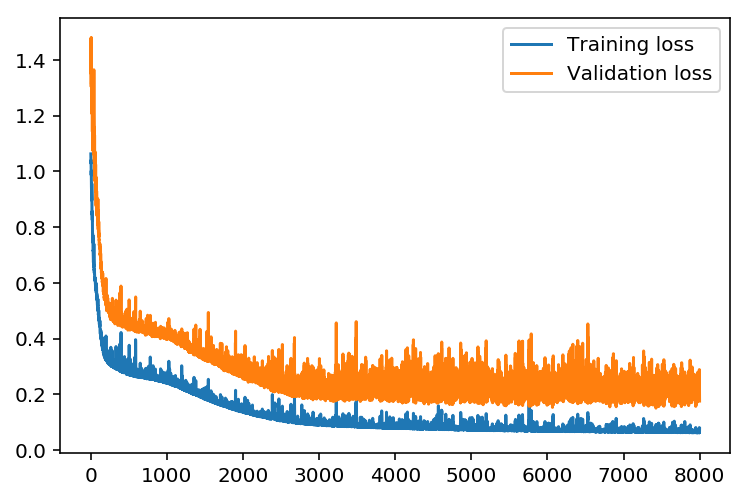

In [45]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

## 检查预测结果

使用测试数据看看网络对数据建模的效果如何。如果完全错了，请确保网络中的每步都正确实现。

[[ -2.55769333e-01]
 [ -6.71358678e-01]
 [ -1.02346788e+00]
 [ -9.59621842e-01]
 [ -9.44400120e-01]
 [ -1.02379892e+00]
 [ -9.11782460e-01]
 [ -8.83287259e-01]
 [ -2.37134179e-01]
 [  1.34147552e+00]
 [  2.56298771e+00]
 [  6.96664673e-01]
 [ -1.75877062e-01]
 [ -6.72226336e-02]
 [  2.41684800e-01]
 [  3.28705271e-01]
 [  1.98155996e-01]
 [  3.21549245e-01]
 [  1.09580992e+00]
 [  2.51294358e+00]
 [  2.30817520e+00]
 [  1.36975691e+00]
 [  6.46440541e-01]
 [  2.19563363e-01]
 [ -1.45223948e-01]
 [ -4.58122615e-01]
 [ -7.75298746e-01]
 [ -8.23465531e-01]
 [ -8.67929517e-01]
 [ -8.49059018e-01]
 [ -8.63866616e-01]
 [ -7.32169022e-01]
 [ -1.95169110e-01]
 [  1.33742636e+00]
 [  2.59897717e+00]
 [  7.26318651e-01]
 [ -2.23839093e-01]
 [ -2.64305197e-02]
 [  4.65543064e-01]
 [  4.33586789e-01]
 [  2.90620864e-01]
 [  3.78526776e-01]
 [  1.15140626e+00]
 [  2.44316628e+00]
 [  2.27963740e+00]
 [  1.26824069e+00]
 [  6.54854244e-01]
 [  1.76534369e-01]
 [ -1.40750308e-01]
 [ -4.32488893e-01]


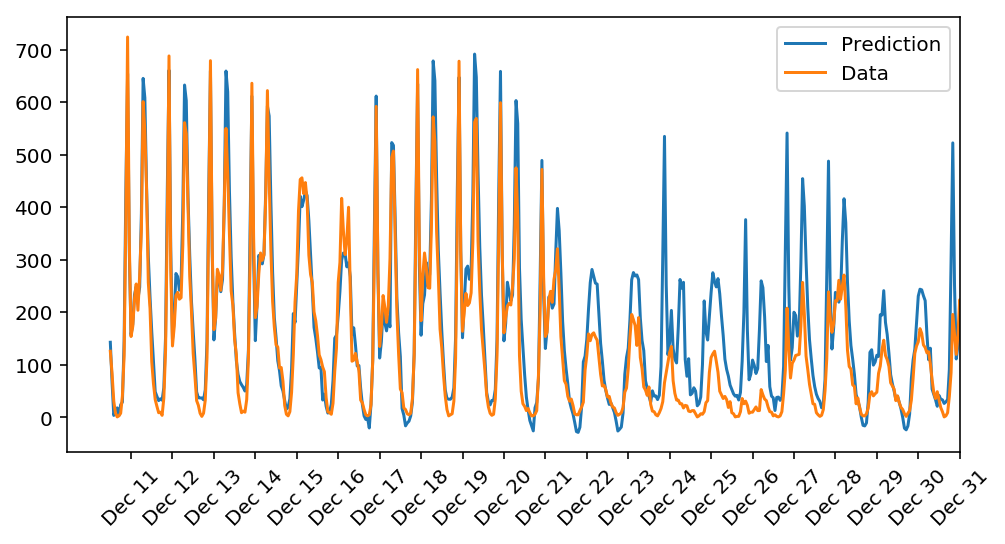

In [42]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

## 可选：思考下你的结果（我们不会评估这道题的答案）

 
请针对你的结果回答以下问题。模型对数据的预测效果如何？哪里出现问题了？为何出现问题呢？

> **注意**：你可以通过双击该单元编辑文本。如果想要预览文本，请按 Control + Enter

#### 请将你的答案填写在下方
